Training Variational Autoencoder with Multiple Lock-In Data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.Session(config = tf.ConfigProto(log_device_placement = True))

import keras
keras.backend.set_session(sess)
keras.backend.clear_session()

Using TensorFlow backend.


We wrap the machine learning process into functions:

1) DataPrep(filepath, test_ratio, z_cut) : takes the AFM measurement data in .npz format and returns rawdata, training set and the validation set

2) CreateVAE(** hyperparameters) : creates the VAE model given the hyperparameters of the model

3) SaveModel(savepath) : saves the training results in a suitable format

In [2]:
'''
** Dataprep(filepath, test_ratio) **
Inputs:
- filepath: path to the pre-processed AFM data file, in .npz format
- test_ratio: the ratio between the total number of approach curve data and the number of the approach curve data used in the validation set


Outputs:
- train_dataset: dataset corresponding to the training set
- test_dataset: dataset corresponding to the test set
- train: training set
- test: test set
'''

def DataPrep(filepath, test_ratio = 0.1): # the filepath must point to pre-processed AFM datafile, in .npz format
    # load the npz file
    dataset = np.load(filepath, allow_pickle = True)

    raw_dataset = dataset['raw'] # Lock-in raw data, [z, Amp(V), Phas(rad)] format
    mech_dataset = dataset['mech'] # Mechanical Amp, Phas,[z, Amp(V), Phas(rad)] format
    imin_dataset = dataset['imin'] # array index of the turning point : Appoach is from 0 ~ imin, Retract is from imin ~ end

    # Resonance curve fitting parameters
    Q_dataset = dataset['Q']
    w_dataset = dataset['w']
    w0_dataset = dataset['w0']
    I0_dataset = dataset['I0']
    C0C_dataset = dataset['C0C']

    E_dataset = dataset['E'] # Dissipated energy, normalized by kA0^2
    kint_dataset = dataset['kint'] # k_int, normalized by k
    bint_dataset = dataset['bint'] # b_int, normalized by k

    Fk_dataset = dataset['Fk'] # <F_k> = kA, normalized by kA0
    Fb_dataset = dataset['Fb'] # <F_b> = bwA, normalized by kA0

    filename_dataset = dataset['filename'] # filename

    N = Q_dataset.size
    N_test = int(N*test_ratio)

    print('Number of test samples : %d' %(N_test))
    print('Number of training samples : %d' %(N - N_test))

    sample_index = np.arange(N)
    np.random.shuffle(sample_index) # shuffle the input data
    
    seq_length = np.amin(imin_dataset) + 1
    
    #create data array : (trials, seq_length, 5)
    data = np.zeros((N, seq_length, 5))
    for i in range(N):
        data[i,:,0:3] = mech_dataset[i][imin_dataset[i]+1-seq_length:imin_dataset[i]+1, 0:3]
        data[i,:,3] = np.ones((1, seq_length))*Q_dataset[i]/w0_dataset[i] # 3rd channel is Q/w0
        data[i,:,4] = np.ones((1, seq_length))*w_dataset[i]/w0_dataset[i] # 4th channel is w/w0
    # create test and train datasets
    test_index = sample_index[0:N_test]
    train_index = sample_index[N_test:]
    
    test = data[test_index,:,:]
    train = data[train_index,:,:]
    
    keys = np.array(list(dataset.keys()))
    values = np.array(list(dataset.values()))
    print(values.shape)
    
    train_dataset = dict(zip(keys, values[:, train_index]))
    test_dataset = dict(zip(keys, values[:, test_index]))
    
    return [train_dataset, test_dataset, train, test]

Number of test samples : 31
Number of training samples : 279
(14, 310)


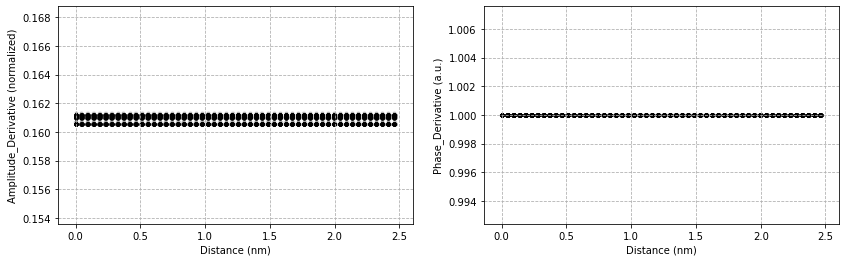

In [4]:
# filepath to the reformatted data file
filepath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Raw_Data/DohyunBest_deriv3.npz'
test_ratio = 0.1

train_dataset, test_dataset, train, test = DataPrep(filepath, test_ratio)

# Graph the training set
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
kwargs = {'c':'k', 'marker':'.', 'alpha':0.1}

for i in range(train.shape[0]):
    ax1.scatter(train[i,:,0], train[i,:,3], **kwargs)
    ax2.scatter(train[i,:,0], train[i,:,4], **kwargs)

ax1.set_xlabel('Distance (nm)')
ax1.set_ylabel('Amplitude_Derivative (normalized)')
ax1.grid(ls = '--')

ax2.set_xlabel('Distance (nm)')
ax2.set_ylabel('Phase_Derivative (a.u.)')
ax2.grid(ls = '--')


In [5]:
input_dim = (train.shape[1], train.shape[2]-1)
print(input_dim)
seq_length, n_channel = input_dim
print(seq_length)

(54, 4)
54


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_Input (InputLayer)     (None, 54, 2)        0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 54, 32)       352         Sequence_Input[0][0]             
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 54, 32)       128         conv1d_45[0][0]                  
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 54, 32)       0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv1d_46 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_Input (InputLayer)     (None, 54, 2)        0                                            
__________________________________________________________________________________________________
Constant_Input (InputLayer)     (None, 54, 2)        0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 54, 1)        31717       Sequence_Input[0][0]             
                                                                 Constant_Input[0][0]             
__________________________________________________________________________________________________
Decoder (Model)                 (None, 54, 2)        31594       Encoder[1][0]                    
          

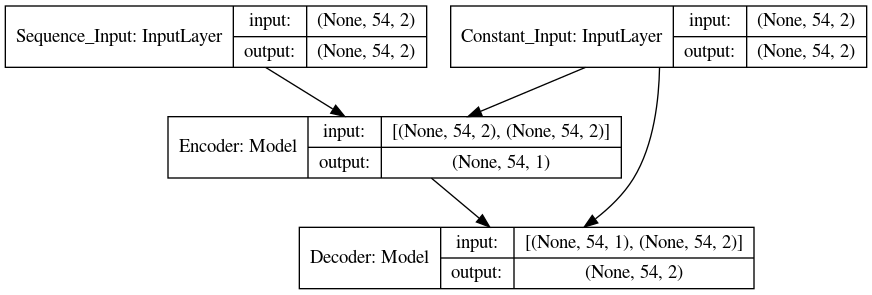

In [11]:
seq_length = train.shape[1]

from keras import optimizers
optimizer = optimizers.Adam(lr = 1e-3)

from Approach_ConvAE_ver2 import Conv1dAE

conv1d_ae = Conv1dAE(seq_length = seq_length, filters = 32, output_dim = 32, optimizer = optimizer)

#tensorboard = TensorBoard(log_dir = 'logs/{}'.format(time()))

model = conv1d_ae['autoencoder']
encoder = conv1d_ae['encoder']
batch_size = 32

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename='model_plot.png') 

In [12]:
from keras.callbacks import EarlyStopping
'''
Early stopping: stops the model if certain conditions are satisfied
References:
1) https://keras.io/callbacks/
2) https://stackoverflow.com/questions/53478622/stop-keras-training-when-the-network-has-fully-converge
'''
#stop_callback = EarlyStopping(monitor = 'val_loss', min_delta = 500, patience = 5) # loss change of under min_delta count as no improvement
#history = model.fit(x = train[:, 1:], epochs = 100, batch_size = batch_size, validation_data = (test[:, 1:], None), callbacks = [stop_callback])

history = model.fit(x = [train[:,:,1:3], train[:,:,3:]], epochs = 40000, batch_size = batch_size, validation_data = ([test[:,:,1:3], test[:,:,3:]], None))


Train on 279 samples, validate on 31 samples
Epoch 1/40000
279/279 [==============================] - 6s 21ms/step - loss: 1.1047 - val_loss: 1.9603
Epoch 2/40000
279/279 [==============================] - 0s 955us/step - loss: 0.8445 - val_loss: 2.1432
Epoch 3/40000
279/279 [==============================] - 0s 938us/step - loss: 0.7651 - val_loss: 1.6591
Epoch 4/40000
279/279 [==============================] - 0s 926us/step - loss: 0.7172 - val_loss: 1.2121
Epoch 5/40000
279/279 [==============================] - 0s 932us/step - loss: 0.6914 - val_loss: 1.0943
Epoch 6/40000
279/279 [==============================] - 0s 942us/step - loss: 0.6658 - val_loss: 0.8163
Epoch 7/40000
279/279 [==============================] - 0s 926us/step - loss: 0.6527 - val_loss: 0.7111
Epoch 8/40000
279/279 [==============================] - 0s 941us/step - loss: 0.6301 - val_loss: 0.7045
Epoch 9/40000
279/279 [==============================] - 0s 937us/step - loss: 0.6214 - val_loss: 0.6744
Epoch 10/40

Epoch 78/40000
279/279 [==============================] - 0s 908us/step - loss: 0.1928 - val_loss: 0.1782
Epoch 79/40000
279/279 [==============================] - 0s 912us/step - loss: 0.1820 - val_loss: 0.1246
Epoch 80/40000
279/279 [==============================] - 0s 913us/step - loss: 0.1870 - val_loss: 0.1155
Epoch 81/40000
279/279 [==============================] - 0s 903us/step - loss: 0.1817 - val_loss: 0.1765
Epoch 82/40000
279/279 [==============================] - 0s 904us/step - loss: 0.1793 - val_loss: 0.1682
Epoch 83/40000
279/279 [==============================] - 0s 907us/step - loss: 0.1850 - val_loss: 0.1088
Epoch 84/40000
279/279 [==============================] - 0s 913us/step - loss: 0.1805 - val_loss: 0.0949
Epoch 85/40000
279/279 [==============================] - 0s 913us/step - loss: 0.1662 - val_loss: 0.0981
Epoch 86/40000
279/279 [==============================] - 0s 905us/step - loss: 0.1617 - val_loss: 0.1010
Epoch 87/40000
279/279 [======================

Epoch 155/40000
279/279 [==============================] - 0s 999us/step - loss: 0.0670 - val_loss: 0.0611
Epoch 156/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0761
Epoch 157/40000
279/279 [==============================] - 0s 917us/step - loss: 0.0700 - val_loss: 0.0748
Epoch 158/40000
279/279 [==============================] - 0s 908us/step - loss: 0.0678 - val_loss: 0.0612
Epoch 159/40000
279/279 [==============================] - 0s 935us/step - loss: 0.0651 - val_loss: 0.0484
Epoch 160/40000
279/279 [==============================] - 0s 979us/step - loss: 0.0630 - val_loss: 0.0499
Epoch 161/40000
279/279 [==============================] - 0s 995us/step - loss: 0.0638 - val_loss: 0.0508
Epoch 162/40000
279/279 [==============================] - 0s 982us/step - loss: 0.0637 - val_loss: 0.0503
Epoch 163/40000
279/279 [==============================] - 0s 971us/step - loss: 0.0734 - val_loss: 0.0428
Epoch 164/40000
279/279 [==============

279/279 [==============================] - 0s 952us/step - loss: 0.0314 - val_loss: 0.0202
Epoch 232/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0347 - val_loss: 0.0191
Epoch 233/40000
279/279 [==============================] - 0s 995us/step - loss: 0.0307 - val_loss: 0.0181
Epoch 234/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0174
Epoch 235/40000
279/279 [==============================] - 0s 937us/step - loss: 0.0308 - val_loss: 0.0170
Epoch 236/40000
279/279 [==============================] - 0s 970us/step - loss: 0.0286 - val_loss: 0.0169
Epoch 237/40000
279/279 [==============================] - 0s 969us/step - loss: 0.0293 - val_loss: 0.0167
Epoch 238/40000
279/279 [==============================] - 0s 983us/step - loss: 0.0306 - val_loss: 0.0173
Epoch 239/40000
279/279 [==============================] - 0s 977us/step - loss: 0.0281 - val_loss: 0.0178
Epoch 240/40000
279/279 [==============================

Epoch 308/40000
279/279 [==============================] - 0s 952us/step - loss: 0.0204 - val_loss: 0.1322
Epoch 309/40000
279/279 [==============================] - 0s 979us/step - loss: 0.0193 - val_loss: 0.0231
Epoch 310/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0216 - val_loss: 0.0349
Epoch 311/40000
279/279 [==============================] - 0s 973us/step - loss: 0.0229 - val_loss: 0.0231
Epoch 312/40000
279/279 [==============================] - 0s 983us/step - loss: 0.0238 - val_loss: 0.0161
Epoch 313/40000
279/279 [==============================] - 0s 979us/step - loss: 0.0207 - val_loss: 0.0142
Epoch 314/40000
279/279 [==============================] - 0s 981us/step - loss: 0.0199 - val_loss: 0.0128
Epoch 315/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0197 - val_loss: 0.0118
Epoch 316/40000
279/279 [==============================] - 0s 962us/step - loss: 0.0209 - val_loss: 0.0105
Epoch 317/40000
279/279 [============

279/279 [==============================] - 0s 984us/step - loss: 0.0213 - val_loss: 0.1795
Epoch 385/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0204 - val_loss: 0.0919
Epoch 386/40000
279/279 [==============================] - 0s 999us/step - loss: 0.0184 - val_loss: 0.0497
Epoch 387/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0173 - val_loss: 0.0313
Epoch 388/40000
279/279 [==============================] - 0s 938us/step - loss: 0.0168 - val_loss: 0.0135
Epoch 389/40000
279/279 [==============================] - 0s 956us/step - loss: 0.0162 - val_loss: 0.0085
Epoch 390/40000
279/279 [==============================] - 0s 976us/step - loss: 0.0260 - val_loss: 0.0085
Epoch 391/40000
279/279 [==============================] - 0s 975us/step - loss: 0.0224 - val_loss: 0.0083
Epoch 392/40000
279/279 [==============================] - 0s 975us/step - loss: 0.0208 - val_loss: 0.0081
Epoch 393/40000
279/279 [==============================] 

Epoch 461/40000
279/279 [==============================] - 0s 977us/step - loss: 0.0074 - val_loss: 0.0042
Epoch 462/40000
279/279 [==============================] - 0s 998us/step - loss: 0.0080 - val_loss: 0.0042
Epoch 463/40000
279/279 [==============================] - 0s 998us/step - loss: 0.0085 - val_loss: 0.0041
Epoch 464/40000
279/279 [==============================] - 0s 990us/step - loss: 0.0089 - val_loss: 0.0040
Epoch 465/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0038
Epoch 466/40000
279/279 [==============================] - 0s 981us/step - loss: 0.0088 - val_loss: 0.0037
Epoch 467/40000
279/279 [==============================] - 0s 920us/step - loss: 0.0078 - val_loss: 0.0036
Epoch 468/40000
279/279 [==============================] - 0s 973us/step - loss: 0.0078 - val_loss: 0.0036
Epoch 469/40000
279/279 [==============================] - 0s 998us/step - loss: 0.0073 - val_loss: 0.0035
Epoch 470/40000
279/279 [==============

Epoch 538/40000
279/279 [==============================] - 0s 972us/step - loss: 0.0078 - val_loss: 0.0037
Epoch 539/40000
279/279 [==============================] - 0s 995us/step - loss: 0.0075 - val_loss: 0.0037
Epoch 540/40000
279/279 [==============================] - 0s 989us/step - loss: 0.0066 - val_loss: 0.0036
Epoch 541/40000
279/279 [==============================] - 0s 999us/step - loss: 0.0064 - val_loss: 0.0036
Epoch 542/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 543/40000
279/279 [==============================] - 0s 960us/step - loss: 0.0070 - val_loss: 0.0035
Epoch 544/40000
279/279 [==============================] - 0s 940us/step - loss: 0.0065 - val_loss: 0.0034
Epoch 545/40000
279/279 [==============================] - 0s 989us/step - loss: 0.0069 - val_loss: 0.0034
Epoch 546/40000
279/279 [==============================] - 0s 978us/step - loss: 0.0070 - val_loss: 0.0033
Epoch 547/40000
279/279 [==============

Epoch 615/40000
279/279 [==============================] - 0s 996us/step - loss: 0.0043 - val_loss: 0.0017
Epoch 616/40000
279/279 [==============================] - 0s 999us/step - loss: 0.0042 - val_loss: 0.0018
Epoch 617/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 618/40000
279/279 [==============================] - 0s 924us/step - loss: 0.0051 - val_loss: 0.0018
Epoch 619/40000
279/279 [==============================] - 0s 968us/step - loss: 0.0054 - val_loss: 0.0017
Epoch 620/40000
279/279 [==============================] - 0s 992us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 621/40000
279/279 [==============================] - 0s 994us/step - loss: 0.0041 - val_loss: 0.0017
Epoch 622/40000
279/279 [==============================] - 0s 997us/step - loss: 0.0047 - val_loss: 0.0017
Epoch 623/40000
279/279 [==============================] - 0s 995us/step - loss: 0.0052 - val_loss: 0.0017
Epoch 624/40000
279/279 [==============

Epoch 692/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0034 - val_loss: 0.0013
Epoch 693/40000
279/279 [==============================] - 0s 984us/step - loss: 0.0037 - val_loss: 0.0013
Epoch 694/40000
279/279 [==============================] - 0s 979us/step - loss: 0.0034 - val_loss: 0.0013
Epoch 695/40000
279/279 [==============================] - 0s 972us/step - loss: 0.0040 - val_loss: 0.0013
Epoch 696/40000
279/279 [==============================] - 0s 989us/step - loss: 0.0035 - val_loss: 0.0013
Epoch 697/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 698/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 699/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 700/40000
279/279 [==============================] - 0s 931us/step - loss: 0.0036 - val_loss: 0.0013
Epoch 701/40000
279/279 [==================

Epoch 769/40000
279/279 [==============================] - 0s 955us/step - loss: 0.0038 - val_loss: 0.0011
Epoch 770/40000
279/279 [==============================] - 0s 932us/step - loss: 0.0035 - val_loss: 0.0011
Epoch 771/40000
279/279 [==============================] - 0s 992us/step - loss: 0.0044 - val_loss: 0.0011
Epoch 772/40000
279/279 [==============================] - 0s 991us/step - loss: 0.0051 - val_loss: 0.0012
Epoch 773/40000
279/279 [==============================] - 0s 979us/step - loss: 0.0065 - val_loss: 0.0012
Epoch 774/40000
279/279 [==============================] - 0s 974us/step - loss: 0.0053 - val_loss: 0.0012
Epoch 775/40000
279/279 [==============================] - 0s 995us/step - loss: 0.0046 - val_loss: 0.0011
Epoch 776/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 777/40000
279/279 [==============================] - 0s 980us/step - loss: 0.0030 - val_loss: 9.8808e-04
Epoch 778/40000
279/279 [==========

279/279 [==============================] - 0s 989us/step - loss: 0.0084 - val_loss: 0.0242
Epoch 844/40000
279/279 [==============================] - 0s 996us/step - loss: 0.0072 - val_loss: 0.0073
Epoch 845/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 846/40000
279/279 [==============================] - 0s 972us/step - loss: 0.0069 - val_loss: 0.0020
Epoch 847/40000
279/279 [==============================] - 0s 951us/step - loss: 0.0055 - val_loss: 0.0019
Epoch 848/40000
279/279 [==============================] - 0s 994us/step - loss: 0.0058 - val_loss: 0.0018
Epoch 849/40000
279/279 [==============================] - 0s 969us/step - loss: 0.0061 - val_loss: 0.0018
Epoch 850/40000
279/279 [==============================] - 0s 996us/step - loss: 0.0056 - val_loss: 0.0018
Epoch 851/40000
279/279 [==============================] - 0s 997us/step - loss: 0.0051 - val_loss: 0.0017
Epoch 852/40000
279/279 [==============================

279/279 [==============================] - 0s 985us/step - loss: 0.0031 - val_loss: 6.7652e-04
Epoch 919/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 7.4321e-04
Epoch 920/40000
279/279 [==============================] - 0s 970us/step - loss: 0.0036 - val_loss: 6.9998e-04
Epoch 921/40000
279/279 [==============================] - 0s 988us/step - loss: 0.0033 - val_loss: 6.9673e-04
Epoch 922/40000
279/279 [==============================] - 0s 973us/step - loss: 0.0038 - val_loss: 6.9423e-04
Epoch 923/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 5.7644e-04
Epoch 924/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 5.3271e-04
Epoch 925/40000
279/279 [==============================] - 0s 953us/step - loss: 0.0032 - val_loss: 5.2741e-04
Epoch 926/40000
279/279 [==============================] - 0s 986us/step - loss: 0.0032 - val_loss: 5.3522e-04
Epoch 927/40000
279/279

Epoch 993/40000
279/279 [==============================] - 0s 998us/step - loss: 0.0031 - val_loss: 0.0019
Epoch 994/40000
279/279 [==============================] - 0s 962us/step - loss: 0.0037 - val_loss: 0.0019
Epoch 995/40000
279/279 [==============================] - 0s 993us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 996/40000
279/279 [==============================] - 0s 989us/step - loss: 0.0032 - val_loss: 0.0021
Epoch 997/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 998/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 999/40000
279/279 [==============================] - 0s 999us/step - loss: 0.0031 - val_loss: 0.0013
Epoch 1000/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 8.7970e-04
Epoch 1001/40000
279/279 [==============================] - 0s 945us/step - loss: 0.0037 - val_loss: 0.0010
Epoch 1002/40000
279/279 [===========

279/279 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0028
Epoch 1068/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 1069/40000
279/279 [==============================] - 0s 1000us/step - loss: 0.0049 - val_loss: 0.0027
Epoch 1070/40000
279/279 [==============================] - 0s 945us/step - loss: 0.0048 - val_loss: 0.0026
Epoch 1071/40000
279/279 [==============================] - 0s 980us/step - loss: 0.0040 - val_loss: 0.0024
Epoch 1072/40000
279/279 [==============================] - 0s 1000us/step - loss: 0.0036 - val_loss: 0.0024
Epoch 1073/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 1074/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 1075/40000
279/279 [==============================] - 0s 996us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 1076/40000
279/279 [=========================

279/279 [==============================] - 0s 972us/step - loss: 0.0032 - val_loss: 8.4657e-04
Epoch 1142/40000
279/279 [==============================] - 0s 959us/step - loss: 0.0029 - val_loss: 7.8578e-04
Epoch 1143/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0034 - val_loss: 7.8304e-04
Epoch 1144/40000
279/279 [==============================] - 0s 971us/step - loss: 0.0029 - val_loss: 8.7152e-04
Epoch 1145/40000
279/279 [==============================] - 0s 978us/step - loss: 0.0031 - val_loss: 7.7989e-04
Epoch 1146/40000
279/279 [==============================] - 0s 945us/step - loss: 0.0031 - val_loss: 7.7249e-04
Epoch 1147/40000
279/279 [==============================] - 0s 973us/step - loss: 0.0036 - val_loss: 7.3089e-04
Epoch 1148/40000
279/279 [==============================] - 0s 968us/step - loss: 0.0027 - val_loss: 6.8680e-04
Epoch 1149/40000
279/279 [==============================] - 0s 965us/step - loss: 0.0029 - val_loss: 7.8764e-04
Epoch 115

279/279 [==============================] - 0s 971us/step - loss: 0.0023 - val_loss: 4.3670e-04
Epoch 1215/40000
279/279 [==============================] - 0s 966us/step - loss: 0.0022 - val_loss: 4.1886e-04
Epoch 1216/40000
279/279 [==============================] - 0s 973us/step - loss: 0.0023 - val_loss: 4.1440e-04
Epoch 1217/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0025 - val_loss: 4.2528e-04
Epoch 1218/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0025 - val_loss: 4.6400e-04
Epoch 1219/40000
279/279 [==============================] - 0s 966us/step - loss: 0.0030 - val_loss: 4.4114e-04
Epoch 1220/40000
279/279 [==============================] - 0s 962us/step - loss: 0.0025 - val_loss: 4.4483e-04
Epoch 1221/40000
279/279 [==============================] - 0s 956us/step - loss: 0.0024 - val_loss: 4.1300e-04
Epoch 1222/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0025 - val_loss: 4.1045e-04
Epoch 122

279/279 [==============================] - 0s 996us/step - loss: 0.0025 - val_loss: 4.3513e-04
Epoch 1288/40000
279/279 [==============================] - 0s 940us/step - loss: 0.0027 - val_loss: 4.1988e-04
Epoch 1289/40000
279/279 [==============================] - 0s 914us/step - loss: 0.0027 - val_loss: 8.1517e-04
Epoch 1290/40000
279/279 [==============================] - 0s 953us/step - loss: 0.0065 - val_loss: 0.0016
Epoch 1291/40000
279/279 [==============================] - 0s 954us/step - loss: 0.0060 - val_loss: 2.0627
Epoch 1292/40000
279/279 [==============================] - 0s 956us/step - loss: 0.0096 - val_loss: 3.0775
Epoch 1293/40000
279/279 [==============================] - 0s 967us/step - loss: 0.0110 - val_loss: 1.8522
Epoch 1294/40000
279/279 [==============================] - 0s 954us/step - loss: 0.0062 - val_loss: 0.1629
Epoch 1295/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0068 - val_loss: 0.0351
Epoch 1296/40000
279/279 [=======

279/279 [==============================] - 0s 986us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 1363/40000
279/279 [==============================] - 0s 988us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 1364/40000
279/279 [==============================] - 0s 986us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 1365/40000
279/279 [==============================] - 0s 983us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 1366/40000
279/279 [==============================] - 0s 954us/step - loss: 0.0022 - val_loss: 0.0016
Epoch 1367/40000
279/279 [==============================] - 0s 894us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 1368/40000
279/279 [==============================] - 0s 953us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 1369/40000
279/279 [==============================] - 0s 960us/step - loss: 0.0017 - val_loss: 0.0014
Epoch 1370/40000
279/279 [==============================] - 0s 969us/step - loss: 0.0018 - val_loss: 0.0013
Epoch 1371/40000
279/279 [===================

279/279 [==============================] - 0s 972us/step - loss: 0.0014 - val_loss: 8.1692e-04
Epoch 1437/40000
279/279 [==============================] - 0s 968us/step - loss: 0.0017 - val_loss: 8.8470e-04
Epoch 1438/40000
279/279 [==============================] - 0s 962us/step - loss: 0.0013 - val_loss: 9.1132e-04
Epoch 1439/40000
279/279 [==============================] - 0s 989us/step - loss: 0.0013 - val_loss: 9.2695e-04
Epoch 1440/40000
279/279 [==============================] - 0s 959us/step - loss: 0.0015 - val_loss: 8.7473e-04
Epoch 1441/40000
279/279 [==============================] - 0s 972us/step - loss: 0.0013 - val_loss: 8.7282e-04
Epoch 1442/40000
279/279 [==============================] - 0s 989us/step - loss: 0.0013 - val_loss: 9.2039e-04
Epoch 1443/40000
279/279 [==============================] - 0s 934us/step - loss: 0.0013 - val_loss: 9.0732e-04
Epoch 1444/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0012 - val_loss: 9.3584e-04
Epoch 144

279/279 [==============================] - 0s 955us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1510/40000
279/279 [==============================] - 0s 973us/step - loss: 0.0015 - val_loss: 0.0012
Epoch 1511/40000
279/279 [==============================] - 0s 981us/step - loss: 0.0013 - val_loss: 9.1572e-04
Epoch 1512/40000
279/279 [==============================] - 0s 937us/step - loss: 0.0013 - val_loss: 9.0789e-04
Epoch 1513/40000
279/279 [==============================] - 0s 950us/step - loss: 0.0013 - val_loss: 8.5299e-04
Epoch 1514/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0014 - val_loss: 8.4969e-04
Epoch 1515/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0015 - val_loss: 9.7668e-04
Epoch 1516/40000
279/279 [==============================] - 0s 983us/step - loss: 0.0013 - val_loss: 8.6565e-04
Epoch 1517/40000
279/279 [==============================] - 0s 979us/step - loss: 0.0013 - val_loss: 8.8874e-04
Epoch 1518/40000


279/279 [==============================] - 0s 963us/step - loss: 0.0011 - val_loss: 9.9838e-04
Epoch 1584/40000
279/279 [==============================] - 0s 949us/step - loss: 0.0011 - val_loss: 9.7149e-04
Epoch 1585/40000
279/279 [==============================] - 0s 960us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 1586/40000
279/279 [==============================] - 0s 954us/step - loss: 0.0011 - val_loss: 9.2550e-04
Epoch 1587/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0010 - val_loss: 9.3923e-04
Epoch 1588/40000
279/279 [==============================] - 0s 970us/step - loss: 0.0014 - val_loss: 6.4471e-04
Epoch 1589/40000
279/279 [==============================] - 0s 960us/step - loss: 0.0011 - val_loss: 8.7765e-04
Epoch 1590/40000
279/279 [==============================] - 0s 970us/step - loss: 0.0011 - val_loss: 8.8693e-04
Epoch 1591/40000
279/279 [==============================] - 0s 953us/step - loss: 0.0011 - val_loss: 8.6924e-04
Epoch 1592/40

279/279 [==============================] - 0s 956us/step - loss: 0.0012 - val_loss: 5.8002e-04
Epoch 1657/40000
279/279 [==============================] - 0s 963us/step - loss: 0.0011 - val_loss: 5.7451e-04
Epoch 1658/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 1659/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0014 - val_loss: 6.7314e-04
Epoch 1660/40000
279/279 [==============================] - 0s 952us/step - loss: 0.0013 - val_loss: 7.8750e-04
Epoch 1661/40000
279/279 [==============================] - 0s 989us/step - loss: 0.0017 - val_loss: 8.2021e-04
Epoch 1662/40000
279/279 [==============================] - 0s 965us/step - loss: 0.0014 - val_loss: 8.1136e-04
Epoch 1663/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0015 - val_loss: 6.4607e-04
Epoch 1664/40000
279/279 [==============================] - 0s 953us/step - loss: 0.0013 - val_loss: 8.1336e-04
Epoch 1665/40

279/279 [==============================] - 0s 982us/step - loss: 0.0010 - val_loss: 7.7625e-04
Epoch 1730/40000
279/279 [==============================] - 0s 986us/step - loss: 0.0010 - val_loss: 7.9154e-04
Epoch 1731/40000
279/279 [==============================] - 0s 906us/step - loss: 0.0010 - val_loss: 5.9786e-04
Epoch 1732/40000
279/279 [==============================] - 0s 963us/step - loss: 0.0013 - val_loss: 7.8997e-04
Epoch 1733/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0010 - val_loss: 9.2119e-04
Epoch 1734/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0012 - val_loss: 7.4169e-04
Epoch 1735/40000
279/279 [==============================] - 0s 965us/step - loss: 0.0011 - val_loss: 6.1018e-04
Epoch 1736/40000
279/279 [==============================] - 0s 955us/step - loss: 0.0011 - val_loss: 8.5881e-04
Epoch 1737/40000
279/279 [==============================] - 0s 963us/step - loss: 0.0010 - val_loss: 6.9006e-04
Epoch 173

279/279 [==============================] - 0s 969us/step - loss: 0.0011 - val_loss: 6.1763e-04
Epoch 1802/40000
279/279 [==============================] - 0s 968us/step - loss: 0.0011 - val_loss: 6.0347e-04
Epoch 1803/40000
279/279 [==============================] - 0s 964us/step - loss: 9.8960e-04 - val_loss: 6.4009e-04
Epoch 1804/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0011 - val_loss: 6.4805e-04
Epoch 1805/40000
279/279 [==============================] - 0s 968us/step - loss: 0.0011 - val_loss: 9.3126e-04
Epoch 1806/40000
279/279 [==============================] - 0s 959us/step - loss: 0.0011 - val_loss: 7.6045e-04
Epoch 1807/40000
279/279 [==============================] - 0s 964us/step - loss: 9.6540e-04 - val_loss: 7.4539e-04
Epoch 1808/40000
279/279 [==============================] - 0s 961us/step - loss: 9.9804e-04 - val_loss: 8.3396e-04
Epoch 1809/40000
279/279 [==============================] - 0s 960us/step - loss: 9.9449e-04 - val_loss: 7.04

279/279 [==============================] - 0s 967us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 1874/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 1875/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 1876/40000
279/279 [==============================] - 0s 928us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 1877/40000
279/279 [==============================] - 0s 953us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 1878/40000
279/279 [==============================] - 0s 963us/step - loss: 0.0011 - val_loss: 9.8790e-04
Epoch 1879/40000
279/279 [==============================] - 0s 965us/step - loss: 0.0010 - val_loss: 8.9351e-04
Epoch 1880/40000
279/279 [==============================] - 0s 972us/step - loss: 0.0010 - val_loss: 9.0116e-04
Epoch 1881/40000
279/279 [==============================] - 0s 966us/step - loss: 9.8794e-04 - val_loss: 9.7595e-04
Epoch 1882/40000
279/279 

279/279 [==============================] - 0s 943us/step - loss: 0.0010 - val_loss: 7.2343e-04
Epoch 1946/40000
279/279 [==============================] - 0s 952us/step - loss: 0.0010 - val_loss: 6.2236e-04
Epoch 1947/40000
279/279 [==============================] - 0s 954us/step - loss: 0.0012 - val_loss: 6.4706e-04
Epoch 1948/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0010 - val_loss: 5.9443e-04
Epoch 1949/40000
279/279 [==============================] - 0s 962us/step - loss: 9.6323e-04 - val_loss: 6.5392e-04
Epoch 1950/40000
279/279 [==============================] - 0s 964us/step - loss: 9.1846e-04 - val_loss: 5.6396e-04
Epoch 1951/40000
279/279 [==============================] - 0s 969us/step - loss: 9.4290e-04 - val_loss: 5.3414e-04
Epoch 1952/40000
279/279 [==============================] - 0s 955us/step - loss: 9.4444e-04 - val_loss: 5.0607e-04
Epoch 1953/40000
279/279 [==============================] - 0s 960us/step - loss: 9.6981e-04 - val_loss: 

Epoch 2017/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0012 - val_loss: 6.9240e-04
Epoch 2018/40000
279/279 [==============================] - 0s 995us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2019/40000
279/279 [==============================] - 0s 978us/step - loss: 0.0010 - val_loss: 8.1670e-04
Epoch 2020/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 2021/40000
279/279 [==============================] - 0s 941us/step - loss: 0.0010 - val_loss: 9.0894e-04
Epoch 2022/40000
279/279 [==============================] - 0s 903us/step - loss: 0.0010 - val_loss: 8.0763e-04
Epoch 2023/40000
279/279 [==============================] - 0s 952us/step - loss: 0.0012 - val_loss: 6.3246e-04
Epoch 2024/40000
279/279 [==============================] - 0s 955us/step - loss: 9.9672e-04 - val_loss: 7.6721e-04
Epoch 2025/40000
279/279 [==============================] - 0s 966us/step - loss: 0.0011 - val_loss: 6.6270e

Epoch 2089/40000
279/279 [==============================] - 0s 966us/step - loss: 9.1132e-04 - val_loss: 7.2574e-04
Epoch 2090/40000
279/279 [==============================] - 0s 956us/step - loss: 9.2113e-04 - val_loss: 5.8015e-04
Epoch 2091/40000
279/279 [==============================] - 0s 957us/step - loss: 9.4428e-04 - val_loss: 6.3700e-04
Epoch 2092/40000
279/279 [==============================] - 0s 972us/step - loss: 9.5610e-04 - val_loss: 6.4907e-04
Epoch 2093/40000
279/279 [==============================] - 0s 957us/step - loss: 9.1967e-04 - val_loss: 7.5104e-04
Epoch 2094/40000
279/279 [==============================] - 0s 959us/step - loss: 9.6448e-04 - val_loss: 7.5300e-04
Epoch 2095/40000
279/279 [==============================] - 0s 963us/step - loss: 9.4759e-04 - val_loss: 7.6022e-04
Epoch 2096/40000
279/279 [==============================] - 0s 943us/step - loss: 0.0013 - val_loss: 5.9884e-04
Epoch 2097/40000
279/279 [==============================] - 0s 961us/step - 

279/279 [==============================] - 0s 975us/step - loss: 9.0171e-04 - val_loss: 6.6346e-04
Epoch 2161/40000
279/279 [==============================] - 0s 976us/step - loss: 9.8105e-04 - val_loss: 5.7967e-04
Epoch 2162/40000
279/279 [==============================] - 0s 976us/step - loss: 9.1483e-04 - val_loss: 6.0853e-04
Epoch 2163/40000
279/279 [==============================] - 0s 979us/step - loss: 9.3530e-04 - val_loss: 6.1946e-04
Epoch 2164/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.8365e-04 - val_loss: 5.5244e-04
Epoch 2165/40000
279/279 [==============================] - 0s 916us/step - loss: 9.2073e-04 - val_loss: 6.1523e-04
Epoch 2166/40000
279/279 [==============================] - 0s 892us/step - loss: 9.1786e-04 - val_loss: 5.5365e-04
Epoch 2167/40000
279/279 [==============================] - 0s 900us/step - loss: 9.8793e-04 - val_loss: 6.2620e-04
Epoch 2168/40000
279/279 [==============================] - 0s 951us/step - loss: 9.6769e-0

279/279 [==============================] - 0s 976us/step - loss: 0.0010 - val_loss: 6.5773e-04
Epoch 2233/40000
279/279 [==============================] - 0s 975us/step - loss: 9.7317e-04 - val_loss: 5.6484e-04
Epoch 2234/40000
279/279 [==============================] - 0s 952us/step - loss: 9.4254e-04 - val_loss: 5.1862e-04
Epoch 2235/40000
279/279 [==============================] - 0s 958us/step - loss: 9.7640e-04 - val_loss: 5.1274e-04
Epoch 2236/40000
279/279 [==============================] - 0s 955us/step - loss: 9.4539e-04 - val_loss: 5.0696e-04
Epoch 2237/40000
279/279 [==============================] - 0s 950us/step - loss: 9.3226e-04 - val_loss: 4.8708e-04
Epoch 2238/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0011 - val_loss: 5.2228e-04
Epoch 2239/40000
279/279 [==============================] - 0s 984us/step - loss: 9.4617e-04 - val_loss: 5.4666e-04
Epoch 2240/40000
279/279 [==============================] - 0s 985us/step - loss: 0.0013 - val_lo

279/279 [==============================] - 0s 942us/step - loss: 9.9519e-04 - val_loss: 0.0011
Epoch 2305/40000
279/279 [==============================] - 0s 967us/step - loss: 9.5984e-04 - val_loss: 0.0010
Epoch 2306/40000
279/279 [==============================] - 0s 965us/step - loss: 9.8630e-04 - val_loss: 0.0010
Epoch 2307/40000
279/279 [==============================] - 0s 959us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2308/40000
279/279 [==============================] - 0s 967us/step - loss: 0.0010 - val_loss: 8.0529e-04
Epoch 2309/40000
279/279 [==============================] - 0s 960us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2310/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0011 - val_loss: 0.0017
Epoch 2311/40000
279/279 [==============================] - 0s 964us/step - loss: 9.5405e-04 - val_loss: 0.0013
Epoch 2312/40000
279/279 [==============================] - 0s 973us/step - loss: 9.6089e-04 - val_loss: 0.0011
Epoch 2313/40000
279/

Epoch 2377/40000
279/279 [==============================] - 0s 972us/step - loss: 8.3933e-04 - val_loss: 5.2861e-04
Epoch 2378/40000
279/279 [==============================] - 0s 895us/step - loss: 9.3467e-04 - val_loss: 4.9190e-04
Epoch 2379/40000
279/279 [==============================] - 0s 933us/step - loss: 8.3158e-04 - val_loss: 5.1989e-04
Epoch 2380/40000
279/279 [==============================] - 0s 959us/step - loss: 8.5001e-04 - val_loss: 4.9897e-04
Epoch 2381/40000
279/279 [==============================] - 0s 958us/step - loss: 9.4241e-04 - val_loss: 4.5736e-04
Epoch 2382/40000
279/279 [==============================] - 0s 963us/step - loss: 7.8115e-04 - val_loss: 4.3293e-04
Epoch 2383/40000
279/279 [==============================] - 0s 952us/step - loss: 8.2258e-04 - val_loss: 4.4289e-04
Epoch 2384/40000
279/279 [==============================] - 0s 964us/step - loss: 8.0343e-04 - val_loss: 4.1183e-04
Epoch 2385/40000
279/279 [==============================] - 0s 966us/ste

Epoch 2448/40000
279/279 [==============================] - 0s 984us/step - loss: 7.9758e-04 - val_loss: 3.4729e-04
Epoch 2449/40000
279/279 [==============================] - 0s 952us/step - loss: 7.9873e-04 - val_loss: 3.0610e-04
Epoch 2450/40000
279/279 [==============================] - 0s 951us/step - loss: 8.2314e-04 - val_loss: 3.3651e-04
Epoch 2451/40000
279/279 [==============================] - 0s 966us/step - loss: 7.6995e-04 - val_loss: 2.9222e-04
Epoch 2452/40000
279/279 [==============================] - 0s 948us/step - loss: 7.9830e-04 - val_loss: 3.0716e-04
Epoch 2453/40000
279/279 [==============================] - 0s 958us/step - loss: 7.9688e-04 - val_loss: 2.8499e-04
Epoch 2454/40000
279/279 [==============================] - 0s 961us/step - loss: 9.2286e-04 - val_loss: 3.2789e-04
Epoch 2455/40000
279/279 [==============================] - 0s 962us/step - loss: 8.4636e-04 - val_loss: 3.1259e-04
Epoch 2456/40000
279/279 [==============================] - 0s 958us/ste

Epoch 2519/40000
279/279 [==============================] - 0s 964us/step - loss: 8.3743e-04 - val_loss: 3.0950e-04
Epoch 2520/40000
279/279 [==============================] - 0s 964us/step - loss: 8.4231e-04 - val_loss: 3.1051e-04
Epoch 2521/40000
279/279 [==============================] - 0s 951us/step - loss: 7.9847e-04 - val_loss: 3.0627e-04
Epoch 2522/40000
279/279 [==============================] - 0s 949us/step - loss: 8.0500e-04 - val_loss: 3.3503e-04
Epoch 2523/40000
279/279 [==============================] - 0s 960us/step - loss: 7.9384e-04 - val_loss: 3.7432e-04
Epoch 2524/40000
279/279 [==============================] - 0s 967us/step - loss: 7.8435e-04 - val_loss: 3.1631e-04
Epoch 2525/40000
279/279 [==============================] - 0s 944us/step - loss: 8.4473e-04 - val_loss: 3.4934e-04
Epoch 2526/40000
279/279 [==============================] - 0s 967us/step - loss: 8.3225e-04 - val_loss: 3.2283e-04
Epoch 2527/40000
279/279 [==============================] - 0s 962us/ste

Epoch 2590/40000
279/279 [==============================] - 0s 963us/step - loss: 8.0089e-04 - val_loss: 3.1652e-04
Epoch 2591/40000
279/279 [==============================] - 0s 966us/step - loss: 7.7211e-04 - val_loss: 2.6361e-04
Epoch 2592/40000
279/279 [==============================] - 0s 967us/step - loss: 8.9068e-04 - val_loss: 2.4961e-04
Epoch 2593/40000
279/279 [==============================] - 0s 983us/step - loss: 9.3960e-04 - val_loss: 2.5800e-04
Epoch 2594/40000
279/279 [==============================] - 0s 983us/step - loss: 8.0479e-04 - val_loss: 2.6417e-04
Epoch 2595/40000
279/279 [==============================] - 0s 916us/step - loss: 7.6824e-04 - val_loss: 2.7783e-04
Epoch 2596/40000
279/279 [==============================] - 0s 944us/step - loss: 8.7831e-04 - val_loss: 2.4090e-04
Epoch 2597/40000
279/279 [==============================] - 0s 960us/step - loss: 7.6766e-04 - val_loss: 2.0939e-04
Epoch 2598/40000
279/279 [==============================] - 0s 972us/ste

279/279 [==============================] - 0s 966us/step - loss: 7.9519e-04 - val_loss: 2.9686e-04
Epoch 2662/40000
279/279 [==============================] - 0s 963us/step - loss: 7.9869e-04 - val_loss: 3.0830e-04
Epoch 2663/40000
279/279 [==============================] - 0s 982us/step - loss: 7.7465e-04 - val_loss: 2.9164e-04
Epoch 2664/40000
279/279 [==============================] - 0s 986us/step - loss: 7.6563e-04 - val_loss: 2.9078e-04
Epoch 2665/40000
279/279 [==============================] - 0s 943us/step - loss: 8.9331e-04 - val_loss: 2.7221e-04
Epoch 2666/40000
279/279 [==============================] - 0s 946us/step - loss: 7.8914e-04 - val_loss: 3.0660e-04
Epoch 2667/40000
279/279 [==============================] - 0s 958us/step - loss: 8.7220e-04 - val_loss: 2.9512e-04
Epoch 2668/40000
279/279 [==============================] - 0s 960us/step - loss: 8.1321e-04 - val_loss: 2.7206e-04
Epoch 2669/40000
279/279 [==============================] - 0s 967us/step - loss: 7.8608e

279/279 [==============================] - 0s 979us/step - loss: 8.9807e-04 - val_loss: 1.5326e-04
Epoch 2733/40000
279/279 [==============================] - 0s 960us/step - loss: 7.6841e-04 - val_loss: 1.7333e-04
Epoch 2734/40000
279/279 [==============================] - 0s 962us/step - loss: 7.9435e-04 - val_loss: 1.8564e-04
Epoch 2735/40000
279/279 [==============================] - 0s 957us/step - loss: 7.7853e-04 - val_loss: 1.8165e-04
Epoch 2736/40000
279/279 [==============================] - 0s 962us/step - loss: 7.4574e-04 - val_loss: 1.7692e-04
Epoch 2737/40000
279/279 [==============================] - 0s 962us/step - loss: 7.3501e-04 - val_loss: 1.7574e-04
Epoch 2738/40000
279/279 [==============================] - 0s 964us/step - loss: 8.2707e-04 - val_loss: 1.7592e-04
Epoch 2739/40000
279/279 [==============================] - 0s 959us/step - loss: 7.8373e-04 - val_loss: 2.8704e-04
Epoch 2740/40000
279/279 [==============================] - 0s 964us/step - loss: 9.2162e

279/279 [==============================] - 0s 961us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 2805/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0013 - val_loss: 0.0021
Epoch 2806/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 2807/40000
279/279 [==============================] - 0s 963us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2808/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 2809/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2810/40000
279/279 [==============================] - 0s 954us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2811/40000
279/279 [==============================] - 0s 968us/step - loss: 0.0010 - val_loss: 7.9675e-04
Epoch 2812/40000
279/279 [==============================] - 0s 959us/step - loss: 0.0012 - val_loss: 4.6587e-04
Epoch 2813/40000
279/279 [===========

Epoch 2876/40000
279/279 [==============================] - 0s 958us/step - loss: 7.4959e-04 - val_loss: 2.0308e-04
Epoch 2877/40000
279/279 [==============================] - 0s 965us/step - loss: 7.5857e-04 - val_loss: 1.9969e-04
Epoch 2878/40000
279/279 [==============================] - 0s 955us/step - loss: 7.6161e-04 - val_loss: 1.6978e-04
Epoch 2879/40000
279/279 [==============================] - 0s 959us/step - loss: 7.7351e-04 - val_loss: 1.7283e-04
Epoch 2880/40000
279/279 [==============================] - 0s 949us/step - loss: 9.9082e-04 - val_loss: 1.5409e-04
Epoch 2881/40000
279/279 [==============================] - 0s 957us/step - loss: 7.5340e-04 - val_loss: 1.7604e-04
Epoch 2882/40000
279/279 [==============================] - 0s 969us/step - loss: 7.6735e-04 - val_loss: 1.7004e-04
Epoch 2883/40000
279/279 [==============================] - 0s 955us/step - loss: 7.6405e-04 - val_loss: 1.5886e-04
Epoch 2884/40000
279/279 [==============================] - 0s 950us/ste

279/279 [==============================] - 0s 1ms/step - loss: 7.3628e-04 - val_loss: 4.3489e-04
Epoch 2948/40000
279/279 [==============================] - 0s 994us/step - loss: 9.7778e-04 - val_loss: 4.3692e-04
Epoch 2949/40000
279/279 [==============================] - 0s 957us/step - loss: 9.9641e-04 - val_loss: 3.3983e-04
Epoch 2950/40000
279/279 [==============================] - 0s 962us/step - loss: 7.4121e-04 - val_loss: 1.6501e-04
Epoch 2951/40000
279/279 [==============================] - 0s 969us/step - loss: 9.0617e-04 - val_loss: 1.7873e-04
Epoch 2952/40000
279/279 [==============================] - 0s 989us/step - loss: 8.7613e-04 - val_loss: 1.6102e-04
Epoch 2953/40000
279/279 [==============================] - 0s 977us/step - loss: 7.8055e-04 - val_loss: 2.3675e-04
Epoch 2954/40000
279/279 [==============================] - 0s 989us/step - loss: 7.3595e-04 - val_loss: 2.5402e-04
Epoch 2955/40000
279/279 [==============================] - 0s 968us/step - loss: 9.0828e-0

279/279 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0412
Epoch 3020/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0284
Epoch 3021/40000
279/279 [==============================] - 0s 960us/step - loss: 9.5171e-04 - val_loss: 0.0178
Epoch 3022/40000
279/279 [==============================] - 0s 976us/step - loss: 8.6946e-04 - val_loss: 0.0110
Epoch 3023/40000
279/279 [==============================] - 0s 998us/step - loss: 9.7765e-04 - val_loss: 0.0091
Epoch 3024/40000
279/279 [==============================] - 0s 999us/step - loss: 9.7845e-04 - val_loss: 0.0071
Epoch 3025/40000
279/279 [==============================] - 0s 985us/step - loss: 0.0010 - val_loss: 0.0046
Epoch 3026/40000
279/279 [==============================] - 0s 979us/step - loss: 8.4146e-04 - val_loss: 0.0029
Epoch 3027/40000
279/279 [==============================] - 0s 999us/step - loss: 9.1561e-04 - val_loss: 0.0016
Epoch 3028/40000
279/279 

Epoch 3091/40000
279/279 [==============================] - 0s 952us/step - loss: 9.0687e-04 - val_loss: 3.9245e-04
Epoch 3092/40000
279/279 [==============================] - 0s 914us/step - loss: 8.5474e-04 - val_loss: 3.5916e-04
Epoch 3093/40000
279/279 [==============================] - 0s 956us/step - loss: 8.3760e-04 - val_loss: 3.2790e-04
Epoch 3094/40000
279/279 [==============================] - 0s 987us/step - loss: 8.2029e-04 - val_loss: 3.7330e-04
Epoch 3095/40000
279/279 [==============================] - 0s 999us/step - loss: 8.8915e-04 - val_loss: 3.0749e-04
Epoch 3096/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9172e-04 - val_loss: 2.8282e-04
Epoch 3097/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4136e-04 - val_loss: 1.3595e-04
Epoch 3098/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0003e-04 - val_loss: 2.4843e-04
Epoch 3099/40000
279/279 [==============================] - 0s 1ms/step - loss

279/279 [==============================] - 0s 994us/step - loss: 8.0450e-04 - val_loss: 1.8378e-04
Epoch 3163/40000
279/279 [==============================] - 0s 994us/step - loss: 7.9604e-04 - val_loss: 1.8595e-04
Epoch 3164/40000
279/279 [==============================] - 0s 958us/step - loss: 9.6137e-04 - val_loss: 2.2636e-04
Epoch 3165/40000
279/279 [==============================] - 0s 958us/step - loss: 8.0523e-04 - val_loss: 2.4385e-04
Epoch 3166/40000
279/279 [==============================] - 0s 988us/step - loss: 8.1305e-04 - val_loss: 2.4530e-04
Epoch 3167/40000
279/279 [==============================] - 0s 986us/step - loss: 7.9305e-04 - val_loss: 2.1876e-04
Epoch 3168/40000
279/279 [==============================] - 0s 987us/step - loss: 0.0010 - val_loss: 3.6529e-04
Epoch 3169/40000
279/279 [==============================] - 0s 988us/step - loss: 7.7809e-04 - val_loss: 2.4278e-04
Epoch 3170/40000
279/279 [==============================] - 0s 985us/step - loss: 7.6888e-04 

279/279 [==============================] - 0s 970us/step - loss: 7.3446e-04 - val_loss: 1.7469e-04
Epoch 3234/40000
279/279 [==============================] - 0s 995us/step - loss: 8.0130e-04 - val_loss: 1.5443e-04
Epoch 3235/40000
279/279 [==============================] - 0s 981us/step - loss: 8.0070e-04 - val_loss: 2.0729e-04
Epoch 3236/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2671e-04 - val_loss: 2.4610e-04
Epoch 3237/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 1.9239e-04
Epoch 3238/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7280e-04 - val_loss: 2.0102e-04
Epoch 3239/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8235e-04 - val_loss: 5.6955e-04
Epoch 3240/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3600e-04 - val_loss: 4.5680e-04
Epoch 3241/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9310e-04 - val_loss: 

279/279 [==============================] - 0s 996us/step - loss: 7.6352e-04 - val_loss: 2.4143e-04
Epoch 3305/40000
279/279 [==============================] - 0s 1000us/step - loss: 8.4546e-04 - val_loss: 1.8533e-04
Epoch 3306/40000
279/279 [==============================] - 0s 995us/step - loss: 8.6371e-04 - val_loss: 2.3614e-04
Epoch 3307/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7222e-04 - val_loss: 2.3285e-04
Epoch 3308/40000
279/279 [==============================] - 0s 983us/step - loss: 7.8477e-04 - val_loss: 2.5197e-04
Epoch 3309/40000
279/279 [==============================] - 0s 920us/step - loss: 8.1170e-04 - val_loss: 2.6665e-04
Epoch 3310/40000
279/279 [==============================] - 0s 984us/step - loss: 8.3207e-04 - val_loss: 1.7928e-04
Epoch 3311/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7612e-04 - val_loss: 2.3281e-04
Epoch 3312/40000
279/279 [==============================] - 0s 984us/step - loss: 8.7392e-04

279/279 [==============================] - 0s 1ms/step - loss: 8.8782e-04 - val_loss: 6.3701e-04
Epoch 3377/40000
279/279 [==============================] - 0s 958us/step - loss: 0.0011 - val_loss: 8.8932e-04
Epoch 3378/40000
279/279 [==============================] - 0s 986us/step - loss: 8.0523e-04 - val_loss: 6.2009e-04
Epoch 3379/40000
279/279 [==============================] - 0s 986us/step - loss: 7.5497e-04 - val_loss: 4.6518e-04
Epoch 3380/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9451e-04 - val_loss: 4.2088e-04
Epoch 3381/40000
279/279 [==============================] - 0s 995us/step - loss: 8.1835e-04 - val_loss: 4.2954e-04
Epoch 3382/40000
279/279 [==============================] - 0s 995us/step - loss: 7.8478e-04 - val_loss: 4.5223e-04
Epoch 3383/40000
279/279 [==============================] - 0s 999us/step - loss: 7.6224e-04 - val_loss: 3.2310e-04
Epoch 3384/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3349e-04 - val_

279/279 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 2.1202e-04
Epoch 3448/40000
279/279 [==============================] - 0s 949us/step - loss: 8.7907e-04 - val_loss: 2.6974e-04
Epoch 3449/40000
279/279 [==============================] - 0s 998us/step - loss: 8.0735e-04 - val_loss: 1.5907e-04
Epoch 3450/40000
279/279 [==============================] - 0s 993us/step - loss: 7.7248e-04 - val_loss: 2.3620e-04
Epoch 3451/40000
279/279 [==============================] - 0s 980us/step - loss: 8.6587e-04 - val_loss: 2.8366e-04
Epoch 3452/40000
279/279 [==============================] - 0s 996us/step - loss: 0.0010 - val_loss: 1.8090e-04
Epoch 3453/40000
279/279 [==============================] - 0s 973us/step - loss: 7.6962e-04 - val_loss: 2.7631e-04
Epoch 3454/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0205e-04 - val_loss: 2.1440e-04
Epoch 3455/40000
279/279 [==============================] - 0s 972us/step - loss: 7.7658e-04 - val_lo

279/279 [==============================] - 0s 1ms/step - loss: 7.8781e-04 - val_loss: 1.1451e-04
Epoch 3519/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8072e-04 - val_loss: 1.6369e-04
Epoch 3520/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5881e-04 - val_loss: 1.2304e-04
Epoch 3521/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1665e-04 - val_loss: 1.0515e-04
Epoch 3522/40000
279/279 [==============================] - 0s 1000us/step - loss: 7.5239e-04 - val_loss: 1.7418e-04
Epoch 3523/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1515e-04 - val_loss: 1.2496e-04
Epoch 3524/40000
279/279 [==============================] - 0s 941us/step - loss: 0.0010 - val_loss: 2.8908e-04
Epoch 3525/40000
279/279 [==============================] - 0s 927us/step - loss: 0.0010 - val_loss: 1.4966e-04
Epoch 3526/40000
279/279 [==============================] - 0s 972us/step - loss: 9.5621e-04 - val_loss: 2

279/279 [==============================] - 0s 911us/step - loss: 8.1901e-04 - val_loss: 1.4502e-04
Epoch 3590/40000
279/279 [==============================] - 0s 908us/step - loss: 8.7874e-04 - val_loss: 1.5578e-04
Epoch 3591/40000
279/279 [==============================] - 0s 980us/step - loss: 7.7066e-04 - val_loss: 1.4626e-04
Epoch 3592/40000
279/279 [==============================] - 0s 984us/step - loss: 7.8420e-04 - val_loss: 1.7899e-04
Epoch 3593/40000
279/279 [==============================] - 0s 985us/step - loss: 7.9971e-04 - val_loss: 1.7113e-04
Epoch 3594/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 2.4034e-04
Epoch 3595/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6763e-04 - val_loss: 5.4229e-04
Epoch 3596/40000
279/279 [==============================] - 0s 976us/step - loss: 9.2577e-04 - val_loss: 4.4896e-04
Epoch 3597/40000
279/279 [==============================] - 0s 949us/step - loss: 8.7422e-04 - va

279/279 [==============================] - 0s 1ms/step - loss: 8.7807e-04 - val_loss: 6.7085e-04
Epoch 3661/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0613e-04 - val_loss: 8.5449e-04
Epoch 3662/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1719e-04 - val_loss: 8.3777e-04
Epoch 3663/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5667e-04 - val_loss: 5.5772e-04
Epoch 3664/40000
279/279 [==============================] - 0s 986us/step - loss: 7.7511e-04 - val_loss: 7.1226e-04
Epoch 3665/40000
279/279 [==============================] - 0s 923us/step - loss: 8.8442e-04 - val_loss: 5.2903e-04
Epoch 3666/40000
279/279 [==============================] - 0s 999us/step - loss: 7.9215e-04 - val_loss: 3.9841e-04
Epoch 3667/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9276e-04 - val_loss: 4.4777e-04
Epoch 3668/40000
279/279 [==============================] - 0s 985us/step - loss: 7.4657e-04 - val_

279/279 [==============================] - 0s 1ms/step - loss: 7.5069e-04 - val_loss: 2.3728e-04
Epoch 3732/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.6339e-04 - val_loss: 1.7937e-04
Epoch 3733/40000
279/279 [==============================] - 0s 997us/step - loss: 7.9519e-04 - val_loss: 1.7024e-04
Epoch 3734/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3509e-04 - val_loss: 1.6881e-04
Epoch 3735/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3199e-04 - val_loss: 1.6568e-04
Epoch 3736/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.0281e-04 - val_loss: 2.0859e-04
Epoch 3737/40000
279/279 [==============================] - 0s 979us/step - loss: 7.7958e-04 - val_loss: 1.5776e-04
Epoch 3738/40000
279/279 [==============================] - 0s 903us/step - loss: 7.2172e-04 - val_loss: 1.3557e-04
Epoch 3739/40000
279/279 [==============================] - 0s 954us/step - loss: 7.2876e-04 - val_

279/279 [==============================] - 0s 1ms/step - loss: 7.4427e-04 - val_loss: 2.4945e-04
Epoch 3803/40000
279/279 [==============================] - 0s 949us/step - loss: 7.5285e-04 - val_loss: 1.3677e-04
Epoch 3804/40000
279/279 [==============================] - 0s 991us/step - loss: 8.6047e-04 - val_loss: 1.0746e-04
Epoch 3805/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.6115e-04 - val_loss: 9.5126e-05
Epoch 3806/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1679e-04 - val_loss: 1.3964e-04
Epoch 3807/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2715e-04 - val_loss: 9.7552e-05
Epoch 3808/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.9146e-04 - val_loss: 6.6188e-05
Epoch 3809/40000
279/279 [==============================] - 0s 951us/step - loss: 7.8223e-04 - val_loss: 1.5180e-04
Epoch 3810/40000
279/279 [==============================] - 0s 973us/step - loss: 0.0011 - val_loss

279/279 [==============================] - 0s 1ms/step - loss: 7.9168e-04 - val_loss: 0.0011
Epoch 3874/40000
279/279 [==============================] - 0s 993us/step - loss: 9.2673e-04 - val_loss: 0.0010
Epoch 3875/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.7061e-04 - val_loss: 7.1831e-04
Epoch 3876/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.9051e-04 - val_loss: 7.1622e-04
Epoch 3877/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0762e-04 - val_loss: 5.5053e-04
Epoch 3878/40000
279/279 [==============================] - 0s 914us/step - loss: 0.0011 - val_loss: 4.3302e-04
Epoch 3879/40000
279/279 [==============================] - 0s 947us/step - loss: 8.3337e-04 - val_loss: 4.7047e-04
Epoch 3880/40000
279/279 [==============================] - 0s 995us/step - loss: 7.5345e-04 - val_loss: 3.8939e-04
Epoch 3881/40000
279/279 [==============================] - 0s 987us/step - loss: 9.8097e-04 - val_loss: 3.66

279/279 [==============================] - 0s 1ms/step - loss: 8.3850e-04 - val_loss: 3.4839e-04
Epoch 3945/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1261e-04 - val_loss: 3.1537e-04
Epoch 3946/40000
279/279 [==============================] - 0s 997us/step - loss: 8.5492e-04 - val_loss: 2.9339e-04
Epoch 3947/40000
279/279 [==============================] - 0s 995us/step - loss: 8.5870e-04 - val_loss: 2.7758e-04
Epoch 3948/40000
279/279 [==============================] - 0s 957us/step - loss: 7.5808e-04 - val_loss: 3.0725e-04
Epoch 3949/40000
279/279 [==============================] - 0s 993us/step - loss: 8.1573e-04 - val_loss: 2.6585e-04
Epoch 3950/40000
279/279 [==============================] - 0s 983us/step - loss: 7.4320e-04 - val_loss: 2.1094e-04
Epoch 3951/40000
279/279 [==============================] - 0s 994us/step - loss: 7.4514e-04 - val_loss: 1.5773e-04
Epoch 3952/40000
279/279 [==============================] - 0s 991us/step - loss: 7.6925e-04 

279/279 [==============================] - 0s 989us/step - loss: 8.0252e-04 - val_loss: 3.5231e-04
Epoch 4016/40000
279/279 [==============================] - 0s 976us/step - loss: 7.9780e-04 - val_loss: 3.4875e-04
Epoch 4017/40000
279/279 [==============================] - 0s 997us/step - loss: 7.9765e-04 - val_loss: 2.7280e-04
Epoch 4018/40000
279/279 [==============================] - 0s 995us/step - loss: 8.8246e-04 - val_loss: 2.3305e-04
Epoch 4019/40000
279/279 [==============================] - 0s 976us/step - loss: 8.1234e-04 - val_loss: 3.4695e-04
Epoch 4020/40000
279/279 [==============================] - 0s 989us/step - loss: 7.9924e-04 - val_loss: 2.6217e-04
Epoch 4021/40000
279/279 [==============================] - 0s 998us/step - loss: 7.8832e-04 - val_loss: 3.4495e-04
Epoch 4022/40000
279/279 [==============================] - 0s 956us/step - loss: 7.9034e-04 - val_loss: 2.5064e-04
Epoch 4023/40000
279/279 [==============================] - 0s 982us/step - loss: 8.9321e

279/279 [==============================] - 0s 993us/step - loss: 7.5458e-04 - val_loss: 2.2545e-04
Epoch 4087/40000
279/279 [==============================] - 0s 995us/step - loss: 7.8579e-04 - val_loss: 2.3358e-04
Epoch 4088/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6719e-04 - val_loss: 2.2729e-04
Epoch 4089/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9165e-04 - val_loss: 2.1826e-04
Epoch 4090/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7131e-04 - val_loss: 2.0986e-04
Epoch 4091/40000
279/279 [==============================] - 0s 951us/step - loss: 7.3109e-04 - val_loss: 2.2793e-04
Epoch 4092/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2437e-04 - val_loss: 2.1902e-04
Epoch 4093/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8045e-04 - val_loss: 2.0541e-04
Epoch 4094/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6008e-04 - val_lo

Epoch 4158/40000
279/279 [==============================] - 0s 926us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4159/40000
279/279 [==============================] - 0s 938us/step - loss: 0.0012 - val_loss: 5.4069e-04
Epoch 4160/40000
279/279 [==============================] - 0s 961us/step - loss: 0.0011 - val_loss: 4.8265e-04
Epoch 4161/40000
279/279 [==============================] - 0s 955us/step - loss: 8.6851e-04 - val_loss: 4.9610e-04
Epoch 4162/40000
279/279 [==============================] - 0s 984us/step - loss: 8.4082e-04 - val_loss: 3.3085e-04
Epoch 4163/40000
279/279 [==============================] - 0s 957us/step - loss: 9.0536e-04 - val_loss: 3.3819e-04
Epoch 4164/40000
279/279 [==============================] - 0s 966us/step - loss: 8.1418e-04 - val_loss: 3.3407e-04
Epoch 4165/40000
279/279 [==============================] - 0s 967us/step - loss: 8.6844e-04 - val_loss: 9.7356e-04
Epoch 4166/40000
279/279 [==============================] - 0s 969us/step - loss: 0.0011

279/279 [==============================] - 0s 976us/step - loss: 8.4146e-04 - val_loss: 9.3959e-04
Epoch 4230/40000
279/279 [==============================] - 0s 957us/step - loss: 8.2881e-04 - val_loss: 0.0014
Epoch 4231/40000
279/279 [==============================] - 0s 953us/step - loss: 8.4425e-04 - val_loss: 0.0014
Epoch 4232/40000
279/279 [==============================] - 0s 956us/step - loss: 7.9966e-04 - val_loss: 0.0011
Epoch 4233/40000
279/279 [==============================] - 0s 965us/step - loss: 0.0011 - val_loss: 9.0562e-04
Epoch 4234/40000
279/279 [==============================] - 0s 983us/step - loss: 8.2349e-04 - val_loss: 9.1206e-04
Epoch 4235/40000
279/279 [==============================] - 0s 951us/step - loss: 0.0011 - val_loss: 8.2766e-04
Epoch 4236/40000
279/279 [==============================] - 0s 958us/step - loss: 8.1121e-04 - val_loss: 0.0010
Epoch 4237/40000
279/279 [==============================] - 0s 961us/step - loss: 8.7116e-04 - val_loss: 9.4947e-

279/279 [==============================] - 0s 966us/step - loss: 8.7916e-04 - val_loss: 9.6862e-04
Epoch 4301/40000
279/279 [==============================] - 0s 961us/step - loss: 7.4578e-04 - val_loss: 0.0011
Epoch 4302/40000
279/279 [==============================] - 0s 959us/step - loss: 9.1693e-04 - val_loss: 0.0011
Epoch 4303/40000
279/279 [==============================] - 0s 971us/step - loss: 8.1363e-04 - val_loss: 0.0012
Epoch 4304/40000
279/279 [==============================] - 0s 960us/step - loss: 8.2107e-04 - val_loss: 0.0010
Epoch 4305/40000
279/279 [==============================] - 0s 956us/step - loss: 7.6452e-04 - val_loss: 0.0012
Epoch 4306/40000
279/279 [==============================] - 0s 981us/step - loss: 7.7632e-04 - val_loss: 0.0011
Epoch 4307/40000
279/279 [==============================] - 0s 965us/step - loss: 7.6031e-04 - val_loss: 0.0010
Epoch 4308/40000
279/279 [==============================] - 0s 955us/step - loss: 8.6624e-04 - val_loss: 9.6337e-04
E

279/279 [==============================] - 0s 970us/step - loss: 8.3715e-04 - val_loss: 2.4620e-04
Epoch 4372/40000
279/279 [==============================] - 0s 974us/step - loss: 8.6282e-04 - val_loss: 3.0097e-04
Epoch 4373/40000
279/279 [==============================] - 0s 959us/step - loss: 9.0997e-04 - val_loss: 3.2830e-04
Epoch 4374/40000
279/279 [==============================] - 0s 958us/step - loss: 9.0142e-04 - val_loss: 3.3429e-04
Epoch 4375/40000
279/279 [==============================] - 0s 960us/step - loss: 8.1819e-04 - val_loss: 3.0101e-04
Epoch 4376/40000
279/279 [==============================] - 0s 959us/step - loss: 7.7752e-04 - val_loss: 2.8158e-04
Epoch 4377/40000
279/279 [==============================] - 0s 965us/step - loss: 7.9318e-04 - val_loss: 2.4216e-04
Epoch 4378/40000
279/279 [==============================] - 0s 963us/step - loss: 7.8823e-04 - val_loss: 2.3467e-04
Epoch 4379/40000
279/279 [==============================] - 0s 956us/step - loss: 8.4764e

Epoch 4442/40000
279/279 [==============================] - 0s 999us/step - loss: 8.9805e-04 - val_loss: 5.6893e-04
Epoch 4443/40000
279/279 [==============================] - 0s 980us/step - loss: 8.1896e-04 - val_loss: 4.8389e-04
Epoch 4444/40000
279/279 [==============================] - 0s 985us/step - loss: 0.0010 - val_loss: 6.2501e-04
Epoch 4445/40000
279/279 [==============================] - 0s 916us/step - loss: 8.0027e-04 - val_loss: 7.5774e-04
Epoch 4446/40000
279/279 [==============================] - 0s 897us/step - loss: 7.7602e-04 - val_loss: 5.4663e-04
Epoch 4447/40000
279/279 [==============================] - 0s 956us/step - loss: 8.0085e-04 - val_loss: 6.0170e-04
Epoch 4448/40000
279/279 [==============================] - 0s 962us/step - loss: 9.6504e-04 - val_loss: 6.3442e-04
Epoch 4449/40000
279/279 [==============================] - 0s 965us/step - loss: 9.8989e-04 - val_loss: 6.5966e-04
Epoch 4450/40000
279/279 [==============================] - 0s 969us/step - 

Epoch 4513/40000
279/279 [==============================] - 0s 959us/step - loss: 8.9836e-04 - val_loss: 3.3029e-04
Epoch 4514/40000
279/279 [==============================] - 0s 967us/step - loss: 7.6832e-04 - val_loss: 3.3821e-04
Epoch 4515/40000
279/279 [==============================] - 0s 966us/step - loss: 7.6223e-04 - val_loss: 3.4909e-04
Epoch 4516/40000
279/279 [==============================] - 0s 993us/step - loss: 7.3356e-04 - val_loss: 3.4617e-04
Epoch 4517/40000
279/279 [==============================] - 0s 943us/step - loss: 0.0010 - val_loss: 3.2538e-04
Epoch 4518/40000
279/279 [==============================] - 0s 955us/step - loss: 7.6634e-04 - val_loss: 3.3803e-04
Epoch 4519/40000
279/279 [==============================] - 0s 956us/step - loss: 8.1054e-04 - val_loss: 3.1448e-04
Epoch 4520/40000
279/279 [==============================] - 0s 966us/step - loss: 9.2080e-04 - val_loss: 3.2621e-04
Epoch 4521/40000
279/279 [==============================] - 0s 961us/step - 

Epoch 4584/40000
279/279 [==============================] - 0s 962us/step - loss: 8.1094e-04 - val_loss: 4.4720e-04
Epoch 4585/40000
279/279 [==============================] - 0s 964us/step - loss: 8.7609e-04 - val_loss: 4.0931e-04
Epoch 4586/40000
279/279 [==============================] - 0s 962us/step - loss: 7.8260e-04 - val_loss: 4.6146e-04
Epoch 4587/40000
279/279 [==============================] - 0s 961us/step - loss: 9.0233e-04 - val_loss: 4.0221e-04
Epoch 4588/40000
279/279 [==============================] - 0s 962us/step - loss: 8.7420e-04 - val_loss: 4.2334e-04
Epoch 4589/40000
279/279 [==============================] - 0s 971us/step - loss: 8.0105e-04 - val_loss: 3.4475e-04
Epoch 4590/40000
279/279 [==============================] - 0s 959us/step - loss: 8.3859e-04 - val_loss: 4.5027e-04
Epoch 4591/40000
279/279 [==============================] - 0s 980us/step - loss: 8.7359e-04 - val_loss: 3.8936e-04
Epoch 4592/40000
279/279 [==============================] - 0s 954us/ste

279/279 [==============================] - 0s 979us/step - loss: 9.6578e-04 - val_loss: 6.6150e-04
Epoch 4655/40000
279/279 [==============================] - 0s 994us/step - loss: 8.5023e-04 - val_loss: 7.0269e-04
Epoch 4656/40000
279/279 [==============================] - 0s 989us/step - loss: 7.9524e-04 - val_loss: 6.1418e-04
Epoch 4657/40000
279/279 [==============================] - 0s 921us/step - loss: 7.6823e-04 - val_loss: 5.8540e-04
Epoch 4658/40000
279/279 [==============================] - 0s 928us/step - loss: 8.9828e-04 - val_loss: 5.4630e-04
Epoch 4659/40000
279/279 [==============================] - 0s 992us/step - loss: 7.7295e-04 - val_loss: 5.4584e-04
Epoch 4660/40000
279/279 [==============================] - 0s 967us/step - loss: 7.8953e-04 - val_loss: 5.8686e-04
Epoch 4661/40000
279/279 [==============================] - 0s 963us/step - loss: 9.6596e-04 - val_loss: 5.3989e-04
Epoch 4662/40000
279/279 [==============================] - 0s 963us/step - loss: 7.9972e

279/279 [==============================] - 0s 947us/step - loss: 8.9897e-04 - val_loss: 0.0094
Epoch 4726/40000
279/279 [==============================] - 0s 964us/step - loss: 0.0015 - val_loss: 0.0383
Epoch 4727/40000
279/279 [==============================] - 0s 950us/step - loss: 0.0013 - val_loss: 0.0548
Epoch 4728/40000
279/279 [==============================] - 0s 960us/step - loss: 0.0010 - val_loss: 0.1020
Epoch 4729/40000
279/279 [==============================] - 0s 962us/step - loss: 9.2467e-04 - val_loss: 0.0345
Epoch 4730/40000
279/279 [==============================] - 0s 969us/step - loss: 8.7161e-04 - val_loss: 0.0387
Epoch 4731/40000
279/279 [==============================] - 0s 963us/step - loss: 0.0014 - val_loss: 0.0072
Epoch 4732/40000
279/279 [==============================] - 0s 954us/step - loss: 0.0011 - val_loss: 0.0030
Epoch 4733/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0011 - val_loss: 0.0026
Epoch 4734/40000
279/279 [=======

279/279 [==============================] - 0s 957us/step - loss: 0.0010 - val_loss: 1.9630e-04
Epoch 4798/40000
279/279 [==============================] - 0s 963us/step - loss: 9.9538e-04 - val_loss: 1.8380e-04
Epoch 4799/40000
279/279 [==============================] - 0s 960us/step - loss: 8.0510e-04 - val_loss: 2.5379e-04
Epoch 4800/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0010 - val_loss: 2.9541e-04
Epoch 4801/40000
279/279 [==============================] - 0s 962us/step - loss: 8.3334e-04 - val_loss: 3.0468e-04
Epoch 4802/40000
279/279 [==============================] - 0s 960us/step - loss: 8.8949e-04 - val_loss: 2.9436e-04
Epoch 4803/40000
279/279 [==============================] - 0s 957us/step - loss: 8.6145e-04 - val_loss: 4.1346e-04
Epoch 4804/40000
279/279 [==============================] - 0s 961us/step - loss: 7.8676e-04 - val_loss: 4.2050e-04
Epoch 4805/40000
279/279 [==============================] - 0s 963us/step - loss: 8.7495e-04 - va

279/279 [==============================] - 0s 966us/step - loss: 7.5242e-04 - val_loss: 0.0014
Epoch 4869/40000
279/279 [==============================] - 0s 974us/step - loss: 7.5341e-04 - val_loss: 0.0012
Epoch 4870/40000
279/279 [==============================] - 0s 953us/step - loss: 8.0394e-04 - val_loss: 0.0010
Epoch 4871/40000
279/279 [==============================] - 0s 971us/step - loss: 7.6902e-04 - val_loss: 0.0247
Epoch 4872/40000
279/279 [==============================] - 0s 951us/step - loss: 9.2771e-04 - val_loss: 0.0301
Epoch 4873/40000
279/279 [==============================] - 0s 960us/step - loss: 9.4470e-04 - val_loss: 0.0370
Epoch 4874/40000
279/279 [==============================] - 0s 959us/step - loss: 8.0520e-04 - val_loss: 0.0122
Epoch 4875/40000
279/279 [==============================] - 0s 959us/step - loss: 8.7171e-04 - val_loss: 0.0046
Epoch 4876/40000
279/279 [==============================] - 0s 950us/step - loss: 0.0010 - val_loss: 0.0062
Epoch 4877/40

279/279 [==============================] - 0s 961us/step - loss: 7.4037e-04 - val_loss: 2.7982e-04
Epoch 4940/40000
279/279 [==============================] - 0s 964us/step - loss: 9.0856e-04 - val_loss: 2.1155e-04
Epoch 4941/40000
279/279 [==============================] - 0s 961us/step - loss: 8.0021e-04 - val_loss: 2.5085e-04
Epoch 4942/40000
279/279 [==============================] - 0s 963us/step - loss: 7.8374e-04 - val_loss: 2.1891e-04
Epoch 4943/40000
279/279 [==============================] - 0s 958us/step - loss: 7.7066e-04 - val_loss: 1.9591e-04
Epoch 4944/40000
279/279 [==============================] - 0s 969us/step - loss: 7.6860e-04 - val_loss: 2.0497e-04
Epoch 4945/40000
279/279 [==============================] - 0s 966us/step - loss: 8.9299e-04 - val_loss: 1.5521e-04
Epoch 4946/40000
279/279 [==============================] - 0s 966us/step - loss: 8.8758e-04 - val_loss: 1.8523e-04
Epoch 4947/40000
279/279 [==============================] - 0s 977us/step - loss: 7.8545e

Epoch 5010/40000
279/279 [==============================] - 0s 986us/step - loss: 9.1228e-04 - val_loss: 1.4788e-04
Epoch 5011/40000
279/279 [==============================] - 0s 942us/step - loss: 8.5488e-04 - val_loss: 1.4067e-04
Epoch 5012/40000
279/279 [==============================] - 0s 894us/step - loss: 7.3186e-04 - val_loss: 5.0701e-04
Epoch 5013/40000
279/279 [==============================] - 0s 952us/step - loss: 7.2569e-04 - val_loss: 6.2082e-04
Epoch 5014/40000
279/279 [==============================] - 0s 956us/step - loss: 7.6428e-04 - val_loss: 6.4535e-04
Epoch 5015/40000
279/279 [==============================] - 0s 963us/step - loss: 7.4223e-04 - val_loss: 5.4886e-04
Epoch 5016/40000
279/279 [==============================] - 0s 985us/step - loss: 8.0513e-04 - val_loss: 5.1481e-04
Epoch 5017/40000
279/279 [==============================] - 0s 982us/step - loss: 8.3851e-04 - val_loss: 4.0049e-04
Epoch 5018/40000
279/279 [==============================] - 0s 940us/ste

Epoch 5081/40000
279/279 [==============================] - 0s 990us/step - loss: 0.0011 - val_loss: 2.3010e-04
Epoch 5082/40000
279/279 [==============================] - 0s 999us/step - loss: 7.6797e-04 - val_loss: 2.4983e-04
Epoch 5083/40000
279/279 [==============================] - 0s 982us/step - loss: 8.7283e-04 - val_loss: 2.0369e-04
Epoch 5084/40000
279/279 [==============================] - 0s 992us/step - loss: 7.8494e-04 - val_loss: 2.4171e-04
Epoch 5085/40000
279/279 [==============================] - 0s 894us/step - loss: 8.1880e-04 - val_loss: 2.2010e-04
Epoch 5086/40000
279/279 [==============================] - 0s 955us/step - loss: 8.5151e-04 - val_loss: 1.7146e-04
Epoch 5087/40000
279/279 [==============================] - 0s 956us/step - loss: 7.2518e-04 - val_loss: 2.2009e-04
Epoch 5088/40000
279/279 [==============================] - 0s 988us/step - loss: 8.6847e-04 - val_loss: 1.9773e-04
Epoch 5089/40000
279/279 [==============================] - 0s 988us/step - 

279/279 [==============================] - 0s 1ms/step - loss: 9.9121e-04 - val_loss: 2.6150e-04
Epoch 5154/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3348e-04 - val_loss: 3.4773e-04
Epoch 5155/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.6249e-04 - val_loss: 3.0673e-04
Epoch 5156/40000
279/279 [==============================] - 0s 977us/step - loss: 9.6863e-04 - val_loss: 3.2447e-04
Epoch 5157/40000
279/279 [==============================] - 0s 970us/step - loss: 9.4446e-04 - val_loss: 2.9756e-04
Epoch 5158/40000
279/279 [==============================] - 0s 958us/step - loss: 9.0598e-04 - val_loss: 3.1046e-04
Epoch 5159/40000
279/279 [==============================] - 0s 963us/step - loss: 8.3473e-04 - val_loss: 2.9624e-04
Epoch 5160/40000
279/279 [==============================] - 0s 971us/step - loss: 9.7586e-04 - val_loss: 2.5195e-04
Epoch 5161/40000
279/279 [==============================] - 0s 953us/step - loss: 8.7603e-04 - 

279/279 [==============================] - 0s 968us/step - loss: 7.0461e-04 - val_loss: 6.6219e-05
Epoch 5225/40000
279/279 [==============================] - 0s 975us/step - loss: 7.3317e-04 - val_loss: 4.9559e-05
Epoch 5226/40000
279/279 [==============================] - 0s 962us/step - loss: 9.1068e-04 - val_loss: 7.2204e-05
Epoch 5227/40000
279/279 [==============================] - 0s 957us/step - loss: 8.1773e-04 - val_loss: 6.7991e-05
Epoch 5228/40000
279/279 [==============================] - 0s 955us/step - loss: 9.2163e-04 - val_loss: 9.6724e-05
Epoch 5229/40000
279/279 [==============================] - 0s 958us/step - loss: 7.4539e-04 - val_loss: 1.0665e-04
Epoch 5230/40000
279/279 [==============================] - 0s 958us/step - loss: 6.6796e-04 - val_loss: 1.0456e-04
Epoch 5231/40000
279/279 [==============================] - 0s 967us/step - loss: 6.8164e-04 - val_loss: 1.0899e-04
Epoch 5232/40000
279/279 [==============================] - 0s 961us/step - loss: 7.2658e

Epoch 5295/40000
279/279 [==============================] - 0s 978us/step - loss: 8.7169e-04 - val_loss: 1.0899e-04
Epoch 5296/40000
279/279 [==============================] - 0s 989us/step - loss: 6.7601e-04 - val_loss: 1.3145e-04
Epoch 5297/40000
279/279 [==============================] - 0s 905us/step - loss: 6.7596e-04 - val_loss: 9.7953e-05
Epoch 5298/40000
279/279 [==============================] - 0s 947us/step - loss: 8.0660e-04 - val_loss: 4.5472e-05
Epoch 5299/40000
279/279 [==============================] - 0s 959us/step - loss: 6.6158e-04 - val_loss: 4.7809e-05
Epoch 5300/40000
279/279 [==============================] - 0s 964us/step - loss: 6.5316e-04 - val_loss: 4.7011e-05
Epoch 5301/40000
279/279 [==============================] - 0s 956us/step - loss: 6.5168e-04 - val_loss: 5.2574e-05
Epoch 5302/40000
279/279 [==============================] - 0s 967us/step - loss: 6.9757e-04 - val_loss: 3.9575e-05
Epoch 5303/40000
279/279 [==============================] - 0s 957us/ste

Epoch 5366/40000
279/279 [==============================] - 0s 944us/step - loss: 6.8975e-04 - val_loss: 2.5646e-04
Epoch 5367/40000
279/279 [==============================] - 0s 984us/step - loss: 7.8522e-04 - val_loss: 2.5975e-04
Epoch 5368/40000
279/279 [==============================] - 0s 964us/step - loss: 6.7887e-04 - val_loss: 3.2442e-04
Epoch 5369/40000
279/279 [==============================] - 0s 963us/step - loss: 6.8769e-04 - val_loss: 2.4358e-04
Epoch 5370/40000
279/279 [==============================] - 0s 982us/step - loss: 8.0294e-04 - val_loss: 1.7749e-04
Epoch 5371/40000
279/279 [==============================] - 0s 999us/step - loss: 6.4066e-04 - val_loss: 1.3814e-04
Epoch 5372/40000
279/279 [==============================] - 0s 988us/step - loss: 7.0097e-04 - val_loss: 1.6005e-04
Epoch 5373/40000
279/279 [==============================] - 0s 979us/step - loss: 6.4703e-04 - val_loss: 1.5259e-04
Epoch 5374/40000
279/279 [==============================] - 0s 979us/ste

Epoch 5438/40000
279/279 [==============================] - 0s 978us/step - loss: 6.9435e-04 - val_loss: 1.0239e-04
Epoch 5439/40000
279/279 [==============================] - 0s 963us/step - loss: 8.5185e-04 - val_loss: 2.5289e-04
Epoch 5440/40000
279/279 [==============================] - 0s 962us/step - loss: 6.6620e-04 - val_loss: 1.2256e-04
Epoch 5441/40000
279/279 [==============================] - 0s 958us/step - loss: 6.6754e-04 - val_loss: 1.7602e-04
Epoch 5442/40000
279/279 [==============================] - 0s 968us/step - loss: 7.0057e-04 - val_loss: 1.1508e-04
Epoch 5443/40000
279/279 [==============================] - 0s 971us/step - loss: 6.8093e-04 - val_loss: 1.4070e-04
Epoch 5444/40000
279/279 [==============================] - 0s 958us/step - loss: 8.9825e-04 - val_loss: 9.5923e-05
Epoch 5445/40000
279/279 [==============================] - 0s 990us/step - loss: 7.4302e-04 - val_loss: 1.3346e-04
Epoch 5446/40000
279/279 [==============================] - 0s 988us/ste

279/279 [==============================] - 0s 965us/step - loss: 8.4597e-04 - val_loss: 8.2018e-05
Epoch 5510/40000
279/279 [==============================] - 0s 978us/step - loss: 6.5780e-04 - val_loss: 9.4667e-04
Epoch 5511/40000
279/279 [==============================] - 0s 958us/step - loss: 8.5677e-04 - val_loss: 0.0014
Epoch 5512/40000
279/279 [==============================] - 0s 962us/step - loss: 6.8176e-04 - val_loss: 0.0018
Epoch 5513/40000
279/279 [==============================] - 0s 975us/step - loss: 7.2633e-04 - val_loss: 0.0016
Epoch 5514/40000
279/279 [==============================] - 0s 960us/step - loss: 7.0973e-04 - val_loss: 0.0011
Epoch 5515/40000
279/279 [==============================] - 0s 960us/step - loss: 6.8235e-04 - val_loss: 0.0038
Epoch 5516/40000
279/279 [==============================] - 0s 964us/step - loss: 8.5142e-04 - val_loss: 0.0046
Epoch 5517/40000
279/279 [==============================] - 0s 958us/step - loss: 7.3942e-04 - val_loss: 0.0041
E

279/279 [==============================] - 0s 966us/step - loss: 6.2006e-04 - val_loss: 1.8382e-04
Epoch 5581/40000
279/279 [==============================] - 0s 962us/step - loss: 9.0775e-04 - val_loss: 1.6224e-04
Epoch 5582/40000
279/279 [==============================] - 0s 959us/step - loss: 6.9329e-04 - val_loss: 6.1662e-05
Epoch 5583/40000
279/279 [==============================] - 0s 959us/step - loss: 7.6921e-04 - val_loss: 8.5259e-05
Epoch 5584/40000
279/279 [==============================] - 0s 972us/step - loss: 7.6278e-04 - val_loss: 1.4997e-04
Epoch 5585/40000
279/279 [==============================] - 0s 947us/step - loss: 6.7717e-04 - val_loss: 8.9578e-05
Epoch 5586/40000
279/279 [==============================] - 0s 957us/step - loss: 8.4491e-04 - val_loss: 2.2130e-04
Epoch 5587/40000
279/279 [==============================] - 0s 963us/step - loss: 7.3035e-04 - val_loss: 1.6808e-04
Epoch 5588/40000
279/279 [==============================] - 0s 961us/step - loss: 6.5673e

279/279 [==============================] - 0s 963us/step - loss: 8.1881e-04 - val_loss: 0.0026
Epoch 5652/40000
279/279 [==============================] - 0s 989us/step - loss: 6.4208e-04 - val_loss: 5.3901e-04
Epoch 5653/40000
279/279 [==============================] - 0s 959us/step - loss: 8.4631e-04 - val_loss: 3.5656e-04
Epoch 5654/40000
279/279 [==============================] - 0s 951us/step - loss: 6.4251e-04 - val_loss: 2.7695e-04
Epoch 5655/40000
279/279 [==============================] - 0s 961us/step - loss: 6.4305e-04 - val_loss: 4.7900e-04
Epoch 5656/40000
279/279 [==============================] - 0s 968us/step - loss: 6.4497e-04 - val_loss: 0.0011
Epoch 5657/40000
279/279 [==============================] - 0s 958us/step - loss: 6.2465e-04 - val_loss: 0.0011
Epoch 5658/40000
279/279 [==============================] - 0s 955us/step - loss: 8.5039e-04 - val_loss: 0.0027
Epoch 5659/40000
279/279 [==============================] - 0s 951us/step - loss: 8.5310e-04 - val_loss: 

279/279 [==============================] - 0s 961us/step - loss: 6.5697e-04 - val_loss: 1.2673e-04
Epoch 5724/40000
279/279 [==============================] - 0s 962us/step - loss: 6.8311e-04 - val_loss: 0.0015
Epoch 5725/40000
279/279 [==============================] - 0s 961us/step - loss: 6.4001e-04 - val_loss: 0.0022
Epoch 5726/40000
279/279 [==============================] - 0s 968us/step - loss: 6.3832e-04 - val_loss: 0.0018
Epoch 5727/40000
279/279 [==============================] - 0s 952us/step - loss: 6.1571e-04 - val_loss: 0.0010
Epoch 5728/40000
279/279 [==============================] - 0s 964us/step - loss: 6.6758e-04 - val_loss: 2.0131e-04
Epoch 5729/40000
279/279 [==============================] - 0s 957us/step - loss: 6.5042e-04 - val_loss: 1.7563e-04
Epoch 5730/40000
279/279 [==============================] - 0s 965us/step - loss: 7.7270e-04 - val_loss: 1.0436e-04
Epoch 5731/40000
279/279 [==============================] - 0s 955us/step - loss: 6.5314e-04 - val_loss: 

Epoch 5795/40000
279/279 [==============================] - 0s 962us/step - loss: 6.8355e-04 - val_loss: 1.5996e-04
Epoch 5796/40000
279/279 [==============================] - 0s 971us/step - loss: 7.7341e-04 - val_loss: 3.1340e-04
Epoch 5797/40000
279/279 [==============================] - 0s 960us/step - loss: 6.2790e-04 - val_loss: 4.7505e-04
Epoch 5798/40000
279/279 [==============================] - 0s 958us/step - loss: 6.3289e-04 - val_loss: 2.7890e-04
Epoch 5799/40000
279/279 [==============================] - 0s 978us/step - loss: 7.1828e-04 - val_loss: 3.5871e-04
Epoch 5800/40000
279/279 [==============================] - 0s 963us/step - loss: 6.6292e-04 - val_loss: 2.3898e-04
Epoch 5801/40000
279/279 [==============================] - 0s 946us/step - loss: 6.9658e-04 - val_loss: 1.7797e-04
Epoch 5802/40000
279/279 [==============================] - 0s 960us/step - loss: 6.2728e-04 - val_loss: 1.6426e-04
Epoch 5803/40000
279/279 [==============================] - 0s 958us/ste

279/279 [==============================] - 0s 947us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5867/40000
279/279 [==============================] - 0s 972us/step - loss: 7.6961e-04 - val_loss: 0.0016
Epoch 5868/40000
279/279 [==============================] - 0s 961us/step - loss: 7.5300e-04 - val_loss: 9.8730e-04
Epoch 5869/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.7169e-04 - val_loss: 8.7127e-04
Epoch 5870/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3378e-04 - val_loss: 7.3086e-04
Epoch 5871/40000
279/279 [==============================] - 0s 942us/step - loss: 7.2973e-04 - val_loss: 3.7850e-04
Epoch 5872/40000
279/279 [==============================] - 0s 982us/step - loss: 8.2880e-04 - val_loss: 2.8138e-04
Epoch 5873/40000
279/279 [==============================] - 0s 976us/step - loss: 6.7735e-04 - val_loss: 2.5419e-04
Epoch 5874/40000
279/279 [==============================] - 0s 980us/step - loss: 6.8730e-04 - val_loss: 

279/279 [==============================] - 0s 966us/step - loss: 9.1400e-04 - val_loss: 0.0094
Epoch 5938/40000
279/279 [==============================] - 0s 981us/step - loss: 8.5660e-04 - val_loss: 0.0050
Epoch 5939/40000
279/279 [==============================] - 0s 974us/step - loss: 9.6899e-04 - val_loss: 0.0035
Epoch 5940/40000
279/279 [==============================] - 0s 963us/step - loss: 8.4260e-04 - val_loss: 0.0013
Epoch 5941/40000
279/279 [==============================] - 0s 962us/step - loss: 7.8045e-04 - val_loss: 7.2934e-04
Epoch 5942/40000
279/279 [==============================] - 0s 973us/step - loss: 8.2864e-04 - val_loss: 6.3119e-04
Epoch 5943/40000
279/279 [==============================] - 0s 977us/step - loss: 7.6192e-04 - val_loss: 8.9359e-04
Epoch 5944/40000
279/279 [==============================] - 0s 959us/step - loss: 8.9923e-04 - val_loss: 6.8258e-04
Epoch 5945/40000
279/279 [==============================] - 0s 971us/step - loss: 7.3713e-04 - val_loss: 

279/279 [==============================] - 0s 983us/step - loss: 6.5771e-04 - val_loss: 3.2563e-04
Epoch 6009/40000
279/279 [==============================] - 0s 980us/step - loss: 7.2522e-04 - val_loss: 3.3824e-04
Epoch 6010/40000
279/279 [==============================] - 0s 978us/step - loss: 6.8618e-04 - val_loss: 1.9553e-04
Epoch 6011/40000
279/279 [==============================] - 0s 977us/step - loss: 7.2299e-04 - val_loss: 1.8010e-04
Epoch 6012/40000
279/279 [==============================] - 0s 989us/step - loss: 6.7517e-04 - val_loss: 1.4082e-04
Epoch 6013/40000
279/279 [==============================] - 0s 958us/step - loss: 6.6168e-04 - val_loss: 1.7995e-04
Epoch 6014/40000
279/279 [==============================] - 0s 900us/step - loss: 6.4297e-04 - val_loss: 1.4478e-04
Epoch 6015/40000
279/279 [==============================] - 0s 933us/step - loss: 6.4023e-04 - val_loss: 1.8575e-04
Epoch 6016/40000
279/279 [==============================] - 0s 961us/step - loss: 6.7473e

Epoch 6079/40000
279/279 [==============================] - 0s 928us/step - loss: 6.7274e-04 - val_loss: 5.0198e-05
Epoch 6080/40000
279/279 [==============================] - 0s 951us/step - loss: 6.2570e-04 - val_loss: 6.1657e-05
Epoch 6081/40000
279/279 [==============================] - 0s 969us/step - loss: 6.8420e-04 - val_loss: 4.6372e-05
Epoch 6082/40000
279/279 [==============================] - 0s 969us/step - loss: 7.8048e-04 - val_loss: 4.0569e-05
Epoch 6083/40000
279/279 [==============================] - 0s 955us/step - loss: 7.0147e-04 - val_loss: 4.3228e-05
Epoch 6084/40000
279/279 [==============================] - 0s 955us/step - loss: 8.3418e-04 - val_loss: 4.7342e-05
Epoch 6085/40000
279/279 [==============================] - 0s 973us/step - loss: 6.8803e-04 - val_loss: 4.6024e-05
Epoch 6086/40000
279/279 [==============================] - 0s 948us/step - loss: 8.1917e-04 - val_loss: 4.9747e-05
Epoch 6087/40000
279/279 [==============================] - 0s 960us/ste

279/279 [==============================] - 0s 969us/step - loss: 7.0323e-04 - val_loss: 3.1394e-05
Epoch 6150/40000
279/279 [==============================] - 0s 956us/step - loss: 6.7836e-04 - val_loss: 4.3011e-05
Epoch 6151/40000
279/279 [==============================] - 0s 958us/step - loss: 6.4560e-04 - val_loss: 3.7741e-05
Epoch 6152/40000
279/279 [==============================] - 0s 960us/step - loss: 6.3992e-04 - val_loss: 3.3163e-05
Epoch 6153/40000
279/279 [==============================] - 0s 966us/step - loss: 6.0779e-04 - val_loss: 3.5947e-05
Epoch 6154/40000
279/279 [==============================] - 0s 958us/step - loss: 6.3951e-04 - val_loss: 3.2890e-05
Epoch 6155/40000
279/279 [==============================] - 0s 981us/step - loss: 8.8688e-04 - val_loss: 3.5601e-05
Epoch 6156/40000
279/279 [==============================] - 0s 954us/step - loss: 8.0916e-04 - val_loss: 3.9801e-05
Epoch 6157/40000
279/279 [==============================] - 0s 965us/step - loss: 8.5016e

Epoch 6220/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2883e-04 - val_loss: 3.1918e-05
Epoch 6221/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5913e-04 - val_loss: 3.8632e-05
Epoch 6222/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1151e-04 - val_loss: 3.8575e-05
Epoch 6223/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3620e-04 - val_loss: 3.4827e-05
Epoch 6224/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2070e-04 - val_loss: 2.9168e-05
Epoch 6225/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2448e-04 - val_loss: 2.8670e-05
Epoch 6226/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6597e-04 - val_loss: 4.2961e-05
Epoch 6227/40000
279/279 [==============================] - 0s 979us/step - loss: 6.1199e-04 - val_loss: 3.7446e-05
Epoch 6228/40000
279/279 [==============================] - 0s 985us/step - loss: 6.41

Epoch 6292/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8567e-04 - val_loss: 2.5616e-04
Epoch 6293/40000
279/279 [==============================] - 0s 974us/step - loss: 6.8545e-04 - val_loss: 2.2967e-04
Epoch 6294/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5787e-04 - val_loss: 2.1337e-04
Epoch 6295/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8275e-04 - val_loss: 2.2484e-04
Epoch 6296/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3574e-04 - val_loss: 1.7884e-04
Epoch 6297/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5674e-04 - val_loss: 1.3890e-04
Epoch 6298/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6790e-04 - val_loss: 9.9965e-05
Epoch 6299/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9240e-04 - val_loss: 1.0793e-04
Epoch 6300/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3158

Epoch 6364/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8652e-04 - val_loss: 7.3075e-05
Epoch 6365/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2436e-04 - val_loss: 4.6769e-05
Epoch 6366/40000
279/279 [==============================] - 0s 999us/step - loss: 6.3681e-04 - val_loss: 6.1252e-05
Epoch 6367/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0379e-04 - val_loss: 4.4727e-05
Epoch 6368/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1278e-04 - val_loss: 4.4335e-05
Epoch 6369/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9282e-04 - val_loss: 3.9328e-05
Epoch 6370/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9130e-04 - val_loss: 3.9612e-05
Epoch 6371/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3256e-04 - val_loss: 3.8874e-05
Epoch 6372/40000
279/279 [==============================] - 0s 992us/step - loss: 6.27

279/279 [==============================] - 0s 1ms/step - loss: 7.8742e-04 - val_loss: 7.4212e-05
Epoch 6436/40000
279/279 [==============================] - 0s 979us/step - loss: 6.2578e-04 - val_loss: 6.5115e-05
Epoch 6437/40000
279/279 [==============================] - 0s 987us/step - loss: 6.3635e-04 - val_loss: 4.6243e-05
Epoch 6438/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3560e-04 - val_loss: 3.5187e-05
Epoch 6439/40000
279/279 [==============================] - 0s 964us/step - loss: 8.5576e-04 - val_loss: 4.9564e-05
Epoch 6440/40000
279/279 [==============================] - 0s 971us/step - loss: 8.7155e-04 - val_loss: 1.9874e-04
Epoch 6441/40000
279/279 [==============================] - 0s 987us/step - loss: 6.6301e-04 - val_loss: 1.4864e-04
Epoch 6442/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9267e-04 - val_loss: 2.4280e-04
Epoch 6443/40000
279/279 [==============================] - 0s 969us/step - loss: 6.8940e-04 - 

Epoch 6506/40000
279/279 [==============================] - 0s 969us/step - loss: 6.3992e-04 - val_loss: 3.6169e-05
Epoch 6507/40000
279/279 [==============================] - 0s 985us/step - loss: 6.1085e-04 - val_loss: 3.5335e-05
Epoch 6508/40000
279/279 [==============================] - 0s 985us/step - loss: 6.1742e-04 - val_loss: 4.9346e-05
Epoch 6509/40000
279/279 [==============================] - 0s 974us/step - loss: 7.3849e-04 - val_loss: 4.6207e-05
Epoch 6510/40000
279/279 [==============================] - 0s 978us/step - loss: 7.4392e-04 - val_loss: 5.5157e-05
Epoch 6511/40000
279/279 [==============================] - 0s 977us/step - loss: 6.1580e-04 - val_loss: 3.9975e-05
Epoch 6512/40000
279/279 [==============================] - 0s 985us/step - loss: 6.8469e-04 - val_loss: 6.1040e-05
Epoch 6513/40000
279/279 [==============================] - 0s 987us/step - loss: 6.4328e-04 - val_loss: 4.9264e-05
Epoch 6514/40000
279/279 [==============================] - 0s 977us/ste

Epoch 6577/40000
279/279 [==============================] - 0s 996us/step - loss: 7.4496e-04 - val_loss: 7.8061e-05
Epoch 6578/40000
279/279 [==============================] - 0s 983us/step - loss: 6.1018e-04 - val_loss: 7.1848e-05
Epoch 6579/40000
279/279 [==============================] - 0s 975us/step - loss: 8.6744e-04 - val_loss: 3.0095e-05
Epoch 6580/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.8235e-04 - val_loss: 4.0618e-05
Epoch 6581/40000
279/279 [==============================] - 0s 973us/step - loss: 7.4435e-04 - val_loss: 3.5156e-05
Epoch 6582/40000
279/279 [==============================] - 0s 990us/step - loss: 6.4263e-04 - val_loss: 1.2795e-04
Epoch 6583/40000
279/279 [==============================] - 0s 980us/step - loss: 7.0940e-04 - val_loss: 5.8101e-04
Epoch 6584/40000
279/279 [==============================] - 0s 973us/step - loss: 6.3614e-04 - val_loss: 7.2716e-04
Epoch 6585/40000
279/279 [==============================] - 0s 985us/st

Epoch 6648/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3881e-04 - val_loss: 8.9678e-05
Epoch 6649/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9582e-04 - val_loss: 4.3187e-05
Epoch 6650/40000
279/279 [==============================] - 0s 943us/step - loss: 7.5295e-04 - val_loss: 8.7619e-05
Epoch 6651/40000
279/279 [==============================] - 0s 966us/step - loss: 6.3987e-04 - val_loss: 6.7515e-05
Epoch 6652/40000
279/279 [==============================] - 0s 985us/step - loss: 5.9650e-04 - val_loss: 5.8618e-05
Epoch 6653/40000
279/279 [==============================] - 0s 979us/step - loss: 6.2694e-04 - val_loss: 7.5091e-05
Epoch 6654/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6419e-04 - val_loss: 5.0584e-05
Epoch 6655/40000
279/279 [==============================] - 0s 972us/step - loss: 6.0649e-04 - val_loss: 2.6364e-04
Epoch 6656/40000
279/279 [==============================] - 0s 982us/step - lo

Epoch 6719/40000
279/279 [==============================] - 0s 994us/step - loss: 8.0305e-04 - val_loss: 6.3673e-05
Epoch 6720/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1008e-04 - val_loss: 9.8815e-05
Epoch 6721/40000
279/279 [==============================] - 0s 995us/step - loss: 6.9076e-04 - val_loss: 1.7653e-04
Epoch 6722/40000
279/279 [==============================] - 0s 933us/step - loss: 0.0011 - val_loss: 0.0041
Epoch 6723/40000
279/279 [==============================] - 0s 988us/step - loss: 6.9349e-04 - val_loss: 5.3584e-04
Epoch 6724/40000
279/279 [==============================] - 0s 995us/step - loss: 6.4588e-04 - val_loss: 3.3835e-04
Epoch 6725/40000
279/279 [==============================] - 0s 981us/step - loss: 6.1797e-04 - val_loss: 4.5920e-04
Epoch 6726/40000
279/279 [==============================] - 0s 995us/step - loss: 6.4094e-04 - val_loss: 4.6973e-04
Epoch 6727/40000
279/279 [==============================] - 0s 970us/step - loss: 

Epoch 6790/40000
279/279 [==============================] - 0s 994us/step - loss: 6.4043e-04 - val_loss: 1.4161e-04
Epoch 6791/40000
279/279 [==============================] - 0s 995us/step - loss: 8.2416e-04 - val_loss: 1.2389e-04
Epoch 6792/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2276e-04 - val_loss: 6.8007e-05
Epoch 6793/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2927e-04 - val_loss: 3.3054e-05
Epoch 6794/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6679e-04 - val_loss: 2.7114e-05
Epoch 6795/40000
279/279 [==============================] - 0s 928us/step - loss: 6.1881e-04 - val_loss: 3.1453e-05
Epoch 6796/40000
279/279 [==============================] - 0s 917us/step - loss: 6.1270e-04 - val_loss: 3.6176e-05
Epoch 6797/40000
279/279 [==============================] - 0s 988us/step - loss: 8.4596e-04 - val_loss: 5.0315e-05
Epoch 6798/40000
279/279 [==============================] - 0s 1ms/step - loss

279/279 [==============================] - 0s 979us/step - loss: 6.3003e-04 - val_loss: 8.5824e-05
Epoch 6862/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1382e-04 - val_loss: 6.5641e-05
Epoch 6863/40000
279/279 [==============================] - 0s 991us/step - loss: 6.0590e-04 - val_loss: 6.6935e-05
Epoch 6864/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4871e-04 - val_loss: 7.7788e-05
Epoch 6865/40000
279/279 [==============================] - 0s 934us/step - loss: 5.8831e-04 - val_loss: 4.4104e-05
Epoch 6866/40000
279/279 [==============================] - 0s 992us/step - loss: 6.3171e-04 - val_loss: 5.6954e-05
Epoch 6867/40000
279/279 [==============================] - 0s 987us/step - loss: 6.0830e-04 - val_loss: 5.0336e-05
Epoch 6868/40000
279/279 [==============================] - 0s 1000us/step - loss: 7.3643e-04 - val_loss: 5.3097e-05
Epoch 6869/40000
279/279 [==============================] - 0s 974us/step - loss: 6.1642e-04

Epoch 6933/40000
279/279 [==============================] - 0s 914us/step - loss: 6.3768e-04 - val_loss: 0.0035
Epoch 6934/40000
279/279 [==============================] - 0s 958us/step - loss: 5.8932e-04 - val_loss: 0.0018
Epoch 6935/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.4689e-04 - val_loss: 7.6121e-04
Epoch 6936/40000
279/279 [==============================] - 0s 966us/step - loss: 6.3100e-04 - val_loss: 1.7580e-04
Epoch 6937/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5169e-04 - val_loss: 6.2262e-05
Epoch 6938/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.2000e-04 - val_loss: 8.8088e-05
Epoch 6939/40000
279/279 [==============================] - 0s 956us/step - loss: 5.9562e-04 - val_loss: 8.9324e-05
Epoch 6940/40000
279/279 [==============================] - 0s 975us/step - loss: 6.5589e-04 - val_loss: 1.1603e-04
Epoch 6941/40000
279/279 [==============================] - 0s 1ms/step - loss: 

Epoch 7005/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7560e-04 - val_loss: 2.6273e-04
Epoch 7006/40000
279/279 [==============================] - 0s 993us/step - loss: 5.9040e-04 - val_loss: 4.9293e-04
Epoch 7007/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8594e-04 - val_loss: 0.0022
Epoch 7008/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9605e-04 - val_loss: 0.0026
Epoch 7009/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3475e-04 - val_loss: 0.0017
Epoch 7010/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8545e-04 - val_loss: 0.0013
Epoch 7011/40000
279/279 [==============================] - 0s 964us/step - loss: 6.9245e-04 - val_loss: 0.0031
Epoch 7012/40000
279/279 [==============================] - 0s 914us/step - loss: 6.0139e-04 - val_loss: 0.0022
Epoch 7013/40000
279/279 [==============================] - 0s 960us/step - loss: 5.6727e-04 - val_loss: 0

279/279 [==============================] - 0s 992us/step - loss: 4.6006e-04 - val_loss: 8.8656e-04
Epoch 7077/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2659e-04 - val_loss: 9.3444e-04
Epoch 7078/40000
279/279 [==============================] - 0s 980us/step - loss: 6.1056e-04 - val_loss: 7.7631e-04
Epoch 7079/40000
279/279 [==============================] - 0s 986us/step - loss: 4.0170e-04 - val_loss: 6.4762e-04
Epoch 7080/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.9927e-04 - val_loss: 5.4694e-04
Epoch 7081/40000
279/279 [==============================] - 0s 991us/step - loss: 4.5713e-04 - val_loss: 5.1687e-04
Epoch 7082/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0131e-04 - val_loss: 4.6561e-04
Epoch 7083/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0150e-04 - val_loss: 3.5019e-04
Epoch 7084/40000
279/279 [==============================] - 0s 938us/step - loss: 2.7682e-04 - va

279/279 [==============================] - 0s 1ms/step - loss: 1.4730e-04 - val_loss: 2.8442e-04
Epoch 7148/40000
279/279 [==============================] - 0s 996us/step - loss: 2.5472e-04 - val_loss: 5.6280e-04
Epoch 7149/40000
279/279 [==============================] - 0s 999us/step - loss: 1.3367e-04 - val_loss: 0.0014
Epoch 7150/40000
279/279 [==============================] - 0s 930us/step - loss: 1.6220e-04 - val_loss: 0.0023
Epoch 7151/40000
279/279 [==============================] - 0s 949us/step - loss: 2.0278e-04 - val_loss: 0.0118
Epoch 7152/40000
279/279 [==============================] - 0s 999us/step - loss: 1.8891e-04 - val_loss: 0.0513
Epoch 7153/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.4879e-04 - val_loss: 0.0533
Epoch 7154/40000
279/279 [==============================] - 0s 983us/step - loss: 2.3886e-04 - val_loss: 0.0299
Epoch 7155/40000
279/279 [==============================] - 0s 981us/step - loss: 2.0476e-04 - val_loss: 0.0362
Epoch

279/279 [==============================] - 0s 973us/step - loss: 1.4420e-04 - val_loss: 1.1687e-04
Epoch 7220/40000
279/279 [==============================] - 0s 992us/step - loss: 1.5528e-04 - val_loss: 4.9729e-04
Epoch 7221/40000
279/279 [==============================] - 0s 975us/step - loss: 2.6471e-04 - val_loss: 1.9207e-04
Epoch 7222/40000
279/279 [==============================] - 0s 998us/step - loss: 1.9424e-04 - val_loss: 1.4523e-04
Epoch 7223/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8889e-04 - val_loss: 9.9706e-05
Epoch 7224/40000
279/279 [==============================] - 0s 991us/step - loss: 1.8661e-04 - val_loss: 1.8837e-04
Epoch 7225/40000
279/279 [==============================] - 0s 986us/step - loss: 2.2094e-04 - val_loss: 2.7977e-04
Epoch 7226/40000
279/279 [==============================] - 0s 926us/step - loss: 1.3052e-04 - val_loss: 0.0032
Epoch 7227/40000
279/279 [==============================] - 0s 976us/step - loss: 1.7536e-04 - 

279/279 [==============================] - 0s 997us/step - loss: 1.5111e-04 - val_loss: 3.2241e-04
Epoch 7291/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.3507e-04 - val_loss: 2.9615e-04
Epoch 7292/40000
279/279 [==============================] - 0s 962us/step - loss: 1.0569e-04 - val_loss: 2.1847e-04
Epoch 7293/40000
279/279 [==============================] - 0s 992us/step - loss: 1.4332e-04 - val_loss: 1.8511e-04
Epoch 7294/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5674e-04 - val_loss: 2.2276e-04
Epoch 7295/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.7727e-04 - val_loss: 1.8615e-04
Epoch 7296/40000
279/279 [==============================] - 0s 995us/step - loss: 2.2487e-04 - val_loss: 2.3496e-04
Epoch 7297/40000
279/279 [==============================] - 0s 994us/step - loss: 3.3212e-04 - val_loss: 2.2099e-04
Epoch 7298/40000
279/279 [==============================] - 0s 959us/step - loss: 2.9858e-04 - 

279/279 [==============================] - 0s 979us/step - loss: 1.0483e-04 - val_loss: 1.1033e-04
Epoch 7362/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4973e-04 - val_loss: 1.2907e-04
Epoch 7363/40000
279/279 [==============================] - 0s 975us/step - loss: 1.7394e-04 - val_loss: 1.1064e-04
Epoch 7364/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.7057e-04 - val_loss: 1.2143e-04
Epoch 7365/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9215e-05 - val_loss: 1.0587e-04
Epoch 7366/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3266e-04 - val_loss: 1.1380e-04
Epoch 7367/40000
279/279 [==============================] - 0s 976us/step - loss: 1.7823e-04 - val_loss: 1.4019e-04
Epoch 7368/40000
279/279 [==============================] - 0s 947us/step - loss: 1.1090e-04 - val_loss: 1.6091e-04
Epoch 7369/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0475e-04 - v

Epoch 7434/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1260e-04 - val_loss: 1.8149e-04
Epoch 7435/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3128e-04 - val_loss: 2.2097e-04
Epoch 7436/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3537e-04 - val_loss: 1.8381e-04
Epoch 7437/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5110e-04 - val_loss: 1.7331e-04
Epoch 7438/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5868e-04 - val_loss: 1.6564e-04
Epoch 7439/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1309e-04 - val_loss: 1.7198e-04
Epoch 7440/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8318e-05 - val_loss: 1.9762e-04
Epoch 7441/40000
279/279 [==============================] - 0s 921us/step - loss: 1.3005e-04 - val_loss: 3.6006e-04
Epoch 7442/40000
279/279 [==============================] - 0s 915us/step - loss: 1.45

279/279 [==============================] - 0s 977us/step - loss: 1.4031e-04 - val_loss: 1.6330e-04
Epoch 7506/40000
279/279 [==============================] - 0s 978us/step - loss: 2.0386e-04 - val_loss: 1.3985e-04
Epoch 7507/40000
279/279 [==============================] - 0s 948us/step - loss: 1.1184e-04 - val_loss: 1.3679e-04
Epoch 7508/40000
279/279 [==============================] - 0s 953us/step - loss: 1.0258e-04 - val_loss: 1.6047e-04
Epoch 7509/40000
279/279 [==============================] - 0s 963us/step - loss: 1.3944e-04 - val_loss: 1.6444e-04
Epoch 7510/40000
279/279 [==============================] - 0s 962us/step - loss: 1.1714e-04 - val_loss: 1.8065e-04
Epoch 7511/40000
279/279 [==============================] - 0s 976us/step - loss: 7.4137e-05 - val_loss: 1.3670e-04
Epoch 7512/40000
279/279 [==============================] - 0s 979us/step - loss: 8.0465e-05 - val_loss: 1.3391e-04
Epoch 7513/40000
279/279 [==============================] - 0s 934us/step - loss: 1.2178e

Epoch 7576/40000
279/279 [==============================] - 0s 960us/step - loss: 1.5842e-04 - val_loss: 0.0369
Epoch 7577/40000
279/279 [==============================] - 0s 958us/step - loss: 2.0215e-04 - val_loss: 0.0406
Epoch 7578/40000
279/279 [==============================] - 0s 962us/step - loss: 1.8915e-04 - val_loss: 0.0388
Epoch 7579/40000
279/279 [==============================] - 0s 954us/step - loss: 1.4697e-04 - val_loss: 0.0233
Epoch 7580/40000
279/279 [==============================] - 0s 973us/step - loss: 1.5697e-04 - val_loss: 0.0265
Epoch 7581/40000
279/279 [==============================] - 0s 987us/step - loss: 1.2334e-04 - val_loss: 0.0249
Epoch 7582/40000
279/279 [==============================] - 0s 951us/step - loss: 1.7860e-04 - val_loss: 0.0284
Epoch 7583/40000
279/279 [==============================] - 0s 934us/step - loss: 1.6263e-04 - val_loss: 0.0282
Epoch 7584/40000
279/279 [==============================] - 0s 953us/step - loss: 1.5039e-04 - val_loss:

279/279 [==============================] - 0s 962us/step - loss: 8.9412e-05 - val_loss: 0.0123
Epoch 7649/40000
279/279 [==============================] - 0s 952us/step - loss: 9.5295e-05 - val_loss: 0.0042
Epoch 7650/40000
279/279 [==============================] - 0s 956us/step - loss: 9.5169e-05 - val_loss: 0.0054
Epoch 7651/40000
279/279 [==============================] - 0s 957us/step - loss: 7.9291e-05 - val_loss: 0.0053
Epoch 7652/40000
279/279 [==============================] - 0s 967us/step - loss: 1.0825e-04 - val_loss: 2.2596e-04
Epoch 7653/40000
279/279 [==============================] - 0s 965us/step - loss: 9.9421e-05 - val_loss: 1.5950e-04
Epoch 7654/40000
279/279 [==============================] - 0s 957us/step - loss: 9.1041e-05 - val_loss: 1.8665e-04
Epoch 7655/40000
279/279 [==============================] - 0s 959us/step - loss: 1.7481e-04 - val_loss: 1.6461e-04
Epoch 7656/40000
279/279 [==============================] - 0s 951us/step - loss: 1.4883e-04 - val_loss: 

279/279 [==============================] - 0s 957us/step - loss: 8.3357e-05 - val_loss: 2.6585e-04
Epoch 7720/40000
279/279 [==============================] - 0s 972us/step - loss: 1.5483e-04 - val_loss: 3.0998e-04
Epoch 7721/40000
279/279 [==============================] - 0s 965us/step - loss: 9.2874e-05 - val_loss: 3.2358e-04
Epoch 7722/40000
279/279 [==============================] - 0s 968us/step - loss: 1.9568e-04 - val_loss: 3.2449e-04
Epoch 7723/40000
279/279 [==============================] - 0s 956us/step - loss: 1.2553e-04 - val_loss: 5.1638e-04
Epoch 7724/40000
279/279 [==============================] - 0s 957us/step - loss: 0.0011 - val_loss: 7.3388e-04
Epoch 7725/40000
279/279 [==============================] - 0s 966us/step - loss: 7.5416e-04 - val_loss: 0.0013
Epoch 7726/40000
279/279 [==============================] - 0s 963us/step - loss: 0.0012 - val_loss: 9.5830e-04
Epoch 7727/40000
279/279 [==============================] - 0s 958us/step - loss: 6.0446e-04 - val_lo

279/279 [==============================] - 0s 958us/step - loss: 2.1064e-04 - val_loss: 2.7730e-04
Epoch 7791/40000
279/279 [==============================] - 0s 971us/step - loss: 2.1871e-04 - val_loss: 2.9973e-04
Epoch 7792/40000
279/279 [==============================] - 0s 967us/step - loss: 2.0004e-04 - val_loss: 2.1164e-04
Epoch 7793/40000
279/279 [==============================] - 0s 968us/step - loss: 2.0336e-04 - val_loss: 1.5736e-04
Epoch 7794/40000
279/279 [==============================] - 0s 959us/step - loss: 1.6939e-04 - val_loss: 8.8335e-05
Epoch 7795/40000
279/279 [==============================] - 0s 958us/step - loss: 1.9279e-04 - val_loss: 1.1957e-04
Epoch 7796/40000
279/279 [==============================] - 0s 974us/step - loss: 1.7793e-04 - val_loss: 1.5032e-04
Epoch 7797/40000
279/279 [==============================] - 0s 971us/step - loss: 2.0807e-04 - val_loss: 1.7441e-04
Epoch 7798/40000
279/279 [==============================] - 0s 960us/step - loss: 2.2114e

279/279 [==============================] - 0s 985us/step - loss: 1.5065e-04 - val_loss: 0.0030
Epoch 7863/40000
279/279 [==============================] - 0s 967us/step - loss: 1.1211e-04 - val_loss: 0.0036
Epoch 7864/40000
279/279 [==============================] - 0s 971us/step - loss: 1.4533e-04 - val_loss: 0.0043
Epoch 7865/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5642e-04 - val_loss: 0.0059
Epoch 7866/40000
279/279 [==============================] - 0s 976us/step - loss: 1.8030e-04 - val_loss: 0.0042
Epoch 7867/40000
279/279 [==============================] - 0s 923us/step - loss: 2.1553e-04 - val_loss: 0.0050
Epoch 7868/40000
279/279 [==============================] - 0s 961us/step - loss: 1.6313e-04 - val_loss: 0.0049
Epoch 7869/40000
279/279 [==============================] - 0s 973us/step - loss: 1.2764e-04 - val_loss: 0.0068
Epoch 7870/40000
279/279 [==============================] - 0s 986us/step - loss: 1.6325e-04 - val_loss: 0.0061
Epoch 7871/

279/279 [==============================] - 0s 892us/step - loss: 2.1074e-04 - val_loss: 4.1800e-04
Epoch 7935/40000
279/279 [==============================] - 0s 920us/step - loss: 2.9070e-04 - val_loss: 4.1163e-04
Epoch 7936/40000
279/279 [==============================] - 0s 969us/step - loss: 1.6184e-04 - val_loss: 4.1870e-04
Epoch 7937/40000
279/279 [==============================] - 0s 959us/step - loss: 2.0864e-04 - val_loss: 3.8709e-04
Epoch 7938/40000
279/279 [==============================] - 0s 955us/step - loss: 3.0521e-04 - val_loss: 3.0003e-04
Epoch 7939/40000
279/279 [==============================] - 0s 992us/step - loss: 1.5940e-04 - val_loss: 1.7932e-04
Epoch 7940/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.7282e-04 - val_loss: 1.4399e-04
Epoch 7941/40000
279/279 [==============================] - 0s 983us/step - loss: 2.0444e-04 - val_loss: 1.7274e-04
Epoch 7942/40000
279/279 [==============================] - 0s 985us/step - loss: 1.8179e-0

Epoch 8006/40000
279/279 [==============================] - 0s 955us/step - loss: 3.0481e-04 - val_loss: 2.9602e-04
Epoch 8007/40000
279/279 [==============================] - 0s 964us/step - loss: 3.2583e-04 - val_loss: 1.2309e-04
Epoch 8008/40000
279/279 [==============================] - 0s 958us/step - loss: 2.2463e-04 - val_loss: 1.3084e-04
Epoch 8009/40000
279/279 [==============================] - 0s 964us/step - loss: 1.8200e-04 - val_loss: 1.0695e-04
Epoch 8010/40000
279/279 [==============================] - 0s 966us/step - loss: 1.9292e-04 - val_loss: 1.3851e-04
Epoch 8011/40000
279/279 [==============================] - 0s 956us/step - loss: 2.0498e-04 - val_loss: 1.2511e-04
Epoch 8012/40000
279/279 [==============================] - 0s 956us/step - loss: 1.8164e-04 - val_loss: 1.4208e-04
Epoch 8013/40000
279/279 [==============================] - 0s 966us/step - loss: 2.3442e-04 - val_loss: 1.9045e-04
Epoch 8014/40000
279/279 [==============================] - 0s 962us/ste

279/279 [==============================] - 0s 954us/step - loss: 1.5150e-04 - val_loss: 2.8282e-04
Epoch 8077/40000
279/279 [==============================] - 0s 960us/step - loss: 1.5219e-04 - val_loss: 1.6258e-04
Epoch 8078/40000
279/279 [==============================] - 0s 961us/step - loss: 1.8806e-04 - val_loss: 2.2773e-04
Epoch 8079/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.2509e-04 - val_loss: 1.0776e-04
Epoch 8080/40000
279/279 [==============================] - 0s 948us/step - loss: 1.8912e-04 - val_loss: 1.1079e-04
Epoch 8081/40000
279/279 [==============================] - 0s 963us/step - loss: 1.1666e-04 - val_loss: 1.3044e-04
Epoch 8082/40000
279/279 [==============================] - 0s 962us/step - loss: 2.6220e-04 - val_loss: 1.3919e-04
Epoch 8083/40000
279/279 [==============================] - 0s 956us/step - loss: 1.3142e-04 - val_loss: 1.6210e-04
Epoch 8084/40000
279/279 [==============================] - 0s 962us/step - loss: 1.2230e-0

279/279 [==============================] - 0s 965us/step - loss: 1.0794e-04 - val_loss: 6.9298e-04
Epoch 8148/40000
279/279 [==============================] - 0s 968us/step - loss: 1.8963e-04 - val_loss: 6.8091e-04
Epoch 8149/40000
279/279 [==============================] - 0s 964us/step - loss: 1.0200e-04 - val_loss: 2.8815e-04
Epoch 8150/40000
279/279 [==============================] - 0s 968us/step - loss: 1.3894e-04 - val_loss: 1.8938e-04
Epoch 8151/40000
279/279 [==============================] - 0s 958us/step - loss: 1.6980e-04 - val_loss: 3.6165e-04
Epoch 8152/40000
279/279 [==============================] - 0s 957us/step - loss: 1.3612e-04 - val_loss: 0.0012
Epoch 8153/40000
279/279 [==============================] - 0s 954us/step - loss: 1.1759e-04 - val_loss: 0.0013
Epoch 8154/40000
279/279 [==============================] - 0s 962us/step - loss: 1.4163e-04 - val_loss: 0.0017
Epoch 8155/40000
279/279 [==============================] - 0s 970us/step - loss: 2.3882e-04 - val_lo

279/279 [==============================] - 0s 1ms/step - loss: 1.5393e-04 - val_loss: 0.0021
Epoch 8221/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3468e-04 - val_loss: 0.0017
Epoch 8222/40000
279/279 [==============================] - 0s 989us/step - loss: 2.2519e-04 - val_loss: 0.0012
Epoch 8223/40000
279/279 [==============================] - 0s 975us/step - loss: 1.2072e-04 - val_loss: 2.2827e-04
Epoch 8224/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.5171e-04 - val_loss: 1.1482e-04
Epoch 8225/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5313e-04 - val_loss: 1.3387e-04
Epoch 8226/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0893e-04 - val_loss: 3.3568e-04
Epoch 8227/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5134e-04 - val_loss: 1.0733e-04
Epoch 8228/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.6138e-04 - val_loss: 7.0165e-05

Epoch 8293/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3721e-05 - val_loss: 6.4399e-04
Epoch 8294/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3139e-04 - val_loss: 5.5009e-04
Epoch 8295/40000
279/279 [==============================] - 0s 955us/step - loss: 1.1208e-04 - val_loss: 4.8830e-04
Epoch 8296/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1079e-04 - val_loss: 9.1379e-04
Epoch 8297/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1953e-04 - val_loss: 0.0015
Epoch 8298/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6081e-04 - val_loss: 0.0020
Epoch 8299/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0977e-04 - val_loss: 0.0015
Epoch 8300/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.1785e-04 - val_loss: 7.8370e-04
Epoch 8301/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1732e-04 - val_l

279/279 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 8366/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3847e-04 - val_loss: 0.0038
Epoch 8367/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.0291e-04 - val_loss: 0.0030
Epoch 8368/40000
279/279 [==============================] - 0s 975us/step - loss: 4.7376e-04 - val_loss: 0.0028
Epoch 8369/40000
279/279 [==============================] - 0s 998us/step - loss: 3.2088e-04 - val_loss: 0.0025
Epoch 8370/40000
279/279 [==============================] - 0s 989us/step - loss: 5.2583e-04 - val_loss: 0.0027
Epoch 8371/40000
279/279 [==============================] - 0s 997us/step - loss: 2.6406e-04 - val_loss: 0.0022
Epoch 8372/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.7051e-04 - val_loss: 0.0019
Epoch 8373/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.9222e-04 - val_loss: 0.0023
Epoch 8374/40000
279/27

279/279 [==============================] - 0s 1000us/step - loss: 1.2358e-04 - val_loss: 9.6688e-05
Epoch 8438/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1997e-04 - val_loss: 1.1985e-04
Epoch 8439/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3368e-04 - val_loss: 1.0495e-04
Epoch 8440/40000
279/279 [==============================] - 0s 988us/step - loss: 1.6343e-04 - val_loss: 1.0266e-04
Epoch 8441/40000
279/279 [==============================] - 0s 910us/step - loss: 1.5853e-04 - val_loss: 1.3235e-04
Epoch 8442/40000
279/279 [==============================] - 0s 954us/step - loss: 1.6411e-04 - val_loss: 8.8852e-05
Epoch 8443/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5316e-04 - val_loss: 1.0629e-04
Epoch 8444/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3782e-04 - val_loss: 7.1305e-05
Epoch 8445/40000
279/279 [==============================] - 0s 957us/step - loss: 1.1076e-04 - v

279/279 [==============================] - 0s 990us/step - loss: 1.4271e-04 - val_loss: 1.1771e-04
Epoch 8509/40000
279/279 [==============================] - 0s 985us/step - loss: 1.8993e-04 - val_loss: 8.5624e-05
Epoch 8510/40000
279/279 [==============================] - 0s 987us/step - loss: 1.1501e-04 - val_loss: 9.7636e-05
Epoch 8511/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1649e-04 - val_loss: 9.4302e-05
Epoch 8512/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.6372e-04 - val_loss: 1.1927e-04
Epoch 8513/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2937e-04 - val_loss: 1.0289e-04
Epoch 8514/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2350e-04 - val_loss: 1.3855e-04
Epoch 8515/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6500e-04 - val_loss: 2.1781e-04
Epoch 8516/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6445e-04 - val_lo

279/279 [==============================] - 0s 1ms/step - loss: 8.2737e-05 - val_loss: 1.3008e-04
Epoch 8581/40000
279/279 [==============================] - 0s 976us/step - loss: 1.5603e-04 - val_loss: 9.0487e-05
Epoch 8582/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3573e-04 - val_loss: 1.3031e-04
Epoch 8583/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4263e-04 - val_loss: 1.5197e-04
Epoch 8584/40000
279/279 [==============================] - 0s 996us/step - loss: 2.3665e-04 - val_loss: 1.5952e-04
Epoch 8585/40000
279/279 [==============================] - 0s 995us/step - loss: 1.4574e-04 - val_loss: 2.6451e-04
Epoch 8586/40000
279/279 [==============================] - 0s 940us/step - loss: 1.4010e-04 - val_loss: 1.3537e-04
Epoch 8587/40000
279/279 [==============================] - 0s 988us/step - loss: 1.2049e-04 - val_loss: 1.1312e-04
Epoch 8588/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2396e-04 - va

279/279 [==============================] - 0s 1ms/step - loss: 2.5416e-04 - val_loss: 0.0013
Epoch 8652/40000
279/279 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 8653/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5368e-04 - val_loss: 0.0059
Epoch 8654/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6218e-04 - val_loss: 0.0070
Epoch 8655/40000
279/279 [==============================] - 0s 968us/step - loss: 3.2953e-04 - val_loss: 0.0068
Epoch 8656/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.5389e-04 - val_loss: 0.0043
Epoch 8657/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.7111e-04 - val_loss: 0.0035
Epoch 8658/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.2978e-04 - val_loss: 0.0026
Epoch 8659/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.9966e-04 - val_loss: 0.0025
Epoch 8660/40000
279/279 [===

279/279 [==============================] - 0s 1ms/step - loss: 1.6240e-04 - val_loss: 2.5753e-04
Epoch 8724/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.5803e-04 - val_loss: 2.8562e-04
Epoch 8725/40000
279/279 [==============================] - 0s 976us/step - loss: 1.3642e-04 - val_loss: 1.9911e-04
Epoch 8726/40000
279/279 [==============================] - 0s 946us/step - loss: 1.6828e-04 - val_loss: 1.7390e-04
Epoch 8727/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3634e-04 - val_loss: 1.6015e-04
Epoch 8728/40000
279/279 [==============================] - 0s 989us/step - loss: 1.3089e-04 - val_loss: 1.8339e-04
Epoch 8729/40000
279/279 [==============================] - 0s 989us/step - loss: 2.4699e-04 - val_loss: 2.5332e-04
Epoch 8730/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.5160e-04 - val_loss: 4.5879e-04
Epoch 8731/40000
279/279 [==============================] - 0s 988us/step - loss: 2.1901e-04 -

279/279 [==============================] - 0s 999us/step - loss: 1.5467e-04 - val_loss: 1.4810e-04
Epoch 8795/40000
279/279 [==============================] - 0s 975us/step - loss: 2.1654e-04 - val_loss: 2.4980e-04
Epoch 8796/40000
279/279 [==============================] - 0s 961us/step - loss: 1.4254e-04 - val_loss: 2.3528e-04
Epoch 8797/40000
279/279 [==============================] - 0s 986us/step - loss: 1.5725e-04 - val_loss: 2.2246e-04
Epoch 8798/40000
279/279 [==============================] - 0s 976us/step - loss: 1.3664e-04 - val_loss: 2.0002e-04
Epoch 8799/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0437e-04 - val_loss: 1.6919e-04
Epoch 8800/40000
279/279 [==============================] - 0s 995us/step - loss: 1.3298e-04 - val_loss: 1.5239e-04
Epoch 8801/40000
279/279 [==============================] - 0s 982us/step - loss: 1.0309e-04 - val_loss: 1.3234e-04
Epoch 8802/40000
279/279 [==============================] - 0s 991us/step - loss: 1.1394e

279/279 [==============================] - 0s 1ms/step - loss: 2.1794e-04 - val_loss: 3.1223e-04
Epoch 8866/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.5664e-04 - val_loss: 2.4488e-04
Epoch 8867/40000
279/279 [==============================] - 0s 923us/step - loss: 1.6575e-04 - val_loss: 1.6093e-04
Epoch 8868/40000
279/279 [==============================] - 0s 971us/step - loss: 1.0398e-04 - val_loss: 1.4276e-04
Epoch 8869/40000
279/279 [==============================] - 0s 979us/step - loss: 2.3725e-04 - val_loss: 3.0247e-04
Epoch 8870/40000
279/279 [==============================] - 0s 982us/step - loss: 1.9531e-04 - val_loss: 0.0012
Epoch 8871/40000
279/279 [==============================] - 0s 984us/step - loss: 4.4139e-04 - val_loss: 0.0040
Epoch 8872/40000
279/279 [==============================] - 0s 996us/step - loss: 5.0472e-04 - val_loss: 0.0066
Epoch 8873/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.3260e-04 - val_loss:

279/279 [==============================] - 0s 999us/step - loss: 8.2870e-05 - val_loss: 8.0195e-04
Epoch 8937/40000
279/279 [==============================] - 0s 995us/step - loss: 1.3946e-04 - val_loss: 5.3482e-04
Epoch 8938/40000
279/279 [==============================] - 0s 993us/step - loss: 1.0777e-04 - val_loss: 3.5497e-04
Epoch 8939/40000
279/279 [==============================] - 0s 931us/step - loss: 1.8602e-04 - val_loss: 7.3871e-04
Epoch 8940/40000
279/279 [==============================] - 0s 999us/step - loss: 1.5419e-04 - val_loss: 4.7765e-04
Epoch 8941/40000
279/279 [==============================] - 0s 984us/step - loss: 1.7843e-04 - val_loss: 0.0010
Epoch 8942/40000
279/279 [==============================] - 0s 989us/step - loss: 1.2468e-04 - val_loss: 4.3316e-04
Epoch 8943/40000
279/279 [==============================] - 0s 996us/step - loss: 1.1586e-04 - val_loss: 8.6629e-04
Epoch 8944/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.9603e-05 - 

279/279 [==============================] - 0s 1ms/step - loss: 1.0514e-04 - val_loss: 8.6294e-04
Epoch 9009/40000
279/279 [==============================] - 0s 989us/step - loss: 1.0202e-04 - val_loss: 5.4819e-04
Epoch 9010/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0208e-04 - val_loss: 0.0010
Epoch 9011/40000
279/279 [==============================] - 0s 995us/step - loss: 1.2295e-04 - val_loss: 3.4697e-04
Epoch 9012/40000
279/279 [==============================] - 0s 984us/step - loss: 1.2549e-04 - val_loss: 9.7354e-04
Epoch 9013/40000
279/279 [==============================] - 0s 977us/step - loss: 1.4666e-04 - val_loss: 8.3582e-04
Epoch 9014/40000
279/279 [==============================] - 0s 995us/step - loss: 1.3361e-04 - val_loss: 4.6999e-04
Epoch 9015/40000
279/279 [==============================] - 0s 972us/step - loss: 2.1302e-04 - val_loss: 3.6967e-04
Epoch 9016/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5393e-04 - va

279/279 [==============================] - 0s 982us/step - loss: 3.0859e-04 - val_loss: 1.3628e-04
Epoch 9080/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5185e-04 - val_loss: 1.7828e-04
Epoch 9081/40000
279/279 [==============================] - 0s 999us/step - loss: 2.1399e-04 - val_loss: 1.1423e-04
Epoch 9082/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3508e-04 - val_loss: 1.0650e-04
Epoch 9083/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1386e-04 - val_loss: 1.1790e-04
Epoch 9084/40000
279/279 [==============================] - 0s 987us/step - loss: 1.0335e-04 - val_loss: 1.1304e-04
Epoch 9085/40000
279/279 [==============================] - 0s 916us/step - loss: 1.1721e-04 - val_loss: 9.4289e-05
Epoch 9086/40000
279/279 [==============================] - 0s 985us/step - loss: 1.2904e-04 - val_loss: 1.4521e-04
Epoch 9087/40000
279/279 [==============================] - 0s 997us/step - loss: 2.1882e-04 - 

279/279 [==============================] - 0s 1ms/step - loss: 2.3799e-04 - val_loss: 7.5852e-04
Epoch 9152/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8962e-04 - val_loss: 4.0601e-04
Epoch 9153/40000
279/279 [==============================] - 0s 998us/step - loss: 1.7566e-04 - val_loss: 2.4052e-04
Epoch 9154/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1436e-04 - val_loss: 1.3728e-04
Epoch 9155/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0947e-04 - val_loss: 1.7753e-04
Epoch 9156/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.6389e-05 - val_loss: 1.4028e-04
Epoch 9157/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.2288e-04 - val_loss: 6.0414e-05
Epoch 9158/40000
279/279 [==============================] - 0s 999us/step - loss: 1.9195e-04 - val_loss: 6.6362e-05
Epoch 9159/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1267e-04 - val_loss

279/279 [==============================] - 0s 1ms/step - loss: 6.8216e-05 - val_loss: 4.5263e-05
Epoch 9224/40000
279/279 [==============================] - 0s 980us/step - loss: 9.8037e-05 - val_loss: 5.3383e-05
Epoch 9225/40000
279/279 [==============================] - 0s 982us/step - loss: 6.8676e-05 - val_loss: 5.6179e-05
Epoch 9226/40000
279/279 [==============================] - 0s 978us/step - loss: 1.0116e-04 - val_loss: 6.0501e-05
Epoch 9227/40000
279/279 [==============================] - 0s 977us/step - loss: 1.3507e-04 - val_loss: 5.8535e-05
Epoch 9228/40000
279/279 [==============================] - 0s 985us/step - loss: 8.8733e-05 - val_loss: 7.3729e-05
Epoch 9229/40000
279/279 [==============================] - 0s 975us/step - loss: 9.2503e-05 - val_loss: 4.9625e-05
Epoch 9230/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4195e-04 - val_loss: 4.6324e-05
Epoch 9231/40000
279/279 [==============================] - 0s 959us/step - loss: 1.3132e-04 

279/279 [==============================] - 0s 1ms/step - loss: 1.2174e-04 - val_loss: 1.6814e-04
Epoch 9295/40000
279/279 [==============================] - 0s 938us/step - loss: 1.8993e-04 - val_loss: 6.4057e-04
Epoch 9296/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9213e-05 - val_loss: 2.6207e-04
Epoch 9297/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2112e-05 - val_loss: 1.0916e-04
Epoch 9298/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3029e-04 - val_loss: 1.7937e-04
Epoch 9299/40000
279/279 [==============================] - 0s 978us/step - loss: 1.2100e-04 - val_loss: 2.5010e-04
Epoch 9300/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8520e-04 - val_loss: 6.8961e-04
Epoch 9301/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9598e-05 - val_loss: 0.0039
Epoch 9302/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2135e-04 - val_loss: 0.

279/279 [==============================] - 0s 1ms/step - loss: 2.6961e-04 - val_loss: 0.0030
Epoch 9368/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.7082e-04 - val_loss: 0.0033
Epoch 9369/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3724e-04 - val_loss: 0.0036
Epoch 9370/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2995e-04 - val_loss: 0.0026
Epoch 9371/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3636e-04 - val_loss: 0.0016
Epoch 9372/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6201e-04 - val_loss: 0.0012
Epoch 9373/40000
279/279 [==============================] - 0s 967us/step - loss: 9.8093e-05 - val_loss: 4.6692e-04
Epoch 9374/40000
279/279 [==============================] - 0s 917us/step - loss: 1.2165e-04 - val_loss: 0.0023
Epoch 9375/40000
279/279 [==============================] - 0s 982us/step - loss: 9.1333e-05 - val_loss: 0.0024
Epoch 9376/40000


279/279 [==============================] - 0s 1ms/step - loss: 8.2259e-05 - val_loss: 3.6499e-04
Epoch 9440/40000
279/279 [==============================] - 0s 994us/step - loss: 8.1552e-05 - val_loss: 2.2837e-04
Epoch 9441/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3850e-05 - val_loss: 1.7830e-04
Epoch 9442/40000
279/279 [==============================] - 0s 933us/step - loss: 1.0011e-04 - val_loss: 6.8878e-04
Epoch 9443/40000
279/279 [==============================] - 0s 973us/step - loss: 1.6652e-04 - val_loss: 9.0691e-04
Epoch 9444/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6362e-04 - val_loss: 4.1895e-04
Epoch 9445/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1647e-04 - val_loss: 0.0011
Epoch 9446/40000
279/279 [==============================] - 0s 952us/step - loss: 1.6679e-04 - val_loss: 9.7285e-04
Epoch 9447/40000
279/279 [==============================] - 0s 989us/step - loss: 1.5412e-04 - val_lo

279/279 [==============================] - 0s 907us/step - loss: 1.2956e-04 - val_loss: 9.4689e-04
Epoch 9512/40000
279/279 [==============================] - 0s 972us/step - loss: 1.5996e-04 - val_loss: 0.0017
Epoch 9513/40000
279/279 [==============================] - 0s 990us/step - loss: 9.7026e-05 - val_loss: 9.2666e-04
Epoch 9514/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8415e-05 - val_loss: 8.0999e-04
Epoch 9515/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0199e-04 - val_loss: 7.0680e-04
Epoch 9516/40000
279/279 [==============================] - 0s 951us/step - loss: 1.1373e-04 - val_loss: 0.0029
Epoch 9517/40000
279/279 [==============================] - 0s 969us/step - loss: 1.3627e-04 - val_loss: 0.0057
Epoch 9518/40000
279/279 [==============================] - 0s 989us/step - loss: 1.2854e-04 - val_loss: 0.0050
Epoch 9519/40000
279/279 [==============================] - 0s 982us/step - loss: 1.2463e-04 - val_loss: 0.00

Epoch 9583/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0380e-04 - val_loss: 1.0535e-04
Epoch 9584/40000
279/279 [==============================] - 0s 965us/step - loss: 8.1436e-05 - val_loss: 6.8746e-05
Epoch 9585/40000
279/279 [==============================] - 0s 990us/step - loss: 7.2271e-05 - val_loss: 7.2009e-05
Epoch 9586/40000
279/279 [==============================] - 0s 996us/step - loss: 6.1970e-05 - val_loss: 6.1063e-05
Epoch 9587/40000
279/279 [==============================] - 0s 996us/step - loss: 8.3852e-05 - val_loss: 6.1149e-05
Epoch 9588/40000
279/279 [==============================] - 0s 989us/step - loss: 9.8606e-05 - val_loss: 6.6241e-05
Epoch 9589/40000
279/279 [==============================] - 0s 944us/step - loss: 9.1838e-05 - val_loss: 9.3567e-05
Epoch 9590/40000
279/279 [==============================] - 0s 984us/step - loss: 1.1105e-04 - val_loss: 8.3375e-05
Epoch 9591/40000
279/279 [==============================] - 0s 981us/step 

279/279 [==============================] - 0s 936us/step - loss: 1.2742e-04 - val_loss: 1.3646e-04
Epoch 9656/40000
279/279 [==============================] - 0s 946us/step - loss: 1.5223e-04 - val_loss: 1.0417e-04
Epoch 9657/40000
279/279 [==============================] - 0s 986us/step - loss: 1.4047e-04 - val_loss: 9.0083e-05
Epoch 9658/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3019e-04 - val_loss: 7.5334e-05
Epoch 9659/40000
279/279 [==============================] - 0s 972us/step - loss: 1.0842e-04 - val_loss: 6.8300e-05
Epoch 9660/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2652e-04 - val_loss: 6.7322e-05
Epoch 9661/40000
279/279 [==============================] - 0s 983us/step - loss: 1.1168e-04 - val_loss: 7.0673e-05
Epoch 9662/40000
279/279 [==============================] - 0s 989us/step - loss: 1.4229e-04 - val_loss: 6.9038e-05
Epoch 9663/40000
279/279 [==============================] - 0s 988us/step - loss: 1.2302e-04 

279/279 [==============================] - 0s 1ms/step - loss: 1.5673e-04 - val_loss: 8.2567e-05
Epoch 9727/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3136e-04 - val_loss: 8.5856e-05
Epoch 9728/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3296e-04 - val_loss: 8.8308e-05
Epoch 9729/40000
279/279 [==============================] - 0s 934us/step - loss: 1.1384e-04 - val_loss: 8.7648e-05
Epoch 9730/40000
279/279 [==============================] - 0s 987us/step - loss: 1.0179e-04 - val_loss: 5.9243e-05
Epoch 9731/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0889e-05 - val_loss: 1.1555e-04
Epoch 9732/40000
279/279 [==============================] - 0s 970us/step - loss: 1.1804e-04 - val_loss: 1.0243e-04
Epoch 9733/40000
279/279 [==============================] - 0s 973us/step - loss: 1.2858e-04 - val_loss: 1.0268e-04
Epoch 9734/40000
279/279 [==============================] - 0s 990us/step - loss: 1.0493e-04 - va

279/279 [==============================] - 0s 1ms/step - loss: 1.0734e-04 - val_loss: 8.5063e-04
Epoch 9798/40000
279/279 [==============================] - 0s 959us/step - loss: 1.6058e-04 - val_loss: 5.9546e-04
Epoch 9799/40000
279/279 [==============================] - 0s 990us/step - loss: 1.1757e-04 - val_loss: 8.7456e-04
Epoch 9800/40000
279/279 [==============================] - 0s 998us/step - loss: 2.0576e-04 - val_loss: 0.0013
Epoch 9801/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2326e-04 - val_loss: 9.3520e-04
Epoch 9802/40000
279/279 [==============================] - 0s 998us/step - loss: 1.5785e-04 - val_loss: 0.0025
Epoch 9803/40000
279/279 [==============================] - 0s 969us/step - loss: 1.0417e-04 - val_loss: 3.4943e-04
Epoch 9804/40000
279/279 [==============================] - 0s 960us/step - loss: 1.6770e-04 - val_loss: 5.5452e-04
Epoch 9805/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.9292e-05 - val_loss

279/279 [==============================] - 0s 1ms/step - loss: 9.9544e-05 - val_loss: 2.2171e-04
Epoch 9869/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8474e-04 - val_loss: 2.4952e-04
Epoch 9870/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2072e-05 - val_loss: 3.1507e-04
Epoch 9871/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.6076e-05 - val_loss: 3.4972e-04
Epoch 9872/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4631e-05 - val_loss: 3.3131e-04
Epoch 9873/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2407e-04 - val_loss: 3.5355e-04
Epoch 9874/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0581e-04 - val_loss: 2.9666e-04
Epoch 9875/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2688e-05 - val_loss: 5.0851e-04
Epoch 9876/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1084e-04 - val_loss: 4.

279/279 [==============================] - 0s 1ms/step - loss: 7.1428e-05 - val_loss: 2.3138e-04
Epoch 9941/40000
279/279 [==============================] - 0s 959us/step - loss: 8.5461e-05 - val_loss: 3.7745e-04
Epoch 9942/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.8864e-05 - val_loss: 1.3885e-04
Epoch 9943/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1945e-05 - val_loss: 3.8554e-04
Epoch 9944/40000
279/279 [==============================] - 0s 968us/step - loss: 1.7995e-04 - val_loss: 2.9867e-04
Epoch 9945/40000
279/279 [==============================] - 0s 984us/step - loss: 8.9670e-05 - val_loss: 3.1138e-04
Epoch 9946/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3518e-04 - val_loss: 3.3876e-04
Epoch 9947/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5783e-05 - val_loss: 5.7543e-04
Epoch 9948/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6197e-05 - val

279/279 [==============================] - 0s 1ms/step - loss: 8.1158e-05 - val_loss: 1.4728e-04
Epoch 10013/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0332e-05 - val_loss: 2.4457e-04
Epoch 10014/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5962e-05 - val_loss: 3.7675e-04
Epoch 10015/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5385e-04 - val_loss: 5.9964e-04
Epoch 10016/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1399e-05 - val_loss: 0.0013
Epoch 10017/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7879e-05 - val_loss: 7.2602e-04
Epoch 10018/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2132e-04 - val_loss: 1.3597e-04
Epoch 10019/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4917e-05 - val_loss: 2.0269e-04
Epoch 10020/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8131e-05 - val_loss

Epoch 10084/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6050e-04 - val_loss: 7.8760e-04
Epoch 10085/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6492e-04 - val_loss: 0.0041
Epoch 10086/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0468e-04 - val_loss: 0.0076
Epoch 10087/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.7654e-04 - val_loss: 0.0145
Epoch 10088/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6626e-04 - val_loss: 0.0081
Epoch 10089/40000
279/279 [==============================] - 0s 988us/step - loss: 2.2787e-04 - val_loss: 0.0096
Epoch 10090/40000
279/279 [==============================] - 0s 992us/step - loss: 2.4605e-04 - val_loss: 0.0081
Epoch 10091/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.0262e-04 - val_loss: 0.0076
Epoch 10092/40000
279/279 [==============================] - 0s 996us/step - loss: 1.6183e-04 - val_loss

Epoch 10156/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4841e-05 - val_loss: 9.6486e-04
Epoch 10157/40000
279/279 [==============================] - 0s 965us/step - loss: 7.6588e-05 - val_loss: 9.6473e-04
Epoch 10158/40000
279/279 [==============================] - 0s 992us/step - loss: 7.4027e-05 - val_loss: 0.0012
Epoch 10159/40000
279/279 [==============================] - 0s 995us/step - loss: 8.6514e-05 - val_loss: 0.0013
Epoch 10160/40000
279/279 [==============================] - 0s 960us/step - loss: 1.0921e-04 - val_loss: 4.9597e-04
Epoch 10161/40000
279/279 [==============================] - 0s 975us/step - loss: 3.5979e-04 - val_loss: 2.1373e-04
Epoch 10162/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.7224e-04 - val_loss: 3.1248e-04
Epoch 10163/40000
279/279 [==============================] - 0s 967us/step - loss: 1.5686e-04 - val_loss: 0.0021
Epoch 10164/40000
279/279 [==============================] - 0s 981us/step - los

Epoch 10227/40000
279/279 [==============================] - 0s 967us/step - loss: 6.8535e-05 - val_loss: 3.0161e-04
Epoch 10228/40000
279/279 [==============================] - 0s 993us/step - loss: 5.7692e-05 - val_loss: 2.5742e-04
Epoch 10229/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.3669e-04 - val_loss: 4.9171e-04
Epoch 10230/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3909e-04 - val_loss: 1.4571e-04
Epoch 10231/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.9098e-05 - val_loss: 1.2705e-04
Epoch 10232/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3445e-05 - val_loss: 1.7129e-04
Epoch 10233/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9856e-05 - val_loss: 1.4918e-04
Epoch 10234/40000
279/279 [==============================] - 0s 999us/step - loss: 9.3331e-05 - val_loss: 1.1891e-04
Epoch 10235/40000
279/279 [==============================] - 0s 1ms/step -

279/279 [==============================] - 0s 1ms/step - loss: 2.4062e-04 - val_loss: 6.4763e-04
Epoch 10299/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.8627e-04 - val_loss: 4.8573e-04
Epoch 10300/40000
279/279 [==============================] - 0s 980us/step - loss: 2.7887e-04 - val_loss: 2.5701e-04
Epoch 10301/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.9650e-04 - val_loss: 2.5781e-04
Epoch 10302/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.9769e-04 - val_loss: 2.4840e-04
Epoch 10303/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4167e-04 - val_loss: 1.5114e-04
Epoch 10304/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.9184e-04 - val_loss: 1.5580e-04
Epoch 10305/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3945e-04 - val_loss: 1.2619e-04
Epoch 10306/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1425e-04 - va

279/279 [==============================] - 0s 1ms/step - loss: 1.1130e-04 - val_loss: 6.6957e-05
Epoch 10370/40000
279/279 [==============================] - 0s 971us/step - loss: 8.4988e-05 - val_loss: 1.1201e-04
Epoch 10371/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2153e-05 - val_loss: 1.7248e-04
Epoch 10372/40000
279/279 [==============================] - 0s 989us/step - loss: 6.4335e-05 - val_loss: 1.5646e-04
Epoch 10373/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.0610e-05 - val_loss: 1.0628e-04
Epoch 10374/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2685e-05 - val_loss: 6.0944e-05
Epoch 10375/40000
279/279 [==============================] - 0s 960us/step - loss: 1.1593e-04 - val_loss: 6.0139e-05
Epoch 10376/40000
279/279 [==============================] - 0s 990us/step - loss: 5.5247e-05 - val_loss: 5.9873e-05
Epoch 10377/40000
279/279 [==============================] - 0s 983us/step - loss: 7.4834e

Epoch 10440/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1339e-04 - val_loss: 1.7479e-04
Epoch 10441/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9972e-05 - val_loss: 1.3667e-04
Epoch 10442/40000
279/279 [==============================] - 0s 970us/step - loss: 1.5350e-04 - val_loss: 9.2519e-05
Epoch 10443/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8188e-05 - val_loss: 8.6030e-05
Epoch 10444/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.7815e-05 - val_loss: 9.4898e-05
Epoch 10445/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2483e-05 - val_loss: 7.1009e-05
Epoch 10446/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.0112e-04 - val_loss: 5.4151e-05
Epoch 10447/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1293e-05 - val_loss: 8.0950e-05
Epoch 10448/40000
279/279 [==============================] - 0s 1ms/step - los

279/279 [==============================] - 0s 1ms/step - loss: 9.0226e-05 - val_loss: 6.1444e-05
Epoch 10512/40000
279/279 [==============================] - 0s 967us/step - loss: 1.0072e-04 - val_loss: 6.5692e-05
Epoch 10513/40000
279/279 [==============================] - 0s 991us/step - loss: 9.3279e-05 - val_loss: 6.7051e-05
Epoch 10514/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0326e-05 - val_loss: 5.9133e-05
Epoch 10515/40000
279/279 [==============================] - 0s 973us/step - loss: 1.0604e-04 - val_loss: 5.4536e-05
Epoch 10516/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0277e-04 - val_loss: 4.8885e-05
Epoch 10517/40000
279/279 [==============================] - 0s 982us/step - loss: 1.3899e-04 - val_loss: 4.7733e-05
Epoch 10518/40000
279/279 [==============================] - 0s 986us/step - loss: 1.2175e-04 - val_loss: 4.6335e-05
Epoch 10519/40000
279/279 [==============================] - 0s 992us/step - loss: 8.265

279/279 [==============================] - 0s 1ms/step - loss: 2.7131e-04 - val_loss: 7.0659e-04
Epoch 10583/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.4781e-04 - val_loss: 7.4317e-04
Epoch 10584/40000
279/279 [==============================] - 0s 987us/step - loss: 2.2728e-04 - val_loss: 6.6372e-04
Epoch 10585/40000
279/279 [==============================] - 0s 995us/step - loss: 2.7657e-04 - val_loss: 5.1947e-04
Epoch 10586/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.7691e-04 - val_loss: 4.6223e-04
Epoch 10587/40000
279/279 [==============================] - 0s 979us/step - loss: 2.3189e-04 - val_loss: 4.4016e-04
Epoch 10588/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6988e-04 - val_loss: 3.6231e-04
Epoch 10589/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6075e-04 - val_loss: 3.2436e-04
Epoch 10590/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4831e-04 

279/279 [==============================] - 0s 1ms/step - loss: 1.4638e-04 - val_loss: 1.1247e-04
Epoch 10654/40000
279/279 [==============================] - 0s 982us/step - loss: 1.2170e-04 - val_loss: 1.0532e-04
Epoch 10655/40000
279/279 [==============================] - 0s 989us/step - loss: 1.0845e-04 - val_loss: 9.7361e-05
Epoch 10656/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.7652e-04 - val_loss: 7.9836e-05
Epoch 10657/40000
279/279 [==============================] - 0s 995us/step - loss: 1.4805e-04 - val_loss: 1.0873e-04
Epoch 10658/40000
279/279 [==============================] - 0s 966us/step - loss: 1.3072e-04 - val_loss: 8.0949e-05
Epoch 10659/40000
279/279 [==============================] - 0s 997us/step - loss: 1.0201e-04 - val_loss: 8.4083e-05
Epoch 10660/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5739e-05 - val_loss: 8.1034e-05
Epoch 10661/40000
279/279 [==============================] - 0s 996us/step - loss: 1.255

279/279 [==============================] - 0s 987us/step - loss: 1.8174e-04 - val_loss: 1.1283e-04
Epoch 10724/40000
279/279 [==============================] - 0s 989us/step - loss: 1.0605e-04 - val_loss: 1.0322e-04
Epoch 10725/40000
279/279 [==============================] - 0s 976us/step - loss: 9.5975e-05 - val_loss: 1.0210e-04
Epoch 10726/40000
279/279 [==============================] - 0s 999us/step - loss: 1.1302e-04 - val_loss: 6.4947e-05
Epoch 10727/40000
279/279 [==============================] - 0s 999us/step - loss: 9.3573e-05 - val_loss: 5.8402e-05
Epoch 10728/40000
279/279 [==============================] - 0s 972us/step - loss: 1.0784e-04 - val_loss: 5.9902e-05
Epoch 10729/40000
279/279 [==============================] - 0s 992us/step - loss: 1.9318e-04 - val_loss: 7.4048e-05
Epoch 10730/40000
279/279 [==============================] - 0s 999us/step - loss: 8.6616e-05 - val_loss: 5.9875e-05
Epoch 10731/40000
279/279 [==============================] - 0s 1ms/step - loss: 1

279/279 [==============================] - 0s 977us/step - loss: 1.2384e-04 - val_loss: 8.0420e-05
Epoch 10794/40000
279/279 [==============================] - 0s 991us/step - loss: 2.4467e-04 - val_loss: 6.3321e-05
Epoch 10795/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1242e-04 - val_loss: 6.2921e-05
Epoch 10796/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.0622e-04 - val_loss: 1.0402e-04
Epoch 10797/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.1118e-04 - val_loss: 1.2543e-04
Epoch 10798/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1211e-04 - val_loss: 7.2738e-05
Epoch 10799/40000
279/279 [==============================] - 0s 943us/step - loss: 9.7292e-05 - val_loss: 8.2476e-05
Epoch 10800/40000
279/279 [==============================] - 0s 956us/step - loss: 8.5750e-05 - val_loss: 7.3252e-05
Epoch 10801/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0905

279/279 [==============================] - 0s 1ms/step - loss: 1.0887e-04 - val_loss: 9.3225e-05
Epoch 10864/40000
279/279 [==============================] - 0s 961us/step - loss: 1.9998e-04 - val_loss: 2.1038e-04
Epoch 10865/40000
279/279 [==============================] - 0s 988us/step - loss: 1.4968e-04 - val_loss: 1.3585e-04
Epoch 10866/40000
279/279 [==============================] - 0s 983us/step - loss: 1.9452e-04 - val_loss: 9.3335e-05
Epoch 10867/40000
279/279 [==============================] - 0s 991us/step - loss: 1.2519e-04 - val_loss: 8.7689e-05
Epoch 10868/40000
279/279 [==============================] - 0s 993us/step - loss: 1.7072e-04 - val_loss: 8.9394e-05
Epoch 10869/40000
279/279 [==============================] - 0s 965us/step - loss: 8.3458e-05 - val_loss: 6.1304e-05
Epoch 10870/40000
279/279 [==============================] - 0s 988us/step - loss: 1.2260e-04 - val_loss: 8.6486e-05
Epoch 10871/40000
279/279 [==============================] - 0s 999us/step - loss: 1

279/279 [==============================] - 0s 984us/step - loss: 1.4048e-04 - val_loss: 9.3799e-05
Epoch 10934/40000
279/279 [==============================] - 0s 990us/step - loss: 1.0331e-04 - val_loss: 8.4303e-05
Epoch 10935/40000
279/279 [==============================] - 0s 999us/step - loss: 9.2201e-05 - val_loss: 1.2507e-04
Epoch 10936/40000
279/279 [==============================] - 0s 972us/step - loss: 1.0377e-04 - val_loss: 9.9555e-05
Epoch 10937/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0899e-04 - val_loss: 9.5192e-05
Epoch 10938/40000
279/279 [==============================] - 0s 962us/step - loss: 1.4062e-04 - val_loss: 1.2824e-04
Epoch 10939/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3538e-04 - val_loss: 1.4333e-04
Epoch 10940/40000
279/279 [==============================] - 0s 989us/step - loss: 1.0048e-04 - val_loss: 1.2846e-04
Epoch 10941/40000
279/279 [==============================] - 0s 973us/step - loss: 1.1

279/279 [==============================] - 0s 1ms/step - loss: 1.0447e-04 - val_loss: 1.1982e-04
Epoch 11005/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3478e-05 - val_loss: 9.5497e-05
Epoch 11006/40000
279/279 [==============================] - 0s 982us/step - loss: 8.0134e-05 - val_loss: 1.0826e-04
Epoch 11007/40000
279/279 [==============================] - 0s 967us/step - loss: 1.5670e-04 - val_loss: 1.0149e-04
Epoch 11008/40000
279/279 [==============================] - 0s 987us/step - loss: 9.0374e-05 - val_loss: 9.8466e-05
Epoch 11009/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5746e-05 - val_loss: 1.2344e-04
Epoch 11010/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8462e-04 - val_loss: 1.4678e-04
Epoch 11011/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0150e-04 - val_loss: 1.9626e-04
Epoch 11012/40000
279/279 [==============================] - 0s 979us/step - loss: 9.1058e-0

279/279 [==============================] - 0s 1ms/step - loss: 1.3938e-04 - val_loss: 3.5211e-04
Epoch 11076/40000
279/279 [==============================] - 0s 993us/step - loss: 8.0523e-05 - val_loss: 2.9931e-04
Epoch 11077/40000
279/279 [==============================] - 0s 990us/step - loss: 9.8140e-05 - val_loss: 3.7183e-04
Epoch 11078/40000
279/279 [==============================] - 0s 976us/step - loss: 7.1389e-05 - val_loss: 5.1574e-04
Epoch 11079/40000
279/279 [==============================] - 0s 992us/step - loss: 1.5652e-04 - val_loss: 5.0554e-04
Epoch 11080/40000
279/279 [==============================] - 0s 988us/step - loss: 1.1526e-04 - val_loss: 6.8924e-04
Epoch 11081/40000
279/279 [==============================] - 0s 993us/step - loss: 1.6779e-04 - val_loss: 6.5500e-04
Epoch 11082/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.7818e-05 - val_loss: 8.0075e-04
Epoch 11083/40000
279/279 [==============================] - 0s 969us/step - loss: 1.1

279/279 [==============================] - 0s 997us/step - loss: 9.5144e-05 - val_loss: 2.1821e-04
Epoch 11146/40000
279/279 [==============================] - 0s 979us/step - loss: 8.8913e-05 - val_loss: 2.0796e-04
Epoch 11147/40000
279/279 [==============================] - 0s 989us/step - loss: 1.5775e-04 - val_loss: 1.0980e-04
Epoch 11148/40000
279/279 [==============================] - 0s 991us/step - loss: 1.0262e-04 - val_loss: 7.2706e-05
Epoch 11149/40000
279/279 [==============================] - 0s 987us/step - loss: 9.5156e-05 - val_loss: 6.6309e-05
Epoch 11150/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2736e-04 - val_loss: 5.3713e-05
Epoch 11151/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.6648e-05 - val_loss: 7.0293e-05
Epoch 11152/40000
279/279 [==============================] - 0s 965us/step - loss: 8.3636e-05 - val_loss: 6.8443e-05
Epoch 11153/40000
279/279 [==============================] - 0s 976us/step - loss: 7.6

Epoch 11216/40000
279/279 [==============================] - 0s 983us/step - loss: 7.1615e-05 - val_loss: 6.6837e-05
Epoch 11217/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3416e-04 - val_loss: 6.8901e-05
Epoch 11218/40000
279/279 [==============================] - 0s 992us/step - loss: 9.7086e-05 - val_loss: 6.3768e-05
Epoch 11219/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5542e-04 - val_loss: 6.1781e-05
Epoch 11220/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.2188e-04 - val_loss: 8.1593e-05
Epoch 11221/40000
279/279 [==============================] - 0s 997us/step - loss: 1.1413e-04 - val_loss: 5.7008e-05
Epoch 11222/40000
279/279 [==============================] - 0s 981us/step - loss: 1.5198e-04 - val_loss: 1.0373e-04
Epoch 11223/40000
279/279 [==============================] - 0s 938us/step - loss: 1.1759e-04 - val_loss: 1.6937e-04
Epoch 11224/40000
279/279 [==============================] - 0s 997

279/279 [==============================] - 0s 994us/step - loss: 9.2539e-05 - val_loss: 3.5975e-04
Epoch 11287/40000
279/279 [==============================] - 0s 983us/step - loss: 8.8967e-05 - val_loss: 1.0979e-04
Epoch 11288/40000
279/279 [==============================] - 0s 990us/step - loss: 8.1677e-05 - val_loss: 9.7061e-05
Epoch 11289/40000
279/279 [==============================] - 0s 980us/step - loss: 1.5558e-04 - val_loss: 9.4655e-05
Epoch 11290/40000
279/279 [==============================] - 0s 998us/step - loss: 1.1009e-04 - val_loss: 1.0738e-04
Epoch 11291/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2716e-04 - val_loss: 6.0848e-05
Epoch 11292/40000
279/279 [==============================] - 0s 958us/step - loss: 1.2154e-04 - val_loss: 9.4381e-05
Epoch 11293/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.6459e-05 - val_loss: 7.9973e-05
Epoch 11294/40000
279/279 [==============================] - 0s 988us/step - loss: 1.1

279/279 [==============================] - 0s 998us/step - loss: 1.0707e-04 - val_loss: 7.3165e-04
Epoch 11357/40000
279/279 [==============================] - 0s 965us/step - loss: 1.2398e-04 - val_loss: 5.3740e-04
Epoch 11358/40000
279/279 [==============================] - 0s 995us/step - loss: 1.1343e-04 - val_loss: 4.9549e-04
Epoch 11359/40000
279/279 [==============================] - 0s 977us/step - loss: 9.7782e-05 - val_loss: 3.0013e-04
Epoch 11360/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.8217e-05 - val_loss: 1.9860e-04
Epoch 11361/40000
279/279 [==============================] - 0s 988us/step - loss: 6.9685e-05 - val_loss: 1.4323e-04
Epoch 11362/40000
279/279 [==============================] - 0s 997us/step - loss: 8.3289e-05 - val_loss: 1.4384e-04
Epoch 11363/40000
279/279 [==============================] - 0s 992us/step - loss: 9.5067e-05 - val_loss: 9.1934e-05
Epoch 11364/40000
279/279 [==============================] - 0s 974us/step - loss: 8

279/279 [==============================] - 0s 996us/step - loss: 8.7045e-05 - val_loss: 2.6477e-04
Epoch 11427/40000
279/279 [==============================] - 0s 973us/step - loss: 1.1204e-04 - val_loss: 2.6544e-04
Epoch 11428/40000
279/279 [==============================] - 0s 987us/step - loss: 1.5129e-04 - val_loss: 3.0152e-04
Epoch 11429/40000
279/279 [==============================] - 0s 982us/step - loss: 1.4874e-04 - val_loss: 3.5281e-04
Epoch 11430/40000
279/279 [==============================] - 0s 987us/step - loss: 1.1523e-04 - val_loss: 1.3682e-04
Epoch 11431/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2073e-05 - val_loss: 1.8612e-04
Epoch 11432/40000
279/279 [==============================] - 0s 995us/step - loss: 1.0732e-04 - val_loss: 4.3749e-04
Epoch 11433/40000
279/279 [==============================] - 0s 986us/step - loss: 1.1093e-04 - val_loss: 3.8760e-04
Epoch 11434/40000
279/279 [==============================] - 0s 966us/step - loss: 6

Epoch 11497/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0778e-04 - val_loss: 2.7949e-04
Epoch 11498/40000
279/279 [==============================] - 0s 991us/step - loss: 1.2272e-04 - val_loss: 2.9887e-04
Epoch 11499/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7109e-05 - val_loss: 3.0101e-04
Epoch 11500/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0210e-04 - val_loss: 1.8877e-04
Epoch 11501/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3391e-05 - val_loss: 1.2627e-04
Epoch 11502/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3346e-04 - val_loss: 8.0680e-05
Epoch 11503/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0475e-04 - val_loss: 4.6066e-05
Epoch 11504/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1883e-04 - val_loss: 4.3622e-05
Epoch 11505/40000
279/279 [==============================] - 0s 1ms/step - los

279/279 [==============================] - 0s 1ms/step - loss: 1.9958e-04 - val_loss: 1.2424e-04
Epoch 11569/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5145e-04 - val_loss: 1.4764e-04
Epoch 11570/40000
279/279 [==============================] - 0s 957us/step - loss: 1.0697e-04 - val_loss: 1.4171e-04
Epoch 11571/40000
279/279 [==============================] - 0s 993us/step - loss: 9.6485e-05 - val_loss: 1.0922e-04
Epoch 11572/40000
279/279 [==============================] - 0s 997us/step - loss: 9.1972e-05 - val_loss: 9.6943e-05
Epoch 11573/40000
279/279 [==============================] - 0s 996us/step - loss: 7.1607e-05 - val_loss: 8.3312e-05
Epoch 11574/40000
279/279 [==============================] - 0s 1000us/step - loss: 8.1408e-05 - val_loss: 7.8931e-05
Epoch 11575/40000
279/279 [==============================] - 0s 961us/step - loss: 8.3246e-05 - val_loss: 8.7890e-05
Epoch 11576/40000
279/279 [==============================] - 0s 989us/step - loss: 9.

Epoch 11639/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5665e-04 - val_loss: 9.9392e-05
Epoch 11640/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2454e-04 - val_loss: 5.9708e-05
Epoch 11641/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2532e-05 - val_loss: 9.4401e-05
Epoch 11642/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3287e-04 - val_loss: 8.7575e-05
Epoch 11643/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5083e-05 - val_loss: 8.2860e-05
Epoch 11644/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0796e-04 - val_loss: 6.9933e-05
Epoch 11645/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1076e-04 - val_loss: 8.9704e-05
Epoch 11646/40000
279/279 [==============================] - 0s 989us/step - loss: 1.3411e-04 - val_loss: 7.3820e-05
Epoch 11647/40000
279/279 [==============================] - 0s 1ms/step - los

279/279 [==============================] - 0s 1ms/step - loss: 7.3463e-05 - val_loss: 8.7629e-05
Epoch 11711/40000
279/279 [==============================] - 0s 980us/step - loss: 6.7484e-05 - val_loss: 8.9058e-05
Epoch 11712/40000
279/279 [==============================] - 0s 930us/step - loss: 7.6110e-05 - val_loss: 9.5832e-05
Epoch 11713/40000
279/279 [==============================] - 0s 992us/step - loss: 7.6639e-05 - val_loss: 8.8765e-05
Epoch 11714/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2190e-05 - val_loss: 8.3702e-05
Epoch 11715/40000
279/279 [==============================] - 0s 998us/step - loss: 9.3504e-05 - val_loss: 8.3170e-05
Epoch 11716/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.9253e-04 - val_loss: 1.2732e-04
Epoch 11717/40000
279/279 [==============================] - 0s 948us/step - loss: 1.2201e-04 - val_loss: 5.9534e-05
Epoch 11718/40000
279/279 [==============================] - 0s 971us/step - loss: 8.623

279/279 [==============================] - 0s 1ms/step - loss: 1.2833e-04 - val_loss: 0.0027
Epoch 11781/40000
279/279 [==============================] - 0s 995us/step - loss: 1.6546e-04 - val_loss: 0.0028
Epoch 11782/40000
279/279 [==============================] - 0s 949us/step - loss: 1.4777e-04 - val_loss: 0.0025
Epoch 11783/40000
279/279 [==============================] - 0s 981us/step - loss: 1.9033e-04 - val_loss: 0.0023
Epoch 11784/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2720e-04 - val_loss: 0.0025
Epoch 11785/40000
279/279 [==============================] - 0s 980us/step - loss: 1.0695e-04 - val_loss: 0.0026
Epoch 11786/40000
279/279 [==============================] - 0s 991us/step - loss: 1.5375e-04 - val_loss: 0.0024
Epoch 11787/40000
279/279 [==============================] - 0s 984us/step - loss: 9.1570e-05 - val_loss: 0.0018
Epoch 11788/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.8354e-04 - val_loss: 0.0016
Epoc

279/279 [==============================] - 0s 1ms/step - loss: 1.0979e-04 - val_loss: 1.0606e-04
Epoch 11852/40000
279/279 [==============================] - 0s 979us/step - loss: 9.4364e-05 - val_loss: 9.2947e-05
Epoch 11853/40000
279/279 [==============================] - 0s 997us/step - loss: 5.2220e-05 - val_loss: 1.2680e-04
Epoch 11854/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0877e-04 - val_loss: 1.1035e-04
Epoch 11855/40000
279/279 [==============================] - 0s 986us/step - loss: 7.8326e-05 - val_loss: 9.0759e-05
Epoch 11856/40000
279/279 [==============================] - 0s 963us/step - loss: 1.0054e-04 - val_loss: 1.2237e-04
Epoch 11857/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.0919e-05 - val_loss: 8.5838e-05
Epoch 11858/40000
279/279 [==============================] - 0s 979us/step - loss: 1.0531e-04 - val_loss: 8.2652e-05
Epoch 11859/40000
279/279 [==============================] - 0s 987us/step - loss: 9.438

279/279 [==============================] - 0s 1ms/step - loss: 7.6879e-05 - val_loss: 5.9417e-05
Epoch 11922/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1347e-05 - val_loss: 5.1823e-05
Epoch 11923/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0518e-04 - val_loss: 3.9899e-05
Epoch 11924/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3321e-05 - val_loss: 4.1846e-05
Epoch 11925/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8266e-05 - val_loss: 5.4532e-05
Epoch 11926/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9405e-05 - val_loss: 5.2567e-05
Epoch 11927/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3920e-05 - val_loss: 6.2352e-05
Epoch 11928/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0903e-05 - val_loss: 6.2192e-05
Epoch 11929/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0977e-04 - val_

279/279 [==============================] - 0s 1ms/step - loss: 1.3349e-04 - val_loss: 5.2788e-05
Epoch 11993/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0248e-04 - val_loss: 1.5093e-04
Epoch 11994/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.0625e-05 - val_loss: 2.5641e-04
Epoch 11995/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3530e-05 - val_loss: 3.1306e-04
Epoch 11996/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0523e-05 - val_loss: 3.3065e-04
Epoch 11997/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8048e-05 - val_loss: 1.4292e-04
Epoch 11998/40000
279/279 [==============================] - 0s 983us/step - loss: 7.5672e-05 - val_loss: 1.9338e-04
Epoch 11999/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3281e-05 - val_loss: 7.5886e-05
Epoch 12000/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2801e-04 - va

279/279 [==============================] - 0s 1ms/step - loss: 8.1739e-05 - val_loss: 1.0879e-04
Epoch 12064/40000
279/279 [==============================] - 0s 995us/step - loss: 6.8252e-05 - val_loss: 1.0135e-04
Epoch 12065/40000
279/279 [==============================] - 0s 992us/step - loss: 8.0614e-05 - val_loss: 6.9720e-05
Epoch 12066/40000
279/279 [==============================] - 0s 990us/step - loss: 4.8838e-05 - val_loss: 5.0340e-05
Epoch 12067/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8968e-05 - val_loss: 5.5589e-05
Epoch 12068/40000
279/279 [==============================] - 0s 992us/step - loss: 1.3819e-04 - val_loss: 3.0303e-05
Epoch 12069/40000
279/279 [==============================] - 0s 998us/step - loss: 1.1795e-04 - val_loss: 4.3170e-05
Epoch 12070/40000
279/279 [==============================] - 0s 978us/step - loss: 1.1827e-04 - val_loss: 5.2062e-05
Epoch 12071/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.313

279/279 [==============================] - 0s 1ms/step - loss: 5.3288e-05 - val_loss: 1.6275e-04
Epoch 12134/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1608e-04 - val_loss: 1.3289e-04
Epoch 12135/40000
279/279 [==============================] - 0s 995us/step - loss: 6.7934e-05 - val_loss: 8.7951e-05
Epoch 12136/40000
279/279 [==============================] - 0s 971us/step - loss: 1.3434e-04 - val_loss: 1.2883e-04
Epoch 12137/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3363e-04 - val_loss: 1.3211e-04
Epoch 12138/40000
279/279 [==============================] - 0s 975us/step - loss: 6.0943e-05 - val_loss: 7.3264e-05
Epoch 12139/40000
279/279 [==============================] - 0s 993us/step - loss: 7.8991e-05 - val_loss: 9.8604e-05
Epoch 12140/40000
279/279 [==============================] - 0s 1000us/step - loss: 8.4241e-05 - val_loss: 1.4243e-04
Epoch 12141/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.7033

Epoch 12204/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.5432e-04 - val_loss: 1.0636e-04
Epoch 12205/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3993e-05 - val_loss: 6.0485e-05
Epoch 12206/40000
279/279 [==============================] - 0s 990us/step - loss: 1.4806e-04 - val_loss: 7.2397e-05
Epoch 12207/40000
279/279 [==============================] - 0s 966us/step - loss: 1.1569e-04 - val_loss: 1.2691e-04
Epoch 12208/40000
279/279 [==============================] - 0s 996us/step - loss: 1.7519e-04 - val_loss: 2.4704e-04
Epoch 12209/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.5399e-04 - val_loss: 0.0013
Epoch 12210/40000
279/279 [==============================] - 0s 974us/step - loss: 1.2309e-04 - val_loss: 6.6600e-04
Epoch 12211/40000
279/279 [==============================] - 0s 997us/step - loss: 1.1518e-04 - val_loss: 5.8315e-04
Epoch 12212/40000
279/279 [==============================] - 0s 996us/step

279/279 [==============================] - 0s 1ms/step - loss: 7.3954e-05 - val_loss: 1.6889e-04
Epoch 12275/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.0462e-04 - val_loss: 2.1856e-04
Epoch 12276/40000
279/279 [==============================] - 0s 975us/step - loss: 1.4906e-04 - val_loss: 2.4007e-04
Epoch 12277/40000
279/279 [==============================] - 0s 956us/step - loss: 1.7436e-04 - val_loss: 7.4610e-04
Epoch 12278/40000
279/279 [==============================] - 0s 994us/step - loss: 1.0568e-04 - val_loss: 7.3158e-04
Epoch 12279/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1234e-04 - val_loss: 2.7211e-04
Epoch 12280/40000
279/279 [==============================] - 0s 972us/step - loss: 9.3230e-05 - val_loss: 2.5163e-04
Epoch 12281/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0080e-04 - val_loss: 3.2326e-04
Epoch 12282/40000
279/279 [==============================] - 0s 990us/step - loss: 1.1936e

279/279 [==============================] - 0s 993us/step - loss: 6.5180e-05 - val_loss: 3.2530e-04
Epoch 12345/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3213e-05 - val_loss: 2.4651e-04
Epoch 12346/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2646e-05 - val_loss: 2.8104e-04
Epoch 12347/40000
279/279 [==============================] - 0s 989us/step - loss: 7.2907e-05 - val_loss: 3.9874e-04
Epoch 12348/40000
279/279 [==============================] - 0s 959us/step - loss: 9.2444e-05 - val_loss: 4.8156e-04
Epoch 12349/40000
279/279 [==============================] - 0s 983us/step - loss: 1.8242e-04 - val_loss: 4.6265e-04
Epoch 12350/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5470e-05 - val_loss: 2.9982e-04
Epoch 12351/40000
279/279 [==============================] - 0s 973us/step - loss: 1.1315e-04 - val_loss: 3.1172e-04
Epoch 12352/40000
279/279 [==============================] - 0s 976us/step - loss: 9.790

279/279 [==============================] - 0s 1ms/step - loss: 5.4898e-05 - val_loss: 3.2203e-05
Epoch 12415/40000
279/279 [==============================] - 0s 948us/step - loss: 7.8671e-05 - val_loss: 3.3856e-05
Epoch 12416/40000
279/279 [==============================] - 0s 981us/step - loss: 1.0236e-04 - val_loss: 3.6767e-05
Epoch 12417/40000
279/279 [==============================] - 0s 990us/step - loss: 1.0352e-04 - val_loss: 7.8358e-05
Epoch 12418/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.7621e-05 - val_loss: 5.1447e-05
Epoch 12419/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4491e-04 - val_loss: 3.8754e-05
Epoch 12420/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.0470e-05 - val_loss: 4.1375e-05
Epoch 12421/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4418e-04 - val_loss: 1.2716e-04
Epoch 12422/40000
279/279 [==============================] - 0s 977us/step - loss: 9.7305e-0

279/279 [==============================] - 0s 1ms/step - loss: 1.4325e-04 - val_loss: 6.9112e-05
Epoch 12485/40000
279/279 [==============================] - 0s 985us/step - loss: 1.2334e-04 - val_loss: 5.3860e-05
Epoch 12486/40000
279/279 [==============================] - 0s 989us/step - loss: 7.1965e-05 - val_loss: 8.0176e-05
Epoch 12487/40000
279/279 [==============================] - 0s 981us/step - loss: 9.5794e-05 - val_loss: 1.0237e-04
Epoch 12488/40000
279/279 [==============================] - 0s 980us/step - loss: 9.1839e-05 - val_loss: 9.1339e-05
Epoch 12489/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5118e-05 - val_loss: 1.3601e-04
Epoch 12490/40000
279/279 [==============================] - 0s 968us/step - loss: 7.4164e-05 - val_loss: 1.8143e-04
Epoch 12491/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2521e-05 - val_loss: 1.7437e-04
Epoch 12492/40000
279/279 [==============================] - 0s 971us/step - loss: 9.473

279/279 [==============================] - 0s 978us/step - loss: 5.3669e-05 - val_loss: 1.9949e-04
Epoch 12555/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2904e-04 - val_loss: 1.6453e-04
Epoch 12556/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3923e-04 - val_loss: 1.2788e-04
Epoch 12557/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1181e-04 - val_loss: 6.8642e-05
Epoch 12558/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.9159e-05 - val_loss: 6.0544e-05
Epoch 12559/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.0022e-05 - val_loss: 3.6867e-05
Epoch 12560/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2117e-05 - val_loss: 4.2343e-05
Epoch 12561/40000
279/279 [==============================] - 0s 934us/step - loss: 1.8417e-04 - val_loss: 6.1885e-05
Epoch 12562/40000
279/279 [==============================] - 0s 942us/step - loss: 5.9243e-05 

279/279 [==============================] - 0s 994us/step - loss: 1.0105e-04 - val_loss: 4.5063e-05
Epoch 12625/40000
279/279 [==============================] - 0s 989us/step - loss: 8.6485e-05 - val_loss: 4.2588e-05
Epoch 12626/40000
279/279 [==============================] - 0s 982us/step - loss: 8.4774e-05 - val_loss: 5.1568e-05
Epoch 12627/40000
279/279 [==============================] - 0s 992us/step - loss: 7.7938e-05 - val_loss: 4.7243e-05
Epoch 12628/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3664e-05 - val_loss: 2.8139e-05
Epoch 12629/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1117e-05 - val_loss: 5.5148e-05
Epoch 12630/40000
279/279 [==============================] - 0s 999us/step - loss: 1.2603e-04 - val_loss: 7.3977e-05
Epoch 12631/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0202e-04 - val_loss: 4.7384e-05
Epoch 12632/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8044e

279/279 [==============================] - 0s 964us/step - loss: 1.6822e-04 - val_loss: 3.6688e-04
Epoch 12696/40000
279/279 [==============================] - 0s 998us/step - loss: 2.2118e-04 - val_loss: 3.3262e-04
Epoch 12697/40000
279/279 [==============================] - 0s 980us/step - loss: 1.6526e-04 - val_loss: 3.1177e-04
Epoch 12698/40000
279/279 [==============================] - 0s 981us/step - loss: 1.4592e-04 - val_loss: 2.2709e-04
Epoch 12699/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0500e-04 - val_loss: 1.5545e-04
Epoch 12700/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.9451e-04 - val_loss: 1.1650e-04
Epoch 12701/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5206e-05 - val_loss: 8.7746e-05
Epoch 12702/40000
279/279 [==============================] - 0s 982us/step - loss: 1.1733e-04 - val_loss: 6.4707e-05
Epoch 12703/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0245e

279/279 [==============================] - 0s 1ms/step - loss: 9.1617e-05 - val_loss: 6.2540e-05
Epoch 12767/40000
279/279 [==============================] - 0s 989us/step - loss: 8.3625e-05 - val_loss: 7.6569e-05
Epoch 12768/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2169e-05 - val_loss: 5.4304e-05
Epoch 12769/40000
279/279 [==============================] - 0s 994us/step - loss: 6.2225e-05 - val_loss: 6.2495e-05
Epoch 12770/40000
279/279 [==============================] - 0s 988us/step - loss: 6.0940e-05 - val_loss: 7.9558e-05
Epoch 12771/40000
279/279 [==============================] - 0s 978us/step - loss: 9.9619e-05 - val_loss: 7.2792e-05
Epoch 12772/40000
279/279 [==============================] - 0s 999us/step - loss: 1.1951e-04 - val_loss: 9.6775e-05
Epoch 12773/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9637e-05 - val_loss: 9.7896e-05
Epoch 12774/40000
279/279 [==============================] - 0s 957us/step - loss: 1.262

279/279 [==============================] - 0s 997us/step - loss: 6.0581e-05 - val_loss: 7.1577e-05
Epoch 12837/40000
279/279 [==============================] - 0s 971us/step - loss: 8.9850e-05 - val_loss: 1.0933e-04
Epoch 12838/40000
279/279 [==============================] - 0s 983us/step - loss: 6.6940e-05 - val_loss: 7.7304e-05
Epoch 12839/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3671e-05 - val_loss: 1.3492e-04
Epoch 12840/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.6742e-05 - val_loss: 7.2518e-05
Epoch 12841/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1795e-04 - val_loss: 6.6333e-05
Epoch 12842/40000
279/279 [==============================] - 0s 972us/step - loss: 6.6759e-05 - val_loss: 6.6939e-05
Epoch 12843/40000
279/279 [==============================] - 0s 946us/step - loss: 7.4572e-05 - val_loss: 6.5875e-05
Epoch 12844/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4161e

279/279 [==============================] - 0s 989us/step - loss: 9.1317e-05 - val_loss: 5.9450e-05
Epoch 12907/40000
279/279 [==============================] - 0s 975us/step - loss: 5.3193e-05 - val_loss: 8.6988e-05
Epoch 12908/40000
279/279 [==============================] - 0s 987us/step - loss: 6.5690e-05 - val_loss: 1.0391e-04
Epoch 12909/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2091e-05 - val_loss: 9.2381e-05
Epoch 12910/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8722e-05 - val_loss: 8.3033e-05
Epoch 12911/40000
279/279 [==============================] - 0s 993us/step - loss: 1.1892e-04 - val_loss: 4.5646e-05
Epoch 12912/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2966e-04 - val_loss: 5.7328e-05
Epoch 12913/40000
279/279 [==============================] - 0s 909us/step - loss: 8.8437e-05 - val_loss: 4.5906e-05
Epoch 12914/40000
279/279 [==============================] - 0s 973us/step - loss: 7.358

279/279 [==============================] - 0s 1000us/step - loss: 7.6847e-05 - val_loss: 4.6709e-05
Epoch 12977/40000
279/279 [==============================] - 0s 999us/step - loss: 6.9105e-05 - val_loss: 3.5963e-05
Epoch 12978/40000
279/279 [==============================] - 0s 977us/step - loss: 6.9705e-05 - val_loss: 4.8731e-05
Epoch 12979/40000
279/279 [==============================] - 0s 946us/step - loss: 5.5865e-05 - val_loss: 8.0822e-05
Epoch 12980/40000
279/279 [==============================] - 0s 982us/step - loss: 7.5130e-05 - val_loss: 5.3800e-05
Epoch 12981/40000
279/279 [==============================] - 0s 978us/step - loss: 8.8779e-05 - val_loss: 2.3056e-05
Epoch 12982/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5619e-05 - val_loss: 3.0627e-05
Epoch 12983/40000
279/279 [==============================] - 0s 996us/step - loss: 6.6133e-05 - val_loss: 2.9329e-05
Epoch 12984/40000
279/279 [==============================] - 0s 953us/step - loss: 

279/279 [==============================] - 0s 984us/step - loss: 1.3138e-04 - val_loss: 5.2225e-05
Epoch 13047/40000
279/279 [==============================] - 0s 996us/step - loss: 6.9847e-05 - val_loss: 4.4631e-05
Epoch 13048/40000
279/279 [==============================] - 0s 979us/step - loss: 1.1584e-04 - val_loss: 4.2662e-05
Epoch 13049/40000
279/279 [==============================] - 0s 980us/step - loss: 7.8639e-05 - val_loss: 4.5914e-05
Epoch 13050/40000
279/279 [==============================] - 0s 992us/step - loss: 5.3624e-05 - val_loss: 5.4069e-05
Epoch 13051/40000
279/279 [==============================] - 0s 976us/step - loss: 1.1460e-04 - val_loss: 3.4413e-05
Epoch 13052/40000
279/279 [==============================] - 0s 973us/step - loss: 9.0421e-05 - val_loss: 5.3802e-05
Epoch 13053/40000
279/279 [==============================] - 0s 989us/step - loss: 1.9736e-04 - val_loss: 6.3000e-05
Epoch 13054/40000
279/279 [==============================] - 0s 992us/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 7.2573e-05 - val_loss: 5.8909e-05
Epoch 13117/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3447e-04 - val_loss: 5.8384e-05
Epoch 13118/40000
279/279 [==============================] - 0s 935us/step - loss: 7.2198e-05 - val_loss: 4.4545e-05
Epoch 13119/40000
279/279 [==============================] - 0s 983us/step - loss: 6.4365e-05 - val_loss: 4.0843e-05
Epoch 13120/40000
279/279 [==============================] - 0s 984us/step - loss: 6.0057e-05 - val_loss: 5.2167e-05
Epoch 13121/40000
279/279 [==============================] - 0s 979us/step - loss: 1.5901e-04 - val_loss: 3.7797e-05
Epoch 13122/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8848e-05 - val_loss: 3.6750e-05
Epoch 13123/40000
279/279 [==============================] - 0s 968us/step - loss: 4.2581e-05 - val_loss: 4.0922e-05
Epoch 13124/40000
279/279 [==============================] - 0s 999us/step - loss: 8.673

279/279 [==============================] - 0s 1ms/step - loss: 7.5451e-05 - val_loss: 1.5362e-04
Epoch 13187/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.6426e-05 - val_loss: 6.0589e-05
Epoch 13188/40000
279/279 [==============================] - 0s 999us/step - loss: 8.0315e-05 - val_loss: 5.3744e-05
Epoch 13189/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.5181e-05 - val_loss: 6.0789e-05
Epoch 13190/40000
279/279 [==============================] - 0s 947us/step - loss: 7.8878e-05 - val_loss: 5.4788e-05
Epoch 13191/40000
279/279 [==============================] - 0s 961us/step - loss: 1.1908e-04 - val_loss: 3.1350e-05
Epoch 13192/40000
279/279 [==============================] - 0s 994us/step - loss: 9.0865e-05 - val_loss: 3.5326e-05
Epoch 13193/40000
279/279 [==============================] - 0s 988us/step - loss: 1.0260e-04 - val_loss: 7.0866e-05
Epoch 13194/40000
279/279 [==============================] - 0s 992us/step - loss: 9.

279/279 [==============================] - 0s 1ms/step - loss: 9.6983e-05 - val_loss: 2.1720e-05
Epoch 13257/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0435e-04 - val_loss: 3.4611e-05
Epoch 13258/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9859e-05 - val_loss: 4.5678e-05
Epoch 13259/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1711e-05 - val_loss: 3.1622e-05
Epoch 13260/40000
279/279 [==============================] - 0s 964us/step - loss: 1.4101e-04 - val_loss: 3.7408e-05
Epoch 13261/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8615e-05 - val_loss: 4.4303e-05
Epoch 13262/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1216e-04 - val_loss: 4.4625e-05
Epoch 13263/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9205e-05 - val_loss: 4.4640e-05
Epoch 13264/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.0241e-05 - va

279/279 [==============================] - 0s 1ms/step - loss: 8.7729e-05 - val_loss: 5.6343e-05
Epoch 13328/40000
279/279 [==============================] - 0s 960us/step - loss: 4.0779e-05 - val_loss: 6.4721e-05
Epoch 13329/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2285e-05 - val_loss: 1.1211e-04
Epoch 13330/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2077e-04 - val_loss: 1.1322e-04
Epoch 13331/40000
279/279 [==============================] - 0s 956us/step - loss: 6.7942e-05 - val_loss: 9.7467e-05
Epoch 13332/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0398e-04 - val_loss: 1.0236e-04
Epoch 13333/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2191e-05 - val_loss: 4.3053e-05
Epoch 13334/40000
279/279 [==============================] - 0s 975us/step - loss: 9.7087e-05 - val_loss: 4.4405e-05
Epoch 13335/40000
279/279 [==============================] - 0s 983us/step - loss: 5.4965e

279/279 [==============================] - 0s 999us/step - loss: 1.2754e-04 - val_loss: 5.8782e-05
Epoch 13398/40000
279/279 [==============================] - 0s 997us/step - loss: 9.0145e-05 - val_loss: 4.6292e-05
Epoch 13399/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5042e-04 - val_loss: 1.8701e-04
Epoch 13400/40000
279/279 [==============================] - 0s 926us/step - loss: 7.4294e-05 - val_loss: 2.0950e-04
Epoch 13401/40000
279/279 [==============================] - 0s 980us/step - loss: 7.0523e-05 - val_loss: 1.8144e-04
Epoch 13402/40000
279/279 [==============================] - 0s 992us/step - loss: 8.5756e-05 - val_loss: 1.1053e-04
Epoch 13403/40000
279/279 [==============================] - 0s 994us/step - loss: 8.8088e-05 - val_loss: 5.3531e-05
Epoch 13404/40000
279/279 [==============================] - 0s 992us/step - loss: 8.7204e-05 - val_loss: 1.0307e-04
Epoch 13405/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0

279/279 [==============================] - 0s 1ms/step - loss: 5.5721e-05 - val_loss: 3.7129e-05
Epoch 13468/40000
279/279 [==============================] - 0s 996us/step - loss: 1.2989e-04 - val_loss: 5.5216e-05
Epoch 13469/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6568e-05 - val_loss: 4.8044e-05
Epoch 13470/40000
279/279 [==============================] - 0s 967us/step - loss: 1.0639e-04 - val_loss: 6.6779e-05
Epoch 13471/40000
279/279 [==============================] - 0s 956us/step - loss: 1.0191e-04 - val_loss: 5.2264e-05
Epoch 13472/40000
279/279 [==============================] - 0s 985us/step - loss: 1.1455e-04 - val_loss: 5.6020e-05
Epoch 13473/40000
279/279 [==============================] - 0s 993us/step - loss: 1.2479e-04 - val_loss: 1.2562e-04
Epoch 13474/40000
279/279 [==============================] - 0s 986us/step - loss: 1.0149e-04 - val_loss: 1.0985e-04
Epoch 13475/40000
279/279 [==============================] - 0s 992us/step - loss: 1.4

279/279 [==============================] - 0s 968us/step - loss: 6.3537e-05 - val_loss: 4.0454e-05
Epoch 13538/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3565e-05 - val_loss: 5.1263e-05
Epoch 13539/40000
279/279 [==============================] - 0s 972us/step - loss: 9.4465e-05 - val_loss: 7.8805e-05
Epoch 13540/40000
279/279 [==============================] - 0s 983us/step - loss: 6.9038e-05 - val_loss: 7.4889e-05
Epoch 13541/40000
279/279 [==============================] - 0s 982us/step - loss: 7.3575e-05 - val_loss: 9.1341e-05
Epoch 13542/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.9840e-05 - val_loss: 4.7355e-05
Epoch 13543/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8981e-05 - val_loss: 5.0640e-05
Epoch 13544/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7224e-05 - val_loss: 5.6348e-05
Epoch 13545/40000
279/279 [==============================] - 0s 988us/step - loss: 6.6054e

Epoch 13608/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2117e-04 - val_loss: 8.9472e-05
Epoch 13609/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8546e-05 - val_loss: 4.4278e-05
Epoch 13610/40000
279/279 [==============================] - 0s 988us/step - loss: 8.9098e-05 - val_loss: 5.9587e-05
Epoch 13611/40000
279/279 [==============================] - 0s 963us/step - loss: 6.1708e-05 - val_loss: 5.6151e-05
Epoch 13612/40000
279/279 [==============================] - 0s 987us/step - loss: 7.3037e-05 - val_loss: 6.2569e-05
Epoch 13613/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3740e-04 - val_loss: 1.2693e-04
Epoch 13614/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.2466e-04 - val_loss: 5.0886e-05
Epoch 13615/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6693e-04 - val_loss: 6.0254e-05
Epoch 13616/40000
279/279 [==============================] - 0s 1ms/step -

279/279 [==============================] - 0s 983us/step - loss: 8.7394e-05 - val_loss: 4.2791e-05
Epoch 13679/40000
279/279 [==============================] - 0s 989us/step - loss: 7.2540e-05 - val_loss: 3.3409e-05
Epoch 13680/40000
279/279 [==============================] - 0s 978us/step - loss: 4.7117e-05 - val_loss: 3.5824e-05
Epoch 13681/40000
279/279 [==============================] - 0s 986us/step - loss: 5.6509e-05 - val_loss: 3.0605e-05
Epoch 13682/40000
279/279 [==============================] - 0s 979us/step - loss: 6.1344e-05 - val_loss: 1.9440e-05
Epoch 13683/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1715e-05 - val_loss: 3.5535e-05
Epoch 13684/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6879e-05 - val_loss: 1.7845e-05
Epoch 13685/40000
279/279 [==============================] - 0s 994us/step - loss: 9.6127e-05 - val_loss: 1.3867e-05
Epoch 13686/40000
279/279 [==============================] - 0s 943us/step - loss: 1.0

279/279 [==============================] - 0s 1ms/step - loss: 7.1449e-05 - val_loss: 1.1706e-04
Epoch 13749/40000
279/279 [==============================] - 0s 955us/step - loss: 1.0551e-04 - val_loss: 1.8912e-04
Epoch 13750/40000
279/279 [==============================] - 0s 968us/step - loss: 7.3738e-05 - val_loss: 1.5996e-04
Epoch 13751/40000
279/279 [==============================] - 0s 986us/step - loss: 1.4473e-04 - val_loss: 5.6590e-05
Epoch 13752/40000
279/279 [==============================] - 0s 979us/step - loss: 7.2291e-05 - val_loss: 2.8388e-05
Epoch 13753/40000
279/279 [==============================] - 0s 986us/step - loss: 8.0495e-05 - val_loss: 1.2526e-04
Epoch 13754/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9969e-05 - val_loss: 7.0049e-05
Epoch 13755/40000
279/279 [==============================] - 0s 990us/step - loss: 5.7050e-05 - val_loss: 3.9799e-05
Epoch 13756/40000
279/279 [==============================] - 0s 953us/step - loss: 1.1

279/279 [==============================] - 0s 1ms/step - loss: 7.1075e-05 - val_loss: 2.0462e-04
Epoch 13819/40000
279/279 [==============================] - 0s 977us/step - loss: 1.6822e-04 - val_loss: 1.0529e-04
Epoch 13820/40000
279/279 [==============================] - 0s 982us/step - loss: 6.2788e-05 - val_loss: 1.0014e-04
Epoch 13821/40000
279/279 [==============================] - 0s 973us/step - loss: 6.4111e-05 - val_loss: 1.3619e-04
Epoch 13822/40000
279/279 [==============================] - 0s 993us/step - loss: 1.0178e-04 - val_loss: 1.4722e-04
Epoch 13823/40000
279/279 [==============================] - 0s 995us/step - loss: 1.5916e-04 - val_loss: 1.3677e-04
Epoch 13824/40000
279/279 [==============================] - 0s 962us/step - loss: 9.0614e-05 - val_loss: 1.9335e-04
Epoch 13825/40000
279/279 [==============================] - 0s 983us/step - loss: 8.8172e-05 - val_loss: 1.9805e-04
Epoch 13826/40000
279/279 [==============================] - 0s 999us/step - loss: 5

279/279 [==============================] - 0s 1ms/step - loss: 8.3796e-05 - val_loss: 5.7915e-05
Epoch 13889/40000
279/279 [==============================] - 0s 951us/step - loss: 6.0082e-05 - val_loss: 5.2560e-05
Epoch 13890/40000
279/279 [==============================] - 0s 993us/step - loss: 8.4390e-05 - val_loss: 4.9223e-05
Epoch 13891/40000
279/279 [==============================] - 0s 993us/step - loss: 5.1753e-05 - val_loss: 4.7474e-05
Epoch 13892/40000
279/279 [==============================] - 0s 976us/step - loss: 6.7375e-05 - val_loss: 5.9384e-05
Epoch 13893/40000
279/279 [==============================] - 0s 991us/step - loss: 6.4931e-05 - val_loss: 4.8902e-05
Epoch 13894/40000
279/279 [==============================] - 0s 969us/step - loss: 5.4557e-05 - val_loss: 5.6139e-05
Epoch 13895/40000
279/279 [==============================] - 0s 996us/step - loss: 1.0968e-04 - val_loss: 3.9745e-05
Epoch 13896/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5

Epoch 13959/40000
279/279 [==============================] - 0s 975us/step - loss: 7.2853e-05 - val_loss: 5.9375e-05
Epoch 13960/40000
279/279 [==============================] - 0s 988us/step - loss: 1.1561e-04 - val_loss: 5.5604e-05
Epoch 13961/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4595e-05 - val_loss: 7.2794e-05
Epoch 13962/40000
279/279 [==============================] - 0s 994us/step - loss: 8.8910e-05 - val_loss: 6.4392e-05
Epoch 13963/40000
279/279 [==============================] - 0s 969us/step - loss: 1.0461e-04 - val_loss: 5.3328e-05
Epoch 13964/40000
279/279 [==============================] - 0s 979us/step - loss: 7.1697e-05 - val_loss: 8.4747e-05
Epoch 13965/40000
279/279 [==============================] - 0s 996us/step - loss: 9.0136e-05 - val_loss: 1.4486e-04
Epoch 13966/40000
279/279 [==============================] - 0s 976us/step - loss: 4.9408e-05 - val_loss: 1.6571e-04
Epoch 13967/40000
279/279 [==============================] - 0s 99

279/279 [==============================] - 0s 992us/step - loss: 7.7827e-05 - val_loss: 1.4002e-04
Epoch 14030/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8520e-05 - val_loss: 8.4576e-05
Epoch 14031/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4522e-05 - val_loss: 7.4297e-05
Epoch 14032/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.7957e-05 - val_loss: 5.9644e-05
Epoch 14033/40000
279/279 [==============================] - 0s 991us/step - loss: 1.1161e-04 - val_loss: 7.3127e-05
Epoch 14034/40000
279/279 [==============================] - 0s 999us/step - loss: 6.7814e-05 - val_loss: 1.1539e-04
Epoch 14035/40000
279/279 [==============================] - 0s 981us/step - loss: 8.9290e-05 - val_loss: 1.5846e-04
Epoch 14036/40000
279/279 [==============================] - 0s 980us/step - loss: 7.5298e-05 - val_loss: 2.0831e-04
Epoch 14037/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8600e

279/279 [==============================] - 0s 991us/step - loss: 8.6206e-05 - val_loss: 0.0013
Epoch 14100/40000
279/279 [==============================] - 0s 976us/step - loss: 8.2026e-05 - val_loss: 7.1246e-04
Epoch 14101/40000
279/279 [==============================] - 0s 987us/step - loss: 5.8692e-05 - val_loss: 6.4258e-04
Epoch 14102/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5572e-05 - val_loss: 4.3983e-04
Epoch 14103/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0369e-04 - val_loss: 4.7361e-04
Epoch 14104/40000
279/279 [==============================] - 0s 953us/step - loss: 9.8455e-05 - val_loss: 2.4130e-04
Epoch 14105/40000
279/279 [==============================] - 0s 988us/step - loss: 1.0579e-04 - val_loss: 2.6089e-04
Epoch 14106/40000
279/279 [==============================] - 0s 1000us/step - loss: 5.8057e-05 - val_loss: 1.7728e-04
Epoch 14107/40000
279/279 [==============================] - 0s 994us/step - loss: 7.4476

Epoch 14170/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0982e-04 - val_loss: 1.0128e-04
Epoch 14171/40000
279/279 [==============================] - 0s 997us/step - loss: 8.0346e-05 - val_loss: 9.5925e-05
Epoch 14172/40000
279/279 [==============================] - 0s 931us/step - loss: 9.4628e-05 - val_loss: 4.2396e-05
Epoch 14173/40000
279/279 [==============================] - 0s 977us/step - loss: 7.5403e-05 - val_loss: 3.8117e-05
Epoch 14174/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3063e-05 - val_loss: 4.1704e-05
Epoch 14175/40000
279/279 [==============================] - 0s 968us/step - loss: 5.8927e-05 - val_loss: 4.5884e-05
Epoch 14176/40000
279/279 [==============================] - 0s 979us/step - loss: 1.0997e-04 - val_loss: 3.3843e-05
Epoch 14177/40000
279/279 [==============================] - 0s 981us/step - loss: 6.8160e-05 - val_loss: 3.5555e-05
Epoch 14178/40000
279/279 [==============================] - 0s 984u

279/279 [==============================] - 0s 993us/step - loss: 8.3533e-05 - val_loss: 0.0011
Epoch 14241/40000
279/279 [==============================] - 0s 980us/step - loss: 1.2070e-04 - val_loss: 9.5439e-04
Epoch 14242/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5745e-05 - val_loss: 8.2736e-04
Epoch 14243/40000
279/279 [==============================] - 0s 998us/step - loss: 5.6816e-05 - val_loss: 5.2549e-04
Epoch 14244/40000
279/279 [==============================] - 0s 944us/step - loss: 1.0137e-04 - val_loss: 3.3630e-04
Epoch 14245/40000
279/279 [==============================] - 0s 976us/step - loss: 1.0584e-04 - val_loss: 3.1109e-04
Epoch 14246/40000
279/279 [==============================] - 0s 992us/step - loss: 5.0620e-05 - val_loss: 1.8855e-04
Epoch 14247/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.7433e-05 - val_loss: 2.4766e-04
Epoch 14248/40000
279/279 [==============================] - 0s 955us/step - loss: 7.0234e

279/279 [==============================] - 0s 1ms/step - loss: 5.3190e-05 - val_loss: 5.2493e-05
Epoch 14311/40000
279/279 [==============================] - 0s 998us/step - loss: 9.3383e-05 - val_loss: 9.3124e-05
Epoch 14312/40000
279/279 [==============================] - 0s 935us/step - loss: 5.1495e-05 - val_loss: 9.8758e-05
Epoch 14313/40000
279/279 [==============================] - 0s 987us/step - loss: 7.4285e-05 - val_loss: 1.5251e-04
Epoch 14314/40000
279/279 [==============================] - 0s 998us/step - loss: 8.7010e-05 - val_loss: 1.5977e-04
Epoch 14315/40000
279/279 [==============================] - 0s 964us/step - loss: 3.8351e-05 - val_loss: 1.3342e-04
Epoch 14316/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1504e-04 - val_loss: 9.7513e-05
Epoch 14317/40000
279/279 [==============================] - 0s 974us/step - loss: 1.9776e-04 - val_loss: 1.6088e-04
Epoch 14318/40000
279/279 [==============================] - 0s 986us/step - loss: 1.3

279/279 [==============================] - 0s 986us/step - loss: 9.5210e-05 - val_loss: 3.9123e-05
Epoch 14381/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8476e-05 - val_loss: 3.5065e-05
Epoch 14382/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2779e-05 - val_loss: 5.3823e-05
Epoch 14383/40000
279/279 [==============================] - 0s 990us/step - loss: 7.8288e-05 - val_loss: 7.5816e-05
Epoch 14384/40000
279/279 [==============================] - 0s 988us/step - loss: 6.4064e-05 - val_loss: 6.9868e-05
Epoch 14385/40000
279/279 [==============================] - 0s 940us/step - loss: 4.6347e-05 - val_loss: 1.4818e-04
Epoch 14386/40000
279/279 [==============================] - 0s 981us/step - loss: 5.6508e-05 - val_loss: 1.3147e-04
Epoch 14387/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3332e-04 - val_loss: 6.5755e-05
Epoch 14388/40000
279/279 [==============================] - 0s 989us/step - loss: 1.049

279/279 [==============================] - 0s 1ms/step - loss: 9.1579e-05 - val_loss: 6.8300e-04
Epoch 14451/40000
279/279 [==============================] - 0s 990us/step - loss: 1.0248e-04 - val_loss: 9.0855e-04
Epoch 14452/40000
279/279 [==============================] - 0s 992us/step - loss: 8.2263e-05 - val_loss: 9.6531e-04
Epoch 14453/40000
279/279 [==============================] - 0s 995us/step - loss: 8.2490e-05 - val_loss: 7.8634e-04
Epoch 14454/40000
279/279 [==============================] - 0s 994us/step - loss: 8.6101e-05 - val_loss: 7.2550e-04
Epoch 14455/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4276e-05 - val_loss: 3.8178e-04
Epoch 14456/40000
279/279 [==============================] - 0s 950us/step - loss: 2.3762e-04 - val_loss: 0.0024
Epoch 14457/40000
279/279 [==============================] - 0s 910us/step - loss: 3.0259e-04 - val_loss: 3.7807e-04
Epoch 14458/40000
279/279 [==============================] - 0s 950us/step - loss: 2.0043e

279/279 [==============================] - 0s 993us/step - loss: 8.4646e-05 - val_loss: 2.0610e-04
Epoch 14521/40000
279/279 [==============================] - 0s 952us/step - loss: 9.0071e-05 - val_loss: 1.4830e-04
Epoch 14522/40000
279/279 [==============================] - 0s 979us/step - loss: 4.5371e-05 - val_loss: 1.8849e-04
Epoch 14523/40000
279/279 [==============================] - 0s 989us/step - loss: 6.2901e-05 - val_loss: 2.1691e-04
Epoch 14524/40000
279/279 [==============================] - 0s 982us/step - loss: 5.8458e-05 - val_loss: 1.3903e-04
Epoch 14525/40000
279/279 [==============================] - 0s 994us/step - loss: 8.2663e-05 - val_loss: 1.5599e-04
Epoch 14526/40000
279/279 [==============================] - 0s 983us/step - loss: 1.1365e-04 - val_loss: 1.3339e-04
Epoch 14527/40000
279/279 [==============================] - 0s 975us/step - loss: 8.6809e-05 - val_loss: 1.0737e-04
Epoch 14528/40000
279/279 [==============================] - 0s 993us/step - loss:

279/279 [==============================] - 0s 993us/step - loss: 1.0685e-04 - val_loss: 1.0993e-04
Epoch 14591/40000
279/279 [==============================] - 0s 993us/step - loss: 2.6990e-04 - val_loss: 4.0119e-05
Epoch 14592/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8130e-04 - val_loss: 2.1069e-05
Epoch 14593/40000
279/279 [==============================] - 0s 976us/step - loss: 1.7684e-04 - val_loss: 3.4299e-05
Epoch 14594/40000
279/279 [==============================] - 0s 976us/step - loss: 7.6665e-05 - val_loss: 6.8555e-05
Epoch 14595/40000
279/279 [==============================] - 0s 993us/step - loss: 1.6492e-04 - val_loss: 6.6225e-05
Epoch 14596/40000
279/279 [==============================] - 0s 980us/step - loss: 8.0725e-05 - val_loss: 5.9490e-05
Epoch 14597/40000
279/279 [==============================] - 0s 989us/step - loss: 8.0804e-05 - val_loss: 3.8529e-05
Epoch 14598/40000
279/279 [==============================] - 0s 999us/step - loss: 7

279/279 [==============================] - 0s 1ms/step - loss: 8.2544e-05 - val_loss: 2.5031e-05
Epoch 14661/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1345e-05 - val_loss: 3.8596e-05
Epoch 14662/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5799e-05 - val_loss: 1.4361e-04
Epoch 14663/40000
279/279 [==============================] - 0s 987us/step - loss: 1.0228e-04 - val_loss: 1.0331e-04
Epoch 14664/40000
279/279 [==============================] - 0s 905us/step - loss: 5.5476e-05 - val_loss: 1.1392e-04
Epoch 14665/40000
279/279 [==============================] - 0s 978us/step - loss: 7.7459e-05 - val_loss: 1.1063e-04
Epoch 14666/40000
279/279 [==============================] - 0s 995us/step - loss: 7.9062e-05 - val_loss: 7.0804e-05
Epoch 14667/40000
279/279 [==============================] - 0s 969us/step - loss: 9.5589e-05 - val_loss: 6.5335e-05
Epoch 14668/40000
279/279 [==============================] - 0s 998us/step - loss: 8.875

Epoch 14731/40000
279/279 [==============================] - 0s 979us/step - loss: 5.6108e-05 - val_loss: 2.6733e-05
Epoch 14732/40000
279/279 [==============================] - 0s 992us/step - loss: 8.2842e-05 - val_loss: 3.2261e-05
Epoch 14733/40000
279/279 [==============================] - 0s 983us/step - loss: 1.3635e-04 - val_loss: 6.0192e-05
Epoch 14734/40000
279/279 [==============================] - 0s 890us/step - loss: 8.1579e-05 - val_loss: 3.1984e-05
Epoch 14735/40000
279/279 [==============================] - 0s 891us/step - loss: 5.1889e-05 - val_loss: 5.8697e-05
Epoch 14736/40000
279/279 [==============================] - 0s 939us/step - loss: 6.6424e-05 - val_loss: 5.2201e-05
Epoch 14737/40000
279/279 [==============================] - 0s 984us/step - loss: 6.0240e-05 - val_loss: 2.2836e-05
Epoch 14738/40000
279/279 [==============================] - 0s 982us/step - loss: 6.1760e-05 - val_loss: 2.7709e-05
Epoch 14739/40000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 986us/step - loss: 6.8966e-05 - val_loss: 6.6955e-04
Epoch 14802/40000
279/279 [==============================] - 0s 940us/step - loss: 9.4383e-05 - val_loss: 4.8077e-04
Epoch 14803/40000
279/279 [==============================] - 0s 947us/step - loss: 1.7084e-04 - val_loss: 3.7807e-04
Epoch 14804/40000
279/279 [==============================] - 0s 965us/step - loss: 1.1370e-04 - val_loss: 3.0476e-04
Epoch 14805/40000
279/279 [==============================] - 0s 956us/step - loss: 1.3914e-04 - val_loss: 2.0053e-04
Epoch 14806/40000
279/279 [==============================] - 0s 963us/step - loss: 1.1039e-04 - val_loss: 2.0298e-04
Epoch 14807/40000
279/279 [==============================] - 0s 958us/step - loss: 7.6440e-05 - val_loss: 1.4756e-04
Epoch 14808/40000
279/279 [==============================] - 0s 954us/step - loss: 8.3383e-05 - val_loss: 1.9344e-04
Epoch 14809/40000
279/279 [==============================] - 0s 1ms/step - loss: 6

279/279 [==============================] - 0s 960us/step - loss: 7.5951e-05 - val_loss: 3.6401e-05
Epoch 14872/40000
279/279 [==============================] - 0s 966us/step - loss: 5.5835e-05 - val_loss: 2.3277e-05
Epoch 14873/40000
279/279 [==============================] - 0s 973us/step - loss: 9.7020e-05 - val_loss: 3.2428e-05
Epoch 14874/40000
279/279 [==============================] - 0s 960us/step - loss: 7.6416e-05 - val_loss: 2.4630e-05
Epoch 14875/40000
279/279 [==============================] - 0s 958us/step - loss: 8.2121e-05 - val_loss: 2.6969e-05
Epoch 14876/40000
279/279 [==============================] - 0s 956us/step - loss: 1.1106e-04 - val_loss: 2.9785e-05
Epoch 14877/40000
279/279 [==============================] - 0s 960us/step - loss: 1.1799e-04 - val_loss: 3.7408e-05
Epoch 14878/40000
279/279 [==============================] - 0s 971us/step - loss: 4.8624e-05 - val_loss: 3.2202e-05
Epoch 14879/40000
279/279 [==============================] - 0s 965us/step - loss:

279/279 [==============================] - 0s 959us/step - loss: 3.9297e-05 - val_loss: 4.6951e-05
Epoch 14942/40000
279/279 [==============================] - 0s 959us/step - loss: 5.1103e-05 - val_loss: 6.4352e-05
Epoch 14943/40000
279/279 [==============================] - 0s 970us/step - loss: 9.4954e-05 - val_loss: 8.8096e-05
Epoch 14944/40000
279/279 [==============================] - 0s 982us/step - loss: 6.9222e-05 - val_loss: 6.7793e-05
Epoch 14945/40000
279/279 [==============================] - 0s 990us/step - loss: 1.1237e-04 - val_loss: 5.0979e-05
Epoch 14946/40000
279/279 [==============================] - 0s 936us/step - loss: 7.7948e-05 - val_loss: 5.5461e-05
Epoch 14947/40000
279/279 [==============================] - 0s 957us/step - loss: 5.3802e-05 - val_loss: 2.2082e-04
Epoch 14948/40000
279/279 [==============================] - 0s 967us/step - loss: 6.9563e-05 - val_loss: 3.0173e-04
Epoch 14949/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 914us/step - loss: 1.7950e-04 - val_loss: 2.4663e-04
Epoch 15012/40000
279/279 [==============================] - 0s 970us/step - loss: 1.7392e-04 - val_loss: 4.1123e-04
Epoch 15013/40000
279/279 [==============================] - 0s 967us/step - loss: 8.6718e-05 - val_loss: 2.4306e-04
Epoch 15014/40000
279/279 [==============================] - 0s 957us/step - loss: 8.3772e-05 - val_loss: 2.3069e-04
Epoch 15015/40000
279/279 [==============================] - 0s 961us/step - loss: 9.1233e-05 - val_loss: 3.3231e-04
Epoch 15016/40000
279/279 [==============================] - 0s 962us/step - loss: 9.8696e-05 - val_loss: 3.4781e-04
Epoch 15017/40000
279/279 [==============================] - 0s 985us/step - loss: 7.1840e-05 - val_loss: 3.6418e-04
Epoch 15018/40000
279/279 [==============================] - 0s 980us/step - loss: 1.8870e-04 - val_loss: 4.1162e-04
Epoch 15019/40000
279/279 [==============================] - 0s 977us/step - loss:

279/279 [==============================] - 0s 988us/step - loss: 8.7812e-05 - val_loss: 2.9009e-05
Epoch 15082/40000
279/279 [==============================] - 0s 986us/step - loss: 8.2690e-05 - val_loss: 4.2085e-05
Epoch 15083/40000
279/279 [==============================] - 0s 925us/step - loss: 8.7893e-05 - val_loss: 2.7331e-05
Epoch 15084/40000
279/279 [==============================] - 0s 894us/step - loss: 1.3031e-04 - val_loss: 2.6188e-05
Epoch 15085/40000
279/279 [==============================] - 0s 950us/step - loss: 8.2048e-05 - val_loss: 2.9808e-05
Epoch 15086/40000
279/279 [==============================] - 0s 961us/step - loss: 8.4841e-05 - val_loss: 5.5973e-05
Epoch 15087/40000
279/279 [==============================] - 0s 994us/step - loss: 8.0452e-05 - val_loss: 3.1586e-05
Epoch 15088/40000
279/279 [==============================] - 0s 956us/step - loss: 9.1264e-05 - val_loss: 2.4800e-05
Epoch 15089/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 961us/step - loss: 6.5131e-05 - val_loss: 3.0656e-05
Epoch 15152/40000
279/279 [==============================] - 0s 960us/step - loss: 7.4648e-05 - val_loss: 2.6258e-05
Epoch 15153/40000
279/279 [==============================] - 0s 956us/step - loss: 6.0899e-05 - val_loss: 2.1884e-05
Epoch 15154/40000
279/279 [==============================] - 0s 957us/step - loss: 6.5935e-05 - val_loss: 1.9455e-05
Epoch 15155/40000
279/279 [==============================] - 0s 958us/step - loss: 5.9218e-05 - val_loss: 3.0665e-05
Epoch 15156/40000
279/279 [==============================] - 0s 975us/step - loss: 9.3013e-05 - val_loss: 2.6035e-05
Epoch 15157/40000
279/279 [==============================] - 0s 960us/step - loss: 7.2387e-05 - val_loss: 2.6214e-05
Epoch 15158/40000
279/279 [==============================] - 0s 956us/step - loss: 8.0784e-05 - val_loss: 4.7061e-05
Epoch 15159/40000
279/279 [==============================] - 0s 956us/step - loss:

279/279 [==============================] - 0s 955us/step - loss: 1.5815e-04 - val_loss: 5.7767e-04
Epoch 15222/40000
279/279 [==============================] - 0s 971us/step - loss: 1.4446e-04 - val_loss: 5.5704e-04
Epoch 15223/40000
279/279 [==============================] - 0s 962us/step - loss: 1.3934e-04 - val_loss: 3.6824e-04
Epoch 15224/40000
279/279 [==============================] - 0s 963us/step - loss: 1.3752e-04 - val_loss: 3.4623e-04
Epoch 15225/40000
279/279 [==============================] - 0s 959us/step - loss: 9.5850e-05 - val_loss: 4.5346e-04
Epoch 15226/40000
279/279 [==============================] - 0s 976us/step - loss: 9.8539e-05 - val_loss: 5.2120e-04
Epoch 15227/40000
279/279 [==============================] - 0s 950us/step - loss: 7.2090e-05 - val_loss: 3.1634e-04
Epoch 15228/40000
279/279 [==============================] - 0s 958us/step - loss: 9.8860e-05 - val_loss: 2.5560e-04
Epoch 15229/40000
279/279 [==============================] - 0s 954us/step - loss:

279/279 [==============================] - 0s 962us/step - loss: 2.1904e-04 - val_loss: 4.6430e-04
Epoch 15292/40000
279/279 [==============================] - 0s 971us/step - loss: 5.6054e-05 - val_loss: 3.5991e-04
Epoch 15293/40000
279/279 [==============================] - 0s 960us/step - loss: 6.8501e-05 - val_loss: 3.0719e-04
Epoch 15294/40000
279/279 [==============================] - 0s 957us/step - loss: 8.2510e-05 - val_loss: 2.0353e-04
Epoch 15295/40000
279/279 [==============================] - 0s 967us/step - loss: 1.1819e-04 - val_loss: 2.1151e-04
Epoch 15296/40000
279/279 [==============================] - 0s 957us/step - loss: 6.7990e-05 - val_loss: 2.1984e-04
Epoch 15297/40000
279/279 [==============================] - 0s 963us/step - loss: 5.8827e-05 - val_loss: 1.2558e-04
Epoch 15298/40000
279/279 [==============================] - 0s 955us/step - loss: 7.8597e-05 - val_loss: 1.0630e-04
Epoch 15299/40000
279/279 [==============================] - 0s 968us/step - loss:

279/279 [==============================] - 0s 904us/step - loss: 1.6316e-04 - val_loss: 1.0335e-04
Epoch 15362/40000
279/279 [==============================] - 0s 902us/step - loss: 9.3595e-05 - val_loss: 7.1281e-05
Epoch 15363/40000
279/279 [==============================] - 0s 929us/step - loss: 7.7128e-05 - val_loss: 7.1115e-05
Epoch 15364/40000
279/279 [==============================] - 0s 964us/step - loss: 1.4458e-04 - val_loss: 1.1151e-04
Epoch 15365/40000
279/279 [==============================] - 0s 959us/step - loss: 2.1496e-04 - val_loss: 6.4533e-04
Epoch 15366/40000
279/279 [==============================] - 0s 959us/step - loss: 1.4610e-04 - val_loss: 4.7126e-04
Epoch 15367/40000
279/279 [==============================] - 0s 986us/step - loss: 1.5428e-04 - val_loss: 4.6605e-04
Epoch 15368/40000
279/279 [==============================] - 0s 985us/step - loss: 1.1484e-04 - val_loss: 4.4806e-04
Epoch 15369/40000
279/279 [==============================] - 0s 927us/step - loss:

279/279 [==============================] - 0s 976us/step - loss: 1.5780e-04 - val_loss: 6.9196e-05
Epoch 15432/40000
279/279 [==============================] - 0s 954us/step - loss: 1.3400e-04 - val_loss: 8.1324e-05
Epoch 15433/40000
279/279 [==============================] - 0s 957us/step - loss: 1.2705e-04 - val_loss: 8.6578e-05
Epoch 15434/40000
279/279 [==============================] - 0s 959us/step - loss: 1.3302e-04 - val_loss: 6.0950e-05
Epoch 15435/40000
279/279 [==============================] - 0s 982us/step - loss: 9.5325e-05 - val_loss: 6.6297e-05
Epoch 15436/40000
279/279 [==============================] - 0s 971us/step - loss: 1.0110e-04 - val_loss: 1.4570e-04
Epoch 15437/40000
279/279 [==============================] - 0s 977us/step - loss: 1.5518e-04 - val_loss: 1.0126e-04
Epoch 15438/40000
279/279 [==============================] - 0s 970us/step - loss: 1.1829e-04 - val_loss: 7.1759e-05
Epoch 15439/40000
279/279 [==============================] - 0s 962us/step - loss:

279/279 [==============================] - 0s 971us/step - loss: 1.0398e-04 - val_loss: 1.5465e-05
Epoch 15502/40000
279/279 [==============================] - 0s 963us/step - loss: 9.7883e-05 - val_loss: 3.9240e-05
Epoch 15503/40000
279/279 [==============================] - 0s 959us/step - loss: 9.7226e-05 - val_loss: 2.5823e-05
Epoch 15504/40000
279/279 [==============================] - 0s 963us/step - loss: 8.2300e-05 - val_loss: 3.1363e-05
Epoch 15505/40000
279/279 [==============================] - 0s 954us/step - loss: 1.4364e-04 - val_loss: 4.4462e-05
Epoch 15506/40000
279/279 [==============================] - 0s 960us/step - loss: 8.8128e-05 - val_loss: 3.5239e-05
Epoch 15507/40000
279/279 [==============================] - 0s 955us/step - loss: 9.6891e-05 - val_loss: 5.4293e-05
Epoch 15508/40000
279/279 [==============================] - 0s 967us/step - loss: 8.5287e-05 - val_loss: 4.9392e-05
Epoch 15509/40000
279/279 [==============================] - 0s 964us/step - loss:

279/279 [==============================] - 0s 990us/step - loss: 7.8650e-05 - val_loss: 1.2885e-04
Epoch 15572/40000
279/279 [==============================] - 0s 962us/step - loss: 9.7640e-05 - val_loss: 9.0157e-05
Epoch 15573/40000
279/279 [==============================] - 0s 954us/step - loss: 1.4828e-04 - val_loss: 1.5209e-04
Epoch 15574/40000
279/279 [==============================] - 0s 966us/step - loss: 1.0184e-04 - val_loss: 7.5661e-05
Epoch 15575/40000
279/279 [==============================] - 0s 962us/step - loss: 1.2837e-04 - val_loss: 5.5711e-05
Epoch 15576/40000
279/279 [==============================] - 0s 958us/step - loss: 1.5882e-04 - val_loss: 5.0344e-05
Epoch 15577/40000
279/279 [==============================] - 0s 960us/step - loss: 1.2179e-04 - val_loss: 6.9131e-05
Epoch 15578/40000
279/279 [==============================] - 0s 964us/step - loss: 1.2030e-04 - val_loss: 3.1315e-04
Epoch 15579/40000
279/279 [==============================] - 0s 957us/step - loss:

279/279 [==============================] - 0s 960us/step - loss: 4.5905e-05 - val_loss: 1.9446e-05
Epoch 15642/40000
279/279 [==============================] - 0s 956us/step - loss: 7.0322e-05 - val_loss: 1.9001e-05
Epoch 15643/40000
279/279 [==============================] - 0s 962us/step - loss: 8.1650e-05 - val_loss: 2.0596e-05
Epoch 15644/40000
279/279 [==============================] - 0s 958us/step - loss: 2.1543e-04 - val_loss: 2.6681e-05
Epoch 15645/40000
279/279 [==============================] - 0s 969us/step - loss: 1.1126e-04 - val_loss: 3.3107e-05
Epoch 15646/40000
279/279 [==============================] - 0s 955us/step - loss: 7.8333e-05 - val_loss: 8.2831e-05
Epoch 15647/40000
279/279 [==============================] - 0s 968us/step - loss: 1.1329e-04 - val_loss: 7.8212e-05
Epoch 15648/40000
279/279 [==============================] - 0s 970us/step - loss: 1.0319e-04 - val_loss: 7.0054e-05
Epoch 15649/40000
279/279 [==============================] - 0s 951us/step - loss:

279/279 [==============================] - 0s 996us/step - loss: 6.7937e-05 - val_loss: 2.8653e-05
Epoch 15712/40000
279/279 [==============================] - 0s 1000us/step - loss: 8.9317e-05 - val_loss: 2.5216e-05
Epoch 15713/40000
279/279 [==============================] - 0s 962us/step - loss: 1.6482e-04 - val_loss: 1.1245e-04
Epoch 15714/40000
279/279 [==============================] - 0s 985us/step - loss: 9.6774e-05 - val_loss: 9.7173e-04
Epoch 15715/40000
279/279 [==============================] - 0s 976us/step - loss: 1.1179e-04 - val_loss: 0.0015
Epoch 15716/40000
279/279 [==============================] - 0s 977us/step - loss: 1.1517e-04 - val_loss: 0.0019
Epoch 15717/40000
279/279 [==============================] - 0s 971us/step - loss: 1.2708e-04 - val_loss: 0.0015
Epoch 15718/40000
279/279 [==============================] - 0s 964us/step - loss: 9.0664e-05 - val_loss: 0.0010
Epoch 15719/40000
279/279 [==============================] - 0s 979us/step - loss: 6.3281e-05 - v

Epoch 15782/40000
279/279 [==============================] - 0s 992us/step - loss: 1.2588e-04 - val_loss: 3.3462e-04
Epoch 15783/40000
279/279 [==============================] - 0s 974us/step - loss: 1.0461e-04 - val_loss: 4.3317e-04
Epoch 15784/40000
279/279 [==============================] - 0s 991us/step - loss: 8.3484e-05 - val_loss: 3.0195e-04
Epoch 15785/40000
279/279 [==============================] - 0s 995us/step - loss: 7.0613e-05 - val_loss: 2.0952e-04
Epoch 15786/40000
279/279 [==============================] - 0s 997us/step - loss: 1.1696e-04 - val_loss: 9.9195e-05
Epoch 15787/40000
279/279 [==============================] - 0s 968us/step - loss: 1.3714e-04 - val_loss: 8.2440e-05
Epoch 15788/40000
279/279 [==============================] - 0s 993us/step - loss: 8.1813e-05 - val_loss: 9.8466e-05
Epoch 15789/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8479e-05 - val_loss: 1.6625e-04
Epoch 15790/40000
279/279 [==============================] - 0s 1m

279/279 [==============================] - 0s 993us/step - loss: 6.2761e-05 - val_loss: 8.2842e-05
Epoch 15853/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7458e-05 - val_loss: 2.5529e-05
Epoch 15854/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5574e-05 - val_loss: 4.3390e-05
Epoch 15855/40000
279/279 [==============================] - 0s 990us/step - loss: 8.7464e-05 - val_loss: 9.5034e-05
Epoch 15856/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3030e-05 - val_loss: 2.3983e-04
Epoch 15857/40000
279/279 [==============================] - 0s 1000us/step - loss: 8.6556e-05 - val_loss: 1.7456e-04
Epoch 15858/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.0381e-04 - val_loss: 1.9551e-04
Epoch 15859/40000
279/279 [==============================] - 0s 994us/step - loss: 9.5719e-05 - val_loss: 3.5221e-04
Epoch 15860/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2969e-

279/279 [==============================] - 0s 988us/step - loss: 1.5763e-04 - val_loss: 4.9578e-04
Epoch 15923/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0222e-04 - val_loss: 2.7885e-04
Epoch 15924/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.0682e-04 - val_loss: 2.0599e-04
Epoch 15925/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1514e-05 - val_loss: 3.4435e-04
Epoch 15926/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5496e-05 - val_loss: 2.4842e-04
Epoch 15927/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1216e-04 - val_loss: 2.5016e-04
Epoch 15928/40000
279/279 [==============================] - 0s 950us/step - loss: 1.6765e-04 - val_loss: 2.2957e-04
Epoch 15929/40000
279/279 [==============================] - 0s 936us/step - loss: 1.4427e-04 - val_loss: 5.0056e-04
Epoch 15930/40000
279/279 [==============================] - 0s 976us/step - loss: 1.2444e-0

279/279 [==============================] - 0s 998us/step - loss: 7.4874e-05 - val_loss: 1.4277e-04
Epoch 15993/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2248e-04 - val_loss: 1.8798e-04
Epoch 15994/40000
279/279 [==============================] - 0s 978us/step - loss: 6.7764e-05 - val_loss: 8.7738e-05
Epoch 15995/40000
279/279 [==============================] - 0s 945us/step - loss: 7.3670e-05 - val_loss: 4.1532e-05
Epoch 15996/40000
279/279 [==============================] - 0s 980us/step - loss: 9.3228e-05 - val_loss: 5.6558e-05
Epoch 15997/40000
279/279 [==============================] - 0s 978us/step - loss: 1.1123e-04 - val_loss: 4.7878e-05
Epoch 15998/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9269e-05 - val_loss: 5.2357e-05
Epoch 15999/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0270e-04 - val_loss: 4.8361e-05
Epoch 16000/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8220e

279/279 [==============================] - 0s 968us/step - loss: 6.8095e-05 - val_loss: 5.9129e-05
Epoch 16063/40000
279/279 [==============================] - 0s 990us/step - loss: 4.2794e-05 - val_loss: 4.9908e-05
Epoch 16064/40000
279/279 [==============================] - 0s 972us/step - loss: 8.6479e-05 - val_loss: 5.7444e-05
Epoch 16065/40000
279/279 [==============================] - 0s 998us/step - loss: 8.1788e-05 - val_loss: 4.8014e-05
Epoch 16066/40000
279/279 [==============================] - 0s 998us/step - loss: 7.3904e-05 - val_loss: 1.3841e-04
Epoch 16067/40000
279/279 [==============================] - 0s 963us/step - loss: 6.2416e-05 - val_loss: 1.3304e-04
Epoch 16068/40000
279/279 [==============================] - 0s 983us/step - loss: 6.3267e-05 - val_loss: 1.8624e-04
Epoch 16069/40000
279/279 [==============================] - 0s 986us/step - loss: 8.9004e-05 - val_loss: 2.1132e-04
Epoch 16070/40000
279/279 [==============================] - 0s 976us/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 6.1925e-05 - val_loss: 6.1686e-05
Epoch 16133/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9031e-05 - val_loss: 4.8808e-05
Epoch 16134/40000
279/279 [==============================] - 0s 999us/step - loss: 1.1194e-04 - val_loss: 4.1610e-05
Epoch 16135/40000
279/279 [==============================] - 0s 925us/step - loss: 8.0014e-05 - val_loss: 1.0089e-04
Epoch 16136/40000
279/279 [==============================] - 0s 956us/step - loss: 6.0030e-05 - val_loss: 7.9083e-05
Epoch 16137/40000
279/279 [==============================] - 0s 991us/step - loss: 1.1332e-04 - val_loss: 3.3202e-05
Epoch 16138/40000
279/279 [==============================] - 0s 983us/step - loss: 5.8749e-05 - val_loss: 3.9130e-05
Epoch 16139/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8603e-05 - val_loss: 3.8511e-05
Epoch 16140/40000
279/279 [==============================] - 0s 980us/step - loss: 6.931

279/279 [==============================] - 0s 973us/step - loss: 5.1924e-05 - val_loss: 1.0254e-04
Epoch 16203/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4403e-05 - val_loss: 6.6957e-05
Epoch 16204/40000
279/279 [==============================] - 0s 977us/step - loss: 8.6046e-05 - val_loss: 7.5684e-05
Epoch 16205/40000
279/279 [==============================] - 0s 990us/step - loss: 1.5051e-04 - val_loss: 5.2743e-05
Epoch 16206/40000
279/279 [==============================] - 0s 995us/step - loss: 8.0554e-05 - val_loss: 1.1923e-04
Epoch 16207/40000
279/279 [==============================] - 0s 985us/step - loss: 1.3889e-04 - val_loss: 5.0730e-05
Epoch 16208/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.2892e-04 - val_loss: 2.0016e-04
Epoch 16209/40000
279/279 [==============================] - 0s 977us/step - loss: 8.1980e-05 - val_loss: 2.1221e-04
Epoch 16210/40000
279/279 [==============================] - 0s 998us/step - loss: 

279/279 [==============================] - 0s 1ms/step - loss: 8.6056e-05 - val_loss: 5.8540e-05
Epoch 16273/40000
279/279 [==============================] - 0s 999us/step - loss: 4.9220e-05 - val_loss: 4.1254e-05
Epoch 16274/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2036e-04 - val_loss: 3.2392e-05
Epoch 16275/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9059e-05 - val_loss: 8.9266e-05
Epoch 16276/40000
279/279 [==============================] - 0s 933us/step - loss: 8.8131e-05 - val_loss: 7.5389e-05
Epoch 16277/40000
279/279 [==============================] - 0s 990us/step - loss: 9.7440e-05 - val_loss: 2.5859e-04
Epoch 16278/40000
279/279 [==============================] - 0s 989us/step - loss: 9.5439e-05 - val_loss: 2.9260e-04
Epoch 16279/40000
279/279 [==============================] - 0s 997us/step - loss: 7.6136e-05 - val_loss: 1.9008e-04
Epoch 16280/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1745e

279/279 [==============================] - 0s 997us/step - loss: 9.8392e-05 - val_loss: 8.9225e-05
Epoch 16343/40000
279/279 [==============================] - 0s 982us/step - loss: 8.6077e-05 - val_loss: 7.0208e-05
Epoch 16344/40000
279/279 [==============================] - 0s 980us/step - loss: 5.6803e-05 - val_loss: 6.6902e-05
Epoch 16345/40000
279/279 [==============================] - 0s 988us/step - loss: 9.6797e-05 - val_loss: 4.6887e-05
Epoch 16346/40000
279/279 [==============================] - 0s 973us/step - loss: 8.1604e-05 - val_loss: 6.8093e-05
Epoch 16347/40000
279/279 [==============================] - 0s 979us/step - loss: 2.2572e-04 - val_loss: 5.4966e-05
Epoch 16348/40000
279/279 [==============================] - 0s 981us/step - loss: 9.1878e-05 - val_loss: 5.1760e-05
Epoch 16349/40000
279/279 [==============================] - 0s 976us/step - loss: 5.9672e-05 - val_loss: 6.6267e-05
Epoch 16350/40000
279/279 [==============================] - 0s 1ms/step - loss: 5

279/279 [==============================] - 0s 1ms/step - loss: 9.8988e-05 - val_loss: 6.5453e-05
Epoch 16413/40000
279/279 [==============================] - 0s 997us/step - loss: 1.3459e-04 - val_loss: 1.1941e-04
Epoch 16414/40000
279/279 [==============================] - 0s 998us/step - loss: 1.2944e-04 - val_loss: 1.0197e-04
Epoch 16415/40000
279/279 [==============================] - 0s 983us/step - loss: 7.7607e-05 - val_loss: 8.5503e-05
Epoch 16416/40000
279/279 [==============================] - 0s 919us/step - loss: 1.2341e-04 - val_loss: 1.1369e-04
Epoch 16417/40000
279/279 [==============================] - 0s 981us/step - loss: 1.0924e-04 - val_loss: 2.3753e-04
Epoch 16418/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3174e-05 - val_loss: 1.2836e-04
Epoch 16419/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3689e-05 - val_loss: 4.4196e-05
Epoch 16420/40000
279/279 [==============================] - 0s 974us/step - loss: 6.911

279/279 [==============================] - 0s 992us/step - loss: 6.9033e-05 - val_loss: 2.7263e-05
Epoch 16483/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6940e-05 - val_loss: 5.8927e-05
Epoch 16484/40000
279/279 [==============================] - 0s 965us/step - loss: 7.0951e-05 - val_loss: 3.8203e-05
Epoch 16485/40000
279/279 [==============================] - 0s 979us/step - loss: 9.0773e-05 - val_loss: 3.8499e-05
Epoch 16486/40000
279/279 [==============================] - 0s 997us/step - loss: 8.9218e-05 - val_loss: 6.5479e-05
Epoch 16487/40000
279/279 [==============================] - 0s 995us/step - loss: 6.4474e-05 - val_loss: 1.2438e-04
Epoch 16488/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9467e-05 - val_loss: 9.3289e-05
Epoch 16489/40000
279/279 [==============================] - 0s 938us/step - loss: 7.7455e-05 - val_loss: 8.0367e-05
Epoch 16490/40000
279/279 [==============================] - 0s 992us/step - loss: 6.5

279/279 [==============================] - 0s 997us/step - loss: 8.9545e-05 - val_loss: 5.7198e-05
Epoch 16553/40000
279/279 [==============================] - 0s 961us/step - loss: 6.2381e-05 - val_loss: 8.5638e-05
Epoch 16554/40000
279/279 [==============================] - 0s 990us/step - loss: 7.5939e-05 - val_loss: 1.1479e-04
Epoch 16555/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3615e-05 - val_loss: 9.6637e-05
Epoch 16556/40000
279/279 [==============================] - 0s 992us/step - loss: 1.1055e-04 - val_loss: 2.1400e-04
Epoch 16557/40000
279/279 [==============================] - 0s 974us/step - loss: 7.7743e-05 - val_loss: 2.0882e-04
Epoch 16558/40000
279/279 [==============================] - 0s 953us/step - loss: 9.6521e-05 - val_loss: 2.4245e-04
Epoch 16559/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6273e-05 - val_loss: 4.8942e-05
Epoch 16560/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.372

Epoch 16623/40000
279/279 [==============================] - 0s 922us/step - loss: 8.5752e-05 - val_loss: 1.3860e-04
Epoch 16624/40000
279/279 [==============================] - 0s 984us/step - loss: 1.1165e-04 - val_loss: 1.3071e-04
Epoch 16625/40000
279/279 [==============================] - 0s 975us/step - loss: 1.8733e-04 - val_loss: 9.4855e-05
Epoch 16626/40000
279/279 [==============================] - 0s 985us/step - loss: 9.3631e-05 - val_loss: 1.1719e-04
Epoch 16627/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0008e-04 - val_loss: 1.1953e-04
Epoch 16628/40000
279/279 [==============================] - 0s 985us/step - loss: 8.9826e-05 - val_loss: 1.0873e-04
Epoch 16629/40000
279/279 [==============================] - 0s 980us/step - loss: 1.1338e-04 - val_loss: 1.0335e-04
Epoch 16630/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9846e-05 - val_loss: 1.6540e-04
Epoch 16631/40000
279/279 [==============================] - 0s 1m

279/279 [==============================] - 0s 985us/step - loss: 1.0024e-04 - val_loss: 1.6989e-04
Epoch 16694/40000
279/279 [==============================] - 0s 984us/step - loss: 7.5315e-05 - val_loss: 9.2562e-05
Epoch 16695/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4788e-05 - val_loss: 4.3048e-05
Epoch 16696/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4048e-05 - val_loss: 7.3985e-05
Epoch 16697/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2943e-04 - val_loss: 6.8599e-05
Epoch 16698/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1136e-05 - val_loss: 8.1365e-05
Epoch 16699/40000
279/279 [==============================] - 0s 995us/step - loss: 6.1974e-05 - val_loss: 6.7137e-05
Epoch 16700/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1341e-05 - val_loss: 4.9336e-05
Epoch 16701/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9401e-05 

279/279 [==============================] - 0s 999us/step - loss: 7.4339e-05 - val_loss: 1.5081e-04
Epoch 16764/40000
279/279 [==============================] - 0s 965us/step - loss: 1.1384e-04 - val_loss: 1.1677e-04
Epoch 16765/40000
279/279 [==============================] - 0s 973us/step - loss: 5.6645e-05 - val_loss: 1.1690e-04
Epoch 16766/40000
279/279 [==============================] - 0s 995us/step - loss: 5.0617e-05 - val_loss: 2.5290e-04
Epoch 16767/40000
279/279 [==============================] - 0s 980us/step - loss: 7.5532e-05 - val_loss: 2.3887e-04
Epoch 16768/40000
279/279 [==============================] - 0s 969us/step - loss: 5.8225e-05 - val_loss: 1.6518e-04
Epoch 16769/40000
279/279 [==============================] - 0s 993us/step - loss: 6.9673e-05 - val_loss: 2.3058e-04
Epoch 16770/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3234e-05 - val_loss: 2.4269e-04
Epoch 16771/40000
279/279 [==============================] - 0s 962us/step - loss: 8

279/279 [==============================] - 0s 1ms/step - loss: 7.5233e-05 - val_loss: 3.2115e-04
Epoch 16834/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4548e-05 - val_loss: 3.3560e-04
Epoch 16835/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1419e-04 - val_loss: 3.1910e-04
Epoch 16836/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0491e-04 - val_loss: 1.6629e-04
Epoch 16837/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6124e-05 - val_loss: 1.3103e-04
Epoch 16838/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9997e-05 - val_loss: 1.3674e-04
Epoch 16839/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2227e-05 - val_loss: 1.3807e-04
Epoch 16840/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4315e-05 - val_loss: 9.8038e-05
Epoch 16841/40000
279/279 [==============================] - 0s 995us/step - loss: 5.7166e-05 - va

279/279 [==============================] - 0s 976us/step - loss: 8.1305e-05 - val_loss: 4.9292e-05
Epoch 16904/40000
279/279 [==============================] - 0s 955us/step - loss: 7.5864e-05 - val_loss: 7.0530e-05
Epoch 16905/40000
279/279 [==============================] - 0s 960us/step - loss: 7.8479e-05 - val_loss: 6.7190e-05
Epoch 16906/40000
279/279 [==============================] - 0s 952us/step - loss: 5.6648e-05 - val_loss: 4.6634e-05
Epoch 16907/40000
279/279 [==============================] - 0s 963us/step - loss: 1.7997e-04 - val_loss: 5.1916e-05
Epoch 16908/40000
279/279 [==============================] - 0s 991us/step - loss: 5.1057e-05 - val_loss: 6.2781e-05
Epoch 16909/40000
279/279 [==============================] - 0s 985us/step - loss: 6.8368e-05 - val_loss: 6.8577e-05
Epoch 16910/40000
279/279 [==============================] - 0s 995us/step - loss: 1.9563e-04 - val_loss: 3.1628e-05
Epoch 16911/40000
279/279 [==============================] - 0s 984us/step - loss:

279/279 [==============================] - 0s 908us/step - loss: 1.2337e-04 - val_loss: 5.7912e-04
Epoch 16974/40000
279/279 [==============================] - 0s 965us/step - loss: 7.4256e-05 - val_loss: 6.0978e-04
Epoch 16975/40000
279/279 [==============================] - 0s 972us/step - loss: 7.5398e-05 - val_loss: 5.0231e-04
Epoch 16976/40000
279/279 [==============================] - 0s 968us/step - loss: 8.5553e-05 - val_loss: 4.4693e-04
Epoch 16977/40000
279/279 [==============================] - 0s 964us/step - loss: 1.3144e-04 - val_loss: 4.4579e-04
Epoch 16978/40000
279/279 [==============================] - 0s 958us/step - loss: 1.1796e-04 - val_loss: 2.3279e-04
Epoch 16979/40000
279/279 [==============================] - 0s 971us/step - loss: 5.4718e-05 - val_loss: 1.2250e-04
Epoch 16980/40000
279/279 [==============================] - 0s 968us/step - loss: 6.6513e-05 - val_loss: 1.6116e-04
Epoch 16981/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 986us/step - loss: 1.3434e-04 - val_loss: 3.4499e-04
Epoch 17044/40000
279/279 [==============================] - 0s 991us/step - loss: 5.4278e-05 - val_loss: 2.1285e-04
Epoch 17045/40000
279/279 [==============================] - 0s 985us/step - loss: 7.5150e-05 - val_loss: 1.7251e-04
Epoch 17046/40000
279/279 [==============================] - 0s 985us/step - loss: 5.0481e-05 - val_loss: 1.8653e-04
Epoch 17047/40000
279/279 [==============================] - 0s 934us/step - loss: 1.2861e-04 - val_loss: 2.4567e-04
Epoch 17048/40000
279/279 [==============================] - 0s 906us/step - loss: 5.2197e-05 - val_loss: 1.1541e-04
Epoch 17049/40000
279/279 [==============================] - 0s 957us/step - loss: 9.4497e-05 - val_loss: 1.4171e-04
Epoch 17050/40000
279/279 [==============================] - 0s 965us/step - loss: 7.7296e-05 - val_loss: 1.0175e-04
Epoch 17051/40000
279/279 [==============================] - 0s 958us/step - loss:

279/279 [==============================] - 0s 971us/step - loss: 7.1027e-05 - val_loss: 5.2424e-04
Epoch 17114/40000
279/279 [==============================] - 0s 940us/step - loss: 1.3102e-04 - val_loss: 1.8489e-04
Epoch 17115/40000
279/279 [==============================] - 0s 962us/step - loss: 5.4852e-05 - val_loss: 3.2690e-04
Epoch 17116/40000
279/279 [==============================] - 0s 964us/step - loss: 4.7992e-05 - val_loss: 3.1260e-04
Epoch 17117/40000
279/279 [==============================] - 0s 956us/step - loss: 7.8874e-05 - val_loss: 0.0010
Epoch 17118/40000
279/279 [==============================] - 0s 961us/step - loss: 7.6460e-05 - val_loss: 6.6533e-04
Epoch 17119/40000
279/279 [==============================] - 0s 965us/step - loss: 6.8148e-05 - val_loss: 6.1147e-04
Epoch 17120/40000
279/279 [==============================] - 0s 954us/step - loss: 9.1162e-05 - val_loss: 4.8493e-04
Epoch 17121/40000
279/279 [==============================] - 0s 954us/step - loss: 6.1

279/279 [==============================] - 0s 937us/step - loss: 6.6886e-05 - val_loss: 3.9117e-04
Epoch 17184/40000
279/279 [==============================] - 0s 953us/step - loss: 6.3442e-05 - val_loss: 3.7135e-04
Epoch 17185/40000
279/279 [==============================] - 0s 954us/step - loss: 5.8249e-05 - val_loss: 2.2694e-04
Epoch 17186/40000
279/279 [==============================] - 0s 953us/step - loss: 1.1327e-04 - val_loss: 2.6433e-04
Epoch 17187/40000
279/279 [==============================] - 0s 956us/step - loss: 1.0384e-04 - val_loss: 1.9721e-04
Epoch 17188/40000
279/279 [==============================] - 0s 978us/step - loss: 8.0241e-05 - val_loss: 8.0103e-05
Epoch 17189/40000
279/279 [==============================] - 0s 941us/step - loss: 4.7642e-05 - val_loss: 6.5383e-05
Epoch 17190/40000
279/279 [==============================] - 0s 959us/step - loss: 6.4418e-05 - val_loss: 1.6215e-04
Epoch 17191/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 980us/step - loss: 8.7981e-05 - val_loss: 4.9450e-05
Epoch 17254/40000
279/279 [==============================] - 0s 964us/step - loss: 1.3124e-04 - val_loss: 4.5914e-05
Epoch 17255/40000
279/279 [==============================] - 0s 960us/step - loss: 1.3387e-04 - val_loss: 5.2639e-05
Epoch 17256/40000
279/279 [==============================] - 0s 955us/step - loss: 7.5109e-05 - val_loss: 1.5034e-04
Epoch 17257/40000
279/279 [==============================] - 0s 957us/step - loss: 7.0038e-05 - val_loss: 1.1776e-04
Epoch 17258/40000
279/279 [==============================] - 0s 974us/step - loss: 7.6591e-05 - val_loss: 5.5505e-05
Epoch 17259/40000
279/279 [==============================] - 0s 986us/step - loss: 7.5558e-05 - val_loss: 3.5260e-05
Epoch 17260/40000
279/279 [==============================] - 0s 929us/step - loss: 8.3635e-05 - val_loss: 1.1235e-04
Epoch 17261/40000
279/279 [==============================] - 0s 954us/step - loss:

279/279 [==============================] - 0s 985us/step - loss: 5.6188e-05 - val_loss: 1.0195e-04
Epoch 17324/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5315e-05 - val_loss: 6.7119e-05
Epoch 17325/40000
279/279 [==============================] - 0s 992us/step - loss: 8.1158e-05 - val_loss: 8.3420e-05
Epoch 17326/40000
279/279 [==============================] - 0s 985us/step - loss: 8.1098e-05 - val_loss: 3.7117e-05
Epoch 17327/40000
279/279 [==============================] - 0s 1000us/step - loss: 9.4667e-05 - val_loss: 1.2663e-04
Epoch 17328/40000
279/279 [==============================] - 0s 994us/step - loss: 5.3445e-05 - val_loss: 7.9258e-05
Epoch 17329/40000
279/279 [==============================] - 0s 939us/step - loss: 1.0984e-04 - val_loss: 2.7166e-04
Epoch 17330/40000
279/279 [==============================] - 0s 888us/step - loss: 9.4576e-05 - val_loss: 2.8889e-04
Epoch 17331/40000
279/279 [==============================] - 0s 919us/step - loss: 

279/279 [==============================] - 0s 928us/step - loss: 9.6413e-05 - val_loss: 4.4232e-04
Epoch 17394/40000
279/279 [==============================] - 0s 953us/step - loss: 1.3931e-04 - val_loss: 3.6896e-04
Epoch 17395/40000
279/279 [==============================] - 0s 964us/step - loss: 6.8974e-05 - val_loss: 1.7442e-04
Epoch 17396/40000
279/279 [==============================] - 0s 977us/step - loss: 6.4207e-05 - val_loss: 1.0052e-04
Epoch 17397/40000
279/279 [==============================] - 0s 957us/step - loss: 8.2124e-05 - val_loss: 7.9600e-05
Epoch 17398/40000
279/279 [==============================] - 0s 961us/step - loss: 6.3871e-05 - val_loss: 5.5529e-05
Epoch 17399/40000
279/279 [==============================] - 0s 957us/step - loss: 1.0304e-04 - val_loss: 5.9377e-05
Epoch 17400/40000
279/279 [==============================] - 0s 973us/step - loss: 3.7958e-05 - val_loss: 5.7118e-05
Epoch 17401/40000
279/279 [==============================] - 0s 992us/step - loss:

279/279 [==============================] - 0s 959us/step - loss: 7.0654e-05 - val_loss: 3.5903e-04
Epoch 17464/40000
279/279 [==============================] - 0s 954us/step - loss: 1.3592e-04 - val_loss: 3.1264e-04
Epoch 17465/40000
279/279 [==============================] - 0s 960us/step - loss: 7.2397e-05 - val_loss: 4.3120e-04
Epoch 17466/40000
279/279 [==============================] - 0s 967us/step - loss: 1.0671e-04 - val_loss: 3.0002e-04
Epoch 17467/40000
279/279 [==============================] - 0s 960us/step - loss: 8.0229e-05 - val_loss: 2.5531e-04
Epoch 17468/40000
279/279 [==============================] - 0s 952us/step - loss: 6.2884e-05 - val_loss: 2.3318e-04
Epoch 17469/40000
279/279 [==============================] - 0s 953us/step - loss: 4.5161e-05 - val_loss: 2.1110e-04
Epoch 17470/40000
279/279 [==============================] - 0s 961us/step - loss: 7.1304e-05 - val_loss: 2.2599e-04
Epoch 17471/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 982us/step - loss: 9.9205e-05 - val_loss: 1.4500e-04
Epoch 17534/40000
279/279 [==============================] - 0s 985us/step - loss: 1.8064e-04 - val_loss: 2.1881e-04
Epoch 17535/40000
279/279 [==============================] - 0s 985us/step - loss: 9.6897e-05 - val_loss: 3.6826e-04
Epoch 17536/40000
279/279 [==============================] - 0s 980us/step - loss: 9.2800e-05 - val_loss: 2.1494e-04
Epoch 17537/40000
279/279 [==============================] - 0s 911us/step - loss: 1.0873e-04 - val_loss: 5.8467e-04
Epoch 17538/40000
279/279 [==============================] - 0s 926us/step - loss: 7.2710e-05 - val_loss: 2.8008e-04
Epoch 17539/40000
279/279 [==============================] - 0s 949us/step - loss: 8.8207e-05 - val_loss: 1.9240e-04
Epoch 17540/40000
279/279 [==============================] - 0s 970us/step - loss: 1.1283e-04 - val_loss: 1.1902e-04
Epoch 17541/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 982us/step - loss: 5.7432e-05 - val_loss: 2.4505e-05
Epoch 17604/40000
279/279 [==============================] - 0s 988us/step - loss: 4.4408e-05 - val_loss: 4.9409e-05
Epoch 17605/40000
279/279 [==============================] - 0s 948us/step - loss: 6.8482e-05 - val_loss: 3.3632e-05
Epoch 17606/40000
279/279 [==============================] - 0s 932us/step - loss: 1.3301e-04 - val_loss: 3.6560e-04
Epoch 17607/40000
279/279 [==============================] - 0s 968us/step - loss: 8.6424e-05 - val_loss: 7.7516e-04
Epoch 17608/40000
279/279 [==============================] - 0s 963us/step - loss: 6.8628e-05 - val_loss: 7.4670e-04
Epoch 17609/40000
279/279 [==============================] - 0s 962us/step - loss: 8.7239e-05 - val_loss: 9.3738e-04
Epoch 17610/40000
279/279 [==============================] - 0s 968us/step - loss: 7.7412e-05 - val_loss: 0.0015
Epoch 17611/40000
279/279 [==============================] - 0s 963us/step - loss: 7.8

279/279 [==============================] - 0s 961us/step - loss: 8.6658e-05 - val_loss: 9.1457e-05
Epoch 17674/40000
279/279 [==============================] - 0s 970us/step - loss: 8.4439e-05 - val_loss: 7.0957e-05
Epoch 17675/40000
279/279 [==============================] - 0s 979us/step - loss: 1.1147e-04 - val_loss: 8.3086e-05
Epoch 17676/40000
279/279 [==============================] - 0s 978us/step - loss: 6.2485e-05 - val_loss: 8.8919e-05
Epoch 17677/40000
279/279 [==============================] - 0s 940us/step - loss: 6.5145e-05 - val_loss: 7.1989e-05
Epoch 17678/40000
279/279 [==============================] - 0s 952us/step - loss: 6.2187e-05 - val_loss: 5.4806e-05
Epoch 17679/40000
279/279 [==============================] - 0s 964us/step - loss: 6.0037e-05 - val_loss: 3.9445e-05
Epoch 17680/40000
279/279 [==============================] - 0s 957us/step - loss: 1.3000e-04 - val_loss: 3.8827e-05
Epoch 17681/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 960us/step - loss: 1.0603e-04 - val_loss: 4.5681e-05
Epoch 17744/40000
279/279 [==============================] - 0s 959us/step - loss: 1.3162e-04 - val_loss: 4.9843e-05
Epoch 17745/40000
279/279 [==============================] - 0s 973us/step - loss: 1.0303e-04 - val_loss: 4.6808e-05
Epoch 17746/40000
279/279 [==============================] - 0s 970us/step - loss: 9.1274e-05 - val_loss: 4.4160e-05
Epoch 17747/40000
279/279 [==============================] - 0s 957us/step - loss: 5.4255e-05 - val_loss: 1.5275e-04
Epoch 17748/40000
279/279 [==============================] - 0s 960us/step - loss: 6.8299e-05 - val_loss: 1.4679e-04
Epoch 17749/40000
279/279 [==============================] - 0s 958us/step - loss: 4.7530e-05 - val_loss: 5.7152e-05
Epoch 17750/40000
279/279 [==============================] - 0s 963us/step - loss: 5.5697e-05 - val_loss: 8.6854e-05
Epoch 17751/40000
279/279 [==============================] - 0s 978us/step - loss:

279/279 [==============================] - 0s 947us/step - loss: 1.3311e-04 - val_loss: 9.5562e-05
Epoch 17814/40000
279/279 [==============================] - 0s 961us/step - loss: 4.1195e-05 - val_loss: 5.2227e-05
Epoch 17815/40000
279/279 [==============================] - 0s 967us/step - loss: 7.2266e-05 - val_loss: 3.7587e-05
Epoch 17816/40000
279/279 [==============================] - 0s 950us/step - loss: 8.1996e-05 - val_loss: 2.4795e-05
Epoch 17817/40000
279/279 [==============================] - 0s 961us/step - loss: 1.2289e-04 - val_loss: 3.6612e-05
Epoch 17818/40000
279/279 [==============================] - 0s 960us/step - loss: 6.4611e-05 - val_loss: 6.0534e-05
Epoch 17819/40000
279/279 [==============================] - 0s 972us/step - loss: 4.9720e-05 - val_loss: 3.0003e-05
Epoch 17820/40000
279/279 [==============================] - 0s 957us/step - loss: 6.9013e-05 - val_loss: 5.4462e-05
Epoch 17821/40000
279/279 [==============================] - 0s 966us/step - loss:

279/279 [==============================] - 0s 957us/step - loss: 5.2779e-05 - val_loss: 4.9566e-05
Epoch 17884/40000
279/279 [==============================] - 0s 959us/step - loss: 1.0203e-04 - val_loss: 5.0652e-05
Epoch 17885/40000
279/279 [==============================] - 0s 959us/step - loss: 1.2256e-04 - val_loss: 4.4258e-05
Epoch 17886/40000
279/279 [==============================] - 0s 961us/step - loss: 5.8776e-05 - val_loss: 4.7563e-05
Epoch 17887/40000
279/279 [==============================] - 0s 958us/step - loss: 4.4929e-05 - val_loss: 3.6390e-05
Epoch 17888/40000
279/279 [==============================] - 0s 959us/step - loss: 6.4117e-05 - val_loss: 5.8452e-05
Epoch 17889/40000
279/279 [==============================] - 0s 960us/step - loss: 5.6067e-05 - val_loss: 3.7560e-05
Epoch 17890/40000
279/279 [==============================] - 0s 959us/step - loss: 9.4099e-05 - val_loss: 5.2136e-05
Epoch 17891/40000
279/279 [==============================] - 0s 957us/step - loss:

279/279 [==============================] - 0s 968us/step - loss: 4.2977e-05 - val_loss: 6.0675e-05
Epoch 17954/40000
279/279 [==============================] - 0s 965us/step - loss: 7.4310e-05 - val_loss: 3.7605e-05
Epoch 17955/40000
279/279 [==============================] - 0s 963us/step - loss: 1.3628e-04 - val_loss: 1.7093e-05
Epoch 17956/40000
279/279 [==============================] - 0s 958us/step - loss: 6.6229e-05 - val_loss: 2.3051e-05
Epoch 17957/40000
279/279 [==============================] - 0s 956us/step - loss: 4.7053e-05 - val_loss: 3.2704e-05
Epoch 17958/40000
279/279 [==============================] - 0s 959us/step - loss: 4.5346e-05 - val_loss: 2.8745e-05
Epoch 17959/40000
279/279 [==============================] - 0s 954us/step - loss: 7.3688e-05 - val_loss: 2.9313e-05
Epoch 17960/40000
279/279 [==============================] - 0s 991us/step - loss: 6.3695e-05 - val_loss: 4.3151e-05
Epoch 17961/40000
279/279 [==============================] - 0s 946us/step - loss:

279/279 [==============================] - 0s 984us/step - loss: 1.5959e-04 - val_loss: 1.1691e-04
Epoch 18024/40000
279/279 [==============================] - 0s 980us/step - loss: 5.5713e-05 - val_loss: 1.3014e-04
Epoch 18025/40000
279/279 [==============================] - 0s 987us/step - loss: 7.5980e-05 - val_loss: 2.5841e-05
Epoch 18026/40000
279/279 [==============================] - 0s 977us/step - loss: 7.1469e-05 - val_loss: 4.5801e-05
Epoch 18027/40000
279/279 [==============================] - 0s 987us/step - loss: 1.2352e-04 - val_loss: 4.5429e-05
Epoch 18028/40000
279/279 [==============================] - 0s 976us/step - loss: 6.0449e-05 - val_loss: 1.0680e-04
Epoch 18029/40000
279/279 [==============================] - 0s 991us/step - loss: 6.7485e-05 - val_loss: 5.3477e-05
Epoch 18030/40000
279/279 [==============================] - 0s 965us/step - loss: 6.9452e-05 - val_loss: 4.1663e-05
Epoch 18031/40000
279/279 [==============================] - 0s 892us/step - loss:

279/279 [==============================] - 0s 990us/step - loss: 4.0010e-05 - val_loss: 1.9223e-05
Epoch 18094/40000
279/279 [==============================] - 0s 947us/step - loss: 7.6306e-05 - val_loss: 2.9231e-05
Epoch 18095/40000
279/279 [==============================] - 0s 950us/step - loss: 7.9208e-05 - val_loss: 5.3296e-05
Epoch 18096/40000
279/279 [==============================] - 0s 948us/step - loss: 8.1119e-05 - val_loss: 3.3849e-05
Epoch 18097/40000
279/279 [==============================] - 0s 962us/step - loss: 7.3240e-05 - val_loss: 6.4088e-05
Epoch 18098/40000
279/279 [==============================] - 0s 961us/step - loss: 9.1773e-05 - val_loss: 2.8562e-05
Epoch 18099/40000
279/279 [==============================] - 0s 990us/step - loss: 1.3266e-04 - val_loss: 2.3290e-05
Epoch 18100/40000
279/279 [==============================] - 0s 960us/step - loss: 7.0758e-05 - val_loss: 7.0231e-05
Epoch 18101/40000
279/279 [==============================] - 0s 955us/step - loss:

279/279 [==============================] - 0s 967us/step - loss: 2.5238e-05 - val_loss: 3.5227e-05
Epoch 18164/40000
279/279 [==============================] - 0s 960us/step - loss: 1.1149e-04 - val_loss: 3.7805e-05
Epoch 18165/40000
279/279 [==============================] - 0s 968us/step - loss: 8.9608e-05 - val_loss: 4.6087e-05
Epoch 18166/40000
279/279 [==============================] - 0s 954us/step - loss: 6.5577e-05 - val_loss: 3.2025e-05
Epoch 18167/40000
279/279 [==============================] - 0s 959us/step - loss: 6.4488e-05 - val_loss: 4.2066e-05
Epoch 18168/40000
279/279 [==============================] - 0s 974us/step - loss: 6.6553e-05 - val_loss: 4.3026e-05
Epoch 18169/40000
279/279 [==============================] - 0s 963us/step - loss: 8.1860e-05 - val_loss: 4.9258e-05
Epoch 18170/40000
279/279 [==============================] - 0s 960us/step - loss: 2.8508e-04 - val_loss: 1.0643e-04
Epoch 18171/40000
279/279 [==============================] - 0s 972us/step - loss:

279/279 [==============================] - 0s 958us/step - loss: 8.9739e-05 - val_loss: 7.1444e-05
Epoch 18234/40000
279/279 [==============================] - 0s 957us/step - loss: 1.1372e-04 - val_loss: 1.6003e-04
Epoch 18235/40000
279/279 [==============================] - 0s 959us/step - loss: 5.3965e-05 - val_loss: 4.8462e-05
Epoch 18236/40000
279/279 [==============================] - 0s 969us/step - loss: 3.7954e-05 - val_loss: 6.4748e-05
Epoch 18237/40000
279/279 [==============================] - 0s 956us/step - loss: 4.1255e-05 - val_loss: 6.4068e-05
Epoch 18238/40000
279/279 [==============================] - 0s 952us/step - loss: 4.8993e-05 - val_loss: 5.0751e-05
Epoch 18239/40000
279/279 [==============================] - 0s 963us/step - loss: 3.4794e-05 - val_loss: 5.8795e-05
Epoch 18240/40000
279/279 [==============================] - 0s 964us/step - loss: 4.3190e-05 - val_loss: 2.5187e-04
Epoch 18241/40000
279/279 [==============================] - 0s 957us/step - loss:

279/279 [==============================] - 0s 965us/step - loss: 4.9102e-05 - val_loss: 3.7913e-05
Epoch 18304/40000
279/279 [==============================] - 0s 981us/step - loss: 3.1194e-05 - val_loss: 3.1332e-05
Epoch 18305/40000
279/279 [==============================] - 0s 986us/step - loss: 1.0266e-04 - val_loss: 3.6080e-05
Epoch 18306/40000
279/279 [==============================] - 0s 989us/step - loss: 6.8581e-05 - val_loss: 2.4764e-05
Epoch 18307/40000
279/279 [==============================] - 0s 995us/step - loss: 4.7269e-05 - val_loss: 2.6882e-05
Epoch 18308/40000
279/279 [==============================] - 0s 897us/step - loss: 8.3558e-05 - val_loss: 1.6025e-05
Epoch 18309/40000
279/279 [==============================] - 0s 923us/step - loss: 8.2383e-05 - val_loss: 2.3348e-05
Epoch 18310/40000
279/279 [==============================] - 0s 963us/step - loss: 6.7851e-05 - val_loss: 3.2757e-05
Epoch 18311/40000
279/279 [==============================] - 0s 971us/step - loss:

279/279 [==============================] - 0s 955us/step - loss: 3.8247e-05 - val_loss: 3.6851e-04
Epoch 18374/40000
279/279 [==============================] - 0s 959us/step - loss: 3.1876e-05 - val_loss: 2.8167e-04
Epoch 18375/40000
279/279 [==============================] - 0s 959us/step - loss: 9.1419e-05 - val_loss: 1.9404e-04
Epoch 18376/40000
279/279 [==============================] - 0s 985us/step - loss: 2.0527e-04 - val_loss: 1.5211e-04
Epoch 18377/40000
279/279 [==============================] - 0s 957us/step - loss: 7.4963e-05 - val_loss: 1.0999e-04
Epoch 18378/40000
279/279 [==============================] - 0s 961us/step - loss: 9.2227e-05 - val_loss: 1.4526e-04
Epoch 18379/40000
279/279 [==============================] - 0s 975us/step - loss: 5.6272e-05 - val_loss: 1.0329e-04
Epoch 18380/40000
279/279 [==============================] - 0s 969us/step - loss: 6.0053e-05 - val_loss: 9.1510e-05
Epoch 18381/40000
279/279 [==============================] - 0s 957us/step - loss:

279/279 [==============================] - 0s 998us/step - loss: 6.5234e-05 - val_loss: 1.8457e-04
Epoch 18444/40000
279/279 [==============================] - 0s 988us/step - loss: 8.4532e-05 - val_loss: 2.3041e-04
Epoch 18445/40000
279/279 [==============================] - 0s 950us/step - loss: 1.9350e-04 - val_loss: 2.6638e-04
Epoch 18446/40000
279/279 [==============================] - 0s 958us/step - loss: 8.9076e-05 - val_loss: 1.6081e-04
Epoch 18447/40000
279/279 [==============================] - 0s 967us/step - loss: 9.4042e-05 - val_loss: 2.2114e-04
Epoch 18448/40000
279/279 [==============================] - 0s 960us/step - loss: 8.4897e-05 - val_loss: 8.9290e-05
Epoch 18449/40000
279/279 [==============================] - 0s 993us/step - loss: 6.0670e-05 - val_loss: 4.2249e-05
Epoch 18450/40000
279/279 [==============================] - 0s 991us/step - loss: 3.5282e-05 - val_loss: 7.4100e-05
Epoch 18451/40000
279/279 [==============================] - 0s 988us/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 1.4642e-04 - val_loss: 2.5987e-04
Epoch 18514/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5961e-05 - val_loss: 3.5235e-04
Epoch 18515/40000
279/279 [==============================] - 0s 997us/step - loss: 1.0195e-04 - val_loss: 2.0149e-04
Epoch 18516/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4654e-05 - val_loss: 1.2597e-04
Epoch 18517/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4596e-05 - val_loss: 1.6020e-04
Epoch 18518/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2890e-05 - val_loss: 9.5149e-05
Epoch 18519/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2007e-05 - val_loss: 4.5697e-05
Epoch 18520/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0817e-05 - val_loss: 5.2744e-05
Epoch 18521/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6080e-05 - va

279/279 [==============================] - 0s 1ms/step - loss: 1.1504e-04 - val_loss: 7.8774e-05
Epoch 18585/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7603e-05 - val_loss: 4.4326e-05
Epoch 18586/40000
279/279 [==============================] - 0s 999us/step - loss: 6.8299e-05 - val_loss: 2.2887e-05
Epoch 18587/40000
279/279 [==============================] - 0s 996us/step - loss: 6.4075e-05 - val_loss: 2.2251e-05
Epoch 18588/40000
279/279 [==============================] - 0s 957us/step - loss: 9.2582e-05 - val_loss: 2.0004e-05
Epoch 18589/40000
279/279 [==============================] - 0s 986us/step - loss: 6.9922e-05 - val_loss: 2.5301e-05
Epoch 18590/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3112e-05 - val_loss: 4.1530e-05
Epoch 18591/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5913e-05 - val_loss: 5.6210e-05
Epoch 18592/40000
279/279 [==============================] - 0s 952us/step - loss: 9.8301e

279/279 [==============================] - 0s 1ms/step - loss: 9.4162e-05 - val_loss: 9.6430e-05
Epoch 18655/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9354e-05 - val_loss: 1.2440e-04
Epoch 18656/40000
279/279 [==============================] - 0s 997us/step - loss: 4.7477e-05 - val_loss: 4.6559e-05
Epoch 18657/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.8851e-05 - val_loss: 5.2499e-05
Epoch 18658/40000
279/279 [==============================] - 0s 907us/step - loss: 1.0195e-04 - val_loss: 3.8051e-05
Epoch 18659/40000
279/279 [==============================] - 0s 958us/step - loss: 6.9960e-05 - val_loss: 5.8071e-05
Epoch 18660/40000
279/279 [==============================] - 0s 993us/step - loss: 9.7640e-05 - val_loss: 2.3509e-05
Epoch 18661/40000
279/279 [==============================] - 0s 982us/step - loss: 9.4816e-05 - val_loss: 3.0234e-05
Epoch 18662/40000
279/279 [==============================] - 0s 994us/step - loss: 3.965

279/279 [==============================] - 0s 1ms/step - loss: 7.1691e-05 - val_loss: 3.6114e-05
Epoch 18725/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.6450e-05 - val_loss: 8.2405e-05
Epoch 18726/40000
279/279 [==============================] - 0s 957us/step - loss: 1.2221e-04 - val_loss: 7.0678e-05
Epoch 18727/40000
279/279 [==============================] - 0s 973us/step - loss: 1.0624e-04 - val_loss: 8.6341e-05
Epoch 18728/40000
279/279 [==============================] - 0s 991us/step - loss: 8.9181e-05 - val_loss: 3.2482e-05
Epoch 18729/40000
279/279 [==============================] - 0s 995us/step - loss: 4.9153e-05 - val_loss: 2.2205e-05
Epoch 18730/40000
279/279 [==============================] - 0s 957us/step - loss: 1.0698e-04 - val_loss: 3.9373e-05
Epoch 18731/40000
279/279 [==============================] - 0s 980us/step - loss: 7.7443e-05 - val_loss: 1.3326e-04
Epoch 18732/40000
279/279 [==============================] - 0s 992us/step - loss: 8.0

279/279 [==============================] - 0s 1ms/step - loss: 1.4757e-04 - val_loss: 0.0013
Epoch 18795/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2121e-04 - val_loss: 5.0136e-04
Epoch 18796/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6143e-05 - val_loss: 7.2066e-04
Epoch 18797/40000
279/279 [==============================] - 0s 938us/step - loss: 6.6245e-05 - val_loss: 5.5000e-04
Epoch 18798/40000
279/279 [==============================] - 0s 930us/step - loss: 8.2551e-05 - val_loss: 7.2705e-04
Epoch 18799/40000
279/279 [==============================] - 0s 986us/step - loss: 7.0685e-05 - val_loss: 5.2667e-04
Epoch 18800/40000
279/279 [==============================] - 0s 980us/step - loss: 8.3471e-05 - val_loss: 5.8677e-04
Epoch 18801/40000
279/279 [==============================] - 0s 977us/step - loss: 6.2814e-05 - val_loss: 4.7048e-04
Epoch 18802/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0203e-04 

279/279 [==============================] - 0s 1ms/step - loss: 1.0028e-04 - val_loss: 1.5971e-04
Epoch 18865/40000
279/279 [==============================] - 0s 997us/step - loss: 5.9388e-05 - val_loss: 7.8855e-05
Epoch 18866/40000
279/279 [==============================] - 0s 994us/step - loss: 8.5332e-05 - val_loss: 2.0202e-04
Epoch 18867/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8076e-05 - val_loss: 3.6851e-04
Epoch 18868/40000
279/279 [==============================] - 0s 983us/step - loss: 6.4750e-05 - val_loss: 5.1616e-04
Epoch 18869/40000
279/279 [==============================] - 0s 948us/step - loss: 2.5950e-05 - val_loss: 0.0011
Epoch 18870/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.9100e-05 - val_loss: 0.0014
Epoch 18871/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8450e-05 - val_loss: 0.0012
Epoch 18872/40000
279/279 [==============================] - 0s 964us/step - loss: 7.8496e-05 - val_lo

Epoch 18935/40000
279/279 [==============================] - 0s 975us/step - loss: 8.1008e-05 - val_loss: 1.2633e-04
Epoch 18936/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7857e-05 - val_loss: 5.4409e-05
Epoch 18937/40000
279/279 [==============================] - 0s 977us/step - loss: 6.1503e-05 - val_loss: 3.9339e-05
Epoch 18938/40000
279/279 [==============================] - 0s 972us/step - loss: 6.5822e-05 - val_loss: 3.3925e-05
Epoch 18939/40000
279/279 [==============================] - 0s 985us/step - loss: 7.8435e-05 - val_loss: 2.7564e-05
Epoch 18940/40000
279/279 [==============================] - 0s 984us/step - loss: 6.6476e-05 - val_loss: 2.0711e-05
Epoch 18941/40000
279/279 [==============================] - 0s 989us/step - loss: 5.1513e-05 - val_loss: 2.0834e-05
Epoch 18942/40000
279/279 [==============================] - 0s 983us/step - loss: 5.0758e-05 - val_loss: 2.1950e-05
Epoch 18943/40000
279/279 [==============================] - 0s 98

279/279 [==============================] - 0s 984us/step - loss: 5.1139e-05 - val_loss: 4.3849e-04
Epoch 19006/40000
279/279 [==============================] - 0s 983us/step - loss: 6.5974e-05 - val_loss: 1.1502e-04
Epoch 19007/40000
279/279 [==============================] - 0s 990us/step - loss: 9.5877e-05 - val_loss: 1.4050e-04
Epoch 19008/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6402e-04 - val_loss: 4.4585e-04
Epoch 19009/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4449e-05 - val_loss: 8.6539e-05
Epoch 19010/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4294e-05 - val_loss: 1.7198e-04
Epoch 19011/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9143e-05 - val_loss: 1.2359e-04
Epoch 19012/40000
279/279 [==============================] - 0s 994us/step - loss: 6.7337e-05 - val_loss: 1.3389e-04
Epoch 19013/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7226e-0

279/279 [==============================] - 0s 1ms/step - loss: 6.4840e-05 - val_loss: 2.9764e-04
Epoch 19076/40000
279/279 [==============================] - 0s 995us/step - loss: 5.9851e-05 - val_loss: 2.6027e-04
Epoch 19077/40000
279/279 [==============================] - 0s 928us/step - loss: 5.1503e-05 - val_loss: 3.8163e-04
Epoch 19078/40000
279/279 [==============================] - 0s 924us/step - loss: 5.7236e-05 - val_loss: 2.1538e-04
Epoch 19079/40000
279/279 [==============================] - 0s 980us/step - loss: 6.6802e-05 - val_loss: 1.7650e-04
Epoch 19080/40000
279/279 [==============================] - 0s 980us/step - loss: 4.9607e-05 - val_loss: 1.3769e-04
Epoch 19081/40000
279/279 [==============================] - 0s 995us/step - loss: 6.8951e-05 - val_loss: 1.1663e-04
Epoch 19082/40000
279/279 [==============================] - 0s 997us/step - loss: 6.2998e-05 - val_loss: 1.8022e-04
Epoch 19083/40000
279/279 [==============================] - 0s 998us/step - loss: 1

279/279 [==============================] - 0s 1ms/step - loss: 1.0580e-04 - val_loss: 1.7769e-04
Epoch 19146/40000
279/279 [==============================] - 0s 955us/step - loss: 5.4018e-05 - val_loss: 8.1123e-05
Epoch 19147/40000
279/279 [==============================] - 0s 977us/step - loss: 4.2259e-05 - val_loss: 5.2745e-05
Epoch 19148/40000
279/279 [==============================] - 0s 991us/step - loss: 5.0802e-05 - val_loss: 7.6965e-05
Epoch 19149/40000
279/279 [==============================] - 0s 998us/step - loss: 5.2562e-05 - val_loss: 5.8077e-05
Epoch 19150/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.8206e-05 - val_loss: 5.2385e-05
Epoch 19151/40000
279/279 [==============================] - 0s 947us/step - loss: 5.8753e-05 - val_loss: 5.6355e-05
Epoch 19152/40000
279/279 [==============================] - 0s 994us/step - loss: 3.4519e-05 - val_loss: 6.6534e-05
Epoch 19153/40000
279/279 [==============================] - 0s 974us/step - loss: 5.4

279/279 [==============================] - 0s 1000us/step - loss: 8.6780e-05 - val_loss: 5.7607e-04
Epoch 19216/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2438e-05 - val_loss: 5.3988e-04
Epoch 19217/40000
279/279 [==============================] - 0s 992us/step - loss: 4.0976e-05 - val_loss: 5.8266e-04
Epoch 19218/40000
279/279 [==============================] - 0s 958us/step - loss: 1.3683e-04 - val_loss: 4.7860e-04
Epoch 19219/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6904e-04 - val_loss: 3.8547e-04
Epoch 19220/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4401e-05 - val_loss: 7.2116e-04
Epoch 19221/40000
279/279 [==============================] - 0s 992us/step - loss: 5.2642e-05 - val_loss: 5.7282e-04
Epoch 19222/40000
279/279 [==============================] - 0s 950us/step - loss: 8.1336e-05 - val_loss: 5.8746e-04
Epoch 19223/40000
279/279 [==============================] - 0s 996us/step - loss: 4.87

279/279 [==============================] - 0s 1ms/step - loss: 1.0460e-04 - val_loss: 7.7163e-05
Epoch 19286/40000
279/279 [==============================] - 0s 973us/step - loss: 6.9050e-05 - val_loss: 4.9478e-05
Epoch 19287/40000
279/279 [==============================] - 0s 983us/step - loss: 7.4562e-05 - val_loss: 5.0565e-05
Epoch 19288/40000
279/279 [==============================] - 0s 987us/step - loss: 3.5862e-05 - val_loss: 1.8400e-05
Epoch 19289/40000
279/279 [==============================] - 0s 964us/step - loss: 8.1732e-05 - val_loss: 3.3823e-05
Epoch 19290/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9984e-05 - val_loss: 6.0998e-05
Epoch 19291/40000
279/279 [==============================] - 0s 978us/step - loss: 1.0442e-04 - val_loss: 3.9584e-05
Epoch 19292/40000
279/279 [==============================] - 0s 979us/step - loss: 8.6237e-05 - val_loss: 2.2856e-05
Epoch 19293/40000
279/279 [==============================] - 0s 986us/step - loss: 7.2

279/279 [==============================] - 0s 1ms/step - loss: 1.4844e-04 - val_loss: 5.0137e-05
Epoch 19357/40000
279/279 [==============================] - 0s 925us/step - loss: 4.0888e-05 - val_loss: 4.8206e-05
Epoch 19358/40000
279/279 [==============================] - 0s 953us/step - loss: 6.8521e-05 - val_loss: 5.7231e-05
Epoch 19359/40000
279/279 [==============================] - 0s 991us/step - loss: 9.0699e-05 - val_loss: 4.9840e-05
Epoch 19360/40000
279/279 [==============================] - 0s 996us/step - loss: 7.0533e-05 - val_loss: 4.9222e-05
Epoch 19361/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.1790e-05 - val_loss: 3.4409e-05
Epoch 19362/40000
279/279 [==============================] - 0s 1000us/step - loss: 8.4410e-05 - val_loss: 8.5084e-05
Epoch 19363/40000
279/279 [==============================] - 0s 937us/step - loss: 1.2203e-04 - val_loss: 1.8456e-04
Epoch 19364/40000
279/279 [==============================] - 0s 971us/step - loss: 9.

Epoch 19427/40000
279/279 [==============================] - 0s 967us/step - loss: 9.5866e-05 - val_loss: 3.7479e-04
Epoch 19428/40000
279/279 [==============================] - 0s 979us/step - loss: 9.6286e-05 - val_loss: 4.8247e-04
Epoch 19429/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1265e-05 - val_loss: 4.0706e-04
Epoch 19430/40000
279/279 [==============================] - 0s 963us/step - loss: 8.9093e-05 - val_loss: 3.2436e-04
Epoch 19431/40000
279/279 [==============================] - 0s 990us/step - loss: 7.5310e-05 - val_loss: 3.4391e-04
Epoch 19432/40000
279/279 [==============================] - 0s 995us/step - loss: 4.0352e-05 - val_loss: 3.4864e-04
Epoch 19433/40000
279/279 [==============================] - 0s 988us/step - loss: 8.7631e-05 - val_loss: 4.1351e-04
Epoch 19434/40000
279/279 [==============================] - 0s 998us/step - loss: 7.1955e-05 - val_loss: 4.1022e-04
Epoch 19435/40000
279/279 [==============================] - 0s 99

279/279 [==============================] - 0s 1ms/step - loss: 6.8353e-05 - val_loss: 2.1878e-05
Epoch 19498/40000
279/279 [==============================] - 0s 977us/step - loss: 9.1836e-05 - val_loss: 4.3859e-05
Epoch 19499/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2218e-05 - val_loss: 2.7908e-05
Epoch 19500/40000
279/279 [==============================] - 0s 984us/step - loss: 5.0064e-05 - val_loss: 3.6871e-05
Epoch 19501/40000
279/279 [==============================] - 0s 999us/step - loss: 8.8851e-05 - val_loss: 3.2524e-05
Epoch 19502/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7910e-05 - val_loss: 4.2818e-05
Epoch 19503/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3297e-05 - val_loss: 1.1595e-04
Epoch 19504/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1857e-04 - val_loss: 1.2925e-04
Epoch 19505/40000
279/279 [==============================] - 0s 951us/step - loss: 4.1969e-0

279/279 [==============================] - 0s 985us/step - loss: 5.4693e-05 - val_loss: 8.6846e-04
Epoch 19568/40000
279/279 [==============================] - 0s 898us/step - loss: 9.5780e-05 - val_loss: 0.0010
Epoch 19569/40000
279/279 [==============================] - 0s 949us/step - loss: 6.1218e-05 - val_loss: 5.9916e-04
Epoch 19570/40000
279/279 [==============================] - 0s 993us/step - loss: 9.2567e-05 - val_loss: 3.3869e-04
Epoch 19571/40000
279/279 [==============================] - 0s 979us/step - loss: 1.6033e-04 - val_loss: 3.3226e-04
Epoch 19572/40000
279/279 [==============================] - 0s 981us/step - loss: 8.0850e-05 - val_loss: 4.2569e-04
Epoch 19573/40000
279/279 [==============================] - 0s 989us/step - loss: 7.2430e-05 - val_loss: 3.8936e-04
Epoch 19574/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7689e-05 - val_loss: 4.4674e-04
Epoch 19575/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1546e

279/279 [==============================] - 0s 1ms/step - loss: 7.4677e-05 - val_loss: 8.0090e-05
Epoch 19638/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5400e-05 - val_loss: 7.9698e-05
Epoch 19639/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.1109e-05 - val_loss: 3.8698e-05
Epoch 19640/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6756e-05 - val_loss: 1.3798e-04
Epoch 19641/40000
279/279 [==============================] - 0s 990us/step - loss: 6.4942e-05 - val_loss: 1.8866e-04
Epoch 19642/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2281e-05 - val_loss: 1.1623e-04
Epoch 19643/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2781e-05 - val_loss: 1.1581e-04
Epoch 19644/40000
279/279 [==============================] - 0s 995us/step - loss: 5.4838e-05 - val_loss: 1.0143e-04
Epoch 19645/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2899e-05 - 

279/279 [==============================] - 0s 968us/step - loss: 8.1509e-05 - val_loss: 4.5943e-05
Epoch 19708/40000
279/279 [==============================] - 0s 964us/step - loss: 7.1669e-05 - val_loss: 5.3637e-05
Epoch 19709/40000
279/279 [==============================] - 0s 962us/step - loss: 7.1483e-05 - val_loss: 4.0656e-05
Epoch 19710/40000
279/279 [==============================] - 0s 959us/step - loss: 6.0467e-05 - val_loss: 2.3750e-05
Epoch 19711/40000
279/279 [==============================] - 0s 953us/step - loss: 9.5642e-05 - val_loss: 1.9370e-05
Epoch 19712/40000
279/279 [==============================] - 0s 961us/step - loss: 7.5944e-05 - val_loss: 2.2426e-05
Epoch 19713/40000
279/279 [==============================] - 0s 961us/step - loss: 7.1539e-05 - val_loss: 2.2268e-05
Epoch 19714/40000
279/279 [==============================] - 0s 959us/step - loss: 5.2936e-05 - val_loss: 2.9622e-05
Epoch 19715/40000
279/279 [==============================] - 0s 962us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 2.0145e-04 - val_loss: 6.9922e-05
Epoch 19778/40000
279/279 [==============================] - 0s 960us/step - loss: 8.2980e-05 - val_loss: 5.4664e-05
Epoch 19779/40000
279/279 [==============================] - 0s 972us/step - loss: 9.0791e-05 - val_loss: 1.3947e-04
Epoch 19780/40000
279/279 [==============================] - 0s 967us/step - loss: 7.6377e-05 - val_loss: 1.6162e-04
Epoch 19781/40000
279/279 [==============================] - 0s 965us/step - loss: 1.2082e-04 - val_loss: 1.9578e-04
Epoch 19782/40000
279/279 [==============================] - 0s 956us/step - loss: 5.8097e-05 - val_loss: 3.8025e-05
Epoch 19783/40000
279/279 [==============================] - 0s 960us/step - loss: 8.2417e-05 - val_loss: 2.9360e-05
Epoch 19784/40000
279/279 [==============================] - 0s 955us/step - loss: 7.4327e-05 - val_loss: 3.1656e-05
Epoch 19785/40000
279/279 [==============================] - 0s 962us/step - loss:

279/279 [==============================] - 0s 962us/step - loss: 6.7767e-05 - val_loss: 3.2317e-04
Epoch 19848/40000
279/279 [==============================] - 0s 973us/step - loss: 7.1882e-05 - val_loss: 2.9778e-04
Epoch 19849/40000
279/279 [==============================] - 0s 979us/step - loss: 1.0681e-04 - val_loss: 3.0384e-04
Epoch 19850/40000
279/279 [==============================] - 0s 937us/step - loss: 5.8102e-05 - val_loss: 3.0992e-04
Epoch 19851/40000
279/279 [==============================] - 0s 970us/step - loss: 1.4379e-04 - val_loss: 2.6589e-04
Epoch 19852/40000
279/279 [==============================] - 0s 962us/step - loss: 7.2652e-05 - val_loss: 3.2308e-04
Epoch 19853/40000
279/279 [==============================] - 0s 962us/step - loss: 1.0124e-04 - val_loss: 2.6910e-04
Epoch 19854/40000
279/279 [==============================] - 0s 959us/step - loss: 7.1183e-05 - val_loss: 3.0265e-04
Epoch 19855/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 5.9165e-05 - val_loss: 5.4146e-05
Epoch 19918/40000
279/279 [==============================] - 0s 975us/step - loss: 3.4095e-05 - val_loss: 2.9433e-05
Epoch 19919/40000
279/279 [==============================] - 0s 963us/step - loss: 8.7537e-05 - val_loss: 2.2541e-05
Epoch 19920/40000
279/279 [==============================] - 0s 961us/step - loss: 1.0709e-04 - val_loss: 3.7876e-05
Epoch 19921/40000
279/279 [==============================] - 0s 983us/step - loss: 9.3519e-05 - val_loss: 5.4114e-05
Epoch 19922/40000
279/279 [==============================] - 0s 956us/step - loss: 6.3547e-05 - val_loss: 1.2251e-04
Epoch 19923/40000
279/279 [==============================] - 0s 959us/step - loss: 5.9611e-05 - val_loss: 8.3397e-05
Epoch 19924/40000
279/279 [==============================] - 0s 980us/step - loss: 4.5528e-05 - val_loss: 1.8758e-04
Epoch 19925/40000
279/279 [==============================] - 0s 990us/step - loss:

279/279 [==============================] - 0s 976us/step - loss: 5.2441e-05 - val_loss: 1.8969e-04
Epoch 19988/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6081e-05 - val_loss: 1.9549e-04
Epoch 19989/40000
279/279 [==============================] - 0s 939us/step - loss: 6.8027e-05 - val_loss: 3.3244e-04
Epoch 19990/40000
279/279 [==============================] - 0s 959us/step - loss: 9.9975e-05 - val_loss: 5.0797e-04
Epoch 19991/40000
279/279 [==============================] - 0s 969us/step - loss: 5.7133e-05 - val_loss: 6.0440e-04
Epoch 19992/40000
279/279 [==============================] - 0s 960us/step - loss: 8.8704e-05 - val_loss: 4.0522e-04
Epoch 19993/40000
279/279 [==============================] - 0s 959us/step - loss: 1.4577e-04 - val_loss: 4.1558e-04
Epoch 19994/40000
279/279 [==============================] - 0s 974us/step - loss: 9.5961e-05 - val_loss: 4.5013e-04
Epoch 19995/40000
279/279 [==============================] - 0s 954us/step - loss: 6

279/279 [==============================] - 0s 958us/step - loss: 6.9439e-05 - val_loss: 6.6469e-05
Epoch 20058/40000
279/279 [==============================] - 0s 963us/step - loss: 3.4602e-05 - val_loss: 9.0216e-05
Epoch 20059/40000
279/279 [==============================] - 0s 958us/step - loss: 6.2575e-05 - val_loss: 1.8294e-04
Epoch 20060/40000
279/279 [==============================] - 0s 961us/step - loss: 9.8970e-05 - val_loss: 2.2734e-04
Epoch 20061/40000
279/279 [==============================] - 0s 959us/step - loss: 5.7661e-05 - val_loss: 2.0924e-04
Epoch 20062/40000
279/279 [==============================] - 0s 974us/step - loss: 5.6164e-05 - val_loss: 8.8521e-05
Epoch 20063/40000
279/279 [==============================] - 0s 958us/step - loss: 1.0709e-04 - val_loss: 3.9735e-05
Epoch 20064/40000
279/279 [==============================] - 0s 968us/step - loss: 6.6291e-05 - val_loss: 2.3648e-05
Epoch 20065/40000
279/279 [==============================] - 0s 953us/step - loss:

279/279 [==============================] - 0s 969us/step - loss: 7.5348e-05 - val_loss: 1.1363e-05
Epoch 20128/40000
279/279 [==============================] - 0s 960us/step - loss: 8.1571e-05 - val_loss: 2.8989e-05
Epoch 20129/40000
279/279 [==============================] - 0s 963us/step - loss: 5.6461e-05 - val_loss: 2.2756e-05
Epoch 20130/40000
279/279 [==============================] - 0s 954us/step - loss: 8.4252e-05 - val_loss: 4.6831e-05
Epoch 20131/40000
279/279 [==============================] - 0s 967us/step - loss: 3.3632e-05 - val_loss: 3.5676e-05
Epoch 20132/40000
279/279 [==============================] - 0s 958us/step - loss: 7.8749e-05 - val_loss: 5.3337e-05
Epoch 20133/40000
279/279 [==============================] - 0s 980us/step - loss: 6.9014e-05 - val_loss: 1.9598e-05
Epoch 20134/40000
279/279 [==============================] - 0s 961us/step - loss: 7.2913e-05 - val_loss: 2.7182e-05
Epoch 20135/40000
279/279 [==============================] - 0s 966us/step - loss:

279/279 [==============================] - 0s 983us/step - loss: 1.0483e-04 - val_loss: 1.0512e-05
Epoch 20198/40000
279/279 [==============================] - 0s 990us/step - loss: 8.2057e-05 - val_loss: 3.6993e-05
Epoch 20199/40000
279/279 [==============================] - 0s 902us/step - loss: 9.5967e-05 - val_loss: 3.8918e-05
Epoch 20200/40000
279/279 [==============================] - 0s 892us/step - loss: 9.3096e-05 - val_loss: 1.0501e-04
Epoch 20201/40000
279/279 [==============================] - 0s 900us/step - loss: 1.1693e-04 - val_loss: 1.2470e-04
Epoch 20202/40000
279/279 [==============================] - 0s 963us/step - loss: 1.3751e-04 - val_loss: 9.0371e-05
Epoch 20203/40000
279/279 [==============================] - 0s 966us/step - loss: 6.9174e-05 - val_loss: 1.2132e-04
Epoch 20204/40000
279/279 [==============================] - 0s 967us/step - loss: 9.2275e-05 - val_loss: 1.2373e-04
Epoch 20205/40000
279/279 [==============================] - 0s 977us/step - loss:

279/279 [==============================] - 0s 950us/step - loss: 7.5325e-05 - val_loss: 2.8999e-04
Epoch 20268/40000
279/279 [==============================] - 0s 964us/step - loss: 9.2639e-05 - val_loss: 3.4576e-04
Epoch 20269/40000
279/279 [==============================] - 0s 968us/step - loss: 6.8206e-05 - val_loss: 2.0778e-04
Epoch 20270/40000
279/279 [==============================] - 0s 983us/step - loss: 7.2348e-05 - val_loss: 1.3195e-04
Epoch 20271/40000
279/279 [==============================] - 0s 954us/step - loss: 1.3508e-04 - val_loss: 9.3628e-05
Epoch 20272/40000
279/279 [==============================] - 0s 975us/step - loss: 1.0845e-04 - val_loss: 1.2332e-04
Epoch 20273/40000
279/279 [==============================] - 0s 968us/step - loss: 1.0427e-04 - val_loss: 1.9945e-04
Epoch 20274/40000
279/279 [==============================] - 0s 962us/step - loss: 6.3982e-05 - val_loss: 1.7388e-04
Epoch 20275/40000
279/279 [==============================] - 0s 975us/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 1.2800e-04 - val_loss: 6.4200e-05
Epoch 20338/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1605e-04 - val_loss: 2.1019e-04
Epoch 20339/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2955e-04 - val_loss: 3.5043e-04
Epoch 20340/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0779e-04 - val_loss: 1.9019e-04
Epoch 20341/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1405e-04 - val_loss: 1.2135e-04
Epoch 20342/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.9365e-04 - val_loss: 2.0924e-04
Epoch 20343/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.3666e-04 - val_loss: 5.6196e-04
Epoch 20344/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.9102e-04 - val_loss: 3.5444e-04
Epoch 20345/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3147e-04 - val_

279/279 [==============================] - 0s 1ms/step - loss: 4.6836e-05 - val_loss: 3.3243e-05
Epoch 20409/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8994e-05 - val_loss: 7.0305e-05
Epoch 20410/40000
279/279 [==============================] - 0s 988us/step - loss: 1.0442e-04 - val_loss: 3.1570e-05
Epoch 20411/40000
279/279 [==============================] - 0s 957us/step - loss: 5.5594e-05 - val_loss: 5.6737e-05
Epoch 20412/40000
279/279 [==============================] - 0s 991us/step - loss: 1.4611e-04 - val_loss: 7.1068e-05
Epoch 20413/40000
279/279 [==============================] - 0s 995us/step - loss: 6.0608e-05 - val_loss: 4.5384e-05
Epoch 20414/40000
279/279 [==============================] - 0s 968us/step - loss: 2.8417e-05 - val_loss: 2.7151e-05
Epoch 20415/40000
279/279 [==============================] - 0s 978us/step - loss: 6.7576e-05 - val_loss: 3.0647e-05
Epoch 20416/40000
279/279 [==============================] - 0s 997us/step - loss: 9.7

279/279 [==============================] - 0s 1ms/step - loss: 5.0456e-05 - val_loss: 1.1623e-04
Epoch 20479/40000
279/279 [==============================] - 0s 954us/step - loss: 3.3520e-05 - val_loss: 1.0777e-04
Epoch 20480/40000
279/279 [==============================] - 0s 997us/step - loss: 5.2446e-05 - val_loss: 1.3764e-04
Epoch 20481/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6354e-05 - val_loss: 7.8001e-04
Epoch 20482/40000
279/279 [==============================] - 0s 996us/step - loss: 1.1532e-04 - val_loss: 5.6049e-04
Epoch 20483/40000
279/279 [==============================] - 0s 960us/step - loss: 1.5073e-04 - val_loss: 3.6507e-04
Epoch 20484/40000
279/279 [==============================] - 0s 985us/step - loss: 5.3250e-05 - val_loss: 7.2490e-04
Epoch 20485/40000
279/279 [==============================] - 0s 989us/step - loss: 7.7247e-05 - val_loss: 9.7874e-04
Epoch 20486/40000
279/279 [==============================] - 0s 975us/step - loss: 4.9

279/279 [==============================] - 0s 998us/step - loss: 6.6371e-05 - val_loss: 2.5267e-05
Epoch 20549/40000
279/279 [==============================] - 0s 975us/step - loss: 4.1510e-05 - val_loss: 4.8267e-05
Epoch 20550/40000
279/279 [==============================] - 0s 998us/step - loss: 6.3624e-05 - val_loss: 4.8726e-05
Epoch 20551/40000
279/279 [==============================] - 0s 994us/step - loss: 5.3807e-05 - val_loss: 9.8037e-05
Epoch 20552/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4621e-05 - val_loss: 9.9044e-05
Epoch 20553/40000
279/279 [==============================] - 0s 980us/step - loss: 7.6283e-05 - val_loss: 1.7049e-04
Epoch 20554/40000
279/279 [==============================] - 0s 976us/step - loss: 6.2781e-05 - val_loss: 1.4341e-04
Epoch 20555/40000
279/279 [==============================] - 0s 997us/step - loss: 6.3002e-05 - val_loss: 5.9367e-05
Epoch 20556/40000
279/279 [==============================] - 0s 989us/step - loss: 6

279/279 [==============================] - 0s 1ms/step - loss: 4.9124e-05 - val_loss: 6.5771e-05
Epoch 20619/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.9679e-05 - val_loss: 6.7808e-05
Epoch 20620/40000
279/279 [==============================] - 0s 981us/step - loss: 5.4903e-05 - val_loss: 7.8845e-05
Epoch 20621/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.0692e-05 - val_loss: 5.2657e-05
Epoch 20622/40000
279/279 [==============================] - 0s 980us/step - loss: 6.3290e-05 - val_loss: 5.7371e-05
Epoch 20623/40000
279/279 [==============================] - 0s 983us/step - loss: 5.8828e-05 - val_loss: 7.0448e-05
Epoch 20624/40000
279/279 [==============================] - 0s 996us/step - loss: 1.2726e-04 - val_loss: 6.1028e-05
Epoch 20625/40000
279/279 [==============================] - 0s 983us/step - loss: 7.5849e-05 - val_loss: 5.1444e-05
Epoch 20626/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3442e

279/279 [==============================] - 0s 1ms/step - loss: 8.6618e-05 - val_loss: 0.0016
Epoch 20690/40000
279/279 [==============================] - 0s 986us/step - loss: 8.2585e-05 - val_loss: 0.0012
Epoch 20691/40000
279/279 [==============================] - 0s 975us/step - loss: 7.0430e-05 - val_loss: 0.0011
Epoch 20692/40000
279/279 [==============================] - 0s 994us/step - loss: 6.3819e-05 - val_loss: 0.0015
Epoch 20693/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1184e-05 - val_loss: 9.5853e-04
Epoch 20694/40000
279/279 [==============================] - 0s 959us/step - loss: 7.0978e-05 - val_loss: 9.3953e-04
Epoch 20695/40000
279/279 [==============================] - 0s 983us/step - loss: 1.0325e-04 - val_loss: 9.1209e-04
Epoch 20696/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1649e-05 - val_loss: 6.2759e-04
Epoch 20697/40000
279/279 [==============================] - 0s 996us/step - loss: 8.4031e-05 - val_loss

279/279 [==============================] - 0s 998us/step - loss: 6.2744e-05 - val_loss: 0.0011
Epoch 20760/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1084e-05 - val_loss: 7.5599e-04
Epoch 20761/40000
279/279 [==============================] - 0s 953us/step - loss: 6.1278e-05 - val_loss: 6.5580e-04
Epoch 20762/40000
279/279 [==============================] - 0s 983us/step - loss: 1.2274e-04 - val_loss: 5.2521e-04
Epoch 20763/40000
279/279 [==============================] - 0s 991us/step - loss: 3.8936e-05 - val_loss: 5.2392e-04
Epoch 20764/40000
279/279 [==============================] - 0s 974us/step - loss: 8.8078e-05 - val_loss: 2.3862e-04
Epoch 20765/40000
279/279 [==============================] - 0s 1000us/step - loss: 7.1232e-05 - val_loss: 2.3644e-04
Epoch 20766/40000
279/279 [==============================] - 0s 979us/step - loss: 1.0799e-04 - val_loss: 6.7637e-04
Epoch 20767/40000
279/279 [==============================] - 0s 981us/step - loss: 7.47

279/279 [==============================] - 0s 997us/step - loss: 8.2693e-05 - val_loss: 2.8190e-04
Epoch 20830/40000
279/279 [==============================] - 0s 969us/step - loss: 7.4183e-05 - val_loss: 4.0979e-04
Epoch 20831/40000
279/279 [==============================] - 0s 984us/step - loss: 7.5371e-05 - val_loss: 3.2221e-04
Epoch 20832/40000
279/279 [==============================] - 0s 991us/step - loss: 3.5482e-05 - val_loss: 4.2698e-04
Epoch 20833/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8108e-05 - val_loss: 4.5865e-04
Epoch 20834/40000
279/279 [==============================] - 0s 975us/step - loss: 6.8207e-05 - val_loss: 4.7678e-04
Epoch 20835/40000
279/279 [==============================] - 0s 976us/step - loss: 8.6015e-05 - val_loss: 4.8690e-04
Epoch 20836/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8034e-05 - val_loss: 4.9438e-04
Epoch 20837/40000
279/279 [==============================] - 0s 982us/step - loss: 4.2

279/279 [==============================] - 0s 973us/step - loss: 2.1213e-04 - val_loss: 4.5319e-04
Epoch 20900/40000
279/279 [==============================] - 0s 986us/step - loss: 1.8606e-04 - val_loss: 7.7062e-04
Epoch 20901/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1339e-05 - val_loss: 0.0013
Epoch 20902/40000
279/279 [==============================] - 0s 976us/step - loss: 1.0610e-04 - val_loss: 8.9778e-04
Epoch 20903/40000
279/279 [==============================] - 0s 977us/step - loss: 6.2898e-05 - val_loss: 9.0281e-04
Epoch 20904/40000
279/279 [==============================] - 0s 995us/step - loss: 7.8863e-05 - val_loss: 0.0010
Epoch 20905/40000
279/279 [==============================] - 0s 995us/step - loss: 7.0567e-05 - val_loss: 0.0012
Epoch 20906/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6507e-05 - val_loss: 0.0014
Epoch 20907/40000
279/279 [==============================] - 0s 963us/step - loss: 8.4191e-05 - val_lo

Epoch 20970/40000
279/279 [==============================] - 0s 982us/step - loss: 5.9329e-05 - val_loss: 1.2098e-04
Epoch 20971/40000
279/279 [==============================] - 0s 994us/step - loss: 7.4116e-05 - val_loss: 9.1542e-05
Epoch 20972/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3095e-05 - val_loss: 1.0827e-04
Epoch 20973/40000
279/279 [==============================] - 0s 999us/step - loss: 8.2588e-05 - val_loss: 7.9737e-05
Epoch 20974/40000
279/279 [==============================] - 0s 997us/step - loss: 5.6588e-05 - val_loss: 6.0905e-05
Epoch 20975/40000
279/279 [==============================] - 0s 973us/step - loss: 9.1281e-05 - val_loss: 1.0229e-04
Epoch 20976/40000
279/279 [==============================] - 0s 967us/step - loss: 6.0898e-05 - val_loss: 5.4971e-05
Epoch 20977/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5031e-05 - val_loss: 9.2785e-05
Epoch 20978/40000
279/279 [==============================] - 0s 995u

279/279 [==============================] - 0s 994us/step - loss: 6.7071e-05 - val_loss: 1.6619e-04
Epoch 21041/40000
279/279 [==============================] - 0s 965us/step - loss: 5.3934e-05 - val_loss: 2.1530e-04
Epoch 21042/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7150e-05 - val_loss: 2.6875e-04
Epoch 21043/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8404e-05 - val_loss: 2.2896e-04
Epoch 21044/40000
279/279 [==============================] - 0s 959us/step - loss: 6.5523e-05 - val_loss: 1.7666e-04
Epoch 21045/40000
279/279 [==============================] - 0s 989us/step - loss: 1.0081e-04 - val_loss: 1.1940e-04
Epoch 21046/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2968e-05 - val_loss: 1.3135e-04
Epoch 21047/40000
279/279 [==============================] - 0s 966us/step - loss: 6.8634e-05 - val_loss: 2.5953e-04
Epoch 21048/40000
279/279 [==============================] - 0s 996us/step - loss: 3.143

Epoch 21111/40000
279/279 [==============================] - 0s 997us/step - loss: 7.1981e-05 - val_loss: 3.3063e-04
Epoch 21112/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3835e-05 - val_loss: 2.6774e-04
Epoch 21113/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1006e-05 - val_loss: 2.5780e-04
Epoch 21114/40000
279/279 [==============================] - 0s 995us/step - loss: 5.9366e-05 - val_loss: 6.1416e-04
Epoch 21115/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1293e-05 - val_loss: 3.0233e-04
Epoch 21116/40000
279/279 [==============================] - 0s 940us/step - loss: 5.6119e-05 - val_loss: 3.2277e-04
Epoch 21117/40000
279/279 [==============================] - 0s 957us/step - loss: 1.3372e-04 - val_loss: 2.4243e-04
Epoch 21118/40000
279/279 [==============================] - 0s 1000us/step - loss: 5.1162e-05 - val_loss: 2.3530e-04
Epoch 21119/40000
279/279 [==============================] - 0s 1ms/s

279/279 [==============================] - 0s 987us/step - loss: 1.0078e-04 - val_loss: 4.3366e-04
Epoch 21182/40000
279/279 [==============================] - 0s 903us/step - loss: 5.8003e-05 - val_loss: 1.8969e-04
Epoch 21183/40000
279/279 [==============================] - 0s 975us/step - loss: 8.6357e-05 - val_loss: 2.7825e-04
Epoch 21184/40000
279/279 [==============================] - 0s 997us/step - loss: 1.0351e-04 - val_loss: 2.4677e-04
Epoch 21185/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0065e-05 - val_loss: 6.7812e-04
Epoch 21186/40000
279/279 [==============================] - 0s 990us/step - loss: 5.3736e-05 - val_loss: 6.8984e-04
Epoch 21187/40000
279/279 [==============================] - 0s 940us/step - loss: 3.0465e-05 - val_loss: 3.6490e-04
Epoch 21188/40000
279/279 [==============================] - 0s 980us/step - loss: 8.8397e-05 - val_loss: 2.6082e-04
Epoch 21189/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2

279/279 [==============================] - 0s 998us/step - loss: 4.0484e-05 - val_loss: 1.1468e-04
Epoch 21252/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7073e-05 - val_loss: 1.0885e-04
Epoch 21253/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0417e-05 - val_loss: 2.7280e-04
Epoch 21254/40000
279/279 [==============================] - 0s 1000us/step - loss: 7.2456e-05 - val_loss: 4.1039e-04
Epoch 21255/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1741e-04 - val_loss: 0.0011
Epoch 21256/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.7806e-05 - val_loss: 0.0028
Epoch 21257/40000
279/279 [==============================] - 0s 998us/step - loss: 3.7530e-05 - val_loss: 0.0035
Epoch 21258/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7965e-05 - val_loss: 0.0034
Epoch 21259/40000
279/279 [==============================] - 0s 963us/step - loss: 4.9331e-05 - val_loss: 0

279/279 [==============================] - 0s 1ms/step - loss: 5.5890e-05 - val_loss: 1.0414e-04
Epoch 21323/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2426e-05 - val_loss: 1.9509e-04
Epoch 21324/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.8924e-05 - val_loss: 2.0488e-04
Epoch 21325/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6597e-05 - val_loss: 2.5302e-04
Epoch 21326/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5784e-05 - val_loss: 3.3968e-04
Epoch 21327/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8833e-05 - val_loss: 1.3700e-04
Epoch 21328/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1304e-04 - val_loss: 1.0766e-04
Epoch 21329/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5469e-05 - val_loss: 9.2155e-05
Epoch 21330/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4100e-05 - val_

279/279 [==============================] - 0s 1ms/step - loss: 1.3163e-04 - val_loss: 4.8494e-05
Epoch 21394/40000
279/279 [==============================] - 0s 983us/step - loss: 8.4748e-05 - val_loss: 2.1032e-04
Epoch 21395/40000
279/279 [==============================] - 0s 987us/step - loss: 1.1309e-04 - val_loss: 6.6962e-04
Epoch 21396/40000
279/279 [==============================] - 0s 996us/step - loss: 7.1942e-05 - val_loss: 7.0462e-04
Epoch 21397/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0002e-05 - val_loss: 5.9494e-04
Epoch 21398/40000
279/279 [==============================] - 0s 974us/step - loss: 8.0099e-05 - val_loss: 4.7790e-04
Epoch 21399/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8571e-05 - val_loss: 1.9618e-04
Epoch 21400/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.0328e-05 - val_loss: 1.9664e-04
Epoch 21401/40000
279/279 [==============================] - 0s 981us/step - loss: 7.4714e

Epoch 21464/40000
279/279 [==============================] - 0s 981us/step - loss: 3.1841e-05 - val_loss: 2.3732e-04
Epoch 21465/40000
279/279 [==============================] - 0s 986us/step - loss: 2.5463e-05 - val_loss: 2.5279e-04
Epoch 21466/40000
279/279 [==============================] - 0s 993us/step - loss: 9.7179e-05 - val_loss: 1.5416e-04
Epoch 21467/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.6013e-05 - val_loss: 2.8699e-04
Epoch 21468/40000
279/279 [==============================] - 0s 961us/step - loss: 1.3496e-04 - val_loss: 1.4228e-04
Epoch 21469/40000
279/279 [==============================] - 0s 990us/step - loss: 1.0875e-04 - val_loss: 8.4210e-05
Epoch 21470/40000
279/279 [==============================] - 0s 979us/step - loss: 6.2146e-05 - val_loss: 1.4122e-04
Epoch 21471/40000
279/279 [==============================] - 0s 997us/step - loss: 4.5752e-05 - val_loss: 1.9985e-04
Epoch 21472/40000
279/279 [==============================] - 0s 10

279/279 [==============================] - 0s 988us/step - loss: 3.7342e-05 - val_loss: 3.4695e-05
Epoch 21535/40000
279/279 [==============================] - 0s 996us/step - loss: 1.0626e-04 - val_loss: 5.5619e-05
Epoch 21536/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2912e-05 - val_loss: 3.8646e-05
Epoch 21537/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4822e-05 - val_loss: 1.6304e-04
Epoch 21538/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2049e-05 - val_loss: 3.0763e-04
Epoch 21539/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9020e-05 - val_loss: 1.2569e-04
Epoch 21540/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.2283e-05 - val_loss: 0.0031
Epoch 21541/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2029e-05 - val_loss: 0.0070
Epoch 21542/40000
279/279 [==============================] - 0s 944us/step - loss: 6.0714e-05 - val

279/279 [==============================] - 0s 990us/step - loss: 8.0412e-05 - val_loss: 1.1095e-04
Epoch 21606/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4282e-05 - val_loss: 1.1789e-04
Epoch 21607/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5378e-05 - val_loss: 9.1520e-05
Epoch 21608/40000
279/279 [==============================] - 0s 977us/step - loss: 7.0197e-05 - val_loss: 7.3400e-05
Epoch 21609/40000
279/279 [==============================] - 0s 979us/step - loss: 1.1107e-04 - val_loss: 5.7394e-05
Epoch 21610/40000
279/279 [==============================] - 0s 993us/step - loss: 5.1878e-05 - val_loss: 5.6703e-05
Epoch 21611/40000
279/279 [==============================] - 0s 982us/step - loss: 5.2154e-05 - val_loss: 7.3143e-05
Epoch 21612/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1388e-05 - val_loss: 5.5152e-05
Epoch 21613/40000
279/279 [==============================] - 0s 992us/step - loss: 3.454

279/279 [==============================] - 0s 999us/step - loss: 7.8969e-05 - val_loss: 8.8373e-05
Epoch 21676/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6120e-05 - val_loss: 2.5656e-04
Epoch 21677/40000
279/279 [==============================] - 0s 969us/step - loss: 4.9661e-05 - val_loss: 5.8117e-04
Epoch 21678/40000
279/279 [==============================] - 0s 990us/step - loss: 4.3185e-05 - val_loss: 0.0011
Epoch 21679/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2467e-05 - val_loss: 0.0014
Epoch 21680/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4256e-05 - val_loss: 0.0013
Epoch 21681/40000
279/279 [==============================] - 0s 967us/step - loss: 7.1543e-05 - val_loss: 1.4340e-04
Epoch 21682/40000
279/279 [==============================] - 0s 992us/step - loss: 3.8026e-05 - val_loss: 1.1913e-04
Epoch 21683/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6762e-05 - val_lo

279/279 [==============================] - 0s 995us/step - loss: 1.5553e-04 - val_loss: 0.0214
Epoch 21747/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5512e-04 - val_loss: 0.0199
Epoch 21748/40000
279/279 [==============================] - 0s 978us/step - loss: 1.6441e-04 - val_loss: 0.0036
Epoch 21749/40000
279/279 [==============================] - 0s 980us/step - loss: 1.6265e-04 - val_loss: 0.0021
Epoch 21750/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.3301e-04 - val_loss: 0.0013
Epoch 21751/40000
279/279 [==============================] - 0s 978us/step - loss: 9.2864e-05 - val_loss: 7.9289e-04
Epoch 21752/40000
279/279 [==============================] - 0s 991us/step - loss: 1.2815e-04 - val_loss: 5.5341e-04
Epoch 21753/40000
279/279 [==============================] - 0s 994us/step - loss: 1.0922e-04 - val_loss: 4.2398e-04
Epoch 21754/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0532e-04 - val_loss: 2.

279/279 [==============================] - 0s 1ms/step - loss: 8.0381e-05 - val_loss: 5.5713e-05
Epoch 21817/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5908e-05 - val_loss: 4.2844e-05
Epoch 21818/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7623e-05 - val_loss: 5.6043e-05
Epoch 21819/40000
279/279 [==============================] - 0s 913us/step - loss: 6.7333e-05 - val_loss: 4.0207e-05
Epoch 21820/40000
279/279 [==============================] - 0s 954us/step - loss: 7.9385e-05 - val_loss: 6.7683e-05
Epoch 21821/40000
279/279 [==============================] - 0s 996us/step - loss: 5.9562e-05 - val_loss: 4.9423e-05
Epoch 21822/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8483e-05 - val_loss: 4.9464e-05
Epoch 21823/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1455e-05 - val_loss: 3.9627e-05
Epoch 21824/40000
279/279 [==============================] - 0s 962us/step - loss: 1.0732e-0

279/279 [==============================] - 0s 989us/step - loss: 6.4920e-05 - val_loss: 1.9200e-05
Epoch 21887/40000
279/279 [==============================] - 0s 988us/step - loss: 4.4762e-05 - val_loss: 2.3498e-05
Epoch 21888/40000
279/279 [==============================] - 0s 976us/step - loss: 1.1183e-04 - val_loss: 1.8230e-05
Epoch 21889/40000
279/279 [==============================] - 0s 998us/step - loss: 5.1914e-05 - val_loss: 1.7803e-05
Epoch 21890/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3209e-05 - val_loss: 2.2239e-05
Epoch 21891/40000
279/279 [==============================] - 0s 969us/step - loss: 8.4171e-05 - val_loss: 3.7398e-05
Epoch 21892/40000
279/279 [==============================] - 0s 968us/step - loss: 7.3647e-05 - val_loss: 4.2743e-05
Epoch 21893/40000
279/279 [==============================] - 0s 985us/step - loss: 9.4319e-05 - val_loss: 3.0023e-05
Epoch 21894/40000
279/279 [==============================] - 0s 993us/step - loss: 7

Epoch 21957/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.3819e-05 - val_loss: 9.2369e-05
Epoch 21958/40000
279/279 [==============================] - 0s 987us/step - loss: 7.6281e-05 - val_loss: 8.5879e-05
Epoch 21959/40000
279/279 [==============================] - 0s 991us/step - loss: 1.0330e-04 - val_loss: 5.7021e-05
Epoch 21960/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6975e-05 - val_loss: 4.3979e-05
Epoch 21961/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6428e-05 - val_loss: 5.5349e-05
Epoch 21962/40000
279/279 [==============================] - 0s 945us/step - loss: 6.6649e-05 - val_loss: 8.7294e-05
Epoch 21963/40000
279/279 [==============================] - 0s 987us/step - loss: 3.9162e-05 - val_loss: 4.2394e-05
Epoch 21964/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4082e-05 - val_loss: 1.5958e-05
Epoch 21965/40000
279/279 [==============================] - 0s 1ms/step

279/279 [==============================] - 0s 1ms/step - loss: 4.5065e-05 - val_loss: 1.3832e-05
Epoch 22028/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1563e-04 - val_loss: 1.4024e-05
Epoch 22029/40000
279/279 [==============================] - 0s 958us/step - loss: 7.5361e-05 - val_loss: 3.3694e-05
Epoch 22030/40000
279/279 [==============================] - 0s 968us/step - loss: 7.1088e-05 - val_loss: 8.1266e-05
Epoch 22031/40000
279/279 [==============================] - 0s 979us/step - loss: 6.0969e-05 - val_loss: 1.1452e-04
Epoch 22032/40000
279/279 [==============================] - 0s 993us/step - loss: 5.8828e-05 - val_loss: 1.0670e-04
Epoch 22033/40000
279/279 [==============================] - 0s 978us/step - loss: 9.0125e-05 - val_loss: 9.8357e-05
Epoch 22034/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3522e-05 - val_loss: 7.2515e-05
Epoch 22035/40000
279/279 [==============================] - 0s 974us/step - loss: 8.963

279/279 [==============================] - 0s 990us/step - loss: 1.0527e-04 - val_loss: 1.7461e-05
Epoch 22098/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1471e-05 - val_loss: 1.8247e-05
Epoch 22099/40000
279/279 [==============================] - 0s 967us/step - loss: 7.2122e-05 - val_loss: 1.7401e-05
Epoch 22100/40000
279/279 [==============================] - 0s 988us/step - loss: 1.7407e-04 - val_loss: 1.5425e-05
Epoch 22101/40000
279/279 [==============================] - 0s 994us/step - loss: 1.3408e-04 - val_loss: 6.3233e-05
Epoch 22102/40000
279/279 [==============================] - 0s 977us/step - loss: 9.5185e-05 - val_loss: 3.4658e-05
Epoch 22103/40000
279/279 [==============================] - 0s 985us/step - loss: 7.8647e-05 - val_loss: 2.4379e-05
Epoch 22104/40000
279/279 [==============================] - 0s 990us/step - loss: 6.5386e-05 - val_loss: 2.6918e-05
Epoch 22105/40000
279/279 [==============================] - 0s 974us/step - loss: 1

279/279 [==============================] - 0s 988us/step - loss: 3.0045e-05 - val_loss: 1.9226e-05
Epoch 22168/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.1329e-05 - val_loss: 2.2419e-05
Epoch 22169/40000
279/279 [==============================] - 0s 998us/step - loss: 5.3153e-05 - val_loss: 2.1634e-05
Epoch 22170/40000
279/279 [==============================] - 0s 999us/step - loss: 5.7915e-05 - val_loss: 1.5413e-05
Epoch 22171/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0994e-05 - val_loss: 1.8762e-05
Epoch 22172/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.4613e-05 - val_loss: 3.6858e-05
Epoch 22173/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6634e-05 - val_loss: 3.1892e-05
Epoch 22174/40000
279/279 [==============================] - 0s 957us/step - loss: 8.1577e-05 - val_loss: 1.9165e-05
Epoch 22175/40000
279/279 [==============================] - 0s 906us/step - loss: 5.31

279/279 [==============================] - 0s 1ms/step - loss: 2.9266e-05 - val_loss: 9.0509e-05
Epoch 22238/40000
279/279 [==============================] - 0s 970us/step - loss: 4.3422e-05 - val_loss: 1.5398e-04
Epoch 22239/40000
279/279 [==============================] - 0s 984us/step - loss: 7.1883e-05 - val_loss: 1.5259e-04
Epoch 22240/40000
279/279 [==============================] - 0s 991us/step - loss: 8.0008e-05 - val_loss: 1.7315e-04
Epoch 22241/40000
279/279 [==============================] - 0s 977us/step - loss: 7.1725e-05 - val_loss: 9.9176e-05
Epoch 22242/40000
279/279 [==============================] - 0s 998us/step - loss: 5.8692e-05 - val_loss: 3.2030e-05
Epoch 22243/40000
279/279 [==============================] - 0s 977us/step - loss: 1.2631e-04 - val_loss: 3.3236e-05
Epoch 22244/40000
279/279 [==============================] - 0s 995us/step - loss: 9.0419e-05 - val_loss: 5.9562e-05
Epoch 22245/40000
279/279 [==============================] - 0s 985us/step - loss: 1

Epoch 22308/40000
279/279 [==============================] - 0s 999us/step - loss: 8.5446e-05 - val_loss: 0.0066
Epoch 22309/40000
279/279 [==============================] - 0s 968us/step - loss: 7.0308e-05 - val_loss: 0.0019
Epoch 22310/40000
279/279 [==============================] - 0s 973us/step - loss: 1.2863e-04 - val_loss: 0.0016
Epoch 22311/40000
279/279 [==============================] - 0s 999us/step - loss: 1.3054e-04 - val_loss: 0.0048
Epoch 22312/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0148e-04 - val_loss: 0.0098
Epoch 22313/40000
279/279 [==============================] - 0s 998us/step - loss: 7.7251e-05 - val_loss: 0.0012
Epoch 22314/40000
279/279 [==============================] - 0s 994us/step - loss: 6.7693e-05 - val_loss: 0.0014
Epoch 22315/40000
279/279 [==============================] - 0s 945us/step - loss: 7.0923e-05 - val_loss: 0.0010
Epoch 22316/40000
279/279 [==============================] - 0s 958us/step - loss: 6.0050e-05 - va

279/279 [==============================] - 0s 1ms/step - loss: 5.0365e-05 - val_loss: 2.5081e-05
Epoch 22379/40000
279/279 [==============================] - 0s 980us/step - loss: 8.9499e-05 - val_loss: 2.0685e-05
Epoch 22380/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2134e-05 - val_loss: 2.2994e-05
Epoch 22381/40000
279/279 [==============================] - 0s 980us/step - loss: 5.3733e-05 - val_loss: 6.8763e-05
Epoch 22382/40000
279/279 [==============================] - 0s 994us/step - loss: 1.3738e-04 - val_loss: 1.1060e-04
Epoch 22383/40000
279/279 [==============================] - 0s 975us/step - loss: 5.0269e-05 - val_loss: 6.2701e-05
Epoch 22384/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5465e-05 - val_loss: 7.2231e-05
Epoch 22385/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2225e-05 - val_loss: 1.3071e-04
Epoch 22386/40000
279/279 [==============================] - 0s 966us/step - loss: 6.3093e

279/279 [==============================] - 0s 1ms/step - loss: 1.0396e-04 - val_loss: 3.4646e-05
Epoch 22449/40000
279/279 [==============================] - 0s 938us/step - loss: 4.4807e-05 - val_loss: 2.4472e-05
Epoch 22450/40000
279/279 [==============================] - 0s 981us/step - loss: 1.1115e-04 - val_loss: 6.0029e-05
Epoch 22451/40000
279/279 [==============================] - 0s 985us/step - loss: 6.9637e-05 - val_loss: 3.9124e-05
Epoch 22452/40000
279/279 [==============================] - 0s 984us/step - loss: 7.0149e-05 - val_loss: 8.3623e-05
Epoch 22453/40000
279/279 [==============================] - 0s 993us/step - loss: 1.3336e-04 - val_loss: 1.1800e-04
Epoch 22454/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0743e-04 - val_loss: 2.5200e-04
Epoch 22455/40000
279/279 [==============================] - 0s 948us/step - loss: 9.4669e-05 - val_loss: 3.3592e-04
Epoch 22456/40000
279/279 [==============================] - 0s 995us/step - loss: 1.8

279/279 [==============================] - 0s 996us/step - loss: 5.7471e-05 - val_loss: 4.6637e-05
Epoch 22519/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2357e-05 - val_loss: 2.1196e-05
Epoch 22520/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1382e-05 - val_loss: 2.6972e-05
Epoch 22521/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.6986e-05 - val_loss: 2.1923e-05
Epoch 22522/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9534e-05 - val_loss: 2.9654e-05
Epoch 22523/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2938e-05 - val_loss: 7.1927e-05
Epoch 22524/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8512e-05 - val_loss: 4.5047e-05
Epoch 22525/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2969e-05 - val_loss: 2.2233e-05
Epoch 22526/40000
279/279 [==============================] - 0s 930us/step - loss: 8.5602e-05 - 

279/279 [==============================] - 0s 987us/step - loss: 7.8608e-05 - val_loss: 3.0644e-05
Epoch 22591/40000
279/279 [==============================] - 0s 988us/step - loss: 9.9403e-05 - val_loss: 7.2723e-05
Epoch 22592/40000
279/279 [==============================] - 0s 995us/step - loss: 6.2909e-05 - val_loss: 4.1726e-05
Epoch 22593/40000
279/279 [==============================] - 0s 977us/step - loss: 3.6229e-05 - val_loss: 3.5134e-05
Epoch 22594/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.4941e-05 - val_loss: 7.5186e-05
Epoch 22595/40000
279/279 [==============================] - 0s 998us/step - loss: 6.1712e-05 - val_loss: 9.3733e-05
Epoch 22596/40000
279/279 [==============================] - 0s 960us/step - loss: 6.0159e-05 - val_loss: 7.2731e-05
Epoch 22597/40000
279/279 [==============================] - 0s 979us/step - loss: 5.5896e-05 - val_loss: 8.3826e-05
Epoch 22598/40000
279/279 [==============================] - 0s 989us/step - loss: 5

279/279 [==============================] - 0s 1ms/step - loss: 8.0269e-05 - val_loss: 3.9127e-05
Epoch 22662/40000
279/279 [==============================] - 0s 985us/step - loss: 5.3177e-05 - val_loss: 4.2240e-05
Epoch 22663/40000
279/279 [==============================] - 0s 976us/step - loss: 9.3752e-05 - val_loss: 3.8281e-05
Epoch 22664/40000
279/279 [==============================] - 0s 981us/step - loss: 9.9228e-05 - val_loss: 2.0231e-05
Epoch 22665/40000
279/279 [==============================] - 0s 990us/step - loss: 1.1507e-04 - val_loss: 2.5729e-05
Epoch 22666/40000
279/279 [==============================] - 0s 984us/step - loss: 5.1176e-05 - val_loss: 3.6133e-05
Epoch 22667/40000
279/279 [==============================] - 0s 995us/step - loss: 4.1656e-05 - val_loss: 2.8301e-05
Epoch 22668/40000
279/279 [==============================] - 0s 988us/step - loss: 6.9110e-05 - val_loss: 2.7935e-05
Epoch 22669/40000
279/279 [==============================] - 0s 982us/step - loss: 8

279/279 [==============================] - 0s 1ms/step - loss: 7.4248e-05 - val_loss: 1.6426e-05
Epoch 22733/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0753e-04 - val_loss: 1.6459e-05
Epoch 22734/40000
279/279 [==============================] - 0s 981us/step - loss: 5.1312e-05 - val_loss: 2.3370e-05
Epoch 22735/40000
279/279 [==============================] - 0s 936us/step - loss: 7.6165e-05 - val_loss: 2.4127e-05
Epoch 22736/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1248e-05 - val_loss: 2.1879e-05
Epoch 22737/40000
279/279 [==============================] - 0s 991us/step - loss: 5.5813e-05 - val_loss: 2.5521e-05
Epoch 22738/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2890e-05 - val_loss: 2.8762e-05
Epoch 22739/40000
279/279 [==============================] - 0s 980us/step - loss: 3.7515e-05 - val_loss: 1.5364e-05
Epoch 22740/40000
279/279 [==============================] - 0s 988us/step - loss: 5.7648e

Epoch 22803/40000
279/279 [==============================] - 0s 966us/step - loss: 7.0686e-05 - val_loss: 1.9174e-05
Epoch 22804/40000
279/279 [==============================] - 0s 943us/step - loss: 4.1640e-05 - val_loss: 1.8124e-05
Epoch 22805/40000
279/279 [==============================] - 0s 988us/step - loss: 4.2046e-05 - val_loss: 1.4862e-05
Epoch 22806/40000
279/279 [==============================] - 0s 978us/step - loss: 7.2366e-05 - val_loss: 2.3617e-05
Epoch 22807/40000
279/279 [==============================] - 0s 986us/step - loss: 5.3075e-05 - val_loss: 2.9885e-05
Epoch 22808/40000
279/279 [==============================] - 0s 994us/step - loss: 7.7621e-05 - val_loss: 3.8412e-05
Epoch 22809/40000
279/279 [==============================] - 0s 989us/step - loss: 6.9069e-05 - val_loss: 5.1103e-05
Epoch 22810/40000
279/279 [==============================] - 0s 998us/step - loss: 1.1001e-04 - val_loss: 6.0954e-05
Epoch 22811/40000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 999us/step - loss: 6.0559e-05 - val_loss: 4.4838e-04
Epoch 22874/40000
279/279 [==============================] - 0s 962us/step - loss: 6.4777e-05 - val_loss: 9.6455e-05
Epoch 22875/40000
279/279 [==============================] - 0s 981us/step - loss: 5.7943e-05 - val_loss: 9.7455e-05
Epoch 22876/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6592e-04 - val_loss: 3.9974e-05
Epoch 22877/40000
279/279 [==============================] - 0s 972us/step - loss: 6.3469e-05 - val_loss: 1.1626e-04
Epoch 22878/40000
279/279 [==============================] - 0s 983us/step - loss: 9.3680e-05 - val_loss: 1.5895e-04
Epoch 22879/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1739e-04 - val_loss: 1.6725e-04
Epoch 22880/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.3133e-05 - val_loss: 3.0076e-04
Epoch 22881/40000
279/279 [==============================] - 0s 999us/step - loss: 1.170

Epoch 22944/40000
279/279 [==============================] - 0s 941us/step - loss: 5.4862e-05 - val_loss: 9.2780e-05
Epoch 22945/40000
279/279 [==============================] - 0s 968us/step - loss: 1.1959e-04 - val_loss: 7.2748e-05
Epoch 22946/40000
279/279 [==============================] - 0s 979us/step - loss: 5.1234e-05 - val_loss: 3.6374e-05
Epoch 22947/40000
279/279 [==============================] - 0s 985us/step - loss: 9.1183e-05 - val_loss: 2.0154e-05
Epoch 22948/40000
279/279 [==============================] - 0s 970us/step - loss: 7.6213e-05 - val_loss: 3.7926e-05
Epoch 22949/40000
279/279 [==============================] - 0s 993us/step - loss: 1.1874e-04 - val_loss: 4.1822e-05
Epoch 22950/40000
279/279 [==============================] - 0s 969us/step - loss: 6.0337e-05 - val_loss: 1.8185e-05
Epoch 22951/40000
279/279 [==============================] - 0s 981us/step - loss: 5.5258e-05 - val_loss: 2.2928e-05
Epoch 22952/40000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 1ms/step - loss: 5.9303e-05 - val_loss: 0.0015
Epoch 23015/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4876e-05 - val_loss: 7.3262e-04
Epoch 23016/40000
279/279 [==============================] - 0s 956us/step - loss: 7.4343e-05 - val_loss: 7.2667e-04
Epoch 23017/40000
279/279 [==============================] - 0s 989us/step - loss: 5.8455e-05 - val_loss: 6.7316e-04
Epoch 23018/40000
279/279 [==============================] - 0s 990us/step - loss: 5.7935e-05 - val_loss: 0.0011
Epoch 23019/40000
279/279 [==============================] - 0s 993us/step - loss: 4.6841e-05 - val_loss: 0.0011
Epoch 23020/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7595e-05 - val_loss: 6.3812e-04
Epoch 23021/40000
279/279 [==============================] - 0s 962us/step - loss: 4.6465e-05 - val_loss: 6.2577e-04
Epoch 23022/40000
279/279 [==============================] - 0s 963us/step - loss: 9.1284e-05 - val_

279/279 [==============================] - 0s 958us/step - loss: 6.5344e-05 - val_loss: 6.8488e-04
Epoch 23086/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4313e-05 - val_loss: 5.0601e-04
Epoch 23087/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.0428e-05 - val_loss: 2.5631e-04
Epoch 23088/40000
279/279 [==============================] - 0s 965us/step - loss: 4.3720e-05 - val_loss: 1.4432e-04
Epoch 23089/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5486e-05 - val_loss: 1.1047e-04
Epoch 23090/40000
279/279 [==============================] - 0s 988us/step - loss: 6.9177e-05 - val_loss: 6.2984e-05
Epoch 23091/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3732e-05 - val_loss: 3.9522e-05
Epoch 23092/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.9158e-05 - val_loss: 2.2969e-05
Epoch 23093/40000
279/279 [==============================] - 0s 996us/step - loss: 8.3945e-0

279/279 [==============================] - 0s 996us/step - loss: 1.1729e-04 - val_loss: 9.0968e-05
Epoch 23157/40000
279/279 [==============================] - 0s 989us/step - loss: 7.8206e-05 - val_loss: 1.0838e-04
Epoch 23158/40000
279/279 [==============================] - 0s 976us/step - loss: 4.5626e-05 - val_loss: 7.7770e-05
Epoch 23159/40000
279/279 [==============================] - 0s 998us/step - loss: 3.9102e-05 - val_loss: 5.2274e-05
Epoch 23160/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7574e-05 - val_loss: 4.9417e-05
Epoch 23161/40000
279/279 [==============================] - 0s 999us/step - loss: 8.5437e-05 - val_loss: 8.5138e-05
Epoch 23162/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2435e-04 - val_loss: 1.5154e-04
Epoch 23163/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5929e-05 - val_loss: 1.0072e-04
Epoch 23164/40000
279/279 [==============================] - 0s 998us/step - loss: 6.985

279/279 [==============================] - 0s 1ms/step - loss: 3.3326e-05 - val_loss: 1.2687e-04
Epoch 23228/40000
279/279 [==============================] - 0s 998us/step - loss: 5.2826e-05 - val_loss: 8.8154e-05
Epoch 23229/40000
279/279 [==============================] - 0s 1000us/step - loss: 5.6945e-05 - val_loss: 9.5260e-05
Epoch 23230/40000
279/279 [==============================] - 0s 991us/step - loss: 6.1622e-05 - val_loss: 1.4512e-04
Epoch 23231/40000
279/279 [==============================] - 0s 917us/step - loss: 5.5464e-05 - val_loss: 1.5736e-04
Epoch 23232/40000
279/279 [==============================] - 0s 980us/step - loss: 1.1488e-04 - val_loss: 1.0267e-04
Epoch 23233/40000
279/279 [==============================] - 0s 998us/step - loss: 5.8062e-05 - val_loss: 1.0451e-04
Epoch 23234/40000
279/279 [==============================] - 0s 989us/step - loss: 9.3844e-05 - val_loss: 7.7314e-05
Epoch 23235/40000
279/279 [==============================] - 0s 985us/step - loss: 

Epoch 23298/40000
279/279 [==============================] - 0s 996us/step - loss: 9.4399e-05 - val_loss: 2.5262e-04
Epoch 23299/40000
279/279 [==============================] - 0s 982us/step - loss: 6.3371e-05 - val_loss: 2.3953e-04
Epoch 23300/40000
279/279 [==============================] - 0s 999us/step - loss: 7.0154e-05 - val_loss: 1.8152e-04
Epoch 23301/40000
279/279 [==============================] - 0s 985us/step - loss: 3.8593e-05 - val_loss: 9.7298e-05
Epoch 23302/40000
279/279 [==============================] - 0s 998us/step - loss: 7.7420e-05 - val_loss: 4.8167e-05
Epoch 23303/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.6015e-05 - val_loss: 5.7343e-05
Epoch 23304/40000
279/279 [==============================] - 0s 967us/step - loss: 9.9870e-05 - val_loss: 2.0151e-05
Epoch 23305/40000
279/279 [==============================] - 0s 978us/step - loss: 1.0533e-04 - val_loss: 3.8882e-05
Epoch 23306/40000
279/279 [==============================] - 0s 99

279/279 [==============================] - 0s 1ms/step - loss: 1.0217e-04 - val_loss: 2.0864e-04
Epoch 23370/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3914e-05 - val_loss: 1.3945e-04
Epoch 23371/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0163e-05 - val_loss: 2.2463e-04
Epoch 23372/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.4723e-04 - val_loss: 1.0353e-04
Epoch 23373/40000
279/279 [==============================] - 0s 996us/step - loss: 1.5015e-04 - val_loss: 2.1415e-04
Epoch 23374/40000
279/279 [==============================] - 0s 997us/step - loss: 1.1614e-04 - val_loss: 1.1032e-04
Epoch 23375/40000
279/279 [==============================] - 0s 989us/step - loss: 9.7798e-05 - val_loss: 2.6692e-04
Epoch 23376/40000
279/279 [==============================] - 0s 913us/step - loss: 1.3536e-04 - val_loss: 2.9735e-04
Epoch 23377/40000
279/279 [==============================] - 0s 950us/step - loss: 1.0726e

279/279 [==============================] - 0s 938us/step - loss: 5.6741e-05 - val_loss: 7.6405e-05
Epoch 23440/40000
279/279 [==============================] - 0s 976us/step - loss: 7.1939e-05 - val_loss: 3.1401e-05
Epoch 23441/40000
279/279 [==============================] - 0s 990us/step - loss: 7.1144e-05 - val_loss: 2.9225e-05
Epoch 23442/40000
279/279 [==============================] - 0s 989us/step - loss: 8.0719e-05 - val_loss: 2.3132e-05
Epoch 23443/40000
279/279 [==============================] - 0s 973us/step - loss: 5.7782e-05 - val_loss: 3.5286e-05
Epoch 23444/40000
279/279 [==============================] - 0s 997us/step - loss: 4.6457e-05 - val_loss: 2.6138e-05
Epoch 23445/40000
279/279 [==============================] - 0s 979us/step - loss: 6.2963e-05 - val_loss: 2.6705e-05
Epoch 23446/40000
279/279 [==============================] - 0s 999us/step - loss: 6.4931e-05 - val_loss: 2.6672e-05
Epoch 23447/40000
279/279 [==============================] - 0s 988us/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 4.3506e-05 - val_loss: 9.4478e-05
Epoch 23510/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1498e-05 - val_loss: 8.4939e-05
Epoch 23511/40000
279/279 [==============================] - 0s 987us/step - loss: 6.8636e-05 - val_loss: 6.8430e-05
Epoch 23512/40000
279/279 [==============================] - 0s 935us/step - loss: 1.1643e-04 - val_loss: 4.7854e-05
Epoch 23513/40000
279/279 [==============================] - 0s 979us/step - loss: 4.7942e-05 - val_loss: 6.3616e-05
Epoch 23514/40000
279/279 [==============================] - 0s 983us/step - loss: 5.7605e-05 - val_loss: 5.9394e-05
Epoch 23515/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0466e-04 - val_loss: 3.4617e-05
Epoch 23516/40000
279/279 [==============================] - 0s 967us/step - loss: 6.0231e-05 - val_loss: 2.6917e-05
Epoch 23517/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.05

279/279 [==============================] - 0s 992us/step - loss: 4.5923e-05 - val_loss: 2.0609e-05
Epoch 23580/40000
279/279 [==============================] - 0s 958us/step - loss: 6.1171e-05 - val_loss: 2.2407e-05
Epoch 23581/40000
279/279 [==============================] - 0s 986us/step - loss: 5.1498e-05 - val_loss: 2.0065e-05
Epoch 23582/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1284e-05 - val_loss: 2.4187e-05
Epoch 23583/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8841e-05 - val_loss: 1.7481e-05
Epoch 23584/40000
279/279 [==============================] - 0s 956us/step - loss: 5.7593e-05 - val_loss: 1.8192e-05
Epoch 23585/40000
279/279 [==============================] - 0s 986us/step - loss: 4.7869e-05 - val_loss: 1.8374e-05
Epoch 23586/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4587e-05 - val_loss: 1.6923e-05
Epoch 23587/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2885e

279/279 [==============================] - 0s 1ms/step - loss: 4.2459e-05 - val_loss: 1.8060e-04
Epoch 23650/40000
279/279 [==============================] - 0s 983us/step - loss: 3.9638e-05 - val_loss: 1.2671e-04
Epoch 23651/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1754e-04 - val_loss: 1.2663e-04
Epoch 23652/40000
279/279 [==============================] - 0s 990us/step - loss: 7.5266e-05 - val_loss: 5.2243e-05
Epoch 23653/40000
279/279 [==============================] - 0s 971us/step - loss: 1.3059e-04 - val_loss: 1.8146e-05
Epoch 23654/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1716e-05 - val_loss: 7.0065e-05
Epoch 23655/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1283e-05 - val_loss: 8.0813e-05
Epoch 23656/40000
279/279 [==============================] - 0s 966us/step - loss: 6.9758e-05 - val_loss: 2.9514e-05
Epoch 23657/40000
279/279 [==============================] - 0s 990us/step - loss: 8.2774e

279/279 [==============================] - 0s 1ms/step - loss: 5.2851e-05 - val_loss: 2.6939e-05
Epoch 23720/40000
279/279 [==============================] - 0s 971us/step - loss: 4.7357e-05 - val_loss: 2.1839e-05
Epoch 23721/40000
279/279 [==============================] - 0s 977us/step - loss: 9.7737e-05 - val_loss: 1.4366e-05
Epoch 23722/40000
279/279 [==============================] - 0s 981us/step - loss: 4.3496e-05 - val_loss: 1.3491e-05
Epoch 23723/40000
279/279 [==============================] - 0s 981us/step - loss: 4.3544e-05 - val_loss: 1.5914e-05
Epoch 23724/40000
279/279 [==============================] - 0s 997us/step - loss: 7.1730e-05 - val_loss: 1.4113e-05
Epoch 23725/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9406e-05 - val_loss: 1.8104e-05
Epoch 23726/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6739e-05 - val_loss: 1.8365e-05
Epoch 23727/40000
279/279 [==============================] - 0s 958us/step - loss: 8.291

279/279 [==============================] - 0s 988us/step - loss: 6.2851e-05 - val_loss: 1.6905e-05
Epoch 23790/40000
279/279 [==============================] - 0s 978us/step - loss: 7.9721e-05 - val_loss: 1.4343e-05
Epoch 23791/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0066e-04 - val_loss: 1.7106e-05
Epoch 23792/40000
279/279 [==============================] - 0s 963us/step - loss: 8.4900e-05 - val_loss: 1.5939e-05
Epoch 23793/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.7771e-05 - val_loss: 2.0831e-05
Epoch 23794/40000
279/279 [==============================] - 0s 986us/step - loss: 7.0993e-05 - val_loss: 4.5245e-05
Epoch 23795/40000
279/279 [==============================] - 0s 974us/step - loss: 9.7490e-05 - val_loss: 3.8251e-05
Epoch 23796/40000
279/279 [==============================] - 0s 988us/step - loss: 7.2597e-05 - val_loss: 4.7070e-05
Epoch 23797/40000
279/279 [==============================] - 0s 990us/step - loss: 5.2

279/279 [==============================] - 0s 1ms/step - loss: 7.2300e-05 - val_loss: 2.3078e-05
Epoch 23861/40000
279/279 [==============================] - 0s 995us/step - loss: 6.0439e-05 - val_loss: 1.7808e-05
Epoch 23862/40000
279/279 [==============================] - 0s 998us/step - loss: 4.4739e-05 - val_loss: 3.1857e-05
Epoch 23863/40000
279/279 [==============================] - 0s 928us/step - loss: 7.6568e-05 - val_loss: 3.7205e-05
Epoch 23864/40000
279/279 [==============================] - 0s 973us/step - loss: 3.0533e-05 - val_loss: 4.0251e-05
Epoch 23865/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8935e-05 - val_loss: 4.6413e-05
Epoch 23866/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.8352e-05 - val_loss: 7.3146e-05
Epoch 23867/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3526e-05 - val_loss: 9.9196e-05
Epoch 23868/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2232e-0

279/279 [==============================] - 0s 1ms/step - loss: 3.3231e-05 - val_loss: 2.3460e-05
Epoch 23932/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6204e-05 - val_loss: 1.7105e-05
Epoch 23933/40000
279/279 [==============================] - 0s 997us/step - loss: 8.1140e-05 - val_loss: 2.3389e-05
Epoch 23934/40000
279/279 [==============================] - 0s 946us/step - loss: 6.2175e-05 - val_loss: 1.4412e-05
Epoch 23935/40000
279/279 [==============================] - 0s 946us/step - loss: 6.7923e-05 - val_loss: 1.7368e-05
Epoch 23936/40000
279/279 [==============================] - 0s 997us/step - loss: 7.4553e-05 - val_loss: 1.2425e-05
Epoch 23937/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6107e-05 - val_loss: 1.5627e-05
Epoch 23938/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1642e-05 - val_loss: 2.0377e-05
Epoch 23939/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4817e-0

279/279 [==============================] - 0s 1ms/step - loss: 6.2488e-05 - val_loss: 3.4748e-05
Epoch 24003/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8614e-05 - val_loss: 5.8413e-05
Epoch 24004/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.8149e-05 - val_loss: 2.9372e-05
Epoch 24005/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8280e-05 - val_loss: 2.1639e-05
Epoch 24006/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9851e-05 - val_loss: 3.1349e-05
Epoch 24007/40000
279/279 [==============================] - 0s 967us/step - loss: 5.5757e-05 - val_loss: 5.0496e-05
Epoch 24008/40000
279/279 [==============================] - 0s 993us/step - loss: 9.0637e-05 - val_loss: 4.6538e-05
Epoch 24009/40000
279/279 [==============================] - 0s 999us/step - loss: 8.5746e-05 - val_loss: 7.9343e-05
Epoch 24010/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5332e-05 

279/279 [==============================] - 0s 1ms/step - loss: 1.1806e-04 - val_loss: 3.2956e-04
Epoch 24074/40000
279/279 [==============================] - 0s 999us/step - loss: 1.4597e-04 - val_loss: 2.5878e-04
Epoch 24075/40000
279/279 [==============================] - 0s 959us/step - loss: 1.3731e-04 - val_loss: 3.0035e-04
Epoch 24076/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5775e-04 - val_loss: 1.6161e-04
Epoch 24077/40000
279/279 [==============================] - 0s 981us/step - loss: 1.0292e-04 - val_loss: 1.6534e-04
Epoch 24078/40000
279/279 [==============================] - 0s 985us/step - loss: 9.2030e-05 - val_loss: 1.5725e-04
Epoch 24079/40000
279/279 [==============================] - 0s 989us/step - loss: 7.7807e-05 - val_loss: 1.4945e-04
Epoch 24080/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4345e-05 - val_loss: 1.3722e-04
Epoch 24081/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0378e

279/279 [==============================] - 0s 989us/step - loss: 6.3235e-05 - val_loss: 2.8957e-05
Epoch 24144/40000
279/279 [==============================] - 0s 991us/step - loss: 5.5812e-05 - val_loss: 2.8208e-05
Epoch 24145/40000
279/279 [==============================] - 0s 984us/step - loss: 8.0320e-05 - val_loss: 2.5944e-05
Epoch 24146/40000
279/279 [==============================] - 0s 980us/step - loss: 6.9607e-05 - val_loss: 2.2015e-05
Epoch 24147/40000
279/279 [==============================] - 0s 997us/step - loss: 4.9709e-05 - val_loss: 3.3301e-05
Epoch 24148/40000
279/279 [==============================] - 0s 997us/step - loss: 1.2698e-04 - val_loss: 4.5428e-05
Epoch 24149/40000
279/279 [==============================] - 0s 952us/step - loss: 9.2049e-05 - val_loss: 4.9242e-05
Epoch 24150/40000
279/279 [==============================] - 0s 987us/step - loss: 4.7786e-05 - val_loss: 3.1457e-05
Epoch 24151/40000
279/279 [==============================] - 0s 1ms/step - loss: 7

279/279 [==============================] - 0s 1ms/step - loss: 8.7758e-05 - val_loss: 3.6920e-05
Epoch 24214/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2721e-04 - val_loss: 1.4463e-04
Epoch 24215/40000
279/279 [==============================] - 0s 995us/step - loss: 1.6944e-04 - val_loss: 8.0867e-05
Epoch 24216/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5051e-05 - val_loss: 1.2375e-04
Epoch 24217/40000
279/279 [==============================] - 0s 944us/step - loss: 8.4457e-05 - val_loss: 4.2034e-05
Epoch 24218/40000
279/279 [==============================] - 0s 947us/step - loss: 1.1090e-04 - val_loss: 9.8490e-05
Epoch 24219/40000
279/279 [==============================] - 0s 979us/step - loss: 8.4069e-05 - val_loss: 7.1652e-05
Epoch 24220/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4235e-05 - val_loss: 3.1578e-05
Epoch 24221/40000
279/279 [==============================] - 0s 966us/step - loss: 8.3727e

279/279 [==============================] - 0s 981us/step - loss: 5.8893e-05 - val_loss: 1.7197e-05
Epoch 24284/40000
279/279 [==============================] - 0s 997us/step - loss: 4.2479e-05 - val_loss: 1.6797e-05
Epoch 24285/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8805e-05 - val_loss: 1.3794e-05
Epoch 24286/40000
279/279 [==============================] - 0s 1000us/step - loss: 7.6230e-05 - val_loss: 1.5845e-05
Epoch 24287/40000
279/279 [==============================] - 0s 990us/step - loss: 6.3664e-05 - val_loss: 1.4518e-05
Epoch 24288/40000
279/279 [==============================] - 0s 943us/step - loss: 8.0527e-05 - val_loss: 1.6616e-05
Epoch 24289/40000
279/279 [==============================] - 0s 986us/step - loss: 4.3477e-05 - val_loss: 1.3886e-05
Epoch 24290/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2263e-05 - val_loss: 1.6274e-05
Epoch 24291/40000
279/279 [==============================] - 0s 978us/step - loss: 7.

279/279 [==============================] - 0s 1ms/step - loss: 1.5521e-04 - val_loss: 2.9384e-05
Epoch 24354/40000
279/279 [==============================] - 0s 961us/step - loss: 1.1574e-04 - val_loss: 2.4250e-05
Epoch 24355/40000
279/279 [==============================] - 0s 983us/step - loss: 8.3962e-05 - val_loss: 3.4899e-05
Epoch 24356/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4022e-05 - val_loss: 2.7839e-05
Epoch 24357/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3028e-05 - val_loss: 3.5832e-05
Epoch 24358/40000
279/279 [==============================] - 0s 942us/step - loss: 2.0737e-04 - val_loss: 6.9894e-05
Epoch 24359/40000
279/279 [==============================] - 0s 983us/step - loss: 1.0073e-04 - val_loss: 2.8268e-05
Epoch 24360/40000
279/279 [==============================] - 0s 991us/step - loss: 5.4103e-05 - val_loss: 4.9057e-05
Epoch 24361/40000
279/279 [==============================] - 0s 976us/step - loss: 5.855

279/279 [==============================] - 0s 997us/step - loss: 5.8924e-05 - val_loss: 5.0506e-05
Epoch 24424/40000
279/279 [==============================] - 0s 950us/step - loss: 6.3992e-05 - val_loss: 1.4147e-05
Epoch 24425/40000
279/279 [==============================] - 0s 983us/step - loss: 8.5129e-05 - val_loss: 1.6969e-05
Epoch 24426/40000
279/279 [==============================] - 0s 994us/step - loss: 5.0171e-05 - val_loss: 1.3768e-05
Epoch 24427/40000
279/279 [==============================] - 0s 985us/step - loss: 7.4418e-05 - val_loss: 2.0879e-05
Epoch 24428/40000
279/279 [==============================] - 0s 959us/step - loss: 8.2274e-05 - val_loss: 1.7901e-05
Epoch 24429/40000
279/279 [==============================] - 0s 988us/step - loss: 7.8187e-05 - val_loss: 1.2781e-05
Epoch 24430/40000
279/279 [==============================] - 0s 995us/step - loss: 6.6163e-05 - val_loss: 1.7634e-05
Epoch 24431/40000
279/279 [==============================] - 0s 1ms/step - loss: 7

279/279 [==============================] - 0s 979us/step - loss: 8.5077e-05 - val_loss: 9.7076e-06
Epoch 24494/40000
279/279 [==============================] - 0s 998us/step - loss: 6.2092e-05 - val_loss: 1.9566e-05
Epoch 24495/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4781e-05 - val_loss: 6.6373e-05
Epoch 24496/40000
279/279 [==============================] - 0s 997us/step - loss: 6.1864e-05 - val_loss: 3.8762e-05
Epoch 24497/40000
279/279 [==============================] - 0s 998us/step - loss: 5.0588e-05 - val_loss: 3.4154e-05
Epoch 24498/40000
279/279 [==============================] - 0s 992us/step - loss: 5.7072e-05 - val_loss: 1.6553e-05
Epoch 24499/40000
279/279 [==============================] - 0s 923us/step - loss: 6.1949e-05 - val_loss: 2.4287e-05
Epoch 24500/40000
279/279 [==============================] - 0s 985us/step - loss: 8.2809e-05 - val_loss: 2.1986e-05
Epoch 24501/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.4

279/279 [==============================] - 0s 1ms/step - loss: 6.5335e-05 - val_loss: 1.5573e-05
Epoch 24564/40000
279/279 [==============================] - 0s 994us/step - loss: 1.2326e-04 - val_loss: 9.8197e-06
Epoch 24565/40000
279/279 [==============================] - 0s 970us/step - loss: 8.7052e-05 - val_loss: 2.7965e-05
Epoch 24566/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1357e-04 - val_loss: 2.1005e-05
Epoch 24567/40000
279/279 [==============================] - 0s 994us/step - loss: 5.9199e-05 - val_loss: 4.4517e-05
Epoch 24568/40000
279/279 [==============================] - 0s 987us/step - loss: 4.8440e-05 - val_loss: 5.8915e-05
Epoch 24569/40000
279/279 [==============================] - 0s 985us/step - loss: 3.5617e-05 - val_loss: 3.4531e-05
Epoch 24570/40000
279/279 [==============================] - 0s 973us/step - loss: 5.5810e-05 - val_loss: 5.2490e-05
Epoch 24571/40000
279/279 [==============================] - 0s 994us/step - loss: 6.0

279/279 [==============================] - 0s 1ms/step - loss: 5.3831e-05 - val_loss: 2.0360e-05
Epoch 24634/40000
279/279 [==============================] - 0s 950us/step - loss: 6.0182e-05 - val_loss: 2.8181e-05
Epoch 24635/40000
279/279 [==============================] - 0s 912us/step - loss: 8.2547e-05 - val_loss: 2.3072e-05
Epoch 24636/40000
279/279 [==============================] - 0s 936us/step - loss: 4.4318e-05 - val_loss: 7.4912e-05
Epoch 24637/40000
279/279 [==============================] - 0s 978us/step - loss: 9.0025e-05 - val_loss: 2.5457e-05
Epoch 24638/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5419e-05 - val_loss: 2.4029e-05
Epoch 24639/40000
279/279 [==============================] - 0s 975us/step - loss: 4.3084e-05 - val_loss: 1.5745e-05
Epoch 24640/40000
279/279 [==============================] - 0s 999us/step - loss: 1.1142e-04 - val_loss: 1.7697e-05
Epoch 24641/40000
279/279 [==============================] - 0s 989us/step - loss: 4.6

279/279 [==============================] - 0s 967us/step - loss: 3.9095e-05 - val_loss: 1.9193e-05
Epoch 24704/40000
279/279 [==============================] - 0s 985us/step - loss: 2.1052e-04 - val_loss: 7.4471e-05
Epoch 24705/40000
279/279 [==============================] - 0s 984us/step - loss: 7.5110e-05 - val_loss: 8.2693e-05
Epoch 24706/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2162e-05 - val_loss: 7.0463e-05
Epoch 24707/40000
279/279 [==============================] - 0s 963us/step - loss: 6.2607e-05 - val_loss: 3.2767e-05
Epoch 24708/40000
279/279 [==============================] - 0s 976us/step - loss: 7.3796e-05 - val_loss: 2.0498e-05
Epoch 24709/40000
279/279 [==============================] - 0s 996us/step - loss: 5.8832e-05 - val_loss: 4.4848e-05
Epoch 24710/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2033e-04 - val_loss: 1.9133e-05
Epoch 24711/40000
279/279 [==============================] - 0s 945us/step - loss: 9.3

279/279 [==============================] - 0s 980us/step - loss: 6.4892e-05 - val_loss: 1.6484e-04
Epoch 24775/40000
279/279 [==============================] - 0s 969us/step - loss: 9.6561e-05 - val_loss: 1.0901e-04
Epoch 24776/40000
279/279 [==============================] - 0s 999us/step - loss: 1.2583e-04 - val_loss: 4.5624e-05
Epoch 24777/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1417e-04 - val_loss: 1.7142e-04
Epoch 24778/40000
279/279 [==============================] - 0s 997us/step - loss: 8.8039e-05 - val_loss: 5.8190e-05
Epoch 24779/40000
279/279 [==============================] - 0s 994us/step - loss: 9.5504e-05 - val_loss: 6.6348e-05
Epoch 24780/40000
279/279 [==============================] - 0s 959us/step - loss: 8.2012e-05 - val_loss: 5.6105e-05
Epoch 24781/40000
279/279 [==============================] - 0s 983us/step - loss: 1.9041e-04 - val_loss: 6.0028e-05
Epoch 24782/40000
279/279 [==============================] - 0s 983us/step - loss: 7

279/279 [==============================] - 0s 1ms/step - loss: 1.0303e-04 - val_loss: 6.7538e-05
Epoch 24845/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2862e-04 - val_loss: 8.0467e-05
Epoch 24846/40000
279/279 [==============================] - 0s 960us/step - loss: 1.1067e-04 - val_loss: 6.3560e-05
Epoch 24847/40000
279/279 [==============================] - 0s 985us/step - loss: 1.7449e-04 - val_loss: 3.1663e-05
Epoch 24848/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9278e-05 - val_loss: 5.1784e-05
Epoch 24849/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2095e-05 - val_loss: 6.6951e-05
Epoch 24850/40000
279/279 [==============================] - 0s 947us/step - loss: 1.3237e-04 - val_loss: 5.0433e-05
Epoch 24851/40000
279/279 [==============================] - 0s 983us/step - loss: 5.4613e-05 - val_loss: 3.2961e-05
Epoch 24852/40000
279/279 [==============================] - 0s 991us/step - loss: 1.2148e

279/279 [==============================] - 0s 1ms/step - loss: 9.1504e-05 - val_loss: 3.4789e-05
Epoch 24915/40000
279/279 [==============================] - 0s 951us/step - loss: 7.6681e-05 - val_loss: 3.9252e-05
Epoch 24916/40000
279/279 [==============================] - 0s 990us/step - loss: 1.1082e-04 - val_loss: 9.8517e-05
Epoch 24917/40000
279/279 [==============================] - 0s 975us/step - loss: 9.1605e-05 - val_loss: 1.3550e-04
Epoch 24918/40000
279/279 [==============================] - 0s 993us/step - loss: 6.4571e-05 - val_loss: 9.9210e-05
Epoch 24919/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5913e-05 - val_loss: 9.0368e-05
Epoch 24920/40000
279/279 [==============================] - 0s 999us/step - loss: 6.9742e-05 - val_loss: 4.4343e-05
Epoch 24921/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7511e-05 - val_loss: 4.4905e-05
Epoch 24922/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9153e

Epoch 24985/40000
279/279 [==============================] - 0s 984us/step - loss: 5.7502e-05 - val_loss: 2.3997e-05
Epoch 24986/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9232e-05 - val_loss: 2.3739e-05
Epoch 24987/40000
279/279 [==============================] - 0s 979us/step - loss: 8.1723e-05 - val_loss: 4.0571e-05
Epoch 24988/40000
279/279 [==============================] - 0s 991us/step - loss: 7.1747e-05 - val_loss: 4.0968e-05
Epoch 24989/40000
279/279 [==============================] - 0s 997us/step - loss: 6.7887e-05 - val_loss: 3.9689e-05
Epoch 24990/40000
279/279 [==============================] - 0s 998us/step - loss: 5.7216e-05 - val_loss: 2.8250e-05
Epoch 24991/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0883e-04 - val_loss: 2.8782e-05
Epoch 24992/40000
279/279 [==============================] - 0s 918us/step - loss: 8.3742e-05 - val_loss: 6.6309e-05
Epoch 24993/40000
279/279 [==============================] - 0s 978u

279/279 [==============================] - 0s 975us/step - loss: 8.1584e-05 - val_loss: 3.4145e-05
Epoch 25056/40000
279/279 [==============================] - 0s 991us/step - loss: 6.2121e-05 - val_loss: 3.1643e-05
Epoch 25057/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7568e-05 - val_loss: 4.3737e-05
Epoch 25058/40000
279/279 [==============================] - 0s 998us/step - loss: 4.3998e-05 - val_loss: 4.8624e-05
Epoch 25059/40000
279/279 [==============================] - 0s 940us/step - loss: 7.1965e-05 - val_loss: 5.0163e-05
Epoch 25060/40000
279/279 [==============================] - 0s 993us/step - loss: 8.1757e-05 - val_loss: 3.8627e-05
Epoch 25061/40000
279/279 [==============================] - 0s 997us/step - loss: 4.6994e-05 - val_loss: 3.7159e-05
Epoch 25062/40000
279/279 [==============================] - 0s 996us/step - loss: 1.0573e-04 - val_loss: 3.2158e-05
Epoch 25063/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3

279/279 [==============================] - 0s 998us/step - loss: 6.8985e-05 - val_loss: 1.2837e-05
Epoch 25126/40000
279/279 [==============================] - 0s 976us/step - loss: 1.2955e-04 - val_loss: 1.7013e-05
Epoch 25127/40000
279/279 [==============================] - 0s 983us/step - loss: 1.6957e-04 - val_loss: 3.2327e-05
Epoch 25128/40000
279/279 [==============================] - 0s 987us/step - loss: 5.6173e-05 - val_loss: 2.8891e-05
Epoch 25129/40000
279/279 [==============================] - 0s 997us/step - loss: 7.4949e-05 - val_loss: 3.8144e-05
Epoch 25130/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.4460e-05 - val_loss: 4.0193e-05
Epoch 25131/40000
279/279 [==============================] - 0s 962us/step - loss: 8.3083e-05 - val_loss: 5.8629e-05
Epoch 25132/40000
279/279 [==============================] - 0s 991us/step - loss: 6.0612e-05 - val_loss: 2.5211e-05
Epoch 25133/40000
279/279 [==============================] - 0s 981us/step - loss: 9

279/279 [==============================] - 0s 998us/step - loss: 4.4579e-05 - val_loss: 2.3302e-05
Epoch 25196/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.3668e-05 - val_loss: 2.7759e-05
Epoch 25197/40000
279/279 [==============================] - 0s 999us/step - loss: 6.7370e-05 - val_loss: 2.7990e-05
Epoch 25198/40000
279/279 [==============================] - 0s 974us/step - loss: 1.1341e-04 - val_loss: 3.0589e-05
Epoch 25199/40000
279/279 [==============================] - 0s 967us/step - loss: 7.0618e-05 - val_loss: 3.0438e-05
Epoch 25200/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7356e-05 - val_loss: 3.0246e-05
Epoch 25201/40000
279/279 [==============================] - 0s 1000us/step - loss: 4.6361e-05 - val_loss: 3.4076e-05
Epoch 25202/40000
279/279 [==============================] - 0s 983us/step - loss: 5.4389e-05 - val_loss: 4.6109e-05
Epoch 25203/40000
279/279 [==============================] - 0s 998us/step - loss: 5.

279/279 [==============================] - 0s 1ms/step - loss: 8.6318e-05 - val_loss: 1.5041e-05
Epoch 25266/40000
279/279 [==============================] - 0s 969us/step - loss: 7.6791e-05 - val_loss: 1.3162e-05
Epoch 25267/40000
279/279 [==============================] - 0s 990us/step - loss: 6.2915e-05 - val_loss: 1.8053e-05
Epoch 25268/40000
279/279 [==============================] - 0s 978us/step - loss: 9.4141e-05 - val_loss: 2.0882e-05
Epoch 25269/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.0761e-05 - val_loss: 2.0102e-05
Epoch 25270/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6571e-05 - val_loss: 1.9563e-05
Epoch 25271/40000
279/279 [==============================] - 0s 976us/step - loss: 6.5241e-05 - val_loss: 1.8708e-05
Epoch 25272/40000
279/279 [==============================] - 0s 959us/step - loss: 4.2410e-05 - val_loss: 2.9421e-05
Epoch 25273/40000
279/279 [==============================] - 0s 999us/step - loss: 3.646

279/279 [==============================] - 0s 962us/step - loss: 3.7272e-05 - val_loss: 6.1000e-05
Epoch 25336/40000
279/279 [==============================] - 0s 994us/step - loss: 5.2645e-05 - val_loss: 5.8715e-05
Epoch 25337/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4972e-05 - val_loss: 1.3010e-04
Epoch 25338/40000
279/279 [==============================] - 0s 997us/step - loss: 6.8646e-05 - val_loss: 1.9507e-04
Epoch 25339/40000
279/279 [==============================] - 0s 935us/step - loss: 5.2299e-05 - val_loss: 1.4887e-04
Epoch 25340/40000
279/279 [==============================] - 0s 984us/step - loss: 7.7242e-05 - val_loss: 1.6848e-04
Epoch 25341/40000
279/279 [==============================] - 0s 981us/step - loss: 6.1562e-05 - val_loss: 1.3711e-04
Epoch 25342/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7708e-05 - val_loss: 6.4408e-05
Epoch 25343/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.904

279/279 [==============================] - 0s 992us/step - loss: 9.7767e-05 - val_loss: 1.6168e-05
Epoch 25406/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2106e-04 - val_loss: 1.1083e-05
Epoch 25407/40000
279/279 [==============================] - 0s 990us/step - loss: 5.8934e-05 - val_loss: 1.3500e-05
Epoch 25408/40000
279/279 [==============================] - 0s 959us/step - loss: 5.0984e-05 - val_loss: 1.3646e-05
Epoch 25409/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1676e-05 - val_loss: 2.1748e-05
Epoch 25410/40000
279/279 [==============================] - 0s 971us/step - loss: 4.1789e-05 - val_loss: 1.1689e-05
Epoch 25411/40000
279/279 [==============================] - 0s 999us/step - loss: 7.0031e-05 - val_loss: 1.6017e-05
Epoch 25412/40000
279/279 [==============================] - 0s 993us/step - loss: 4.3666e-05 - val_loss: 2.2497e-05
Epoch 25413/40000
279/279 [==============================] - 0s 973us/step - loss: 6.6

279/279 [==============================] - 0s 994us/step - loss: 1.0973e-04 - val_loss: 0.0027
Epoch 25476/40000
279/279 [==============================] - 0s 998us/step - loss: 7.0877e-05 - val_loss: 0.0026
Epoch 25477/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5386e-05 - val_loss: 0.0023
Epoch 25478/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9504e-05 - val_loss: 0.0011
Epoch 25479/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7413e-05 - val_loss: 8.3803e-04
Epoch 25480/40000
279/279 [==============================] - 0s 1000us/step - loss: 9.3133e-05 - val_loss: 5.4372e-04
Epoch 25481/40000
279/279 [==============================] - 0s 998us/step - loss: 1.4276e-04 - val_loss: 3.3781e-04
Epoch 25482/40000
279/279 [==============================] - 0s 996us/step - loss: 8.4114e-05 - val_loss: 7.8586e-04
Epoch 25483/40000
279/279 [==============================] - 0s 993us/step - loss: 7.6555e-05 - val_los

Epoch 25546/40000
279/279 [==============================] - 0s 992us/step - loss: 5.8966e-05 - val_loss: 5.6694e-05
Epoch 25547/40000
279/279 [==============================] - 0s 989us/step - loss: 6.8003e-05 - val_loss: 5.4437e-05
Epoch 25548/40000
279/279 [==============================] - 0s 920us/step - loss: 6.5704e-05 - val_loss: 5.4632e-05
Epoch 25549/40000
279/279 [==============================] - 0s 978us/step - loss: 6.1805e-05 - val_loss: 6.0851e-05
Epoch 25550/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7116e-05 - val_loss: 6.1618e-05
Epoch 25551/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7689e-05 - val_loss: 2.9300e-05
Epoch 25552/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6283e-05 - val_loss: 4.6278e-05
Epoch 25553/40000
279/279 [==============================] - 0s 995us/step - loss: 4.6807e-05 - val_loss: 4.8842e-05
Epoch 25554/40000
279/279 [==============================] - 0s 933us/

279/279 [==============================] - 0s 1ms/step - loss: 9.8170e-05 - val_loss: 9.6978e-05
Epoch 25617/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.1130e-05 - val_loss: 8.5085e-05
Epoch 25618/40000
279/279 [==============================] - 0s 983us/step - loss: 8.0039e-05 - val_loss: 7.3918e-05
Epoch 25619/40000
279/279 [==============================] - 0s 981us/step - loss: 4.4008e-05 - val_loss: 5.1010e-05
Epoch 25620/40000
279/279 [==============================] - 0s 931us/step - loss: 5.5919e-05 - val_loss: 4.6396e-05
Epoch 25621/40000
279/279 [==============================] - 0s 904us/step - loss: 1.2211e-04 - val_loss: 4.6405e-05
Epoch 25622/40000
279/279 [==============================] - 0s 960us/step - loss: 8.7094e-05 - val_loss: 5.3690e-05
Epoch 25623/40000
279/279 [==============================] - 0s 961us/step - loss: 4.0510e-05 - val_loss: 3.3335e-05
Epoch 25624/40000
279/279 [==============================] - 0s 964us/step - loss: 

279/279 [==============================] - 0s 973us/step - loss: 8.5937e-05 - val_loss: 5.6501e-05
Epoch 25687/40000
279/279 [==============================] - 0s 989us/step - loss: 6.8400e-05 - val_loss: 9.8330e-05
Epoch 25688/40000
279/279 [==============================] - 0s 986us/step - loss: 9.7097e-05 - val_loss: 1.0487e-04
Epoch 25689/40000
279/279 [==============================] - 0s 991us/step - loss: 4.7371e-05 - val_loss: 7.3514e-05
Epoch 25690/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.9681e-05 - val_loss: 5.9396e-05
Epoch 25691/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5246e-05 - val_loss: 1.2683e-04
Epoch 25692/40000
279/279 [==============================] - 0s 913us/step - loss: 6.2008e-05 - val_loss: 9.5006e-05
Epoch 25693/40000
279/279 [==============================] - 0s 891us/step - loss: 4.5037e-05 - val_loss: 6.8945e-05
Epoch 25694/40000
279/279 [==============================] - 0s 938us/step - loss: 9.9

279/279 [==============================] - 0s 958us/step - loss: 6.5763e-05 - val_loss: 1.1507e-04
Epoch 25757/40000
279/279 [==============================] - 0s 964us/step - loss: 6.9130e-05 - val_loss: 7.1225e-05
Epoch 25758/40000
279/279 [==============================] - 0s 952us/step - loss: 5.4188e-05 - val_loss: 3.3981e-05
Epoch 25759/40000
279/279 [==============================] - 0s 973us/step - loss: 6.0364e-05 - val_loss: 3.3780e-05
Epoch 25760/40000
279/279 [==============================] - 0s 963us/step - loss: 8.8631e-05 - val_loss: 2.2585e-05
Epoch 25761/40000
279/279 [==============================] - 0s 954us/step - loss: 6.6299e-05 - val_loss: 2.0297e-05
Epoch 25762/40000
279/279 [==============================] - 0s 962us/step - loss: 5.1598e-05 - val_loss: 2.5428e-05
Epoch 25763/40000
279/279 [==============================] - 0s 952us/step - loss: 6.8088e-05 - val_loss: 2.3670e-05
Epoch 25764/40000
279/279 [==============================] - 0s 965us/step - loss:

279/279 [==============================] - 0s 989us/step - loss: 4.2753e-05 - val_loss: 6.2393e-05
Epoch 25827/40000
279/279 [==============================] - 0s 916us/step - loss: 1.2667e-04 - val_loss: 4.4493e-05
Epoch 25828/40000
279/279 [==============================] - 0s 923us/step - loss: 6.9324e-05 - val_loss: 3.0628e-05
Epoch 25829/40000
279/279 [==============================] - 0s 957us/step - loss: 8.6379e-05 - val_loss: 3.9046e-05
Epoch 25830/40000
279/279 [==============================] - 0s 969us/step - loss: 4.6437e-05 - val_loss: 7.6770e-05
Epoch 25831/40000
279/279 [==============================] - 0s 982us/step - loss: 7.9482e-05 - val_loss: 9.6000e-05
Epoch 25832/40000
279/279 [==============================] - 0s 968us/step - loss: 5.6708e-05 - val_loss: 1.1299e-04
Epoch 25833/40000
279/279 [==============================] - 0s 960us/step - loss: 4.7413e-05 - val_loss: 1.1221e-04
Epoch 25834/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 987us/step - loss: 8.3786e-05 - val_loss: 2.8227e-05
Epoch 25897/40000
279/279 [==============================] - 0s 988us/step - loss: 5.2472e-05 - val_loss: 2.6749e-05
Epoch 25898/40000
279/279 [==============================] - 0s 998us/step - loss: 5.9228e-05 - val_loss: 2.5695e-05
Epoch 25899/40000
279/279 [==============================] - 0s 894us/step - loss: 7.4517e-05 - val_loss: 1.9107e-05
Epoch 25900/40000
279/279 [==============================] - 0s 935us/step - loss: 4.1146e-05 - val_loss: 3.1773e-05
Epoch 25901/40000
279/279 [==============================] - 0s 964us/step - loss: 5.0893e-05 - val_loss: 4.2864e-05
Epoch 25902/40000
279/279 [==============================] - 0s 966us/step - loss: 3.0282e-05 - val_loss: 1.3972e-05
Epoch 25903/40000
279/279 [==============================] - 0s 952us/step - loss: 5.3552e-05 - val_loss: 4.3666e-05
Epoch 25904/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 997us/step - loss: 6.0040e-05 - val_loss: 4.3525e-05
Epoch 25967/40000
279/279 [==============================] - 0s 965us/step - loss: 3.8036e-05 - val_loss: 5.0982e-05
Epoch 25968/40000
279/279 [==============================] - 0s 914us/step - loss: 3.0136e-05 - val_loss: 3.0210e-05
Epoch 25969/40000
279/279 [==============================] - 0s 958us/step - loss: 6.1307e-05 - val_loss: 2.4072e-05
Epoch 25970/40000
279/279 [==============================] - 0s 955us/step - loss: 8.1208e-05 - val_loss: 2.1849e-05
Epoch 25971/40000
279/279 [==============================] - 0s 969us/step - loss: 8.0301e-05 - val_loss: 3.1088e-05
Epoch 25972/40000
279/279 [==============================] - 0s 963us/step - loss: 5.3306e-05 - val_loss: 2.5365e-05
Epoch 25973/40000
279/279 [==============================] - 0s 965us/step - loss: 8.5844e-05 - val_loss: 1.6529e-05
Epoch 25974/40000
279/279 [==============================] - 0s 957us/step - loss:

279/279 [==============================] - 0s 984us/step - loss: 7.2623e-05 - val_loss: 0.0323
Epoch 26037/40000
279/279 [==============================] - 0s 965us/step - loss: 9.5327e-05 - val_loss: 0.0314
Epoch 26038/40000
279/279 [==============================] - 0s 958us/step - loss: 7.6119e-05 - val_loss: 0.0148
Epoch 26039/40000
279/279 [==============================] - 0s 951us/step - loss: 1.1635e-04 - val_loss: 0.0084
Epoch 26040/40000
279/279 [==============================] - 0s 965us/step - loss: 1.1537e-04 - val_loss: 0.0052
Epoch 26041/40000
279/279 [==============================] - 0s 969us/step - loss: 8.0794e-05 - val_loss: 0.0047
Epoch 26042/40000
279/279 [==============================] - 0s 970us/step - loss: 1.8611e-04 - val_loss: 0.0038
Epoch 26043/40000
279/279 [==============================] - 0s 958us/step - loss: 8.3613e-05 - val_loss: 0.0019
Epoch 26044/40000
279/279 [==============================] - 0s 958us/step - loss: 1.2010e-04 - val_loss: 0.0014
E

279/279 [==============================] - 0s 961us/step - loss: 5.7383e-05 - val_loss: 2.2433e-05
Epoch 26107/40000
279/279 [==============================] - 0s 954us/step - loss: 1.2787e-04 - val_loss: 3.0763e-05
Epoch 26108/40000
279/279 [==============================] - 0s 974us/step - loss: 8.9600e-05 - val_loss: 5.7233e-05
Epoch 26109/40000
279/279 [==============================] - 0s 967us/step - loss: 3.8427e-05 - val_loss: 6.3002e-05
Epoch 26110/40000
279/279 [==============================] - 0s 962us/step - loss: 9.3264e-05 - val_loss: 5.6141e-05
Epoch 26111/40000
279/279 [==============================] - 0s 963us/step - loss: 6.5006e-05 - val_loss: 1.2791e-04
Epoch 26112/40000
279/279 [==============================] - 0s 954us/step - loss: 4.2534e-05 - val_loss: 9.5020e-05
Epoch 26113/40000
279/279 [==============================] - 0s 958us/step - loss: 4.6201e-05 - val_loss: 1.1899e-04
Epoch 26114/40000
279/279 [==============================] - 0s 973us/step - loss:

279/279 [==============================] - 0s 961us/step - loss: 4.0363e-05 - val_loss: 1.5724e-05
Epoch 26177/40000
279/279 [==============================] - 0s 955us/step - loss: 8.1959e-05 - val_loss: 3.0124e-05
Epoch 26178/40000
279/279 [==============================] - 0s 982us/step - loss: 1.2026e-04 - val_loss: 1.4864e-05
Epoch 26179/40000
279/279 [==============================] - 0s 989us/step - loss: 6.8202e-05 - val_loss: 5.3175e-05
Epoch 26180/40000
279/279 [==============================] - 0s 946us/step - loss: 9.0479e-05 - val_loss: 4.6012e-05
Epoch 26181/40000
279/279 [==============================] - 0s 956us/step - loss: 4.9065e-05 - val_loss: 9.5713e-05
Epoch 26182/40000
279/279 [==============================] - 0s 957us/step - loss: 4.5927e-05 - val_loss: 4.3234e-05
Epoch 26183/40000
279/279 [==============================] - 0s 968us/step - loss: 8.7622e-05 - val_loss: 2.7734e-05
Epoch 26184/40000
279/279 [==============================] - 0s 963us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 3.4552e-05 - val_loss: 2.1307e-05
Epoch 26247/40000
279/279 [==============================] - 0s 968us/step - loss: 4.7901e-05 - val_loss: 3.5059e-05
Epoch 26248/40000
279/279 [==============================] - 0s 984us/step - loss: 5.2940e-05 - val_loss: 2.6382e-05
Epoch 26249/40000
279/279 [==============================] - 0s 945us/step - loss: 7.3215e-05 - val_loss: 2.1195e-05
Epoch 26250/40000
279/279 [==============================] - 0s 976us/step - loss: 3.0906e-05 - val_loss: 3.0697e-05
Epoch 26251/40000
279/279 [==============================] - 0s 958us/step - loss: 4.8308e-05 - val_loss: 1.9553e-05
Epoch 26252/40000
279/279 [==============================] - 0s 961us/step - loss: 9.3554e-05 - val_loss: 1.9977e-05
Epoch 26253/40000
279/279 [==============================] - 0s 965us/step - loss: 1.0633e-04 - val_loss: 2.1332e-05
Epoch 26254/40000
279/279 [==============================] - 0s 968us/step - loss:

279/279 [==============================] - 0s 989us/step - loss: 5.9047e-05 - val_loss: 1.7262e-05
Epoch 26317/40000
279/279 [==============================] - 0s 990us/step - loss: 6.6853e-05 - val_loss: 2.3748e-05
Epoch 26318/40000
279/279 [==============================] - 0s 988us/step - loss: 3.8254e-05 - val_loss: 2.9845e-05
Epoch 26319/40000
279/279 [==============================] - 0s 907us/step - loss: 2.8487e-05 - val_loss: 1.5344e-05
Epoch 26320/40000
279/279 [==============================] - 0s 911us/step - loss: 4.7408e-05 - val_loss: 1.6567e-05
Epoch 26321/40000
279/279 [==============================] - 0s 972us/step - loss: 7.0403e-05 - val_loss: 1.8903e-05
Epoch 26322/40000
279/279 [==============================] - 0s 961us/step - loss: 1.2017e-04 - val_loss: 1.3651e-05
Epoch 26323/40000
279/279 [==============================] - 0s 969us/step - loss: 5.2230e-05 - val_loss: 2.1690e-05
Epoch 26324/40000
279/279 [==============================] - 0s 980us/step - loss:

279/279 [==============================] - 0s 960us/step - loss: 5.5593e-05 - val_loss: 4.9771e-05
Epoch 26387/40000
279/279 [==============================] - 0s 958us/step - loss: 7.4231e-05 - val_loss: 4.3782e-05
Epoch 26388/40000
279/279 [==============================] - 0s 956us/step - loss: 5.4498e-05 - val_loss: 4.2858e-05
Epoch 26389/40000
279/279 [==============================] - 0s 966us/step - loss: 7.0569e-05 - val_loss: 4.8662e-05
Epoch 26390/40000
279/279 [==============================] - 0s 964us/step - loss: 8.6317e-05 - val_loss: 1.4335e-05
Epoch 26391/40000
279/279 [==============================] - 0s 966us/step - loss: 8.6643e-05 - val_loss: 1.5735e-05
Epoch 26392/40000
279/279 [==============================] - 0s 964us/step - loss: 4.7280e-05 - val_loss: 2.0982e-05
Epoch 26393/40000
279/279 [==============================] - 0s 970us/step - loss: 5.7870e-05 - val_loss: 7.0891e-05
Epoch 26394/40000
279/279 [==============================] - 0s 967us/step - loss:

Epoch 26457/40000
279/279 [==============================] - 0s 969us/step - loss: 1.1249e-04 - val_loss: 3.3033e-04
Epoch 26458/40000
279/279 [==============================] - 0s 963us/step - loss: 1.1727e-04 - val_loss: 6.4123e-04
Epoch 26459/40000
279/279 [==============================] - 0s 953us/step - loss: 9.8730e-05 - val_loss: 7.5380e-04
Epoch 26460/40000
279/279 [==============================] - 0s 960us/step - loss: 5.3176e-05 - val_loss: 6.7049e-04
Epoch 26461/40000
279/279 [==============================] - 0s 956us/step - loss: 8.4416e-05 - val_loss: 0.0011
Epoch 26462/40000
279/279 [==============================] - 0s 958us/step - loss: 8.0406e-05 - val_loss: 0.0011
Epoch 26463/40000
279/279 [==============================] - 0s 965us/step - loss: 5.8211e-05 - val_loss: 5.9736e-04
Epoch 26464/40000
279/279 [==============================] - 0s 962us/step - loss: 4.2098e-05 - val_loss: 4.3914e-04
Epoch 26465/40000
279/279 [==============================] - 0s 963us/st

279/279 [==============================] - 0s 958us/step - loss: 9.3279e-05 - val_loss: 5.2575e-04
Epoch 26528/40000
279/279 [==============================] - 0s 962us/step - loss: 8.5435e-05 - val_loss: 4.8642e-04
Epoch 26529/40000
279/279 [==============================] - 0s 957us/step - loss: 1.4542e-04 - val_loss: 4.2469e-04
Epoch 26530/40000
279/279 [==============================] - 0s 962us/step - loss: 9.7657e-05 - val_loss: 3.1522e-04
Epoch 26531/40000
279/279 [==============================] - 0s 961us/step - loss: 2.4077e-04 - val_loss: 4.3353e-04
Epoch 26532/40000
279/279 [==============================] - 0s 954us/step - loss: 1.0042e-04 - val_loss: 2.0440e-04
Epoch 26533/40000
279/279 [==============================] - 0s 958us/step - loss: 9.7654e-05 - val_loss: 1.5241e-04
Epoch 26534/40000
279/279 [==============================] - 0s 954us/step - loss: 6.8437e-05 - val_loss: 1.1459e-04
Epoch 26535/40000
279/279 [==============================] - 0s 967us/step - loss:

279/279 [==============================] - 0s 982us/step - loss: 6.2914e-05 - val_loss: 6.7004e-05
Epoch 26598/40000
279/279 [==============================] - 0s 982us/step - loss: 6.6440e-05 - val_loss: 3.8949e-05
Epoch 26599/40000
279/279 [==============================] - 0s 994us/step - loss: 8.1165e-05 - val_loss: 2.7703e-05
Epoch 26600/40000
279/279 [==============================] - 0s 949us/step - loss: 1.1962e-04 - val_loss: 2.5071e-05
Epoch 26601/40000
279/279 [==============================] - 0s 898us/step - loss: 8.9837e-05 - val_loss: 3.2283e-05
Epoch 26602/40000
279/279 [==============================] - 0s 922us/step - loss: 6.3089e-05 - val_loss: 5.1984e-05
Epoch 26603/40000
279/279 [==============================] - 0s 969us/step - loss: 7.0994e-05 - val_loss: 2.6525e-05
Epoch 26604/40000
279/279 [==============================] - 0s 955us/step - loss: 5.0495e-05 - val_loss: 3.8459e-05
Epoch 26605/40000
279/279 [==============================] - 0s 976us/step - loss:

279/279 [==============================] - 0s 970us/step - loss: 6.3498e-05 - val_loss: 2.7011e-05
Epoch 26668/40000
279/279 [==============================] - 0s 958us/step - loss: 5.6977e-05 - val_loss: 2.1764e-05
Epoch 26669/40000
279/279 [==============================] - 0s 959us/step - loss: 7.7839e-05 - val_loss: 3.0832e-05
Epoch 26670/40000
279/279 [==============================] - 0s 955us/step - loss: 4.1554e-05 - val_loss: 2.4544e-05
Epoch 26671/40000
279/279 [==============================] - 0s 960us/step - loss: 4.7696e-05 - val_loss: 2.3889e-05
Epoch 26672/40000
279/279 [==============================] - 0s 977us/step - loss: 1.1266e-04 - val_loss: 4.5992e-05
Epoch 26673/40000
279/279 [==============================] - 0s 976us/step - loss: 5.3696e-05 - val_loss: 8.0396e-05
Epoch 26674/40000
279/279 [==============================] - 0s 968us/step - loss: 1.4222e-04 - val_loss: 6.1163e-05
Epoch 26675/40000
279/279 [==============================] - 0s 956us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 4.0664e-05 - val_loss: 5.0341e-05
Epoch 26738/40000
279/279 [==============================] - 0s 959us/step - loss: 7.2560e-05 - val_loss: 3.5768e-05
Epoch 26739/40000
279/279 [==============================] - 0s 981us/step - loss: 6.2560e-05 - val_loss: 5.0182e-05
Epoch 26740/40000
279/279 [==============================] - 0s 980us/step - loss: 4.5126e-05 - val_loss: 2.6159e-05
Epoch 26741/40000
279/279 [==============================] - 0s 988us/step - loss: 6.6104e-05 - val_loss: 6.0402e-05
Epoch 26742/40000
279/279 [==============================] - 0s 932us/step - loss: 8.6521e-05 - val_loss: 3.0722e-05
Epoch 26743/40000
279/279 [==============================] - 0s 984us/step - loss: 6.8230e-05 - val_loss: 7.3394e-05
Epoch 26744/40000
279/279 [==============================] - 0s 962us/step - loss: 1.1614e-04 - val_loss: 6.0179e-05
Epoch 26745/40000
279/279 [==============================] - 0s 971us/step - loss:

279/279 [==============================] - 0s 962us/step - loss: 9.9910e-05 - val_loss: 1.9587e-05
Epoch 26808/40000
279/279 [==============================] - 0s 977us/step - loss: 5.6788e-05 - val_loss: 6.7268e-05
Epoch 26809/40000
279/279 [==============================] - 0s 999us/step - loss: 5.9110e-05 - val_loss: 6.9648e-05
Epoch 26810/40000
279/279 [==============================] - 0s 988us/step - loss: 1.3663e-04 - val_loss: 3.2572e-05
Epoch 26811/40000
279/279 [==============================] - 0s 954us/step - loss: 5.4852e-05 - val_loss: 9.7762e-05
Epoch 26812/40000
279/279 [==============================] - 0s 908us/step - loss: 7.1541e-05 - val_loss: 5.0958e-05
Epoch 26813/40000
279/279 [==============================] - 0s 962us/step - loss: 8.6705e-05 - val_loss: 3.8635e-05
Epoch 26814/40000
279/279 [==============================] - 0s 962us/step - loss: 8.7485e-05 - val_loss: 2.2323e-05
Epoch 26815/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 959us/step - loss: 1.0136e-04 - val_loss: 1.7740e-05
Epoch 26878/40000
279/279 [==============================] - 0s 959us/step - loss: 1.1610e-04 - val_loss: 2.5020e-05
Epoch 26879/40000
279/279 [==============================] - 0s 960us/step - loss: 4.7516e-05 - val_loss: 3.7191e-05
Epoch 26880/40000
279/279 [==============================] - 0s 960us/step - loss: 7.3961e-05 - val_loss: 4.1244e-05
Epoch 26881/40000
279/279 [==============================] - 0s 952us/step - loss: 4.9825e-05 - val_loss: 2.9716e-05
Epoch 26882/40000
279/279 [==============================] - 0s 960us/step - loss: 6.6719e-05 - val_loss: 2.4463e-05
Epoch 26883/40000
279/279 [==============================] - 0s 959us/step - loss: 1.2629e-04 - val_loss: 9.5547e-05
Epoch 26884/40000
279/279 [==============================] - 0s 961us/step - loss: 6.1604e-05 - val_loss: 1.8969e-05
Epoch 26885/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 971us/step - loss: 5.3918e-05 - val_loss: 3.2805e-05
Epoch 26948/40000
279/279 [==============================] - 0s 980us/step - loss: 9.8122e-05 - val_loss: 1.7558e-05
Epoch 26949/40000
279/279 [==============================] - 0s 972us/step - loss: 5.6070e-05 - val_loss: 3.9634e-05
Epoch 26950/40000
279/279 [==============================] - 0s 997us/step - loss: 6.1714e-05 - val_loss: 2.7423e-05
Epoch 26951/40000
279/279 [==============================] - 0s 986us/step - loss: 7.4369e-05 - val_loss: 5.3516e-05
Epoch 26952/40000
279/279 [==============================] - 0s 977us/step - loss: 1.5104e-04 - val_loss: 1.9735e-05
Epoch 26953/40000
279/279 [==============================] - 0s 955us/step - loss: 8.4044e-05 - val_loss: 4.4203e-05
Epoch 26954/40000
279/279 [==============================] - 0s 975us/step - loss: 1.2638e-04 - val_loss: 4.9877e-05
Epoch 26955/40000
279/279 [==============================] - 0s 972us/step - loss:

279/279 [==============================] - 0s 991us/step - loss: 6.3496e-05 - val_loss: 8.0168e-05
Epoch 27018/40000
279/279 [==============================] - 0s 967us/step - loss: 9.6499e-05 - val_loss: 6.1052e-05
Epoch 27019/40000
279/279 [==============================] - 0s 936us/step - loss: 8.7888e-05 - val_loss: 7.8279e-05
Epoch 27020/40000
279/279 [==============================] - 0s 987us/step - loss: 5.1623e-05 - val_loss: 7.9328e-05
Epoch 27021/40000
279/279 [==============================] - 0s 964us/step - loss: 7.1734e-05 - val_loss: 6.9797e-05
Epoch 27022/40000
279/279 [==============================] - 0s 965us/step - loss: 4.6218e-05 - val_loss: 5.5654e-05
Epoch 27023/40000
279/279 [==============================] - 0s 955us/step - loss: 3.8468e-05 - val_loss: 2.0281e-05
Epoch 27024/40000
279/279 [==============================] - 0s 976us/step - loss: 5.2528e-05 - val_loss: 2.5537e-05
Epoch 27025/40000
279/279 [==============================] - 0s 966us/step - loss:

279/279 [==============================] - 0s 981us/step - loss: 5.3065e-05 - val_loss: 1.9672e-05
Epoch 27088/40000
279/279 [==============================] - 0s 961us/step - loss: 3.2985e-05 - val_loss: 1.9623e-05
Epoch 27089/40000
279/279 [==============================] - 0s 957us/step - loss: 5.2437e-05 - val_loss: 1.3734e-05
Epoch 27090/40000
279/279 [==============================] - 0s 996us/step - loss: 6.6402e-05 - val_loss: 2.8725e-05
Epoch 27091/40000
279/279 [==============================] - 0s 968us/step - loss: 6.0265e-05 - val_loss: 1.8058e-05
Epoch 27092/40000
279/279 [==============================] - 0s 956us/step - loss: 5.0292e-05 - val_loss: 2.4629e-05
Epoch 27093/40000
279/279 [==============================] - 0s 974us/step - loss: 7.8924e-05 - val_loss: 1.8134e-05
Epoch 27094/40000
279/279 [==============================] - 0s 976us/step - loss: 7.2567e-05 - val_loss: 1.7369e-05
Epoch 27095/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 9.0588e-05 - val_loss: 6.1559e-05
Epoch 27158/40000
279/279 [==============================] - 0s 989us/step - loss: 9.2300e-05 - val_loss: 1.0673e-04
Epoch 27159/40000
279/279 [==============================] - 0s 975us/step - loss: 7.6939e-05 - val_loss: 2.4795e-05
Epoch 27160/40000
279/279 [==============================] - 0s 908us/step - loss: 4.0857e-05 - val_loss: 2.6974e-05
Epoch 27161/40000
279/279 [==============================] - 0s 899us/step - loss: 1.1074e-04 - val_loss: 3.3863e-05
Epoch 27162/40000
279/279 [==============================] - 0s 922us/step - loss: 7.2211e-05 - val_loss: 1.4386e-05
Epoch 27163/40000
279/279 [==============================] - 0s 978us/step - loss: 1.1182e-04 - val_loss: 4.7632e-05
Epoch 27164/40000
279/279 [==============================] - 0s 992us/step - loss: 7.6651e-05 - val_loss: 2.0508e-05
Epoch 27165/40000
279/279 [==============================] - 0s 981us/step - loss: 1

279/279 [==============================] - 0s 962us/step - loss: 6.8595e-05 - val_loss: 4.1705e-05
Epoch 27228/40000
279/279 [==============================] - 0s 979us/step - loss: 8.5335e-05 - val_loss: 1.6124e-05
Epoch 27229/40000
279/279 [==============================] - 0s 959us/step - loss: 5.9956e-05 - val_loss: 3.4169e-05
Epoch 27230/40000
279/279 [==============================] - 0s 966us/step - loss: 5.5325e-05 - val_loss: 3.6245e-05
Epoch 27231/40000
279/279 [==============================] - 0s 962us/step - loss: 4.7856e-05 - val_loss: 7.7238e-05
Epoch 27232/40000
279/279 [==============================] - 0s 966us/step - loss: 7.4744e-05 - val_loss: 5.0048e-05
Epoch 27233/40000
279/279 [==============================] - 0s 971us/step - loss: 5.8269e-05 - val_loss: 4.0717e-05
Epoch 27234/40000
279/279 [==============================] - 0s 970us/step - loss: 5.2931e-05 - val_loss: 2.6441e-05
Epoch 27235/40000
279/279 [==============================] - 0s 972us/step - loss:

279/279 [==============================] - 0s 962us/step - loss: 7.6002e-05 - val_loss: 2.2105e-05
Epoch 27298/40000
279/279 [==============================] - 0s 968us/step - loss: 3.7953e-05 - val_loss: 1.0497e-05
Epoch 27299/40000
279/279 [==============================] - 0s 950us/step - loss: 9.6649e-05 - val_loss: 2.6900e-05
Epoch 27300/40000
279/279 [==============================] - 0s 960us/step - loss: 6.0859e-05 - val_loss: 2.6262e-05
Epoch 27301/40000
279/279 [==============================] - 0s 960us/step - loss: 8.6653e-05 - val_loss: 1.7855e-05
Epoch 27302/40000
279/279 [==============================] - 0s 953us/step - loss: 1.2832e-04 - val_loss: 8.2093e-05
Epoch 27303/40000
279/279 [==============================] - 0s 964us/step - loss: 3.9188e-05 - val_loss: 2.9673e-05
Epoch 27304/40000
279/279 [==============================] - 0s 958us/step - loss: 6.2711e-05 - val_loss: 2.1506e-05
Epoch 27305/40000
279/279 [==============================] - 0s 955us/step - loss:

279/279 [==============================] - 0s 973us/step - loss: 4.7939e-05 - val_loss: 5.7850e-05
Epoch 27368/40000
279/279 [==============================] - 0s 981us/step - loss: 4.7965e-05 - val_loss: 3.0827e-05
Epoch 27369/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7336e-05 - val_loss: 1.2431e-05
Epoch 27370/40000
279/279 [==============================] - 0s 911us/step - loss: 6.0471e-05 - val_loss: 2.5055e-05
Epoch 27371/40000
279/279 [==============================] - 0s 954us/step - loss: 2.6001e-05 - val_loss: 7.6220e-05
Epoch 27372/40000
279/279 [==============================] - 0s 961us/step - loss: 4.1088e-05 - val_loss: 5.0903e-05
Epoch 27373/40000
279/279 [==============================] - 0s 958us/step - loss: 5.4198e-05 - val_loss: 2.8027e-05
Epoch 27374/40000
279/279 [==============================] - 0s 967us/step - loss: 2.5295e-05 - val_loss: 2.6572e-05
Epoch 27375/40000
279/279 [==============================] - 0s 955us/step - loss: 6

279/279 [==============================] - 0s 974us/step - loss: 8.1360e-05 - val_loss: 5.5711e-05
Epoch 27438/40000
279/279 [==============================] - 0s 972us/step - loss: 7.4634e-05 - val_loss: 6.6197e-05
Epoch 27439/40000
279/279 [==============================] - 0s 965us/step - loss: 6.7982e-05 - val_loss: 4.9350e-05
Epoch 27440/40000
279/279 [==============================] - 0s 966us/step - loss: 5.4739e-05 - val_loss: 2.2311e-05
Epoch 27441/40000
279/279 [==============================] - 0s 968us/step - loss: 3.9192e-05 - val_loss: 1.6066e-05
Epoch 27442/40000
279/279 [==============================] - 0s 966us/step - loss: 6.2478e-05 - val_loss: 4.2553e-05
Epoch 27443/40000
279/279 [==============================] - 0s 959us/step - loss: 5.4722e-05 - val_loss: 1.7638e-05
Epoch 27444/40000
279/279 [==============================] - 0s 983us/step - loss: 3.7017e-05 - val_loss: 1.5132e-05
Epoch 27445/40000
279/279 [==============================] - 0s 990us/step - loss:

279/279 [==============================] - 0s 986us/step - loss: 4.5195e-05 - val_loss: 2.6346e-05
Epoch 27508/40000
279/279 [==============================] - 0s 991us/step - loss: 7.5980e-05 - val_loss: 4.0016e-05
Epoch 27509/40000
279/279 [==============================] - 0s 957us/step - loss: 7.8615e-05 - val_loss: 2.7078e-05
Epoch 27510/40000
279/279 [==============================] - 0s 913us/step - loss: 6.1879e-05 - val_loss: 3.7337e-05
Epoch 27511/40000
279/279 [==============================] - 0s 962us/step - loss: 8.8748e-05 - val_loss: 5.1039e-05
Epoch 27512/40000
279/279 [==============================] - 0s 960us/step - loss: 6.5032e-05 - val_loss: 2.0770e-05
Epoch 27513/40000
279/279 [==============================] - 0s 957us/step - loss: 8.6870e-05 - val_loss: 4.9499e-05
Epoch 27514/40000
279/279 [==============================] - 0s 967us/step - loss: 5.1968e-05 - val_loss: 1.9214e-05
Epoch 27515/40000
279/279 [==============================] - 0s 958us/step - loss:

279/279 [==============================] - 0s 973us/step - loss: 1.0921e-04 - val_loss: 8.1098e-05
Epoch 27578/40000
279/279 [==============================] - 0s 984us/step - loss: 3.8797e-05 - val_loss: 4.2966e-05
Epoch 27579/40000
279/279 [==============================] - 0s 981us/step - loss: 5.4136e-05 - val_loss: 7.4567e-05
Epoch 27580/40000
279/279 [==============================] - 0s 999us/step - loss: 4.6680e-05 - val_loss: 1.5137e-04
Epoch 27581/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5870e-05 - val_loss: 7.0059e-05
Epoch 27582/40000
279/279 [==============================] - 0s 985us/step - loss: 5.2186e-05 - val_loss: 4.7752e-05
Epoch 27583/40000
279/279 [==============================] - 0s 986us/step - loss: 5.2147e-05 - val_loss: 4.7969e-05
Epoch 27584/40000
279/279 [==============================] - 0s 892us/step - loss: 9.5131e-05 - val_loss: 4.2786e-05
Epoch 27585/40000
279/279 [==============================] - 0s 894us/step - loss: 5

279/279 [==============================] - 0s 963us/step - loss: 4.6280e-05 - val_loss: 3.4032e-05
Epoch 27648/40000
279/279 [==============================] - 0s 964us/step - loss: 1.5270e-04 - val_loss: 2.9069e-05
Epoch 27649/40000
279/279 [==============================] - 0s 952us/step - loss: 6.6757e-05 - val_loss: 7.3836e-05
Epoch 27650/40000
279/279 [==============================] - 0s 959us/step - loss: 7.8821e-05 - val_loss: 1.0685e-04
Epoch 27651/40000
279/279 [==============================] - 0s 957us/step - loss: 7.7755e-05 - val_loss: 5.7766e-05
Epoch 27652/40000
279/279 [==============================] - 0s 959us/step - loss: 3.9893e-05 - val_loss: 1.0332e-04
Epoch 27653/40000
279/279 [==============================] - 0s 960us/step - loss: 7.9976e-05 - val_loss: 7.1499e-05
Epoch 27654/40000
279/279 [==============================] - 0s 960us/step - loss: 7.7224e-05 - val_loss: 3.7654e-05
Epoch 27655/40000
279/279 [==============================] - 0s 949us/step - loss:

279/279 [==============================] - 0s 989us/step - loss: 7.5467e-05 - val_loss: 5.1215e-05
Epoch 27718/40000
279/279 [==============================] - 0s 949us/step - loss: 8.8656e-05 - val_loss: 2.7314e-05
Epoch 27719/40000
279/279 [==============================] - 0s 956us/step - loss: 4.1357e-05 - val_loss: 2.6985e-05
Epoch 27720/40000
279/279 [==============================] - 0s 956us/step - loss: 7.0879e-05 - val_loss: 2.7410e-05
Epoch 27721/40000
279/279 [==============================] - 0s 965us/step - loss: 7.5347e-05 - val_loss: 1.3195e-05
Epoch 27722/40000
279/279 [==============================] - 0s 957us/step - loss: 3.6826e-05 - val_loss: 1.3335e-05
Epoch 27723/40000
279/279 [==============================] - 0s 965us/step - loss: 4.5577e-05 - val_loss: 1.3316e-05
Epoch 27724/40000
279/279 [==============================] - 0s 964us/step - loss: 8.0859e-05 - val_loss: 1.2668e-05
Epoch 27725/40000
279/279 [==============================] - 0s 949us/step - loss:

279/279 [==============================] - 0s 998us/step - loss: 7.5688e-05 - val_loss: 2.5709e-04
Epoch 27788/40000
279/279 [==============================] - 0s 950us/step - loss: 4.8777e-05 - val_loss: 1.8192e-04
Epoch 27789/40000
279/279 [==============================] - 0s 931us/step - loss: 8.4727e-05 - val_loss: 1.5274e-04
Epoch 27790/40000
279/279 [==============================] - 0s 963us/step - loss: 1.1295e-04 - val_loss: 3.0821e-04
Epoch 27791/40000
279/279 [==============================] - 0s 958us/step - loss: 4.9790e-05 - val_loss: 3.0062e-04
Epoch 27792/40000
279/279 [==============================] - 0s 964us/step - loss: 8.9984e-05 - val_loss: 1.2969e-04
Epoch 27793/40000
279/279 [==============================] - 0s 968us/step - loss: 8.8006e-05 - val_loss: 2.6271e-04
Epoch 27794/40000
279/279 [==============================] - 0s 958us/step - loss: 8.7535e-05 - val_loss: 1.8867e-04
Epoch 27795/40000
279/279 [==============================] - 0s 964us/step - loss:

279/279 [==============================] - 0s 957us/step - loss: 2.5457e-05 - val_loss: 1.5382e-05
Epoch 27858/40000
279/279 [==============================] - 0s 960us/step - loss: 8.2817e-05 - val_loss: 1.6411e-05
Epoch 27859/40000
279/279 [==============================] - 0s 966us/step - loss: 7.8325e-05 - val_loss: 1.5783e-05
Epoch 27860/40000
279/279 [==============================] - 0s 967us/step - loss: 8.2957e-05 - val_loss: 1.0555e-05
Epoch 27861/40000
279/279 [==============================] - 0s 961us/step - loss: 1.1088e-04 - val_loss: 1.4855e-05
Epoch 27862/40000
279/279 [==============================] - 0s 964us/step - loss: 1.2397e-04 - val_loss: 2.8286e-05
Epoch 27863/40000
279/279 [==============================] - 0s 961us/step - loss: 7.5445e-05 - val_loss: 2.6194e-05
Epoch 27864/40000
279/279 [==============================] - 0s 968us/step - loss: 6.7007e-05 - val_loss: 1.8639e-05
Epoch 27865/40000
279/279 [==============================] - 0s 956us/step - loss:

279/279 [==============================] - 0s 966us/step - loss: 8.6951e-05 - val_loss: 1.6835e-05
Epoch 27928/40000
279/279 [==============================] - 0s 956us/step - loss: 9.6021e-05 - val_loss: 1.8187e-05
Epoch 27929/40000
279/279 [==============================] - 0s 980us/step - loss: 1.0244e-04 - val_loss: 9.5425e-06
Epoch 27930/40000
279/279 [==============================] - 0s 982us/step - loss: 3.8556e-05 - val_loss: 1.1964e-05
Epoch 27931/40000
279/279 [==============================] - 0s 988us/step - loss: 4.5992e-05 - val_loss: 1.8954e-05
Epoch 27932/40000
279/279 [==============================] - 0s 979us/step - loss: 8.1222e-05 - val_loss: 2.6535e-05
Epoch 27933/40000
279/279 [==============================] - 0s 982us/step - loss: 7.9967e-05 - val_loss: 2.7547e-05
Epoch 27934/40000
279/279 [==============================] - 0s 983us/step - loss: 7.2249e-05 - val_loss: 2.0113e-05
Epoch 27935/40000
279/279 [==============================] - 0s 904us/step - loss:

279/279 [==============================] - 0s 961us/step - loss: 5.3470e-05 - val_loss: 4.0296e-05
Epoch 27998/40000
279/279 [==============================] - 0s 958us/step - loss: 4.8780e-05 - val_loss: 2.1808e-05
Epoch 27999/40000
279/279 [==============================] - 0s 974us/step - loss: 4.5862e-05 - val_loss: 1.4976e-05
Epoch 28000/40000
279/279 [==============================] - 0s 963us/step - loss: 9.3466e-05 - val_loss: 1.0700e-05
Epoch 28001/40000
279/279 [==============================] - 0s 957us/step - loss: 4.8230e-05 - val_loss: 1.1570e-04
Epoch 28002/40000
279/279 [==============================] - 0s 950us/step - loss: 4.9795e-05 - val_loss: 4.2409e-05
Epoch 28003/40000
279/279 [==============================] - 0s 958us/step - loss: 1.4137e-04 - val_loss: 3.1064e-05
Epoch 28004/40000
279/279 [==============================] - 0s 963us/step - loss: 6.7951e-05 - val_loss: 2.5940e-05
Epoch 28005/40000
279/279 [==============================] - 0s 964us/step - loss:

279/279 [==============================] - 0s 960us/step - loss: 7.8784e-05 - val_loss: 1.3134e-05
Epoch 28068/40000
279/279 [==============================] - 0s 962us/step - loss: 5.1523e-05 - val_loss: 2.3954e-05
Epoch 28069/40000
279/279 [==============================] - 0s 963us/step - loss: 3.2033e-05 - val_loss: 1.8744e-05
Epoch 28070/40000
279/279 [==============================] - 0s 962us/step - loss: 6.6802e-05 - val_loss: 1.5484e-05
Epoch 28071/40000
279/279 [==============================] - 0s 973us/step - loss: 7.1637e-05 - val_loss: 6.5883e-05
Epoch 28072/40000
279/279 [==============================] - 0s 964us/step - loss: 8.4090e-05 - val_loss: 1.0828e-04
Epoch 28073/40000
279/279 [==============================] - 0s 957us/step - loss: 6.6059e-05 - val_loss: 6.9907e-05
Epoch 28074/40000
279/279 [==============================] - 0s 952us/step - loss: 3.5758e-05 - val_loss: 4.2366e-05
Epoch 28075/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 990us/step - loss: 1.5726e-04 - val_loss: 1.8135e-04
Epoch 28138/40000
279/279 [==============================] - 0s 950us/step - loss: 5.0679e-05 - val_loss: 1.0968e-04
Epoch 28139/40000
279/279 [==============================] - 0s 943us/step - loss: 5.9268e-05 - val_loss: 1.3079e-04
Epoch 28140/40000
279/279 [==============================] - 0s 966us/step - loss: 5.9276e-05 - val_loss: 8.5821e-05
Epoch 28141/40000
279/279 [==============================] - 0s 954us/step - loss: 3.4225e-05 - val_loss: 9.2057e-05
Epoch 28142/40000
279/279 [==============================] - 0s 962us/step - loss: 1.1464e-04 - val_loss: 1.2113e-04
Epoch 28143/40000
279/279 [==============================] - 0s 965us/step - loss: 4.2214e-05 - val_loss: 4.1247e-05
Epoch 28144/40000
279/279 [==============================] - 0s 966us/step - loss: 6.9749e-05 - val_loss: 2.7348e-05
Epoch 28145/40000
279/279 [==============================] - 0s 958us/step - loss:

279/279 [==============================] - 0s 972us/step - loss: 6.8595e-05 - val_loss: 2.6877e-05
Epoch 28208/40000
279/279 [==============================] - 0s 992us/step - loss: 6.7565e-05 - val_loss: 2.0247e-05
Epoch 28209/40000
279/279 [==============================] - 0s 985us/step - loss: 6.4156e-05 - val_loss: 1.2635e-05
Epoch 28210/40000
279/279 [==============================] - 0s 968us/step - loss: 7.9468e-05 - val_loss: 1.4295e-05
Epoch 28211/40000
279/279 [==============================] - 0s 917us/step - loss: 5.5998e-05 - val_loss: 1.4642e-05
Epoch 28212/40000
279/279 [==============================] - 0s 957us/step - loss: 6.0721e-05 - val_loss: 1.4308e-05
Epoch 28213/40000
279/279 [==============================] - 0s 965us/step - loss: 1.5526e-04 - val_loss: 1.9857e-05
Epoch 28214/40000
279/279 [==============================] - 0s 989us/step - loss: 1.3621e-04 - val_loss: 1.9257e-05
Epoch 28215/40000
279/279 [==============================] - 0s 990us/step - loss:

279/279 [==============================] - 0s 965us/step - loss: 6.7003e-05 - val_loss: 1.1421e-05
Epoch 28278/40000
279/279 [==============================] - 0s 954us/step - loss: 8.4841e-05 - val_loss: 3.2985e-05
Epoch 28279/40000
279/279 [==============================] - 0s 961us/step - loss: 6.5895e-05 - val_loss: 1.7040e-05
Epoch 28280/40000
279/279 [==============================] - 0s 963us/step - loss: 7.4811e-05 - val_loss: 1.3315e-05
Epoch 28281/40000
279/279 [==============================] - 0s 969us/step - loss: 5.7601e-05 - val_loss: 4.5187e-05
Epoch 28282/40000
279/279 [==============================] - 0s 959us/step - loss: 5.7257e-05 - val_loss: 3.0049e-05
Epoch 28283/40000
279/279 [==============================] - 0s 955us/step - loss: 3.5674e-05 - val_loss: 2.2965e-05
Epoch 28284/40000
279/279 [==============================] - 0s 958us/step - loss: 6.7597e-05 - val_loss: 3.8782e-05
Epoch 28285/40000
279/279 [==============================] - 0s 968us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 7.4635e-05 - val_loss: 2.1729e-04
Epoch 28348/40000
279/279 [==============================] - 0s 959us/step - loss: 5.2234e-05 - val_loss: 2.7466e-04
Epoch 28349/40000
279/279 [==============================] - 0s 959us/step - loss: 1.2076e-04 - val_loss: 1.2970e-04
Epoch 28350/40000
279/279 [==============================] - 0s 958us/step - loss: 6.0129e-05 - val_loss: 3.5017e-04
Epoch 28351/40000
279/279 [==============================] - 0s 959us/step - loss: 6.0294e-05 - val_loss: 3.0639e-04
Epoch 28352/40000
279/279 [==============================] - 0s 960us/step - loss: 8.5265e-05 - val_loss: 1.8279e-04
Epoch 28353/40000
279/279 [==============================] - 0s 965us/step - loss: 5.6477e-05 - val_loss: 9.7325e-05
Epoch 28354/40000
279/279 [==============================] - 0s 958us/step - loss: 4.3704e-05 - val_loss: 1.1719e-04
Epoch 28355/40000
279/279 [==============================] - 0s 965us/step - loss:

279/279 [==============================] - 0s 956us/step - loss: 6.9420e-05 - val_loss: 1.8822e-05
Epoch 28418/40000
279/279 [==============================] - 0s 964us/step - loss: 6.9879e-05 - val_loss: 7.6639e-05
Epoch 28419/40000
279/279 [==============================] - 0s 959us/step - loss: 1.3536e-04 - val_loss: 1.7500e-05
Epoch 28420/40000
279/279 [==============================] - 0s 952us/step - loss: 6.1233e-05 - val_loss: 2.8178e-05
Epoch 28421/40000
279/279 [==============================] - 0s 956us/step - loss: 1.1849e-04 - val_loss: 1.0874e-04
Epoch 28422/40000
279/279 [==============================] - 0s 962us/step - loss: 9.7495e-05 - val_loss: 1.2332e-04
Epoch 28423/40000
279/279 [==============================] - 0s 960us/step - loss: 7.0586e-05 - val_loss: 8.5636e-05
Epoch 28424/40000
279/279 [==============================] - 0s 958us/step - loss: 8.0076e-05 - val_loss: 2.0616e-04
Epoch 28425/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 6.9778e-05 - val_loss: 9.7318e-05
Epoch 28488/40000
279/279 [==============================] - 0s 963us/step - loss: 4.9996e-05 - val_loss: 7.5077e-05
Epoch 28489/40000
279/279 [==============================] - 0s 966us/step - loss: 7.2167e-05 - val_loss: 8.7143e-05
Epoch 28490/40000
279/279 [==============================] - 0s 973us/step - loss: 1.0619e-04 - val_loss: 9.9091e-05
Epoch 28491/40000
279/279 [==============================] - 0s 961us/step - loss: 7.4783e-05 - val_loss: 1.0561e-04
Epoch 28492/40000
279/279 [==============================] - 0s 965us/step - loss: 6.7093e-05 - val_loss: 7.8748e-05
Epoch 28493/40000
279/279 [==============================] - 0s 978us/step - loss: 5.9354e-05 - val_loss: 4.0381e-05
Epoch 28494/40000
279/279 [==============================] - 0s 966us/step - loss: 5.3559e-05 - val_loss: 3.0362e-05
Epoch 28495/40000
279/279 [==============================] - 0s 963us/step - loss:

279/279 [==============================] - 0s 958us/step - loss: 4.5245e-05 - val_loss: 3.4144e-05
Epoch 28558/40000
279/279 [==============================] - 0s 960us/step - loss: 5.0796e-05 - val_loss: 4.2283e-05
Epoch 28559/40000
279/279 [==============================] - 0s 972us/step - loss: 4.2270e-05 - val_loss: 4.7982e-05
Epoch 28560/40000
279/279 [==============================] - 0s 971us/step - loss: 4.3902e-05 - val_loss: 6.3416e-05
Epoch 28561/40000
279/279 [==============================] - 0s 961us/step - loss: 6.3657e-05 - val_loss: 5.6949e-05
Epoch 28562/40000
279/279 [==============================] - 0s 957us/step - loss: 7.7336e-05 - val_loss: 5.8281e-05
Epoch 28563/40000
279/279 [==============================] - 0s 958us/step - loss: 3.3577e-05 - val_loss: 1.1908e-04
Epoch 28564/40000
279/279 [==============================] - 0s 954us/step - loss: 6.3616e-05 - val_loss: 8.2810e-05
Epoch 28565/40000
279/279 [==============================] - 0s 986us/step - loss:

279/279 [==============================] - 0s 980us/step - loss: 9.2783e-05 - val_loss: 5.9272e-05
Epoch 28628/40000
279/279 [==============================] - 0s 985us/step - loss: 3.4304e-05 - val_loss: 2.1723e-05
Epoch 28629/40000
279/279 [==============================] - 0s 917us/step - loss: 6.7661e-05 - val_loss: 1.3766e-05
Epoch 28630/40000
279/279 [==============================] - 0s 924us/step - loss: 7.5171e-05 - val_loss: 3.6024e-05
Epoch 28631/40000
279/279 [==============================] - 0s 954us/step - loss: 7.5424e-05 - val_loss: 7.4219e-05
Epoch 28632/40000
279/279 [==============================] - 0s 974us/step - loss: 8.3065e-05 - val_loss: 5.4482e-05
Epoch 28633/40000
279/279 [==============================] - 0s 988us/step - loss: 7.9526e-05 - val_loss: 5.1285e-05
Epoch 28634/40000
279/279 [==============================] - 0s 987us/step - loss: 1.2420e-04 - val_loss: 1.3137e-04
Epoch 28635/40000
279/279 [==============================] - 0s 990us/step - loss:

279/279 [==============================] - 0s 989us/step - loss: 3.3891e-05 - val_loss: 1.4132e-05
Epoch 28698/40000
279/279 [==============================] - 0s 992us/step - loss: 6.5386e-05 - val_loss: 4.5880e-05
Epoch 28699/40000
279/279 [==============================] - 0s 931us/step - loss: 4.5069e-05 - val_loss: 2.2097e-05
Epoch 28700/40000
279/279 [==============================] - 0s 941us/step - loss: 8.7029e-05 - val_loss: 1.2342e-05
Epoch 28701/40000
279/279 [==============================] - 0s 976us/step - loss: 1.2187e-04 - val_loss: 2.1127e-05
Epoch 28702/40000
279/279 [==============================] - 0s 949us/step - loss: 3.8699e-05 - val_loss: 8.1203e-05
Epoch 28703/40000
279/279 [==============================] - 0s 963us/step - loss: 5.8166e-05 - val_loss: 1.6051e-05
Epoch 28704/40000
279/279 [==============================] - 0s 960us/step - loss: 8.2826e-05 - val_loss: 2.9940e-05
Epoch 28705/40000
279/279 [==============================] - 0s 957us/step - loss:

279/279 [==============================] - 0s 962us/step - loss: 4.5691e-05 - val_loss: 1.4730e-05
Epoch 28768/40000
279/279 [==============================] - 0s 961us/step - loss: 7.9417e-05 - val_loss: 2.5816e-05
Epoch 28769/40000
279/279 [==============================] - 0s 964us/step - loss: 3.6836e-05 - val_loss: 1.5918e-05
Epoch 28770/40000
279/279 [==============================] - 0s 966us/step - loss: 5.4174e-05 - val_loss: 1.0123e-05
Epoch 28771/40000
279/279 [==============================] - 0s 955us/step - loss: 4.7299e-05 - val_loss: 3.1837e-05
Epoch 28772/40000
279/279 [==============================] - 0s 962us/step - loss: 5.5978e-05 - val_loss: 1.3813e-05
Epoch 28773/40000
279/279 [==============================] - 0s 967us/step - loss: 4.2053e-05 - val_loss: 2.2678e-05
Epoch 28774/40000
279/279 [==============================] - 0s 961us/step - loss: 4.2817e-05 - val_loss: 1.7377e-05
Epoch 28775/40000
279/279 [==============================] - 0s 969us/step - loss:

279/279 [==============================] - 0s 971us/step - loss: 9.1163e-05 - val_loss: 1.6405e-05
Epoch 28838/40000
279/279 [==============================] - 0s 962us/step - loss: 3.6500e-05 - val_loss: 2.7613e-05
Epoch 28839/40000
279/279 [==============================] - 0s 954us/step - loss: 7.0091e-05 - val_loss: 1.9517e-05
Epoch 28840/40000
279/279 [==============================] - 0s 959us/step - loss: 5.3374e-05 - val_loss: 1.3726e-05
Epoch 28841/40000
279/279 [==============================] - 0s 963us/step - loss: 4.8257e-05 - val_loss: 1.8755e-05
Epoch 28842/40000
279/279 [==============================] - 0s 952us/step - loss: 4.6501e-05 - val_loss: 1.6399e-05
Epoch 28843/40000
279/279 [==============================] - 0s 975us/step - loss: 5.3897e-05 - val_loss: 1.3925e-05
Epoch 28844/40000
279/279 [==============================] - 0s 977us/step - loss: 9.7146e-05 - val_loss: 1.4561e-05
Epoch 28845/40000
279/279 [==============================] - 0s 949us/step - loss:

279/279 [==============================] - 0s 964us/step - loss: 6.2600e-05 - val_loss: 3.1268e-05
Epoch 28908/40000
279/279 [==============================] - 0s 957us/step - loss: 4.9170e-05 - val_loss: 2.2839e-05
Epoch 28909/40000
279/279 [==============================] - 0s 962us/step - loss: 6.9477e-05 - val_loss: 1.1813e-05
Epoch 28910/40000
279/279 [==============================] - 0s 962us/step - loss: 7.2873e-05 - val_loss: 1.0108e-05
Epoch 28911/40000
279/279 [==============================] - 0s 955us/step - loss: 8.1896e-05 - val_loss: 2.3578e-05
Epoch 28912/40000
279/279 [==============================] - 0s 966us/step - loss: 8.7876e-05 - val_loss: 1.8325e-05
Epoch 28913/40000
279/279 [==============================] - 0s 950us/step - loss: 2.9961e-05 - val_loss: 3.3396e-05
Epoch 28914/40000
279/279 [==============================] - 0s 958us/step - loss: 9.8344e-05 - val_loss: 6.4347e-05
Epoch 28915/40000
279/279 [==============================] - 0s 976us/step - loss:

279/279 [==============================] - 0s 971us/step - loss: 3.9821e-05 - val_loss: 3.7799e-05
Epoch 28978/40000
279/279 [==============================] - 0s 979us/step - loss: 3.3481e-05 - val_loss: 1.1840e-05
Epoch 28979/40000
279/279 [==============================] - 0s 989us/step - loss: 2.4773e-05 - val_loss: 1.9071e-05
Epoch 28980/40000
279/279 [==============================] - 0s 984us/step - loss: 3.4930e-05 - val_loss: 4.9148e-05
Epoch 28981/40000
279/279 [==============================] - 0s 920us/step - loss: 5.4314e-05 - val_loss: 1.3622e-05
Epoch 28982/40000
279/279 [==============================] - 0s 924us/step - loss: 7.2724e-05 - val_loss: 2.0944e-05
Epoch 28983/40000
279/279 [==============================] - 0s 964us/step - loss: 1.9526e-04 - val_loss: 1.8904e-05
Epoch 28984/40000
279/279 [==============================] - 0s 959us/step - loss: 6.5576e-05 - val_loss: 2.9735e-05
Epoch 28985/40000
279/279 [==============================] - 0s 954us/step - loss:

279/279 [==============================] - 0s 965us/step - loss: 1.2045e-04 - val_loss: 2.8246e-05
Epoch 29048/40000
279/279 [==============================] - 0s 986us/step - loss: 7.0246e-05 - val_loss: 1.3545e-05
Epoch 29049/40000
279/279 [==============================] - 0s 952us/step - loss: 7.2346e-05 - val_loss: 9.0389e-06
Epoch 29050/40000
279/279 [==============================] - 0s 957us/step - loss: 4.1396e-05 - val_loss: 1.9966e-05
Epoch 29051/40000
279/279 [==============================] - 0s 975us/step - loss: 9.4155e-05 - val_loss: 1.5339e-05
Epoch 29052/40000
279/279 [==============================] - 0s 971us/step - loss: 6.2314e-05 - val_loss: 1.4425e-05
Epoch 29053/40000
279/279 [==============================] - 0s 959us/step - loss: 1.0166e-04 - val_loss: 1.6923e-05
Epoch 29054/40000
279/279 [==============================] - 0s 954us/step - loss: 1.1075e-04 - val_loss: 4.8571e-05
Epoch 29055/40000
279/279 [==============================] - 0s 954us/step - loss:

279/279 [==============================] - 0s 989us/step - loss: 7.0872e-05 - val_loss: 3.5210e-05
Epoch 29118/40000
279/279 [==============================] - 0s 980us/step - loss: 5.3947e-05 - val_loss: 1.3473e-05
Epoch 29119/40000
279/279 [==============================] - 0s 916us/step - loss: 5.3803e-05 - val_loss: 2.2403e-05
Epoch 29120/40000
279/279 [==============================] - 0s 942us/step - loss: 5.3544e-05 - val_loss: 1.6883e-05
Epoch 29121/40000
279/279 [==============================] - 0s 959us/step - loss: 5.2581e-05 - val_loss: 3.2854e-05
Epoch 29122/40000
279/279 [==============================] - 0s 1000us/step - loss: 7.9411e-05 - val_loss: 1.0393e-05
Epoch 29123/40000
279/279 [==============================] - 0s 999us/step - loss: 8.6310e-05 - val_loss: 1.9394e-05
Epoch 29124/40000
279/279 [==============================] - 0s 986us/step - loss: 6.8908e-05 - val_loss: 1.7586e-05
Epoch 29125/40000
279/279 [==============================] - 0s 928us/step - loss

279/279 [==============================] - 0s 986us/step - loss: 4.7248e-05 - val_loss: 2.1249e-05
Epoch 29188/40000
279/279 [==============================] - 0s 900us/step - loss: 6.1440e-05 - val_loss: 1.1679e-05
Epoch 29189/40000
279/279 [==============================] - 0s 956us/step - loss: 6.4926e-05 - val_loss: 1.0438e-05
Epoch 29190/40000
279/279 [==============================] - 0s 961us/step - loss: 4.3133e-05 - val_loss: 9.8046e-06
Epoch 29191/40000
279/279 [==============================] - 0s 954us/step - loss: 5.1253e-05 - val_loss: 1.0299e-05
Epoch 29192/40000
279/279 [==============================] - 0s 960us/step - loss: 8.6151e-05 - val_loss: 2.1376e-05
Epoch 29193/40000
279/279 [==============================] - 0s 976us/step - loss: 4.6138e-05 - val_loss: 1.5180e-05
Epoch 29194/40000
279/279 [==============================] - 0s 956us/step - loss: 4.0377e-05 - val_loss: 2.4587e-05
Epoch 29195/40000
279/279 [==============================] - 0s 967us/step - loss:

279/279 [==============================] - 0s 959us/step - loss: 6.5844e-05 - val_loss: 6.1182e-05
Epoch 29258/40000
279/279 [==============================] - 0s 971us/step - loss: 6.7985e-05 - val_loss: 5.2755e-05
Epoch 29259/40000
279/279 [==============================] - 0s 968us/step - loss: 6.6991e-05 - val_loss: 2.8672e-05
Epoch 29260/40000
279/279 [==============================] - 0s 964us/step - loss: 2.6003e-05 - val_loss: 2.3926e-05
Epoch 29261/40000
279/279 [==============================] - 0s 970us/step - loss: 5.7531e-05 - val_loss: 1.6346e-05
Epoch 29262/40000
279/279 [==============================] - 0s 963us/step - loss: 5.5524e-05 - val_loss: 2.6834e-05
Epoch 29263/40000
279/279 [==============================] - 0s 965us/step - loss: 4.9813e-05 - val_loss: 2.9159e-05
Epoch 29264/40000
279/279 [==============================] - 0s 972us/step - loss: 4.1011e-05 - val_loss: 1.9129e-05
Epoch 29265/40000
279/279 [==============================] - 0s 986us/step - loss:

Epoch 29328/40000
279/279 [==============================] - 0s 995us/step - loss: 4.9547e-05 - val_loss: 1.3451e-04
Epoch 29329/40000
279/279 [==============================] - 0s 948us/step - loss: 6.7235e-05 - val_loss: 6.8763e-05
Epoch 29330/40000
279/279 [==============================] - 0s 969us/step - loss: 6.9981e-05 - val_loss: 5.6734e-05
Epoch 29331/40000
279/279 [==============================] - 0s 996us/step - loss: 7.6405e-05 - val_loss: 3.2660e-05
Epoch 29332/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0950e-05 - val_loss: 5.6306e-05
Epoch 29333/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4785e-05 - val_loss: 5.6110e-05
Epoch 29334/40000
279/279 [==============================] - 0s 943us/step - loss: 5.1989e-05 - val_loss: 9.7585e-05
Epoch 29335/40000
279/279 [==============================] - 0s 996us/step - loss: 5.6062e-05 - val_loss: 5.2844e-05
Epoch 29336/40000
279/279 [==============================] - 0s 1ms/

279/279 [==============================] - 0s 1ms/step - loss: 6.5027e-05 - val_loss: 5.7817e-05
Epoch 29399/40000
279/279 [==============================] - 0s 942us/step - loss: 1.7773e-04 - val_loss: 4.2001e-05
Epoch 29400/40000
279/279 [==============================] - 0s 913us/step - loss: 4.0945e-05 - val_loss: 7.7975e-05
Epoch 29401/40000
279/279 [==============================] - 0s 980us/step - loss: 6.3740e-05 - val_loss: 1.5475e-05
Epoch 29402/40000
279/279 [==============================] - 0s 983us/step - loss: 3.2172e-05 - val_loss: 2.3050e-05
Epoch 29403/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7380e-05 - val_loss: 2.8061e-05
Epoch 29404/40000
279/279 [==============================] - 0s 977us/step - loss: 4.3146e-05 - val_loss: 1.0816e-05
Epoch 29405/40000
279/279 [==============================] - 0s 993us/step - loss: 7.8180e-05 - val_loss: 6.9883e-05
Epoch 29406/40000
279/279 [==============================] - 0s 983us/step - loss: 5.7

279/279 [==============================] - 0s 999us/step - loss: 8.8794e-05 - val_loss: 1.3641e-05
Epoch 29469/40000
279/279 [==============================] - 0s 912us/step - loss: 1.3928e-04 - val_loss: 2.9582e-05
Epoch 29470/40000
279/279 [==============================] - 0s 946us/step - loss: 4.4382e-05 - val_loss: 1.4790e-05
Epoch 29471/40000
279/279 [==============================] - 0s 983us/step - loss: 5.0922e-05 - val_loss: 3.7954e-05
Epoch 29472/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.7999e-05 - val_loss: 1.4935e-05
Epoch 29473/40000
279/279 [==============================] - 0s 969us/step - loss: 5.4056e-05 - val_loss: 2.4181e-05
Epoch 29474/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1782e-05 - val_loss: 2.6929e-05
Epoch 29475/40000
279/279 [==============================] - 0s 988us/step - loss: 7.4976e-05 - val_loss: 4.1281e-05
Epoch 29476/40000
279/279 [==============================] - 0s 987us/step - loss: 8.2

279/279 [==============================] - 0s 1ms/step - loss: 5.8464e-05 - val_loss: 3.9812e-05
Epoch 29539/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.0995e-05 - val_loss: 6.8714e-05
Epoch 29540/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5473e-05 - val_loss: 1.1888e-04
Epoch 29541/40000
279/279 [==============================] - 0s 997us/step - loss: 4.9070e-05 - val_loss: 8.9265e-05
Epoch 29542/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6839e-05 - val_loss: 8.2602e-05
Epoch 29543/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3069e-05 - val_loss: 3.9875e-05
Epoch 29544/40000
279/279 [==============================] - 0s 967us/step - loss: 6.6912e-05 - val_loss: 6.6371e-05
Epoch 29545/40000
279/279 [==============================] - 0s 945us/step - loss: 4.6226e-05 - val_loss: 4.8148e-05
Epoch 29546/40000
279/279 [==============================] - 0s 994us/step - loss: 8.7050e-0

279/279 [==============================] - 0s 1ms/step - loss: 8.6567e-05 - val_loss: 2.7512e-05
Epoch 29609/40000
279/279 [==============================] - 0s 979us/step - loss: 4.5086e-05 - val_loss: 1.9846e-05
Epoch 29610/40000
279/279 [==============================] - 0s 994us/step - loss: 5.1552e-05 - val_loss: 2.1739e-05
Epoch 29611/40000
279/279 [==============================] - 0s 981us/step - loss: 7.9424e-05 - val_loss: 3.5664e-05
Epoch 29612/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4939e-05 - val_loss: 2.8320e-05
Epoch 29613/40000
279/279 [==============================] - 0s 966us/step - loss: 7.7849e-05 - val_loss: 2.4633e-05
Epoch 29614/40000
279/279 [==============================] - 0s 983us/step - loss: 6.4888e-05 - val_loss: 6.9422e-05
Epoch 29615/40000
279/279 [==============================] - 0s 996us/step - loss: 6.0475e-05 - val_loss: 6.5107e-05
Epoch 29616/40000
279/279 [==============================] - 0s 979us/step - loss: 1.0

279/279 [==============================] - 0s 971us/step - loss: 8.1577e-05 - val_loss: 1.3256e-05
Epoch 29679/40000
279/279 [==============================] - 0s 995us/step - loss: 9.7583e-05 - val_loss: 6.0533e-05
Epoch 29680/40000
279/279 [==============================] - 0s 991us/step - loss: 7.6214e-05 - val_loss: 1.1918e-04
Epoch 29681/40000
279/279 [==============================] - 0s 972us/step - loss: 3.7786e-05 - val_loss: 7.2913e-05
Epoch 29682/40000
279/279 [==============================] - 0s 999us/step - loss: 6.8922e-05 - val_loss: 6.3139e-05
Epoch 29683/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5128e-05 - val_loss: 1.1377e-04
Epoch 29684/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8828e-05 - val_loss: 1.3540e-04
Epoch 29685/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.1997e-05 - val_loss: 1.1308e-04
Epoch 29686/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1370e

279/279 [==============================] - 0s 992us/step - loss: 1.0532e-04 - val_loss: 8.0164e-05
Epoch 29749/40000
279/279 [==============================] - 0s 982us/step - loss: 8.6748e-05 - val_loss: 6.9785e-05
Epoch 29750/40000
279/279 [==============================] - 0s 991us/step - loss: 2.6188e-05 - val_loss: 2.2956e-05
Epoch 29751/40000
279/279 [==============================] - 0s 975us/step - loss: 9.5099e-05 - val_loss: 5.2497e-05
Epoch 29752/40000
279/279 [==============================] - 0s 998us/step - loss: 6.0762e-05 - val_loss: 1.5761e-05
Epoch 29753/40000
279/279 [==============================] - 0s 999us/step - loss: 6.5886e-05 - val_loss: 2.0666e-04
Epoch 29754/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8822e-05 - val_loss: 8.4709e-05
Epoch 29755/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1352e-05 - val_loss: 8.7984e-05
Epoch 29756/40000
279/279 [==============================] - 0s 941us/step - loss: 3.9

279/279 [==============================] - 0s 997us/step - loss: 1.2055e-04 - val_loss: 6.9778e-05
Epoch 29819/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.8932e-05 - val_loss: 3.5927e-05
Epoch 29820/40000
279/279 [==============================] - 0s 989us/step - loss: 6.4588e-05 - val_loss: 2.6030e-05
Epoch 29821/40000
279/279 [==============================] - 0s 932us/step - loss: 3.5498e-05 - val_loss: 1.6432e-05
Epoch 29822/40000
279/279 [==============================] - 0s 992us/step - loss: 4.7439e-05 - val_loss: 1.7517e-05
Epoch 29823/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.9273e-05 - val_loss: 1.3276e-05
Epoch 29824/40000
279/279 [==============================] - 0s 969us/step - loss: 6.9956e-05 - val_loss: 4.4528e-05
Epoch 29825/40000
279/279 [==============================] - 0s 992us/step - loss: 4.7293e-05 - val_loss: 2.3938e-05
Epoch 29826/40000
279/279 [==============================] - 0s 989us/step - loss: 7.2

279/279 [==============================] - 0s 951us/step - loss: 7.4698e-05 - val_loss: 2.7434e-04
Epoch 29889/40000
279/279 [==============================] - 0s 989us/step - loss: 4.3921e-05 - val_loss: 2.5179e-04
Epoch 29890/40000
279/279 [==============================] - 0s 978us/step - loss: 7.5868e-05 - val_loss: 1.6801e-04
Epoch 29891/40000
279/279 [==============================] - 0s 983us/step - loss: 5.7494e-05 - val_loss: 1.2985e-04
Epoch 29892/40000
279/279 [==============================] - 0s 986us/step - loss: 5.2380e-05 - val_loss: 7.5704e-05
Epoch 29893/40000
279/279 [==============================] - 0s 984us/step - loss: 1.1544e-04 - val_loss: 1.2245e-05
Epoch 29894/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1794e-05 - val_loss: 4.5659e-05
Epoch 29895/40000
279/279 [==============================] - 0s 999us/step - loss: 3.1128e-05 - val_loss: 1.0732e-04
Epoch 29896/40000
279/279 [==============================] - 0s 995us/step - loss: 5

279/279 [==============================] - 0s 982us/step - loss: 4.4430e-05 - val_loss: 1.3256e-05
Epoch 29959/40000
279/279 [==============================] - 0s 980us/step - loss: 8.4166e-05 - val_loss: 3.4363e-05
Epoch 29960/40000
279/279 [==============================] - 0s 995us/step - loss: 5.2973e-05 - val_loss: 4.1862e-05
Epoch 29961/40000
279/279 [==============================] - 0s 1000us/step - loss: 5.5522e-05 - val_loss: 3.4530e-05
Epoch 29962/40000
279/279 [==============================] - 0s 965us/step - loss: 6.2941e-05 - val_loss: 1.7386e-05
Epoch 29963/40000
279/279 [==============================] - 0s 987us/step - loss: 1.1725e-04 - val_loss: 1.8575e-05
Epoch 29964/40000
279/279 [==============================] - 0s 975us/step - loss: 8.5307e-05 - val_loss: 1.2774e-05
Epoch 29965/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0798e-04 - val_loss: 1.8375e-05
Epoch 29966/40000
279/279 [==============================] - 0s 994us/step - loss: 

279/279 [==============================] - 0s 1ms/step - loss: 6.1795e-05 - val_loss: 3.8553e-05
Epoch 30029/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0948e-05 - val_loss: 1.8573e-05
Epoch 30030/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6497e-05 - val_loss: 9.2159e-06
Epoch 30031/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1077e-05 - val_loss: 1.0046e-05
Epoch 30032/40000
279/279 [==============================] - 0s 992us/step - loss: 4.6528e-05 - val_loss: 1.4966e-05
Epoch 30033/40000
279/279 [==============================] - 0s 957us/step - loss: 1.3996e-04 - val_loss: 1.1095e-05
Epoch 30034/40000
279/279 [==============================] - 0s 922us/step - loss: 8.6699e-05 - val_loss: 2.4427e-05
Epoch 30035/40000
279/279 [==============================] - 0s 976us/step - loss: 1.4936e-04 - val_loss: 1.3634e-05
Epoch 30036/40000
279/279 [==============================] - 0s 988us/step - loss: 8.5029e

279/279 [==============================] - 0s 990us/step - loss: 5.1564e-05 - val_loss: 2.2952e-05
Epoch 30099/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0092e-04 - val_loss: 4.6847e-05
Epoch 30100/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2345e-05 - val_loss: 2.1633e-05
Epoch 30101/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2228e-05 - val_loss: 4.9402e-05
Epoch 30102/40000
279/279 [==============================] - 0s 997us/step - loss: 7.5693e-05 - val_loss: 1.4547e-04
Epoch 30103/40000
279/279 [==============================] - 0s 997us/step - loss: 4.6008e-05 - val_loss: 6.6995e-05
Epoch 30104/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8373e-05 - val_loss: 1.4715e-04
Epoch 30105/40000
279/279 [==============================] - 0s 976us/step - loss: 5.1182e-05 - val_loss: 1.7622e-04
Epoch 30106/40000
279/279 [==============================] - 0s 911us/step - loss: 5.9685e

279/279 [==============================] - 0s 1ms/step - loss: 5.3880e-05 - val_loss: 1.5906e-05
Epoch 30169/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.4604e-05 - val_loss: 1.7254e-05
Epoch 30170/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6347e-05 - val_loss: 2.5645e-05
Epoch 30171/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6412e-05 - val_loss: 1.2399e-05
Epoch 30172/40000
279/279 [==============================] - 0s 948us/step - loss: 2.9634e-05 - val_loss: 9.5862e-06
Epoch 30173/40000
279/279 [==============================] - 0s 930us/step - loss: 4.5615e-05 - val_loss: 1.3163e-05
Epoch 30174/40000
279/279 [==============================] - 0s 986us/step - loss: 2.9356e-05 - val_loss: 8.6805e-06
Epoch 30175/40000
279/279 [==============================] - 0s 993us/step - loss: 1.0148e-04 - val_loss: 8.7644e-06
Epoch 30176/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.3117e-0

279/279 [==============================] - 0s 1ms/step - loss: 5.5500e-05 - val_loss: 0.0018
Epoch 30240/40000
279/279 [==============================] - 0s 966us/step - loss: 8.0423e-05 - val_loss: 0.0015
Epoch 30241/40000
279/279 [==============================] - 0s 943us/step - loss: 6.3299e-05 - val_loss: 0.0013
Epoch 30242/40000
279/279 [==============================] - 0s 984us/step - loss: 8.1346e-05 - val_loss: 9.9723e-04
Epoch 30243/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0424e-05 - val_loss: 8.6339e-04
Epoch 30244/40000
279/279 [==============================] - 0s 994us/step - loss: 6.4338e-05 - val_loss: 8.2101e-04
Epoch 30245/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0655e-04 - val_loss: 7.1094e-04
Epoch 30246/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6695e-05 - val_loss: 6.9223e-04
Epoch 30247/40000
279/279 [==============================] - 0s 969us/step - loss: 9.8866e-05 - val_lo

279/279 [==============================] - 0s 1ms/step - loss: 6.2363e-05 - val_loss: 4.0345e-05
Epoch 30310/40000
279/279 [==============================] - 0s 999us/step - loss: 7.0113e-05 - val_loss: 2.1693e-05
Epoch 30311/40000
279/279 [==============================] - 0s 987us/step - loss: 8.9995e-05 - val_loss: 1.3915e-05
Epoch 30312/40000
279/279 [==============================] - 0s 946us/step - loss: 5.8034e-05 - val_loss: 3.7802e-05
Epoch 30313/40000
279/279 [==============================] - 0s 986us/step - loss: 6.2245e-05 - val_loss: 1.8672e-05
Epoch 30314/40000
279/279 [==============================] - 0s 980us/step - loss: 9.7989e-05 - val_loss: 1.3333e-05
Epoch 30315/40000
279/279 [==============================] - 0s 982us/step - loss: 9.5055e-05 - val_loss: 1.9371e-05
Epoch 30316/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5865e-05 - val_loss: 6.3644e-05
Epoch 30317/40000
279/279 [==============================] - 0s 980us/step - loss: 4.7

279/279 [==============================] - 0s 1ms/step - loss: 4.3088e-05 - val_loss: 9.0232e-06
Epoch 30380/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.9350e-05 - val_loss: 1.5858e-05
Epoch 30381/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.8481e-05 - val_loss: 9.8333e-06
Epoch 30382/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5348e-05 - val_loss: 1.2510e-05
Epoch 30383/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2823e-05 - val_loss: 2.5437e-05
Epoch 30384/40000
279/279 [==============================] - 0s 972us/step - loss: 7.4825e-05 - val_loss: 3.2337e-05
Epoch 30385/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7057e-05 - val_loss: 3.8973e-05
Epoch 30386/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7102e-05 - val_loss: 1.5633e-05
Epoch 30387/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0861e-04 - va

279/279 [==============================] - 0s 960us/step - loss: 5.9066e-05 - val_loss: 1.7278e-05
Epoch 30450/40000
279/279 [==============================] - 0s 958us/step - loss: 1.1757e-04 - val_loss: 1.5909e-05
Epoch 30451/40000
279/279 [==============================] - 0s 975us/step - loss: 6.8742e-05 - val_loss: 2.2700e-05
Epoch 30452/40000
279/279 [==============================] - 0s 957us/step - loss: 6.6644e-05 - val_loss: 3.2822e-05
Epoch 30453/40000
279/279 [==============================] - 0s 988us/step - loss: 6.1887e-05 - val_loss: 2.4508e-05
Epoch 30454/40000
279/279 [==============================] - 0s 960us/step - loss: 3.7568e-05 - val_loss: 2.7054e-05
Epoch 30455/40000
279/279 [==============================] - 0s 964us/step - loss: 3.6557e-05 - val_loss: 2.3140e-05
Epoch 30456/40000
279/279 [==============================] - 0s 963us/step - loss: 4.3231e-05 - val_loss: 1.2148e-05
Epoch 30457/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 972us/step - loss: 5.1010e-05 - val_loss: 1.2373e-05
Epoch 30520/40000
279/279 [==============================] - 0s 955us/step - loss: 6.9944e-05 - val_loss: 2.6636e-05
Epoch 30521/40000
279/279 [==============================] - 0s 966us/step - loss: 4.0486e-05 - val_loss: 3.0090e-05
Epoch 30522/40000
279/279 [==============================] - 0s 962us/step - loss: 6.7815e-05 - val_loss: 3.7604e-05
Epoch 30523/40000
279/279 [==============================] - 0s 975us/step - loss: 6.3233e-05 - val_loss: 4.9741e-05
Epoch 30524/40000
279/279 [==============================] - 0s 954us/step - loss: 6.3921e-05 - val_loss: 5.0298e-05
Epoch 30525/40000
279/279 [==============================] - 0s 963us/step - loss: 5.1265e-05 - val_loss: 2.6267e-05
Epoch 30526/40000
279/279 [==============================] - 0s 974us/step - loss: 2.4239e-05 - val_loss: 1.9754e-05
Epoch 30527/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 968us/step - loss: 5.4625e-05 - val_loss: 2.2285e-05
Epoch 30590/40000
279/279 [==============================] - 0s 963us/step - loss: 6.3244e-05 - val_loss: 2.7189e-05
Epoch 30591/40000
279/279 [==============================] - 0s 952us/step - loss: 4.1010e-05 - val_loss: 1.8599e-05
Epoch 30592/40000
279/279 [==============================] - 0s 988us/step - loss: 4.4916e-05 - val_loss: 1.9244e-05
Epoch 30593/40000
279/279 [==============================] - 0s 954us/step - loss: 6.7608e-05 - val_loss: 2.8130e-05
Epoch 30594/40000
279/279 [==============================] - 0s 964us/step - loss: 5.1711e-05 - val_loss: 1.3385e-05
Epoch 30595/40000
279/279 [==============================] - 0s 960us/step - loss: 1.0237e-04 - val_loss: 3.0448e-05
Epoch 30596/40000
279/279 [==============================] - 0s 961us/step - loss: 7.4870e-05 - val_loss: 5.6316e-05
Epoch 30597/40000
279/279 [==============================] - 0s 973us/step - loss:

279/279 [==============================] - 0s 967us/step - loss: 1.1279e-04 - val_loss: 1.8046e-05
Epoch 30660/40000
279/279 [==============================] - 0s 960us/step - loss: 1.2974e-04 - val_loss: 6.0997e-05
Epoch 30661/40000
279/279 [==============================] - 0s 966us/step - loss: 7.1444e-05 - val_loss: 1.2593e-04
Epoch 30662/40000
279/279 [==============================] - 0s 966us/step - loss: 3.7233e-05 - val_loss: 4.9866e-05
Epoch 30663/40000
279/279 [==============================] - 0s 960us/step - loss: 5.3532e-05 - val_loss: 3.4316e-05
Epoch 30664/40000
279/279 [==============================] - 0s 960us/step - loss: 4.6245e-05 - val_loss: 4.2708e-05
Epoch 30665/40000
279/279 [==============================] - 0s 985us/step - loss: 3.6553e-05 - val_loss: 5.6711e-05
Epoch 30666/40000
279/279 [==============================] - 0s 958us/step - loss: 7.1647e-05 - val_loss: 2.5157e-05
Epoch 30667/40000
279/279 [==============================] - 0s 964us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 3.9666e-05 - val_loss: 6.4851e-05
Epoch 30730/40000
279/279 [==============================] - 0s 969us/step - loss: 1.0811e-04 - val_loss: 1.2497e-04
Epoch 30731/40000
279/279 [==============================] - 0s 955us/step - loss: 5.6297e-05 - val_loss: 1.2567e-04
Epoch 30732/40000
279/279 [==============================] - 0s 957us/step - loss: 3.4052e-05 - val_loss: 1.0350e-04
Epoch 30733/40000
279/279 [==============================] - 0s 976us/step - loss: 5.2149e-05 - val_loss: 4.0663e-05
Epoch 30734/40000
279/279 [==============================] - 0s 960us/step - loss: 6.7375e-05 - val_loss: 3.3799e-05
Epoch 30735/40000
279/279 [==============================] - 0s 959us/step - loss: 6.4976e-05 - val_loss: 1.6070e-05
Epoch 30736/40000
279/279 [==============================] - 0s 971us/step - loss: 7.9749e-05 - val_loss: 1.3234e-05
Epoch 30737/40000
279/279 [==============================] - 0s 977us/step - loss:

279/279 [==============================] - 0s 957us/step - loss: 7.9622e-05 - val_loss: 4.6096e-05
Epoch 30800/40000
279/279 [==============================] - 0s 969us/step - loss: 6.6817e-05 - val_loss: 7.8290e-05
Epoch 30801/40000
279/279 [==============================] - 0s 955us/step - loss: 4.2315e-05 - val_loss: 4.6213e-05
Epoch 30802/40000
279/279 [==============================] - 0s 976us/step - loss: 6.4019e-05 - val_loss: 4.8329e-05
Epoch 30803/40000
279/279 [==============================] - 0s 957us/step - loss: 3.5008e-05 - val_loss: 1.0118e-04
Epoch 30804/40000
279/279 [==============================] - 0s 961us/step - loss: 4.5432e-05 - val_loss: 1.0771e-04
Epoch 30805/40000
279/279 [==============================] - 0s 972us/step - loss: 9.6205e-05 - val_loss: 7.3853e-05
Epoch 30806/40000
279/279 [==============================] - 0s 958us/step - loss: 6.2164e-05 - val_loss: 9.3684e-05
Epoch 30807/40000
279/279 [==============================] - 0s 958us/step - loss:

279/279 [==============================] - 0s 957us/step - loss: 5.3609e-05 - val_loss: 9.5600e-05
Epoch 30870/40000
279/279 [==============================] - 0s 972us/step - loss: 6.7077e-05 - val_loss: 6.1303e-05
Epoch 30871/40000
279/279 [==============================] - 0s 960us/step - loss: 1.7792e-05 - val_loss: 1.3406e-04
Epoch 30872/40000
279/279 [==============================] - 0s 961us/step - loss: 6.4809e-05 - val_loss: 1.1618e-04
Epoch 30873/40000
279/279 [==============================] - 0s 967us/step - loss: 9.1105e-05 - val_loss: 7.2983e-05
Epoch 30874/40000
279/279 [==============================] - 0s 952us/step - loss: 1.1454e-04 - val_loss: 4.7356e-05
Epoch 30875/40000
279/279 [==============================] - 0s 958us/step - loss: 6.3905e-05 - val_loss: 4.8059e-05
Epoch 30876/40000
279/279 [==============================] - 0s 972us/step - loss: 7.5656e-05 - val_loss: 5.5131e-05
Epoch 30877/40000
279/279 [==============================] - 0s 962us/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 6.8127e-05 - val_loss: 2.1017e-05
Epoch 30940/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3838e-05 - val_loss: 1.2438e-05
Epoch 30941/40000
279/279 [==============================] - 0s 989us/step - loss: 7.0937e-05 - val_loss: 1.2928e-05
Epoch 30942/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1165e-05 - val_loss: 1.3197e-05
Epoch 30943/40000
279/279 [==============================] - 0s 983us/step - loss: 4.0302e-05 - val_loss: 1.6699e-05
Epoch 30944/40000
279/279 [==============================] - 0s 997us/step - loss: 7.6424e-05 - val_loss: 2.6895e-05
Epoch 30945/40000
279/279 [==============================] - 0s 967us/step - loss: 6.2009e-05 - val_loss: 1.8624e-05
Epoch 30946/40000
279/279 [==============================] - 0s 976us/step - loss: 5.8409e-05 - val_loss: 1.0717e-05
Epoch 30947/40000
279/279 [==============================] - 0s 989us/step - loss: 5.137

279/279 [==============================] - 0s 1ms/step - loss: 5.5180e-05 - val_loss: 1.9006e-05
Epoch 31010/40000
279/279 [==============================] - 0s 977us/step - loss: 6.5635e-05 - val_loss: 1.3412e-05
Epoch 31011/40000
279/279 [==============================] - 0s 990us/step - loss: 3.7519e-05 - val_loss: 1.3605e-05
Epoch 31012/40000
279/279 [==============================] - 0s 985us/step - loss: 5.4767e-05 - val_loss: 1.3652e-05
Epoch 31013/40000
279/279 [==============================] - 0s 993us/step - loss: 3.8225e-05 - val_loss: 1.2204e-05
Epoch 31014/40000
279/279 [==============================] - 0s 998us/step - loss: 3.1903e-05 - val_loss: 1.0326e-05
Epoch 31015/40000
279/279 [==============================] - 0s 980us/step - loss: 2.6601e-05 - val_loss: 1.6060e-05
Epoch 31016/40000
279/279 [==============================] - 0s 985us/step - loss: 4.6181e-05 - val_loss: 1.1151e-05
Epoch 31017/40000
279/279 [==============================] - 0s 986us/step - loss: 5

279/279 [==============================] - 0s 979us/step - loss: 9.7454e-05 - val_loss: 5.5884e-05
Epoch 31080/40000
279/279 [==============================] - 0s 973us/step - loss: 7.3653e-05 - val_loss: 6.8221e-05
Epoch 31081/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.2624e-05 - val_loss: 8.9946e-05
Epoch 31082/40000
279/279 [==============================] - 0s 993us/step - loss: 4.9185e-05 - val_loss: 1.2325e-04
Epoch 31083/40000
279/279 [==============================] - 0s 967us/step - loss: 5.7264e-05 - val_loss: 5.9986e-05
Epoch 31084/40000
279/279 [==============================] - 0s 992us/step - loss: 6.0209e-05 - val_loss: 2.3053e-05
Epoch 31085/40000
279/279 [==============================] - 0s 997us/step - loss: 7.1916e-05 - val_loss: 2.5247e-05
Epoch 31086/40000
279/279 [==============================] - 0s 998us/step - loss: 4.9116e-05 - val_loss: 2.6244e-05
Epoch 31087/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7

279/279 [==============================] - 0s 1ms/step - loss: 5.2445e-05 - val_loss: 4.0001e-05
Epoch 31150/40000
279/279 [==============================] - 0s 956us/step - loss: 5.1519e-05 - val_loss: 3.6477e-05
Epoch 31151/40000
279/279 [==============================] - 0s 977us/step - loss: 3.9996e-05 - val_loss: 4.9532e-05
Epoch 31152/40000
279/279 [==============================] - 0s 996us/step - loss: 9.4047e-05 - val_loss: 5.5468e-05
Epoch 31153/40000
279/279 [==============================] - 0s 979us/step - loss: 1.1634e-04 - val_loss: 2.2070e-05
Epoch 31154/40000
279/279 [==============================] - 0s 975us/step - loss: 3.6149e-05 - val_loss: 6.9170e-05
Epoch 31155/40000
279/279 [==============================] - 0s 989us/step - loss: 4.0919e-05 - val_loss: 2.4557e-05
Epoch 31156/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.4412e-05 - val_loss: 4.7748e-05
Epoch 31157/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.014

279/279 [==============================] - 0s 981us/step - loss: 5.3947e-05 - val_loss: 5.8854e-05
Epoch 31220/40000
279/279 [==============================] - 0s 995us/step - loss: 6.9976e-05 - val_loss: 5.6419e-05
Epoch 31221/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6287e-05 - val_loss: 6.0495e-05
Epoch 31222/40000
279/279 [==============================] - 0s 949us/step - loss: 6.8328e-05 - val_loss: 6.5956e-05
Epoch 31223/40000
279/279 [==============================] - 0s 971us/step - loss: 8.2591e-05 - val_loss: 6.3117e-05
Epoch 31224/40000
279/279 [==============================] - 0s 980us/step - loss: 9.6930e-05 - val_loss: 2.1823e-05
Epoch 31225/40000
279/279 [==============================] - 0s 975us/step - loss: 5.3691e-05 - val_loss: 5.3179e-05
Epoch 31226/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.1521e-05 - val_loss: 3.7595e-05
Epoch 31227/40000
279/279 [==============================] - 0s 971us/step - loss: 1.0

279/279 [==============================] - 0s 1ms/step - loss: 4.6502e-05 - val_loss: 2.0381e-05
Epoch 31290/40000
279/279 [==============================] - 0s 989us/step - loss: 8.2558e-05 - val_loss: 1.6225e-05
Epoch 31291/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4626e-05 - val_loss: 1.2119e-05
Epoch 31292/40000
279/279 [==============================] - 0s 981us/step - loss: 5.7118e-05 - val_loss: 2.1290e-05
Epoch 31293/40000
279/279 [==============================] - 0s 983us/step - loss: 7.9324e-05 - val_loss: 1.8774e-05
Epoch 31294/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3537e-05 - val_loss: 4.7642e-05
Epoch 31295/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0664e-05 - val_loss: 7.5700e-05
Epoch 31296/40000
279/279 [==============================] - 0s 988us/step - loss: 6.0239e-05 - val_loss: 8.7678e-05
Epoch 31297/40000
279/279 [==============================] - 0s 942us/step - loss: 6.1092e

279/279 [==============================] - 0s 1ms/step - loss: 3.3323e-05 - val_loss: 9.5080e-06
Epoch 31360/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0540e-04 - val_loss: 1.0633e-05
Epoch 31361/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9974e-05 - val_loss: 1.2554e-05
Epoch 31362/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3414e-05 - val_loss: 1.7006e-05
Epoch 31363/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.1576e-05 - val_loss: 1.4183e-05
Epoch 31364/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.0456e-05 - val_loss: 1.2149e-05
Epoch 31365/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5333e-05 - val_loss: 2.7117e-05
Epoch 31366/40000
279/279 [==============================] - 0s 986us/step - loss: 3.5523e-05 - val_loss: 6.5862e-05
Epoch 31367/40000
279/279 [==============================] - 0s 991us/step - loss: 8.1433e-05 - 

279/279 [==============================] - 0s 1ms/step - loss: 1.0797e-04 - val_loss: 2.9703e-05
Epoch 31431/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2378e-05 - val_loss: 8.4368e-06
Epoch 31432/40000
279/279 [==============================] - 0s 960us/step - loss: 3.7489e-05 - val_loss: 3.2562e-05
Epoch 31433/40000
279/279 [==============================] - 0s 994us/step - loss: 1.6745e-04 - val_loss: 5.6406e-05
Epoch 31434/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5191e-05 - val_loss: 7.4773e-05
Epoch 31435/40000
279/279 [==============================] - 0s 966us/step - loss: 1.0421e-04 - val_loss: 5.1220e-05
Epoch 31436/40000
279/279 [==============================] - 0s 988us/step - loss: 7.8422e-05 - val_loss: 5.6454e-05
Epoch 31437/40000
279/279 [==============================] - 0s 997us/step - loss: 3.9722e-05 - val_loss: 1.9527e-04
Epoch 31438/40000
279/279 [==============================] - 0s 984us/step - loss: 4.874

279/279 [==============================] - 0s 1ms/step - loss: 6.1881e-05 - val_loss: 9.8506e-06
Epoch 31501/40000
279/279 [==============================] - 0s 998us/step - loss: 7.3903e-05 - val_loss: 1.0595e-05
Epoch 31502/40000
279/279 [==============================] - 0s 957us/step - loss: 3.4707e-05 - val_loss: 1.5386e-05
Epoch 31503/40000
279/279 [==============================] - 0s 988us/step - loss: 5.6603e-05 - val_loss: 1.4054e-05
Epoch 31504/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1225e-05 - val_loss: 9.0374e-06
Epoch 31505/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7825e-05 - val_loss: 1.1081e-05
Epoch 31506/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4360e-05 - val_loss: 2.9494e-05
Epoch 31507/40000
279/279 [==============================] - 0s 945us/step - loss: 3.0251e-05 - val_loss: 5.8532e-05
Epoch 31508/40000
279/279 [==============================] - 0s 959us/step - loss: 1.0189e

279/279 [==============================] - 0s 1ms/step - loss: 8.0124e-05 - val_loss: 1.7467e-05
Epoch 31571/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8761e-05 - val_loss: 1.7041e-05
Epoch 31572/40000
279/279 [==============================] - 0s 954us/step - loss: 4.1338e-05 - val_loss: 2.4515e-05
Epoch 31573/40000
279/279 [==============================] - 0s 958us/step - loss: 7.2292e-05 - val_loss: 1.8330e-05
Epoch 31574/40000
279/279 [==============================] - 0s 994us/step - loss: 4.7866e-05 - val_loss: 1.5082e-05
Epoch 31575/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0209e-04 - val_loss: 3.9249e-05
Epoch 31576/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3413e-05 - val_loss: 2.5101e-05
Epoch 31577/40000
279/279 [==============================] - 0s 994us/step - loss: 3.8152e-05 - val_loss: 2.2996e-05
Epoch 31578/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.5944e-0

279/279 [==============================] - 0s 962us/step - loss: 8.2598e-05 - val_loss: 4.0533e-05
Epoch 31641/40000
279/279 [==============================] - 0s 967us/step - loss: 6.3379e-05 - val_loss: 6.7721e-05
Epoch 31642/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8835e-05 - val_loss: 4.3034e-05
Epoch 31643/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.7142e-05 - val_loss: 6.0794e-05
Epoch 31644/40000
279/279 [==============================] - 0s 990us/step - loss: 3.4337e-05 - val_loss: 7.1320e-05
Epoch 31645/40000
279/279 [==============================] - 0s 950us/step - loss: 9.3519e-05 - val_loss: 7.8356e-05
Epoch 31646/40000
279/279 [==============================] - 0s 989us/step - loss: 6.0480e-05 - val_loss: 4.6398e-05
Epoch 31647/40000
279/279 [==============================] - 0s 976us/step - loss: 3.3887e-05 - val_loss: 7.6173e-05
Epoch 31648/40000
279/279 [==============================] - 0s 978us/step - loss: 7.8

279/279 [==============================] - 0s 991us/step - loss: 5.4389e-05 - val_loss: 9.8983e-06
Epoch 31711/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.0248e-05 - val_loss: 1.4271e-05
Epoch 31712/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2179e-05 - val_loss: 1.9269e-05
Epoch 31713/40000
279/279 [==============================] - 0s 941us/step - loss: 4.5369e-05 - val_loss: 1.0843e-05
Epoch 31714/40000
279/279 [==============================] - 0s 984us/step - loss: 5.1435e-05 - val_loss: 1.1398e-05
Epoch 31715/40000
279/279 [==============================] - 0s 998us/step - loss: 5.2860e-05 - val_loss: 2.5805e-05
Epoch 31716/40000
279/279 [==============================] - 0s 990us/step - loss: 1.2478e-04 - val_loss: 1.3989e-05
Epoch 31717/40000
279/279 [==============================] - 0s 962us/step - loss: 1.9174e-04 - val_loss: 3.0006e-05
Epoch 31718/40000
279/279 [==============================] - 0s 997us/step - loss: 8.5

Epoch 31781/40000
279/279 [==============================] - 0s 959us/step - loss: 3.9254e-05 - val_loss: 6.7341e-05
Epoch 31782/40000
279/279 [==============================] - 0s 952us/step - loss: 8.1271e-05 - val_loss: 4.6024e-05
Epoch 31783/40000
279/279 [==============================] - 0s 998us/step - loss: 1.1364e-04 - val_loss: 2.1850e-05
Epoch 31784/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9693e-05 - val_loss: 1.5419e-05
Epoch 31785/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0169e-05 - val_loss: 1.4487e-05
Epoch 31786/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2188e-05 - val_loss: 1.4153e-05
Epoch 31787/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2234e-05 - val_loss: 1.3694e-05
Epoch 31788/40000
279/279 [==============================] - 0s 982us/step - loss: 2.9697e-05 - val_loss: 9.5875e-06
Epoch 31789/40000
279/279 [==============================] - 0s 975us/st

279/279 [==============================] - 0s 1ms/step - loss: 7.2950e-05 - val_loss: 6.1627e-05
Epoch 31853/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8679e-05 - val_loss: 1.6681e-05
Epoch 31854/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0780e-04 - val_loss: 2.4818e-05
Epoch 31855/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1724e-05 - val_loss: 4.1050e-05
Epoch 31856/40000
279/279 [==============================] - 0s 1000us/step - loss: 4.4779e-05 - val_loss: 4.9078e-05
Epoch 31857/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1593e-05 - val_loss: 1.0314e-04
Epoch 31858/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.3311e-05 - val_loss: 7.7662e-05
Epoch 31859/40000
279/279 [==============================] - 0s 978us/step - loss: 7.1340e-05 - val_loss: 4.8841e-05
Epoch 31860/40000
279/279 [==============================] - 0s 990us/step - loss: 1.1997e-04

279/279 [==============================] - 0s 1ms/step - loss: 1.1899e-04 - val_loss: 1.6992e-05
Epoch 31924/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5787e-05 - val_loss: 4.0502e-05
Epoch 31925/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.4579e-05 - val_loss: 2.1022e-05
Epoch 31926/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.9198e-05 - val_loss: 1.3372e-05
Epoch 31927/40000
279/279 [==============================] - 0s 996us/step - loss: 4.0360e-05 - val_loss: 1.6140e-05
Epoch 31928/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.8681e-05 - val_loss: 2.7842e-05
Epoch 31929/40000
279/279 [==============================] - 0s 992us/step - loss: 6.2057e-05 - val_loss: 3.5358e-05
Epoch 31930/40000
279/279 [==============================] - 0s 973us/step - loss: 2.3108e-05 - val_loss: 4.1193e-05
Epoch 31931/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8612e-05 

279/279 [==============================] - 0s 1ms/step - loss: 5.0321e-05 - val_loss: 5.6299e-05
Epoch 31995/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.6268e-04 - val_loss: 3.5525e-05
Epoch 31996/40000
279/279 [==============================] - 0s 920us/step - loss: 5.5661e-05 - val_loss: 1.6631e-04
Epoch 31997/40000
279/279 [==============================] - 0s 944us/step - loss: 3.7321e-05 - val_loss: 2.8459e-04
Epoch 31998/40000
279/279 [==============================] - 0s 986us/step - loss: 7.6444e-05 - val_loss: 1.1383e-04
Epoch 31999/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7854e-05 - val_loss: 5.8990e-05
Epoch 32000/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2927e-05 - val_loss: 4.4130e-05
Epoch 32001/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5021e-05 - val_loss: 2.6923e-05
Epoch 32002/40000
279/279 [==============================] - 0s 998us/step - loss: 7.4026e-0

Epoch 32065/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4062e-05 - val_loss: 7.3266e-06
Epoch 32066/40000
279/279 [==============================] - 0s 921us/step - loss: 6.3351e-05 - val_loss: 1.9889e-05
Epoch 32067/40000
279/279 [==============================] - 0s 970us/step - loss: 7.5115e-05 - val_loss: 2.3391e-05
Epoch 32068/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9556e-05 - val_loss: 1.5945e-05
Epoch 32069/40000
279/279 [==============================] - 0s 998us/step - loss: 1.0608e-04 - val_loss: 1.3126e-05
Epoch 32070/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4766e-05 - val_loss: 4.5830e-05
Epoch 32071/40000
279/279 [==============================] - 0s 979us/step - loss: 6.4276e-05 - val_loss: 6.0791e-05
Epoch 32072/40000
279/279 [==============================] - 0s 949us/step - loss: 4.1461e-05 - val_loss: 4.5987e-05
Epoch 32073/40000
279/279 [==============================] - 0s 980us/

279/279 [==============================] - 0s 987us/step - loss: 5.5212e-05 - val_loss: 1.1933e-05
Epoch 32136/40000
279/279 [==============================] - 0s 998us/step - loss: 4.0737e-05 - val_loss: 1.1047e-05
Epoch 32137/40000
279/279 [==============================] - 0s 996us/step - loss: 1.1320e-04 - val_loss: 3.5906e-05
Epoch 32138/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8536e-05 - val_loss: 1.4774e-05
Epoch 32139/40000
279/279 [==============================] - 0s 934us/step - loss: 4.5779e-05 - val_loss: 2.2076e-05
Epoch 32140/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.1166e-05 - val_loss: 2.6957e-05
Epoch 32141/40000
279/279 [==============================] - 0s 997us/step - loss: 9.9851e-05 - val_loss: 1.3238e-05
Epoch 32142/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6435e-05 - val_loss: 1.8482e-05
Epoch 32143/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6514e

279/279 [==============================] - 0s 1ms/step - loss: 5.5153e-05 - val_loss: 2.1245e-05
Epoch 32207/40000
279/279 [==============================] - 0s 974us/step - loss: 5.0479e-05 - val_loss: 2.0597e-05
Epoch 32208/40000
279/279 [==============================] - 0s 962us/step - loss: 6.5546e-05 - val_loss: 1.5078e-05
Epoch 32209/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3006e-05 - val_loss: 1.1591e-05
Epoch 32210/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.4201e-05 - val_loss: 2.9833e-05
Epoch 32211/40000
279/279 [==============================] - 0s 970us/step - loss: 5.5426e-05 - val_loss: 3.7531e-05
Epoch 32212/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.3669e-05 - val_loss: 2.4355e-05
Epoch 32213/40000
279/279 [==============================] - 0s 998us/step - loss: 1.1682e-04 - val_loss: 2.2611e-05
Epoch 32214/40000
279/279 [==============================] - 0s 997us/step - loss: 6.4798e

279/279 [==============================] - 0s 1ms/step - loss: 3.3649e-05 - val_loss: 3.3642e-05
Epoch 32278/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.8685e-05 - val_loss: 2.3618e-05
Epoch 32279/40000
279/279 [==============================] - 0s 985us/step - loss: 3.7283e-05 - val_loss: 4.6348e-05
Epoch 32280/40000
279/279 [==============================] - 0s 921us/step - loss: 9.5795e-05 - val_loss: 3.1822e-05
Epoch 32281/40000
279/279 [==============================] - 0s 972us/step - loss: 7.5743e-05 - val_loss: 3.3993e-05
Epoch 32282/40000
279/279 [==============================] - 0s 984us/step - loss: 1.1206e-04 - val_loss: 1.2496e-04
Epoch 32283/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2618e-05 - val_loss: 1.7558e-04
Epoch 32284/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.0947e-05 - val_loss: 1.7390e-04
Epoch 32285/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.1647

Epoch 32348/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5058e-05 - val_loss: 7.9224e-05
Epoch 32349/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1706e-05 - val_loss: 9.3453e-05
Epoch 32350/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.2292e-05 - val_loss: 6.6914e-05
Epoch 32351/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6122e-05 - val_loss: 2.6764e-05
Epoch 32352/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5882e-05 - val_loss: 5.5520e-05
Epoch 32353/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3733e-05 - val_loss: 5.8350e-05
Epoch 32354/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9916e-05 - val_loss: 1.9124e-05
Epoch 32355/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3175e-04 - val_loss: 1.4319e-05
Epoch 32356/40000
279/279 [==============================] - 0s 1ms/step - loss:

279/279 [==============================] - 0s 1ms/step - loss: 6.5636e-05 - val_loss: 4.6268e-05
Epoch 32420/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3716e-05 - val_loss: 1.8624e-05
Epoch 32421/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7075e-05 - val_loss: 1.4878e-05
Epoch 32422/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0600e-04 - val_loss: 9.5445e-06
Epoch 32423/40000
279/279 [==============================] - 0s 997us/step - loss: 5.9889e-05 - val_loss: 1.2338e-05
Epoch 32424/40000
279/279 [==============================] - 0s 914us/step - loss: 8.2336e-05 - val_loss: 1.4574e-05
Epoch 32425/40000
279/279 [==============================] - 0s 968us/step - loss: 4.5829e-05 - val_loss: 1.0028e-05
Epoch 32426/40000
279/279 [==============================] - 0s 998us/step - loss: 1.0306e-04 - val_loss: 1.6309e-05
Epoch 32427/40000
279/279 [==============================] - 0s 997us/step - loss: 1.6193e

279/279 [==============================] - 0s 984us/step - loss: 6.5145e-05 - val_loss: 3.8373e-05
Epoch 32490/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.3314e-05 - val_loss: 6.2394e-05
Epoch 32491/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1176e-04 - val_loss: 4.5453e-05
Epoch 32492/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.3507e-05 - val_loss: 3.0179e-05
Epoch 32493/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7106e-05 - val_loss: 3.5061e-05
Epoch 32494/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.5289e-05 - val_loss: 3.2203e-05
Epoch 32495/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0019e-05 - val_loss: 2.7553e-05
Epoch 32496/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6332e-05 - val_loss: 1.2400e-05
Epoch 32497/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3310e-05 - va

279/279 [==============================] - 0s 1ms/step - loss: 8.4314e-05 - val_loss: 2.2449e-05
Epoch 32561/40000
279/279 [==============================] - 0s 988us/step - loss: 5.0192e-05 - val_loss: 1.2537e-05
Epoch 32562/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.1443e-05 - val_loss: 1.4294e-05
Epoch 32563/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7636e-05 - val_loss: 1.9062e-05
Epoch 32564/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6137e-05 - val_loss: 1.0968e-05
Epoch 32565/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3615e-04 - val_loss: 3.2766e-05
Epoch 32566/40000
279/279 [==============================] - 0s 974us/step - loss: 9.8713e-05 - val_loss: 1.3944e-05
Epoch 32567/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7871e-05 - val_loss: 1.5530e-05
Epoch 32568/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5913e-05 - 

279/279 [==============================] - 0s 1ms/step - loss: 5.2522e-05 - val_loss: 1.6146e-05
Epoch 32632/40000
279/279 [==============================] - 0s 982us/step - loss: 5.5195e-05 - val_loss: 1.6599e-05
Epoch 32633/40000
279/279 [==============================] - 0s 979us/step - loss: 7.6663e-05 - val_loss: 1.4775e-05
Epoch 32634/40000
279/279 [==============================] - 0s 996us/step - loss: 6.8841e-05 - val_loss: 1.6899e-05
Epoch 32635/40000
279/279 [==============================] - 0s 999us/step - loss: 2.6738e-05 - val_loss: 1.9105e-05
Epoch 32636/40000
279/279 [==============================] - 0s 968us/step - loss: 4.3259e-05 - val_loss: 4.3297e-05
Epoch 32637/40000
279/279 [==============================] - 0s 981us/step - loss: 4.0979e-05 - val_loss: 2.7789e-05
Epoch 32638/40000
279/279 [==============================] - 0s 986us/step - loss: 7.2427e-05 - val_loss: 3.4507e-05
Epoch 32639/40000
279/279 [==============================] - 0s 991us/step - loss: 4

279/279 [==============================] - 0s 999us/step - loss: 9.0310e-05 - val_loss: 2.6216e-05
Epoch 32702/40000
279/279 [==============================] - 0s 983us/step - loss: 6.9115e-05 - val_loss: 2.0925e-05
Epoch 32703/40000
279/279 [==============================] - 0s 953us/step - loss: 3.1970e-05 - val_loss: 1.6485e-05
Epoch 32704/40000
279/279 [==============================] - 0s 980us/step - loss: 7.6909e-05 - val_loss: 5.2523e-05
Epoch 32705/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.4124e-05 - val_loss: 3.2341e-05
Epoch 32706/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9095e-05 - val_loss: 4.9875e-05
Epoch 32707/40000
279/279 [==============================] - 0s 946us/step - loss: 7.8041e-05 - val_loss: 4.2957e-05
Epoch 32708/40000
279/279 [==============================] - 0s 986us/step - loss: 2.8625e-05 - val_loss: 2.6370e-05
Epoch 32709/40000
279/279 [==============================] - 0s 997us/step - loss: 6.6

279/279 [==============================] - 0s 917us/step - loss: 7.9845e-05 - val_loss: 1.0474e-05
Epoch 32772/40000
279/279 [==============================] - 0s 920us/step - loss: 4.7999e-05 - val_loss: 1.0919e-05
Epoch 32773/40000
279/279 [==============================] - 0s 977us/step - loss: 8.6876e-05 - val_loss: 3.0342e-05
Epoch 32774/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.6823e-05 - val_loss: 5.8382e-05
Epoch 32775/40000
279/279 [==============================] - 0s 981us/step - loss: 5.2294e-05 - val_loss: 3.5276e-05
Epoch 32776/40000
279/279 [==============================] - 0s 983us/step - loss: 7.1825e-05 - val_loss: 1.3476e-05
Epoch 32777/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0850e-05 - val_loss: 1.1129e-05
Epoch 32778/40000
279/279 [==============================] - 0s 978us/step - loss: 4.3345e-05 - val_loss: 1.1348e-05
Epoch 32779/40000
279/279 [==============================] - 0s 982us/step - loss: 7.3

279/279 [==============================] - 0s 1ms/step - loss: 4.2661e-05 - val_loss: 1.9214e-05
Epoch 32842/40000
279/279 [==============================] - 0s 977us/step - loss: 5.9031e-05 - val_loss: 1.1512e-05
Epoch 32843/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3483e-05 - val_loss: 1.4820e-05
Epoch 32844/40000
279/279 [==============================] - 0s 981us/step - loss: 1.0129e-04 - val_loss: 1.4768e-05
Epoch 32845/40000
279/279 [==============================] - 0s 984us/step - loss: 3.9700e-05 - val_loss: 2.6901e-05
Epoch 32846/40000
279/279 [==============================] - 0s 984us/step - loss: 8.5787e-05 - val_loss: 2.4801e-05
Epoch 32847/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0574e-05 - val_loss: 1.2156e-05
Epoch 32848/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3324e-04 - val_loss: 2.2438e-05
Epoch 32849/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4353e-0

279/279 [==============================] - 0s 1000us/step - loss: 7.5906e-05 - val_loss: 2.9312e-04
Epoch 32912/40000
279/279 [==============================] - 0s 972us/step - loss: 5.0651e-05 - val_loss: 2.4697e-04
Epoch 32913/40000
279/279 [==============================] - 0s 984us/step - loss: 6.7310e-05 - val_loss: 2.5966e-04
Epoch 32914/40000
279/279 [==============================] - 0s 985us/step - loss: 6.4376e-05 - val_loss: 1.9869e-04
Epoch 32915/40000
279/279 [==============================] - 0s 985us/step - loss: 1.0750e-04 - val_loss: 1.8781e-04
Epoch 32916/40000
279/279 [==============================] - 0s 980us/step - loss: 3.0710e-05 - val_loss: 1.5487e-04
Epoch 32917/40000
279/279 [==============================] - 0s 990us/step - loss: 8.6484e-05 - val_loss: 9.9619e-05
Epoch 32918/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2164e-04 - val_loss: 1.1617e-04
Epoch 32919/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.

279/279 [==============================] - 0s 1ms/step - loss: 4.1723e-05 - val_loss: 5.8286e-05
Epoch 32982/40000
279/279 [==============================] - 0s 970us/step - loss: 5.8899e-05 - val_loss: 6.3667e-05
Epoch 32983/40000
279/279 [==============================] - 0s 978us/step - loss: 1.0943e-04 - val_loss: 7.2154e-05
Epoch 32984/40000
279/279 [==============================] - 0s 983us/step - loss: 1.5621e-04 - val_loss: 3.2865e-05
Epoch 32985/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8342e-05 - val_loss: 4.0249e-05
Epoch 32986/40000
279/279 [==============================] - 0s 955us/step - loss: 5.3632e-05 - val_loss: 1.3404e-05
Epoch 32987/40000
279/279 [==============================] - 0s 989us/step - loss: 7.1798e-05 - val_loss: 6.0480e-05
Epoch 32988/40000
279/279 [==============================] - 0s 993us/step - loss: 7.3616e-05 - val_loss: 2.9842e-05
Epoch 32989/40000
279/279 [==============================] - 0s 977us/step - loss: 6.7

279/279 [==============================] - 0s 990us/step - loss: 1.1598e-04 - val_loss: 3.1604e-05
Epoch 33052/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.4248e-05 - val_loss: 3.4514e-05
Epoch 33053/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6178e-05 - val_loss: 3.4594e-05
Epoch 33054/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2317e-05 - val_loss: 5.7440e-05
Epoch 33055/40000
279/279 [==============================] - 0s 992us/step - loss: 5.9529e-05 - val_loss: 4.9748e-05
Epoch 33056/40000
279/279 [==============================] - 0s 935us/step - loss: 1.2149e-04 - val_loss: 1.7717e-05
Epoch 33057/40000
279/279 [==============================] - 0s 991us/step - loss: 6.3472e-05 - val_loss: 1.0902e-05
Epoch 33058/40000
279/279 [==============================] - 0s 977us/step - loss: 1.0748e-04 - val_loss: 1.2743e-05
Epoch 33059/40000
279/279 [==============================] - 0s 980us/step - loss: 7.220

279/279 [==============================] - 0s 998us/step - loss: 5.3544e-05 - val_loss: 2.1073e-05
Epoch 33122/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7285e-05 - val_loss: 1.5624e-05
Epoch 33123/40000
279/279 [==============================] - 0s 919us/step - loss: 5.7502e-05 - val_loss: 1.1601e-05
Epoch 33124/40000
279/279 [==============================] - 0s 958us/step - loss: 7.6570e-05 - val_loss: 9.6504e-06
Epoch 33125/40000
279/279 [==============================] - 0s 997us/step - loss: 6.5904e-05 - val_loss: 1.2057e-05
Epoch 33126/40000
279/279 [==============================] - 0s 976us/step - loss: 4.0509e-05 - val_loss: 1.2593e-05
Epoch 33127/40000
279/279 [==============================] - 0s 980us/step - loss: 5.3122e-05 - val_loss: 1.6301e-05
Epoch 33128/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6065e-05 - val_loss: 2.7838e-05
Epoch 33129/40000
279/279 [==============================] - 0s 968us/step - loss: 3.5

279/279 [==============================] - 0s 1ms/step - loss: 5.9027e-05 - val_loss: 9.7450e-06
Epoch 33192/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.6333e-05 - val_loss: 1.1217e-05
Epoch 33193/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7878e-05 - val_loss: 2.1985e-05
Epoch 33194/40000
279/279 [==============================] - 0s 913us/step - loss: 4.1388e-05 - val_loss: 2.4804e-05
Epoch 33195/40000
279/279 [==============================] - 0s 978us/step - loss: 4.5593e-05 - val_loss: 1.5657e-05
Epoch 33196/40000
279/279 [==============================] - 0s 986us/step - loss: 8.6790e-05 - val_loss: 3.2780e-05
Epoch 33197/40000
279/279 [==============================] - 0s 995us/step - loss: 5.8199e-05 - val_loss: 3.9065e-05
Epoch 33198/40000
279/279 [==============================] - 0s 999us/step - loss: 6.2079e-05 - val_loss: 1.6708e-05
Epoch 33199/40000
279/279 [==============================] - 0s 989us/step - loss: 6.560

279/279 [==============================] - 0s 973us/step - loss: 3.9994e-05 - val_loss: 2.6964e-05
Epoch 33262/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1675e-05 - val_loss: 2.8028e-05
Epoch 33263/40000
279/279 [==============================] - 0s 967us/step - loss: 6.0881e-05 - val_loss: 6.5009e-05
Epoch 33264/40000
279/279 [==============================] - 0s 999us/step - loss: 3.7611e-05 - val_loss: 5.7423e-05
Epoch 33265/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.7201e-05 - val_loss: 1.0705e-04
Epoch 33266/40000
279/279 [==============================] - 0s 968us/step - loss: 4.2716e-05 - val_loss: 9.3240e-05
Epoch 33267/40000
279/279 [==============================] - 0s 986us/step - loss: 4.0015e-05 - val_loss: 9.2854e-05
Epoch 33268/40000
279/279 [==============================] - 0s 981us/step - loss: 6.9666e-05 - val_loss: 1.0694e-04
Epoch 33269/40000
279/279 [==============================] - 0s 991us/step - loss: 2.4

279/279 [==============================] - 0s 997us/step - loss: 8.8621e-05 - val_loss: 3.4288e-05
Epoch 33332/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.1530e-05 - val_loss: 1.1325e-04
Epoch 33333/40000
279/279 [==============================] - 0s 995us/step - loss: 4.6138e-05 - val_loss: 1.0739e-04
Epoch 33334/40000
279/279 [==============================] - 0s 948us/step - loss: 4.9941e-05 - val_loss: 1.3388e-04
Epoch 33335/40000
279/279 [==============================] - 0s 987us/step - loss: 4.8464e-05 - val_loss: 1.3501e-04
Epoch 33336/40000
279/279 [==============================] - 0s 994us/step - loss: 9.5029e-05 - val_loss: 1.0820e-04
Epoch 33337/40000
279/279 [==============================] - 0s 980us/step - loss: 5.0158e-05 - val_loss: 6.6056e-05
Epoch 33338/40000
279/279 [==============================] - 0s 997us/step - loss: 4.8944e-05 - val_loss: 4.8321e-05
Epoch 33339/40000
279/279 [==============================] - 0s 990us/step - loss: 4

279/279 [==============================] - 0s 1ms/step - loss: 7.4529e-05 - val_loss: 2.3402e-05
Epoch 33402/40000
279/279 [==============================] - 0s 997us/step - loss: 4.6302e-05 - val_loss: 3.0208e-05
Epoch 33403/40000
279/279 [==============================] - 0s 977us/step - loss: 6.1178e-05 - val_loss: 2.5899e-05
Epoch 33404/40000
279/279 [==============================] - 0s 973us/step - loss: 5.2781e-05 - val_loss: 1.3242e-05
Epoch 33405/40000
279/279 [==============================] - 0s 982us/step - loss: 5.9724e-05 - val_loss: 1.7192e-05
Epoch 33406/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0721e-04 - val_loss: 1.0572e-05
Epoch 33407/40000
279/279 [==============================] - 0s 996us/step - loss: 3.8476e-05 - val_loss: 2.9353e-05
Epoch 33408/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5389e-05 - val_loss: 2.5634e-05
Epoch 33409/40000
279/279 [==============================] - 0s 996us/step - loss: 3.4

279/279 [==============================] - 0s 958us/step - loss: 2.2194e-05 - val_loss: 1.5617e-05
Epoch 33472/40000
279/279 [==============================] - 0s 986us/step - loss: 8.6608e-05 - val_loss: 3.2835e-05
Epoch 33473/40000
279/279 [==============================] - 0s 976us/step - loss: 6.1885e-05 - val_loss: 2.0061e-05
Epoch 33474/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2583e-05 - val_loss: 2.0961e-05
Epoch 33475/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0108e-04 - val_loss: 1.5729e-05
Epoch 33476/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5967e-05 - val_loss: 1.2551e-05
Epoch 33477/40000
279/279 [==============================] - 0s 998us/step - loss: 5.5198e-05 - val_loss: 1.5778e-05
Epoch 33478/40000
279/279 [==============================] - 0s 970us/step - loss: 1.0547e-04 - val_loss: 2.1630e-05
Epoch 33479/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.3457e

279/279 [==============================] - 0s 1ms/step - loss: 4.7203e-05 - val_loss: 2.7073e-05
Epoch 33543/40000
279/279 [==============================] - 0s 977us/step - loss: 4.6378e-05 - val_loss: 1.4780e-05
Epoch 33544/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.2372e-05 - val_loss: 1.6020e-05
Epoch 33545/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2811e-05 - val_loss: 2.0480e-05
Epoch 33546/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5767e-05 - val_loss: 3.2019e-05
Epoch 33547/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9068e-05 - val_loss: 1.1520e-05
Epoch 33548/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.6468e-05 - val_loss: 3.3821e-05
Epoch 33549/40000
279/279 [==============================] - 0s 981us/step - loss: 1.0919e-04 - val_loss: 3.7787e-05
Epoch 33550/40000
279/279 [==============================] - 0s 911us/step - loss: 3.7647e-05 

279/279 [==============================] - 0s 1ms/step - loss: 5.6047e-05 - val_loss: 1.9141e-05
Epoch 33613/40000
279/279 [==============================] - 0s 976us/step - loss: 6.2092e-05 - val_loss: 1.6669e-05
Epoch 33614/40000
279/279 [==============================] - 0s 984us/step - loss: 4.3959e-05 - val_loss: 2.9081e-05
Epoch 33615/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.3220e-05 - val_loss: 1.3879e-05
Epoch 33616/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4499e-05 - val_loss: 2.4831e-05
Epoch 33617/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0945e-05 - val_loss: 1.7725e-05
Epoch 33618/40000
279/279 [==============================] - 0s 992us/step - loss: 4.3183e-05 - val_loss: 1.8046e-05
Epoch 33619/40000
279/279 [==============================] - 0s 940us/step - loss: 8.9621e-05 - val_loss: 5.5171e-05
Epoch 33620/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2211e-0

279/279 [==============================] - 0s 1ms/step - loss: 1.1690e-04 - val_loss: 1.2819e-05
Epoch 33683/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.5741e-05 - val_loss: 1.8824e-05
Epoch 33684/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5466e-05 - val_loss: 2.3341e-05
Epoch 33685/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1678e-05 - val_loss: 1.5137e-05
Epoch 33686/40000
279/279 [==============================] - 0s 971us/step - loss: 4.9380e-05 - val_loss: 4.0737e-05
Epoch 33687/40000
279/279 [==============================] - 0s 972us/step - loss: 5.4151e-05 - val_loss: 4.7493e-05
Epoch 33688/40000
279/279 [==============================] - 0s 993us/step - loss: 7.9789e-05 - val_loss: 1.6766e-05
Epoch 33689/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6126e-05 - val_loss: 1.8774e-05
Epoch 33690/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5159e-05 

279/279 [==============================] - 0s 1ms/step - loss: 9.5040e-05 - val_loss: 7.3120e-05
Epoch 33753/40000
279/279 [==============================] - 0s 992us/step - loss: 3.4265e-05 - val_loss: 1.1040e-04
Epoch 33754/40000
279/279 [==============================] - 0s 945us/step - loss: 6.6492e-05 - val_loss: 5.8827e-05
Epoch 33755/40000
279/279 [==============================] - 0s 988us/step - loss: 7.5385e-05 - val_loss: 3.7191e-05
Epoch 33756/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6526e-05 - val_loss: 4.1705e-05
Epoch 33757/40000
279/279 [==============================] - 0s 1000us/step - loss: 7.4087e-05 - val_loss: 2.8764e-05
Epoch 33758/40000
279/279 [==============================] - 0s 957us/step - loss: 5.1418e-05 - val_loss: 2.7971e-05
Epoch 33759/40000
279/279 [==============================] - 0s 974us/step - loss: 3.4506e-05 - val_loss: 3.2521e-05
Epoch 33760/40000
279/279 [==============================] - 0s 992us/step - loss: 4.

279/279 [==============================] - 0s 1ms/step - loss: 3.6086e-05 - val_loss: 1.5688e-05
Epoch 33823/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0245e-05 - val_loss: 1.3780e-05
Epoch 33824/40000
279/279 [==============================] - 0s 904us/step - loss: 1.1114e-04 - val_loss: 1.9298e-05
Epoch 33825/40000
279/279 [==============================] - 0s 966us/step - loss: 7.6472e-05 - val_loss: 9.5938e-06
Epoch 33826/40000
279/279 [==============================] - 0s 979us/step - loss: 7.2638e-05 - val_loss: 2.3842e-05
Epoch 33827/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4892e-05 - val_loss: 2.5642e-05
Epoch 33828/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3916e-05 - val_loss: 1.8914e-05
Epoch 33829/40000
279/279 [==============================] - 0s 961us/step - loss: 6.3723e-05 - val_loss: 1.7706e-05
Epoch 33830/40000
279/279 [==============================] - 0s 962us/step - loss: 5.0925e

279/279 [==============================] - 0s 965us/step - loss: 8.7674e-05 - val_loss: 1.1367e-05
Epoch 33893/40000
279/279 [==============================] - 0s 985us/step - loss: 3.9588e-05 - val_loss: 2.0539e-05
Epoch 33894/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.9882e-05 - val_loss: 2.0449e-05
Epoch 33895/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6520e-05 - val_loss: 2.3069e-05
Epoch 33896/40000
279/279 [==============================] - 0s 998us/step - loss: 6.6623e-05 - val_loss: 1.5459e-05
Epoch 33897/40000
279/279 [==============================] - 0s 949us/step - loss: 4.2765e-05 - val_loss: 2.7775e-05
Epoch 33898/40000
279/279 [==============================] - 0s 991us/step - loss: 5.9356e-05 - val_loss: 4.5684e-05
Epoch 33899/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7467e-05 - val_loss: 3.6319e-05
Epoch 33900/40000
279/279 [==============================] - 0s 997us/step - loss: 7.485

279/279 [==============================] - 0s 985us/step - loss: 4.7437e-05 - val_loss: 4.6216e-05
Epoch 33963/40000
279/279 [==============================] - 0s 988us/step - loss: 8.1871e-05 - val_loss: 3.6217e-05
Epoch 33964/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.2188e-05 - val_loss: 3.0556e-05
Epoch 33965/40000
279/279 [==============================] - 0s 999us/step - loss: 1.0482e-04 - val_loss: 3.3780e-05
Epoch 33966/40000
279/279 [==============================] - 0s 963us/step - loss: 4.5993e-05 - val_loss: 5.7933e-05
Epoch 33967/40000
279/279 [==============================] - 0s 965us/step - loss: 5.6104e-05 - val_loss: 1.0768e-04
Epoch 33968/40000
279/279 [==============================] - 0s 980us/step - loss: 8.1195e-05 - val_loss: 2.1506e-05
Epoch 33969/40000
279/279 [==============================] - 0s 980us/step - loss: 5.6450e-05 - val_loss: 1.2730e-05
Epoch 33970/40000
279/279 [==============================] - 0s 988us/step - loss: 1

279/279 [==============================] - 0s 977us/step - loss: 5.5546e-05 - val_loss: 7.4626e-05
Epoch 34033/40000
279/279 [==============================] - 0s 998us/step - loss: 7.6416e-05 - val_loss: 3.7460e-05
Epoch 34034/40000
279/279 [==============================] - 0s 968us/step - loss: 4.9130e-05 - val_loss: 6.0134e-05
Epoch 34035/40000
279/279 [==============================] - 0s 991us/step - loss: 9.6687e-05 - val_loss: 8.7975e-05
Epoch 34036/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0095e-04 - val_loss: 3.9905e-05
Epoch 34037/40000
279/279 [==============================] - 0s 990us/step - loss: 3.3014e-05 - val_loss: 4.3034e-05
Epoch 34038/40000
279/279 [==============================] - 0s 981us/step - loss: 1.0998e-04 - val_loss: 1.0731e-05
Epoch 34039/40000
279/279 [==============================] - 0s 987us/step - loss: 3.6993e-05 - val_loss: 6.1256e-05
Epoch 34040/40000
279/279 [==============================] - 0s 1000us/step - loss

279/279 [==============================] - 0s 981us/step - loss: 1.0224e-04 - val_loss: 4.4960e-05
Epoch 34103/40000
279/279 [==============================] - 0s 988us/step - loss: 1.0525e-04 - val_loss: 5.8121e-05
Epoch 34104/40000
279/279 [==============================] - 0s 976us/step - loss: 3.6069e-05 - val_loss: 1.7380e-05
Epoch 34105/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5210e-05 - val_loss: 1.2288e-05
Epoch 34106/40000
279/279 [==============================] - 0s 972us/step - loss: 5.1768e-05 - val_loss: 1.2614e-05
Epoch 34107/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1009e-05 - val_loss: 1.0024e-05
Epoch 34108/40000
279/279 [==============================] - 0s 993us/step - loss: 6.0386e-05 - val_loss: 1.7177e-05
Epoch 34109/40000
279/279 [==============================] - 0s 983us/step - loss: 6.8517e-05 - val_loss: 1.9683e-05
Epoch 34110/40000
279/279 [==============================] - 0s 999us/step - loss: 5.5

279/279 [==============================] - 0s 1ms/step - loss: 6.7588e-05 - val_loss: 2.1066e-05
Epoch 34173/40000
279/279 [==============================] - 0s 997us/step - loss: 4.7430e-05 - val_loss: 2.7020e-05
Epoch 34174/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8697e-05 - val_loss: 5.8189e-05
Epoch 34175/40000
279/279 [==============================] - 0s 997us/step - loss: 5.2281e-05 - val_loss: 3.1321e-05
Epoch 34176/40000
279/279 [==============================] - 0s 915us/step - loss: 5.2452e-05 - val_loss: 3.1920e-05
Epoch 34177/40000
279/279 [==============================] - 0s 913us/step - loss: 1.6387e-04 - val_loss: 3.8936e-05
Epoch 34178/40000
279/279 [==============================] - 0s 986us/step - loss: 4.5695e-05 - val_loss: 1.5298e-05
Epoch 34179/40000
279/279 [==============================] - 0s 990us/step - loss: 1.0420e-04 - val_loss: 3.3977e-05
Epoch 34180/40000
279/279 [==============================] - 0s 982us/step - loss: 3.2

279/279 [==============================] - 0s 1ms/step - loss: 5.1582e-05 - val_loss: 3.1273e-05
Epoch 34243/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5635e-04 - val_loss: 1.2716e-05
Epoch 34244/40000
279/279 [==============================] - 0s 969us/step - loss: 5.2021e-05 - val_loss: 2.6537e-05
Epoch 34245/40000
279/279 [==============================] - 0s 921us/step - loss: 8.1354e-05 - val_loss: 3.3361e-05
Epoch 34246/40000
279/279 [==============================] - 0s 990us/step - loss: 2.0960e-05 - val_loss: 2.2737e-05
Epoch 34247/40000
279/279 [==============================] - 0s 991us/step - loss: 1.0287e-04 - val_loss: 2.3736e-05
Epoch 34248/40000
279/279 [==============================] - 0s 992us/step - loss: 8.1203e-05 - val_loss: 2.5754e-05
Epoch 34249/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3879e-05 - val_loss: 3.0487e-05
Epoch 34250/40000
279/279 [==============================] - 0s 977us/step - loss: 6.239

279/279 [==============================] - 0s 1ms/step - loss: 1.4346e-04 - val_loss: 6.9887e-05
Epoch 34313/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.0055e-05 - val_loss: 1.2489e-04
Epoch 34314/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6959e-05 - val_loss: 1.1860e-04
Epoch 34315/40000
279/279 [==============================] - 0s 936us/step - loss: 7.5593e-05 - val_loss: 6.8955e-05
Epoch 34316/40000
279/279 [==============================] - 0s 972us/step - loss: 4.5811e-05 - val_loss: 2.1342e-05
Epoch 34317/40000
279/279 [==============================] - 0s 989us/step - loss: 7.5240e-05 - val_loss: 2.9626e-05
Epoch 34318/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.5725e-05 - val_loss: 8.5190e-05
Epoch 34319/40000
279/279 [==============================] - 0s 990us/step - loss: 5.6549e-05 - val_loss: 6.7816e-05
Epoch 34320/40000
279/279 [==============================] - 0s 998us/step - loss: 6.5415e

279/279 [==============================] - 0s 999us/step - loss: 6.9455e-05 - val_loss: 1.0138e-04
Epoch 34383/40000
279/279 [==============================] - 0s 947us/step - loss: 4.2155e-05 - val_loss: 1.1968e-04
Epoch 34384/40000
279/279 [==============================] - 0s 987us/step - loss: 1.5936e-05 - val_loss: 9.0730e-05
Epoch 34385/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6024e-05 - val_loss: 7.4634e-05
Epoch 34386/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2385e-05 - val_loss: 6.5047e-05
Epoch 34387/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8528e-05 - val_loss: 1.4469e-04
Epoch 34388/40000
279/279 [==============================] - 0s 935us/step - loss: 5.3553e-05 - val_loss: 2.7311e-05
Epoch 34389/40000
279/279 [==============================] - 0s 978us/step - loss: 1.0011e-04 - val_loss: 1.6133e-05
Epoch 34390/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7322e

279/279 [==============================] - 0s 1ms/step - loss: 7.2364e-05 - val_loss: 1.4065e-05
Epoch 34453/40000
279/279 [==============================] - 0s 1000us/step - loss: 4.9581e-05 - val_loss: 1.3117e-05
Epoch 34454/40000
279/279 [==============================] - 0s 923us/step - loss: 7.1136e-05 - val_loss: 1.2714e-05
Epoch 34455/40000
279/279 [==============================] - 0s 964us/step - loss: 7.5163e-05 - val_loss: 1.2618e-05
Epoch 34456/40000
279/279 [==============================] - 0s 993us/step - loss: 2.5823e-05 - val_loss: 3.4976e-05
Epoch 34457/40000
279/279 [==============================] - 0s 998us/step - loss: 4.4498e-05 - val_loss: 2.6227e-05
Epoch 34458/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2542e-04 - val_loss: 2.2058e-05
Epoch 34459/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3761e-05 - val_loss: 1.7233e-05
Epoch 34460/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.9376

279/279 [==============================] - 0s 991us/step - loss: 6.5919e-05 - val_loss: 6.4541e-05
Epoch 34523/40000
279/279 [==============================] - 0s 973us/step - loss: 5.5156e-05 - val_loss: 7.5405e-05
Epoch 34524/40000
279/279 [==============================] - 0s 1000us/step - loss: 1.1413e-04 - val_loss: 5.1453e-05
Epoch 34525/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4168e-05 - val_loss: 2.9965e-05
Epoch 34526/40000
279/279 [==============================] - 0s 951us/step - loss: 9.1466e-05 - val_loss: 4.2048e-05
Epoch 34527/40000
279/279 [==============================] - 0s 992us/step - loss: 5.6668e-05 - val_loss: 4.2670e-05
Epoch 34528/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3278e-05 - val_loss: 4.6382e-05
Epoch 34529/40000
279/279 [==============================] - 0s 966us/step - loss: 6.4860e-05 - val_loss: 5.2247e-05
Epoch 34530/40000
279/279 [==============================] - 0s 994us/step - loss: 8.

279/279 [==============================] - 0s 1ms/step - loss: 4.7334e-05 - val_loss: 1.3341e-05
Epoch 34593/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.3977e-04 - val_loss: 1.1492e-05
Epoch 34594/40000
279/279 [==============================] - 0s 997us/step - loss: 5.5692e-05 - val_loss: 1.0845e-05
Epoch 34595/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1235e-05 - val_loss: 1.4624e-05
Epoch 34596/40000
279/279 [==============================] - 0s 998us/step - loss: 7.3087e-05 - val_loss: 1.2902e-05
Epoch 34597/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.9969e-05 - val_loss: 1.0429e-05
Epoch 34598/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.2355e-05 - val_loss: 1.1618e-05
Epoch 34599/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1518e-05 - val_loss: 1.0653e-05
Epoch 34600/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.1437e-05 - 

279/279 [==============================] - 0s 975us/step - loss: 9.0918e-05 - val_loss: 3.1192e-05
Epoch 34663/40000
279/279 [==============================] - 0s 965us/step - loss: 7.5047e-05 - val_loss: 1.0081e-05
Epoch 34664/40000
279/279 [==============================] - 0s 968us/step - loss: 6.1975e-05 - val_loss: 1.9523e-05
Epoch 34665/40000
279/279 [==============================] - 0s 957us/step - loss: 5.4571e-05 - val_loss: 2.0294e-05
Epoch 34666/40000
279/279 [==============================] - 0s 967us/step - loss: 8.9717e-05 - val_loss: 4.3760e-05
Epoch 34667/40000
279/279 [==============================] - 0s 962us/step - loss: 1.1845e-04 - val_loss: 3.3019e-05
Epoch 34668/40000
279/279 [==============================] - 0s 956us/step - loss: 9.0703e-05 - val_loss: 1.5021e-05
Epoch 34669/40000
279/279 [==============================] - 0s 961us/step - loss: 5.1458e-05 - val_loss: 1.9267e-05
Epoch 34670/40000
279/279 [==============================] - 0s 955us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 8.1420e-05 - val_loss: 5.8300e-05
Epoch 34733/40000
279/279 [==============================] - 0s 952us/step - loss: 3.3081e-05 - val_loss: 5.6805e-05
Epoch 34734/40000
279/279 [==============================] - 0s 959us/step - loss: 4.6858e-05 - val_loss: 4.7500e-05
Epoch 34735/40000
279/279 [==============================] - 0s 969us/step - loss: 6.5849e-05 - val_loss: 1.7542e-05
Epoch 34736/40000
279/279 [==============================] - 0s 957us/step - loss: 6.9213e-05 - val_loss: 1.1179e-05
Epoch 34737/40000
279/279 [==============================] - 0s 962us/step - loss: 6.6474e-05 - val_loss: 1.8806e-05
Epoch 34738/40000
279/279 [==============================] - 0s 971us/step - loss: 5.2000e-05 - val_loss: 1.0114e-05
Epoch 34739/40000
279/279 [==============================] - 0s 962us/step - loss: 9.1660e-05 - val_loss: 1.9645e-05
Epoch 34740/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 889us/step - loss: 5.2735e-05 - val_loss: 1.6079e-05
Epoch 34803/40000
279/279 [==============================] - 0s 907us/step - loss: 5.7423e-05 - val_loss: 1.6038e-05
Epoch 34804/40000
279/279 [==============================] - 0s 955us/step - loss: 6.7694e-05 - val_loss: 1.6994e-05
Epoch 34805/40000
279/279 [==============================] - 0s 977us/step - loss: 6.2397e-05 - val_loss: 1.1559e-05
Epoch 34806/40000
279/279 [==============================] - 0s 962us/step - loss: 5.0483e-05 - val_loss: 1.5837e-05
Epoch 34807/40000
279/279 [==============================] - 0s 965us/step - loss: 5.8509e-05 - val_loss: 2.5233e-05
Epoch 34808/40000
279/279 [==============================] - 0s 953us/step - loss: 8.1954e-05 - val_loss: 1.5415e-05
Epoch 34809/40000
279/279 [==============================] - 0s 978us/step - loss: 4.8047e-05 - val_loss: 8.9545e-06
Epoch 34810/40000
279/279 [==============================] - 0s 959us/step - loss:

279/279 [==============================] - 0s 973us/step - loss: 9.4431e-05 - val_loss: 6.0732e-05
Epoch 34873/40000
279/279 [==============================] - 0s 992us/step - loss: 3.3696e-05 - val_loss: 2.2102e-05
Epoch 34874/40000
279/279 [==============================] - 0s 993us/step - loss: 5.6040e-05 - val_loss: 1.2090e-05
Epoch 34875/40000
279/279 [==============================] - 0s 907us/step - loss: 1.0335e-04 - val_loss: 2.6625e-05
Epoch 34876/40000
279/279 [==============================] - 0s 970us/step - loss: 3.7959e-05 - val_loss: 2.4722e-05
Epoch 34877/40000
279/279 [==============================] - 0s 974us/step - loss: 9.3643e-05 - val_loss: 1.4477e-05
Epoch 34878/40000
279/279 [==============================] - 0s 962us/step - loss: 4.0407e-05 - val_loss: 1.7344e-05
Epoch 34879/40000
279/279 [==============================] - 0s 963us/step - loss: 4.8965e-05 - val_loss: 2.2773e-05
Epoch 34880/40000
279/279 [==============================] - 0s 958us/step - loss:

279/279 [==============================] - 0s 985us/step - loss: 1.1868e-04 - val_loss: 2.5254e-05
Epoch 34943/40000
279/279 [==============================] - 0s 960us/step - loss: 3.5690e-05 - val_loss: 2.8344e-05
Epoch 34944/40000
279/279 [==============================] - 0s 953us/step - loss: 1.1163e-04 - val_loss: 2.5009e-05
Epoch 34945/40000
279/279 [==============================] - 0s 971us/step - loss: 6.7450e-05 - val_loss: 3.5681e-05
Epoch 34946/40000
279/279 [==============================] - 0s 955us/step - loss: 7.5564e-05 - val_loss: 6.7621e-05
Epoch 34947/40000
279/279 [==============================] - 0s 957us/step - loss: 4.9029e-05 - val_loss: 3.7185e-05
Epoch 34948/40000
279/279 [==============================] - 0s 981us/step - loss: 5.1815e-05 - val_loss: 1.5011e-05
Epoch 34949/40000
279/279 [==============================] - 0s 957us/step - loss: 3.5138e-05 - val_loss: 1.1936e-05
Epoch 34950/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 894us/step - loss: 5.0720e-05 - val_loss: 2.6315e-05
Epoch 35013/40000
279/279 [==============================] - 0s 892us/step - loss: 5.0517e-05 - val_loss: 1.5957e-05
Epoch 35014/40000
279/279 [==============================] - 0s 910us/step - loss: 7.8470e-05 - val_loss: 1.5916e-05
Epoch 35015/40000
279/279 [==============================] - 0s 965us/step - loss: 7.5318e-05 - val_loss: 3.3505e-05
Epoch 35016/40000
279/279 [==============================] - 0s 975us/step - loss: 4.6744e-05 - val_loss: 1.7197e-05
Epoch 35017/40000
279/279 [==============================] - 0s 944us/step - loss: 2.9247e-05 - val_loss: 1.4547e-05
Epoch 35018/40000
279/279 [==============================] - 0s 981us/step - loss: 6.7306e-05 - val_loss: 2.8413e-05
Epoch 35019/40000
279/279 [==============================] - 0s 962us/step - loss: 4.7446e-05 - val_loss: 3.1958e-05
Epoch 35020/40000
279/279 [==============================] - 0s 963us/step - loss:

279/279 [==============================] - 0s 979us/step - loss: 3.9525e-05 - val_loss: 3.2408e-05
Epoch 35083/40000
279/279 [==============================] - 0s 958us/step - loss: 5.6932e-05 - val_loss: 4.2058e-05
Epoch 35084/40000
279/279 [==============================] - 0s 963us/step - loss: 4.1719e-05 - val_loss: 4.9140e-05
Epoch 35085/40000
279/279 [==============================] - 0s 967us/step - loss: 6.3875e-05 - val_loss: 7.9088e-05
Epoch 35086/40000
279/279 [==============================] - 0s 961us/step - loss: 5.1496e-05 - val_loss: 4.5916e-05
Epoch 35087/40000
279/279 [==============================] - 0s 961us/step - loss: 4.2654e-05 - val_loss: 5.1461e-05
Epoch 35088/40000
279/279 [==============================] - 0s 962us/step - loss: 1.3497e-04 - val_loss: 5.0823e-05
Epoch 35089/40000
279/279 [==============================] - 0s 965us/step - loss: 5.7237e-05 - val_loss: 8.4237e-05
Epoch 35090/40000
279/279 [==============================] - 0s 958us/step - loss:

279/279 [==============================] - 0s 971us/step - loss: 1.1722e-04 - val_loss: 2.6907e-05
Epoch 35153/40000
279/279 [==============================] - 0s 966us/step - loss: 3.1955e-05 - val_loss: 1.1491e-05
Epoch 35154/40000
279/279 [==============================] - 0s 955us/step - loss: 4.2137e-05 - val_loss: 1.6200e-05
Epoch 35155/40000
279/279 [==============================] - 0s 959us/step - loss: 4.6324e-05 - val_loss: 2.9040e-05
Epoch 35156/40000
279/279 [==============================] - 0s 975us/step - loss: 6.9587e-05 - val_loss: 6.6799e-05
Epoch 35157/40000
279/279 [==============================] - 0s 964us/step - loss: 4.0685e-05 - val_loss: 4.8722e-05
Epoch 35158/40000
279/279 [==============================] - 0s 964us/step - loss: 7.2087e-05 - val_loss: 3.8461e-05
Epoch 35159/40000
279/279 [==============================] - 0s 964us/step - loss: 6.3231e-05 - val_loss: 3.9733e-05
Epoch 35160/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 953us/step - loss: 4.0940e-05 - val_loss: 1.3713e-05
Epoch 35223/40000
279/279 [==============================] - 0s 964us/step - loss: 5.5948e-05 - val_loss: 1.9249e-05
Epoch 35224/40000
279/279 [==============================] - 0s 960us/step - loss: 3.6074e-05 - val_loss: 2.5175e-05
Epoch 35225/40000
279/279 [==============================] - 0s 958us/step - loss: 2.6248e-05 - val_loss: 2.1113e-05
Epoch 35226/40000
279/279 [==============================] - 0s 956us/step - loss: 4.6207e-05 - val_loss: 2.5692e-05
Epoch 35227/40000
279/279 [==============================] - 0s 958us/step - loss: 4.8314e-05 - val_loss: 2.0765e-05
Epoch 35228/40000
279/279 [==============================] - 0s 956us/step - loss: 5.0937e-05 - val_loss: 3.0657e-05
Epoch 35229/40000
279/279 [==============================] - 0s 968us/step - loss: 4.3332e-05 - val_loss: 1.9421e-05
Epoch 35230/40000
279/279 [==============================] - 0s 964us/step - loss:

279/279 [==============================] - 0s 971us/step - loss: 3.6902e-05 - val_loss: 1.0860e-04
Epoch 35293/40000
279/279 [==============================] - 0s 959us/step - loss: 9.0654e-05 - val_loss: 9.1990e-05
Epoch 35294/40000
279/279 [==============================] - 0s 960us/step - loss: 5.4464e-05 - val_loss: 1.3017e-04
Epoch 35295/40000
279/279 [==============================] - 0s 975us/step - loss: 7.1136e-05 - val_loss: 1.3180e-04
Epoch 35296/40000
279/279 [==============================] - 0s 970us/step - loss: 7.5962e-05 - val_loss: 3.0325e-05
Epoch 35297/40000
279/279 [==============================] - 0s 959us/step - loss: 4.3487e-05 - val_loss: 2.6789e-05
Epoch 35298/40000
279/279 [==============================] - 0s 958us/step - loss: 6.1683e-05 - val_loss: 6.4302e-05
Epoch 35299/40000
279/279 [==============================] - 0s 954us/step - loss: 5.4993e-05 - val_loss: 2.7157e-05
Epoch 35300/40000
279/279 [==============================] - 0s 966us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 9.9782e-05 - val_loss: 4.6810e-05
Epoch 35363/40000
279/279 [==============================] - 0s 965us/step - loss: 6.3132e-05 - val_loss: 9.4734e-05
Epoch 35364/40000
279/279 [==============================] - 0s 973us/step - loss: 1.0626e-04 - val_loss: 1.2824e-04
Epoch 35365/40000
279/279 [==============================] - 0s 982us/step - loss: 6.9174e-05 - val_loss: 1.0013e-04
Epoch 35366/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1324e-04 - val_loss: 1.0052e-04
Epoch 35367/40000
279/279 [==============================] - 0s 919us/step - loss: 9.1653e-05 - val_loss: 9.2106e-05
Epoch 35368/40000
279/279 [==============================] - 0s 957us/step - loss: 3.9898e-05 - val_loss: 7.2920e-05
Epoch 35369/40000
279/279 [==============================] - 0s 962us/step - loss: 6.0705e-05 - val_loss: 6.8395e-05
Epoch 35370/40000
279/279 [==============================] - 0s 970us/step - loss: 4

279/279 [==============================] - 0s 967us/step - loss: 5.6722e-05 - val_loss: 9.8068e-06
Epoch 35433/40000
279/279 [==============================] - 0s 956us/step - loss: 4.9976e-05 - val_loss: 1.0829e-05
Epoch 35434/40000
279/279 [==============================] - 0s 964us/step - loss: 5.6547e-05 - val_loss: 1.4327e-05
Epoch 35435/40000
279/279 [==============================] - 0s 957us/step - loss: 8.2632e-05 - val_loss: 1.9277e-05
Epoch 35436/40000
279/279 [==============================] - 0s 973us/step - loss: 6.6989e-05 - val_loss: 1.0180e-05
Epoch 35437/40000
279/279 [==============================] - 0s 954us/step - loss: 1.0658e-04 - val_loss: 1.4016e-05
Epoch 35438/40000
279/279 [==============================] - 0s 993us/step - loss: 1.2218e-04 - val_loss: 1.4918e-05
Epoch 35439/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4327e-05 - val_loss: 5.2105e-05
Epoch 35440/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1

279/279 [==============================] - 0s 1ms/step - loss: 8.1966e-05 - val_loss: 2.0837e-05
Epoch 35503/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0985e-05 - val_loss: 3.1225e-05
Epoch 35504/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8475e-05 - val_loss: 2.1437e-05
Epoch 35505/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1451e-04 - val_loss: 1.3505e-05
Epoch 35506/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4149e-05 - val_loss: 1.3493e-05
Epoch 35507/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0294e-05 - val_loss: 1.0374e-05
Epoch 35508/40000
279/279 [==============================] - 0s 998us/step - loss: 5.9802e-05 - val_loss: 1.6279e-05
Epoch 35509/40000
279/279 [==============================] - 0s 1ms/step - loss: 2.5657e-05 - val_loss: 1.1694e-05
Epoch 35510/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.7835e-05 - va

279/279 [==============================] - 0s 1ms/step - loss: 7.5265e-05 - val_loss: 1.7555e-05
Epoch 35574/40000
279/279 [==============================] - 0s 982us/step - loss: 2.0681e-05 - val_loss: 1.3697e-05
Epoch 35575/40000
279/279 [==============================] - 0s 978us/step - loss: 1.1024e-04 - val_loss: 1.5382e-05
Epoch 35576/40000
279/279 [==============================] - 0s 996us/step - loss: 4.0055e-05 - val_loss: 9.8852e-06
Epoch 35577/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1314e-04 - val_loss: 2.6147e-05
Epoch 35578/40000
279/279 [==============================] - 0s 977us/step - loss: 1.0989e-04 - val_loss: 7.3275e-05
Epoch 35579/40000
279/279 [==============================] - 0s 962us/step - loss: 6.3103e-05 - val_loss: 3.2731e-05
Epoch 35580/40000
279/279 [==============================] - 0s 997us/step - loss: 9.1513e-05 - val_loss: 5.9578e-05
Epoch 35581/40000
279/279 [==============================] - 0s 997us/step - loss: 4.0

279/279 [==============================] - 0s 1ms/step - loss: 4.7967e-05 - val_loss: 1.9993e-04
Epoch 35644/40000
279/279 [==============================] - 0s 978us/step - loss: 8.6975e-05 - val_loss: 1.3728e-04
Epoch 35645/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4246e-05 - val_loss: 2.1453e-04
Epoch 35646/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.0037e-05 - val_loss: 1.8850e-04
Epoch 35647/40000
279/279 [==============================] - 0s 998us/step - loss: 7.7126e-05 - val_loss: 1.4442e-04
Epoch 35648/40000
279/279 [==============================] - 0s 963us/step - loss: 8.1426e-05 - val_loss: 4.0185e-05
Epoch 35649/40000
279/279 [==============================] - 0s 958us/step - loss: 9.7621e-05 - val_loss: 3.5890e-05
Epoch 35650/40000
279/279 [==============================] - 0s 997us/step - loss: 6.6431e-05 - val_loss: 1.5182e-05
Epoch 35651/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5576e

279/279 [==============================] - 0s 1ms/step - loss: 8.6231e-05 - val_loss: 4.8587e-05
Epoch 35714/40000
279/279 [==============================] - 0s 962us/step - loss: 5.0543e-05 - val_loss: 2.4666e-05
Epoch 35715/40000
279/279 [==============================] - 0s 975us/step - loss: 4.2600e-05 - val_loss: 1.5122e-05
Epoch 35716/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.9041e-05 - val_loss: 2.2431e-05
Epoch 35717/40000
279/279 [==============================] - 0s 964us/step - loss: 6.1376e-05 - val_loss: 1.2719e-05
Epoch 35718/40000
279/279 [==============================] - 0s 979us/step - loss: 9.4781e-05 - val_loss: 9.6481e-06
Epoch 35719/40000
279/279 [==============================] - 0s 995us/step - loss: 3.8528e-05 - val_loss: 1.3548e-05
Epoch 35720/40000
279/279 [==============================] - 0s 973us/step - loss: 6.0933e-05 - val_loss: 1.6042e-05
Epoch 35721/40000
279/279 [==============================] - 0s 988us/step - loss: 4.4

279/279 [==============================] - 0s 940us/step - loss: 7.9427e-05 - val_loss: 2.4465e-05
Epoch 35784/40000
279/279 [==============================] - 0s 961us/step - loss: 5.7815e-05 - val_loss: 4.6360e-05
Epoch 35785/40000
279/279 [==============================] - 0s 999us/step - loss: 8.7437e-05 - val_loss: 3.8703e-05
Epoch 35786/40000
279/279 [==============================] - 0s 986us/step - loss: 7.8151e-05 - val_loss: 4.7752e-05
Epoch 35787/40000
279/279 [==============================] - 0s 1000us/step - loss: 3.8187e-05 - val_loss: 4.6825e-05
Epoch 35788/40000
279/279 [==============================] - 0s 967us/step - loss: 6.0032e-05 - val_loss: 3.8090e-05
Epoch 35789/40000
279/279 [==============================] - 0s 983us/step - loss: 4.1698e-05 - val_loss: 2.5918e-05
Epoch 35790/40000
279/279 [==============================] - 0s 984us/step - loss: 9.8476e-05 - val_loss: 1.1561e-05
Epoch 35791/40000
279/279 [==============================] - 0s 984us/step - loss

279/279 [==============================] - 0s 978us/step - loss: 5.8009e-05 - val_loss: 1.2472e-04
Epoch 35854/40000
279/279 [==============================] - 0s 997us/step - loss: 7.0570e-05 - val_loss: 1.1192e-04
Epoch 35855/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7944e-05 - val_loss: 5.9908e-05
Epoch 35856/40000
279/279 [==============================] - 0s 995us/step - loss: 5.7404e-05 - val_loss: 1.1063e-04
Epoch 35857/40000
279/279 [==============================] - 0s 964us/step - loss: 8.7348e-05 - val_loss: 9.9552e-05
Epoch 35858/40000
279/279 [==============================] - 0s 953us/step - loss: 5.7284e-05 - val_loss: 6.6569e-05
Epoch 35859/40000
279/279 [==============================] - 0s 975us/step - loss: 4.8796e-05 - val_loss: 5.1158e-05
Epoch 35860/40000
279/279 [==============================] - 0s 993us/step - loss: 5.4522e-05 - val_loss: 3.6939e-05
Epoch 35861/40000
279/279 [==============================] - 0s 997us/step - loss: 3

279/279 [==============================] - 0s 970us/step - loss: 3.7547e-05 - val_loss: 1.8851e-05
Epoch 35924/40000
279/279 [==============================] - 0s 971us/step - loss: 1.1700e-04 - val_loss: 4.8157e-05
Epoch 35925/40000
279/279 [==============================] - 0s 989us/step - loss: 1.0525e-04 - val_loss: 2.7146e-05
Epoch 35926/40000
279/279 [==============================] - 0s 981us/step - loss: 1.2328e-04 - val_loss: 8.3421e-05
Epoch 35927/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.1590e-05 - val_loss: 6.5876e-05
Epoch 35928/40000
279/279 [==============================] - 0s 959us/step - loss: 2.2930e-05 - val_loss: 7.0130e-05
Epoch 35929/40000
279/279 [==============================] - 0s 982us/step - loss: 8.5585e-05 - val_loss: 1.4056e-04
Epoch 35930/40000
279/279 [==============================] - 0s 993us/step - loss: 4.8504e-05 - val_loss: 5.5673e-05
Epoch 35931/40000
279/279 [==============================] - 0s 973us/step - loss: 7

279/279 [==============================] - 0s 989us/step - loss: 5.2594e-05 - val_loss: 2.6584e-05
Epoch 35994/40000
279/279 [==============================] - 0s 973us/step - loss: 5.8803e-05 - val_loss: 3.6366e-05
Epoch 35995/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0623e-05 - val_loss: 1.1342e-05
Epoch 35996/40000
279/279 [==============================] - 0s 986us/step - loss: 4.5832e-05 - val_loss: 1.1112e-05
Epoch 35997/40000
279/279 [==============================] - 0s 963us/step - loss: 6.8750e-05 - val_loss: 1.5180e-05
Epoch 35998/40000
279/279 [==============================] - 0s 997us/step - loss: 3.3794e-05 - val_loss: 1.7532e-05
Epoch 35999/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.2746e-05 - val_loss: 1.4557e-05
Epoch 36000/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5884e-05 - val_loss: 1.5820e-05
Epoch 36001/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.29

279/279 [==============================] - 0s 966us/step - loss: 5.1536e-05 - val_loss: 2.4886e-05
Epoch 36064/40000
279/279 [==============================] - 0s 998us/step - loss: 5.3052e-05 - val_loss: 2.8093e-05
Epoch 36065/40000
279/279 [==============================] - 0s 994us/step - loss: 4.4032e-05 - val_loss: 2.1054e-05
Epoch 36066/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.4296e-05 - val_loss: 1.2943e-05
Epoch 36067/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.6649e-05 - val_loss: 1.6129e-05
Epoch 36068/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.8522e-05 - val_loss: 1.6683e-05
Epoch 36069/40000
279/279 [==============================] - 0s 959us/step - loss: 5.2511e-05 - val_loss: 1.0141e-05
Epoch 36070/40000
279/279 [==============================] - 0s 937us/step - loss: 8.5752e-05 - val_loss: 1.0932e-05
Epoch 36071/40000
279/279 [==============================] - 0s 998us/step - loss: 3.671

279/279 [==============================] - 0s 915us/step - loss: 5.0837e-05 - val_loss: 1.5272e-05
Epoch 36134/40000
279/279 [==============================] - 0s 972us/step - loss: 4.7144e-05 - val_loss: 1.6752e-05
Epoch 36135/40000
279/279 [==============================] - 0s 993us/step - loss: 5.7350e-05 - val_loss: 3.6169e-05
Epoch 36136/40000
279/279 [==============================] - 0s 969us/step - loss: 1.1695e-04 - val_loss: 2.8364e-05
Epoch 36137/40000
279/279 [==============================] - 0s 988us/step - loss: 5.0610e-05 - val_loss: 2.0783e-05
Epoch 36138/40000
279/279 [==============================] - 0s 997us/step - loss: 4.8072e-05 - val_loss: 3.5648e-05
Epoch 36139/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5712e-05 - val_loss: 1.1523e-04
Epoch 36140/40000
279/279 [==============================] - 0s 949us/step - loss: 6.7068e-05 - val_loss: 3.0752e-05
Epoch 36141/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.7

279/279 [==============================] - 0s 1ms/step - loss: 4.1701e-05 - val_loss: 4.3106e-05
Epoch 36204/40000
279/279 [==============================] - 0s 981us/step - loss: 5.4542e-05 - val_loss: 1.6321e-05
Epoch 36205/40000
279/279 [==============================] - 0s 987us/step - loss: 9.1129e-05 - val_loss: 2.8650e-05
Epoch 36206/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.9130e-05 - val_loss: 4.6536e-05
Epoch 36207/40000
279/279 [==============================] - 0s 992us/step - loss: 5.1464e-05 - val_loss: 2.4428e-05
Epoch 36208/40000
279/279 [==============================] - 0s 940us/step - loss: 4.9900e-05 - val_loss: 2.3574e-05
Epoch 36209/40000
279/279 [==============================] - 0s 989us/step - loss: 6.4339e-05 - val_loss: 1.7837e-05
Epoch 36210/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3098e-05 - val_loss: 5.0934e-05
Epoch 36211/40000
279/279 [==============================] - 0s 964us/step - loss: 6.616

279/279 [==============================] - 0s 952us/step - loss: 5.9708e-05 - val_loss: 1.7862e-05
Epoch 36274/40000
279/279 [==============================] - 0s 963us/step - loss: 9.2921e-05 - val_loss: 1.7772e-05
Epoch 36275/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.7760e-05 - val_loss: 2.1741e-05
Epoch 36276/40000
279/279 [==============================] - 0s 985us/step - loss: 5.5710e-05 - val_loss: 2.7998e-05
Epoch 36277/40000
279/279 [==============================] - 0s 966us/step - loss: 3.3536e-05 - val_loss: 1.5714e-05
Epoch 36278/40000
279/279 [==============================] - 0s 983us/step - loss: 6.9077e-05 - val_loss: 2.0557e-05
Epoch 36279/40000
279/279 [==============================] - 0s 997us/step - loss: 4.1294e-05 - val_loss: 3.8212e-05
Epoch 36280/40000
279/279 [==============================] - 0s 975us/step - loss: 4.1766e-05 - val_loss: 1.6344e-05
Epoch 36281/40000
279/279 [==============================] - 0s 989us/step - loss: 5

279/279 [==============================] - 0s 990us/step - loss: 2.8830e-05 - val_loss: 2.9278e-05
Epoch 36344/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7079e-05 - val_loss: 3.2691e-05
Epoch 36345/40000
279/279 [==============================] - 0s 964us/step - loss: 4.1088e-05 - val_loss: 4.4478e-05
Epoch 36346/40000
279/279 [==============================] - 0s 980us/step - loss: 2.4632e-04 - val_loss: 6.7285e-05
Epoch 36347/40000
279/279 [==============================] - 0s 992us/step - loss: 7.0627e-05 - val_loss: 5.0841e-05
Epoch 36348/40000
279/279 [==============================] - 0s 977us/step - loss: 3.6339e-05 - val_loss: 5.9973e-05
Epoch 36349/40000
279/279 [==============================] - 0s 977us/step - loss: 8.8719e-05 - val_loss: 7.9747e-05
Epoch 36350/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4083e-05 - val_loss: 4.8012e-05
Epoch 36351/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.996

Epoch 36414/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.5506e-05 - val_loss: 1.0558e-04
Epoch 36415/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1166e-05 - val_loss: 3.4923e-05
Epoch 36416/40000
279/279 [==============================] - 0s 955us/step - loss: 4.5855e-05 - val_loss: 5.1238e-05
Epoch 36417/40000
279/279 [==============================] - 0s 989us/step - loss: 5.9740e-05 - val_loss: 2.6674e-05
Epoch 36418/40000
279/279 [==============================] - 0s 997us/step - loss: 7.7811e-05 - val_loss: 1.9582e-05
Epoch 36419/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5450e-05 - val_loss: 1.8018e-05
Epoch 36420/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5499e-05 - val_loss: 1.7255e-05
Epoch 36421/40000
279/279 [==============================] - 0s 998us/step - loss: 4.5639e-05 - val_loss: 2.3834e-05
Epoch 36422/40000
279/279 [==============================] - 0s 1ms/step

279/279 [==============================] - 0s 1ms/step - loss: 5.5850e-05 - val_loss: 1.4013e-05
Epoch 36485/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.7394e-05 - val_loss: 5.6055e-05
Epoch 36486/40000
279/279 [==============================] - 0s 993us/step - loss: 4.0840e-05 - val_loss: 3.9468e-05
Epoch 36487/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.2681e-05 - val_loss: 3.8870e-05
Epoch 36488/40000
279/279 [==============================] - 0s 993us/step - loss: 4.5239e-05 - val_loss: 3.4216e-05
Epoch 36489/40000
279/279 [==============================] - 0s 942us/step - loss: 3.2840e-05 - val_loss: 4.3576e-05
Epoch 36490/40000
279/279 [==============================] - 0s 926us/step - loss: 8.2493e-05 - val_loss: 5.6609e-05
Epoch 36491/40000
279/279 [==============================] - 0s 988us/step - loss: 4.0302e-05 - val_loss: 3.8914e-05
Epoch 36492/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.0734e

279/279 [==============================] - 0s 993us/step - loss: 1.2103e-04 - val_loss: 2.9972e-05
Epoch 36555/40000
279/279 [==============================] - 0s 972us/step - loss: 4.7279e-05 - val_loss: 1.8493e-05
Epoch 36556/40000
279/279 [==============================] - 0s 997us/step - loss: 6.4869e-05 - val_loss: 4.0901e-05
Epoch 36557/40000
279/279 [==============================] - 0s 999us/step - loss: 3.8457e-05 - val_loss: 2.7589e-05
Epoch 36558/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8400e-05 - val_loss: 1.6810e-05
Epoch 36559/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1696e-05 - val_loss: 1.5643e-05
Epoch 36560/40000
279/279 [==============================] - 0s 988us/step - loss: 3.6402e-05 - val_loss: 1.2861e-05
Epoch 36561/40000
279/279 [==============================] - 0s 939us/step - loss: 7.7912e-05 - val_loss: 1.1467e-05
Epoch 36562/40000
279/279 [==============================] - 0s 942us/step - loss: 4.5

279/279 [==============================] - 0s 972us/step - loss: 3.4826e-05 - val_loss: 6.6606e-05
Epoch 36625/40000
279/279 [==============================] - 0s 985us/step - loss: 5.0070e-05 - val_loss: 4.4586e-05
Epoch 36626/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1785e-04 - val_loss: 1.0216e-04
Epoch 36627/40000
279/279 [==============================] - 0s 968us/step - loss: 5.0049e-05 - val_loss: 6.2703e-05
Epoch 36628/40000
279/279 [==============================] - 0s 973us/step - loss: 4.2978e-05 - val_loss: 3.8713e-05
Epoch 36629/40000
279/279 [==============================] - 0s 992us/step - loss: 8.0816e-05 - val_loss: 2.2456e-05
Epoch 36630/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.0525e-04 - val_loss: 4.3276e-05
Epoch 36631/40000
279/279 [==============================] - 0s 962us/step - loss: 9.1971e-05 - val_loss: 2.8435e-05
Epoch 36632/40000
279/279 [==============================] - 0s 967us/step - loss: 1.1

279/279 [==============================] - 0s 988us/step - loss: 1.2196e-04 - val_loss: 3.5075e-05
Epoch 36695/40000
279/279 [==============================] - 0s 944us/step - loss: 7.4344e-05 - val_loss: 5.8950e-05
Epoch 36696/40000
279/279 [==============================] - 0s 985us/step - loss: 8.8077e-05 - val_loss: 3.5185e-05
Epoch 36697/40000
279/279 [==============================] - 0s 999us/step - loss: 6.3692e-05 - val_loss: 3.0725e-05
Epoch 36698/40000
279/279 [==============================] - 0s 988us/step - loss: 4.3292e-05 - val_loss: 2.0414e-05
Epoch 36699/40000
279/279 [==============================] - 0s 969us/step - loss: 3.9498e-05 - val_loss: 2.0528e-05
Epoch 36700/40000
279/279 [==============================] - 0s 992us/step - loss: 4.3617e-05 - val_loss: 2.3521e-05
Epoch 36701/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7181e-05 - val_loss: 1.4625e-05
Epoch 36702/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.8

279/279 [==============================] - 0s 976us/step - loss: 1.5002e-04 - val_loss: 6.6434e-05
Epoch 36765/40000
279/279 [==============================] - 0s 981us/step - loss: 7.4370e-05 - val_loss: 3.0559e-05
Epoch 36766/40000
279/279 [==============================] - 0s 988us/step - loss: 3.2729e-05 - val_loss: 2.9733e-05
Epoch 36767/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8651e-05 - val_loss: 3.5188e-05
Epoch 36768/40000
279/279 [==============================] - 0s 1000us/step - loss: 3.8479e-05 - val_loss: 1.7020e-05
Epoch 36769/40000
279/279 [==============================] - 0s 950us/step - loss: 4.6799e-05 - val_loss: 1.7633e-05
Epoch 36770/40000
279/279 [==============================] - 0s 980us/step - loss: 5.3208e-05 - val_loss: 1.3271e-05
Epoch 36771/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1330e-04 - val_loss: 2.4932e-05
Epoch 36772/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.44

279/279 [==============================] - 0s 992us/step - loss: 3.8999e-05 - val_loss: 1.6563e-05
Epoch 36835/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.5933e-05 - val_loss: 1.2734e-05
Epoch 36836/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9389e-05 - val_loss: 2.4902e-05
Epoch 36837/40000
279/279 [==============================] - 0s 996us/step - loss: 6.8317e-05 - val_loss: 1.4681e-05
Epoch 36838/40000
279/279 [==============================] - 0s 992us/step - loss: 7.1981e-05 - val_loss: 1.5533e-05
Epoch 36839/40000
279/279 [==============================] - 0s 925us/step - loss: 5.0187e-05 - val_loss: 1.6834e-05
Epoch 36840/40000
279/279 [==============================] - 0s 983us/step - loss: 8.6733e-05 - val_loss: 1.8255e-05
Epoch 36841/40000
279/279 [==============================] - 0s 991us/step - loss: 4.3313e-05 - val_loss: 2.0872e-05
Epoch 36842/40000
279/279 [==============================] - 0s 996us/step - loss: 5.2

279/279 [==============================] - 0s 996us/step - loss: 5.9435e-05 - val_loss: 2.2976e-05
Epoch 36905/40000
279/279 [==============================] - 0s 969us/step - loss: 1.0483e-04 - val_loss: 1.3171e-05
Epoch 36906/40000
279/279 [==============================] - 0s 983us/step - loss: 7.8781e-05 - val_loss: 1.4220e-05
Epoch 36907/40000
279/279 [==============================] - 0s 993us/step - loss: 1.0575e-04 - val_loss: 1.0020e-05
Epoch 36908/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.5902e-05 - val_loss: 1.2672e-05
Epoch 36909/40000
279/279 [==============================] - 0s 1000us/step - loss: 5.9735e-05 - val_loss: 1.0708e-05
Epoch 36910/40000
279/279 [==============================] - 0s 955us/step - loss: 5.8662e-05 - val_loss: 1.4101e-05
Epoch 36911/40000
279/279 [==============================] - 0s 987us/step - loss: 2.1135e-05 - val_loss: 1.8642e-05
Epoch 36912/40000
279/279 [==============================] - 0s 989us/step - loss: 

279/279 [==============================] - 0s 1ms/step - loss: 5.6006e-05 - val_loss: 8.3091e-05
Epoch 36975/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.7000e-05 - val_loss: 4.1743e-05
Epoch 36976/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.1572e-05 - val_loss: 3.5935e-05
Epoch 36977/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2465e-04 - val_loss: 1.6123e-05
Epoch 36978/40000
279/279 [==============================] - 0s 914us/step - loss: 1.2164e-04 - val_loss: 1.4826e-05
Epoch 36979/40000
279/279 [==============================] - 0s 965us/step - loss: 1.4242e-04 - val_loss: 3.1922e-05
Epoch 36980/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.9078e-05 - val_loss: 2.3800e-05
Epoch 36981/40000
279/279 [==============================] - 0s 985us/step - loss: 1.1357e-04 - val_loss: 1.3247e-05
Epoch 36982/40000
279/279 [==============================] - 0s 989us/step - loss: 6.2141e-0

279/279 [==============================] - 0s 922us/step - loss: 4.6745e-05 - val_loss: 1.6071e-05
Epoch 37045/40000
279/279 [==============================] - 0s 983us/step - loss: 4.6060e-05 - val_loss: 1.5998e-05
Epoch 37046/40000
279/279 [==============================] - 0s 991us/step - loss: 3.6249e-05 - val_loss: 2.6505e-05
Epoch 37047/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.0149e-05 - val_loss: 1.8902e-05
Epoch 37048/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.3476e-05 - val_loss: 4.2266e-05
Epoch 37049/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5092e-05 - val_loss: 2.1324e-05
Epoch 37050/40000
279/279 [==============================] - 0s 993us/step - loss: 8.4557e-05 - val_loss: 3.4084e-05
Epoch 37051/40000
279/279 [==============================] - 0s 997us/step - loss: 4.5904e-05 - val_loss: 5.9472e-05
Epoch 37052/40000
279/279 [==============================] - 0s 967us/step - loss: 4.320

279/279 [==============================] - 0s 1ms/step - loss: 5.5520e-05 - val_loss: 1.6544e-05
Epoch 37115/40000
279/279 [==============================] - 0s 965us/step - loss: 6.3592e-05 - val_loss: 1.1776e-05
Epoch 37116/40000
279/279 [==============================] - 0s 988us/step - loss: 4.3015e-05 - val_loss: 1.4752e-05
Epoch 37117/40000
279/279 [==============================] - 0s 974us/step - loss: 5.3791e-05 - val_loss: 4.4317e-05
Epoch 37118/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0124e-04 - val_loss: 8.5494e-05
Epoch 37119/40000
279/279 [==============================] - 0s 994us/step - loss: 5.7516e-05 - val_loss: 1.0898e-04
Epoch 37120/40000
279/279 [==============================] - 0s 997us/step - loss: 6.9150e-05 - val_loss: 3.8666e-05
Epoch 37121/40000
279/279 [==============================] - 0s 970us/step - loss: 4.9530e-05 - val_loss: 1.0928e-04
Epoch 37122/40000
279/279 [==============================] - 0s 966us/step - loss: 3

279/279 [==============================] - 0s 1ms/step - loss: 6.6817e-05 - val_loss: 1.5608e-05
Epoch 37185/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.4874e-05 - val_loss: 3.8774e-05
Epoch 37186/40000
279/279 [==============================] - 0s 977us/step - loss: 5.7732e-05 - val_loss: 3.0875e-05
Epoch 37187/40000
279/279 [==============================] - 0s 989us/step - loss: 6.1505e-05 - val_loss: 2.7258e-05
Epoch 37188/40000
279/279 [==============================] - 0s 977us/step - loss: 7.1127e-05 - val_loss: 3.0631e-05
Epoch 37189/40000
279/279 [==============================] - 0s 993us/step - loss: 4.0053e-05 - val_loss: 2.8704e-05
Epoch 37190/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.1119e-05 - val_loss: 3.4324e-05
Epoch 37191/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.4552e-05 - val_loss: 2.1556e-05
Epoch 37192/40000
279/279 [==============================] - 0s 948us/step - loss: 5.1110e

279/279 [==============================] - 0s 968us/step - loss: 8.2880e-05 - val_loss: 1.1564e-05
Epoch 37255/40000
279/279 [==============================] - 0s 989us/step - loss: 4.6818e-05 - val_loss: 1.4099e-05
Epoch 37256/40000
279/279 [==============================] - 0s 996us/step - loss: 5.7987e-05 - val_loss: 1.7383e-05
Epoch 37257/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3409e-05 - val_loss: 1.1996e-05
Epoch 37258/40000
279/279 [==============================] - 0s 954us/step - loss: 5.4571e-05 - val_loss: 7.5093e-05
Epoch 37259/40000
279/279 [==============================] - 0s 979us/step - loss: 7.8278e-05 - val_loss: 4.7494e-05
Epoch 37260/40000
279/279 [==============================] - 0s 985us/step - loss: 5.1186e-05 - val_loss: 4.3753e-05
Epoch 37261/40000
279/279 [==============================] - 0s 985us/step - loss: 6.9853e-05 - val_loss: 6.0916e-05
Epoch 37262/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7

279/279 [==============================] - 0s 990us/step - loss: 4.8087e-05 - val_loss: 4.0532e-05
Epoch 37325/40000
279/279 [==============================] - 0s 984us/step - loss: 1.0528e-04 - val_loss: 5.9341e-05
Epoch 37326/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.3973e-05 - val_loss: 3.9624e-05
Epoch 37327/40000
279/279 [==============================] - 0s 967us/step - loss: 6.3282e-05 - val_loss: 4.1344e-05
Epoch 37328/40000
279/279 [==============================] - 0s 986us/step - loss: 8.0920e-05 - val_loss: 5.8332e-05
Epoch 37329/40000
279/279 [==============================] - 0s 998us/step - loss: 7.0776e-05 - val_loss: 5.3062e-05
Epoch 37330/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.3295e-05 - val_loss: 1.0128e-04
Epoch 37331/40000
279/279 [==============================] - 0s 997us/step - loss: 6.7397e-05 - val_loss: 1.8982e-04
Epoch 37332/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.521

Epoch 37395/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.1916e-05 - val_loss: 1.4328e-05
Epoch 37396/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.7769e-05 - val_loss: 2.6500e-05
Epoch 37397/40000
279/279 [==============================] - 0s 992us/step - loss: 5.7006e-05 - val_loss: 1.6327e-05
Epoch 37398/40000
279/279 [==============================] - 0s 946us/step - loss: 4.6675e-05 - val_loss: 1.6828e-05
Epoch 37399/40000
279/279 [==============================] - 0s 989us/step - loss: 7.2234e-05 - val_loss: 7.2354e-05
Epoch 37400/40000
279/279 [==============================] - 0s 997us/step - loss: 8.5789e-05 - val_loss: 7.8690e-05
Epoch 37401/40000
279/279 [==============================] - 0s 976us/step - loss: 6.1120e-05 - val_loss: 7.1423e-05
Epoch 37402/40000
279/279 [==============================] - 0s 999us/step - loss: 1.0007e-04 - val_loss: 1.2652e-04
Epoch 37403/40000
279/279 [==============================] - 0s 982u

279/279 [==============================] - 0s 981us/step - loss: 1.0062e-04 - val_loss: 2.2808e-05
Epoch 37466/40000
279/279 [==============================] - 0s 996us/step - loss: 4.1512e-05 - val_loss: 2.7856e-05
Epoch 37467/40000
279/279 [==============================] - 0s 976us/step - loss: 5.7841e-05 - val_loss: 1.2640e-05
Epoch 37468/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.6942e-05 - val_loss: 1.5462e-05
Epoch 37469/40000
279/279 [==============================] - 0s 962us/step - loss: 5.6844e-05 - val_loss: 1.1536e-05
Epoch 37470/40000
279/279 [==============================] - 0s 994us/step - loss: 5.7082e-05 - val_loss: 1.3336e-05
Epoch 37471/40000
279/279 [==============================] - 0s 981us/step - loss: 2.3241e-05 - val_loss: 1.8775e-05
Epoch 37472/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8766e-05 - val_loss: 1.8933e-05
Epoch 37473/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.325

279/279 [==============================] - 0s 1ms/step - loss: 6.6134e-05 - val_loss: 1.0355e-05
Epoch 37536/40000
279/279 [==============================] - 0s 983us/step - loss: 3.5665e-05 - val_loss: 1.1511e-05
Epoch 37537/40000
279/279 [==============================] - 0s 981us/step - loss: 7.8608e-05 - val_loss: 1.8540e-05
Epoch 37538/40000
279/279 [==============================] - 0s 983us/step - loss: 7.2191e-05 - val_loss: 4.5666e-05
Epoch 37539/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.7171e-05 - val_loss: 5.5737e-05
Epoch 37540/40000
279/279 [==============================] - 0s 976us/step - loss: 4.0223e-05 - val_loss: 2.6269e-05
Epoch 37541/40000
279/279 [==============================] - 0s 983us/step - loss: 9.1117e-05 - val_loss: 2.1716e-05
Epoch 37542/40000
279/279 [==============================] - 0s 994us/step - loss: 6.6921e-05 - val_loss: 4.1318e-05
Epoch 37543/40000
279/279 [==============================] - 0s 982us/step - loss: 1.3

279/279 [==============================] - 0s 993us/step - loss: 5.8974e-05 - val_loss: 1.7791e-05
Epoch 37606/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.8641e-05 - val_loss: 2.1245e-05
Epoch 37607/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.2622e-04 - val_loss: 1.3819e-05
Epoch 37608/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8908e-05 - val_loss: 3.8233e-05
Epoch 37609/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0697e-05 - val_loss: 2.9469e-05
Epoch 37610/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.8820e-05 - val_loss: 1.0161e-04
Epoch 37611/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.0063e-05 - val_loss: 7.3634e-05
Epoch 37612/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5841e-05 - val_loss: 1.5463e-04
Epoch 37613/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.5522e-05 - va

279/279 [==============================] - 0s 1000us/step - loss: 6.7576e-05 - val_loss: 5.4706e-05
Epoch 37676/40000
279/279 [==============================] - 0s 970us/step - loss: 8.5924e-05 - val_loss: 6.2441e-05
Epoch 37677/40000
279/279 [==============================] - 0s 996us/step - loss: 8.7205e-05 - val_loss: 6.1663e-05
Epoch 37678/40000
279/279 [==============================] - 0s 969us/step - loss: 3.4100e-05 - val_loss: 8.4150e-05
Epoch 37679/40000
279/279 [==============================] - 0s 987us/step - loss: 6.4913e-05 - val_loss: 1.1955e-04
Epoch 37680/40000
279/279 [==============================] - 0s 991us/step - loss: 6.4104e-05 - val_loss: 1.3891e-04
Epoch 37681/40000
279/279 [==============================] - 0s 982us/step - loss: 1.0396e-04 - val_loss: 2.0006e-04
Epoch 37682/40000
279/279 [==============================] - 0s 997us/step - loss: 6.8193e-05 - val_loss: 1.2159e-04
Epoch 37683/40000
279/279 [==============================] - 0s 1000us/step - los

279/279 [==============================] - 0s 1ms/step - loss: 3.8745e-05 - val_loss: 6.4325e-05
Epoch 37746/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.4052e-05 - val_loss: 4.8001e-05
Epoch 37747/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.3966e-05 - val_loss: 4.0603e-05
Epoch 37748/40000
279/279 [==============================] - 0s 921us/step - loss: 3.8805e-05 - val_loss: 6.8353e-05
Epoch 37749/40000
279/279 [==============================] - 0s 953us/step - loss: 1.0066e-04 - val_loss: 6.6156e-05
Epoch 37750/40000
279/279 [==============================] - 0s 990us/step - loss: 3.9470e-05 - val_loss: 5.7208e-05
Epoch 37751/40000
279/279 [==============================] - 0s 992us/step - loss: 9.4572e-05 - val_loss: 6.9429e-05
Epoch 37752/40000
279/279 [==============================] - 0s 1000us/step - loss: 6.2697e-05 - val_loss: 1.7371e-04
Epoch 37753/40000
279/279 [==============================] - 0s 956us/step - loss: 5.03

279/279 [==============================] - 0s 1ms/step - loss: 7.6940e-05 - val_loss: 8.1287e-05
Epoch 37816/40000
279/279 [==============================] - 0s 959us/step - loss: 1.1334e-04 - val_loss: 5.1739e-05
Epoch 37817/40000
279/279 [==============================] - 0s 959us/step - loss: 6.8032e-05 - val_loss: 3.2742e-05
Epoch 37818/40000
279/279 [==============================] - 0s 984us/step - loss: 7.8318e-05 - val_loss: 6.4321e-04
Epoch 37819/40000
279/279 [==============================] - 0s 997us/step - loss: 9.7331e-05 - val_loss: 2.1410e-04
Epoch 37820/40000
279/279 [==============================] - 0s 987us/step - loss: 4.9584e-05 - val_loss: 1.4250e-04
Epoch 37821/40000
279/279 [==============================] - 0s 961us/step - loss: 3.7821e-05 - val_loss: 5.8741e-05
Epoch 37822/40000
279/279 [==============================] - 0s 989us/step - loss: 6.8473e-05 - val_loss: 1.3804e-05
Epoch 37823/40000
279/279 [==============================] - 0s 984us/step - loss: 6

279/279 [==============================] - 0s 971us/step - loss: 7.0241e-05 - val_loss: 8.8196e-05
Epoch 37886/40000
279/279 [==============================] - 0s 999us/step - loss: 6.7242e-05 - val_loss: 4.4418e-05
Epoch 37887/40000
279/279 [==============================] - 0s 999us/step - loss: 5.6888e-05 - val_loss: 4.1602e-05
Epoch 37888/40000
279/279 [==============================] - 0s 999us/step - loss: 4.7481e-05 - val_loss: 7.0165e-05
Epoch 37889/40000
279/279 [==============================] - 0s 960us/step - loss: 4.8011e-05 - val_loss: 8.2644e-05
Epoch 37890/40000
279/279 [==============================] - 0s 962us/step - loss: 5.7521e-05 - val_loss: 1.1791e-04
Epoch 37891/40000
279/279 [==============================] - 0s 1ms/step - loss: 8.0098e-05 - val_loss: 1.3578e-04
Epoch 37892/40000
279/279 [==============================] - 0s 969us/step - loss: 8.7925e-05 - val_loss: 5.6586e-05
Epoch 37893/40000
279/279 [==============================] - 0s 999us/step - loss: 3

279/279 [==============================] - 0s 1ms/step - loss: 4.9740e-05 - val_loss: 5.3445e-05
Epoch 37956/40000
279/279 [==============================] - 0s 941us/step - loss: 4.2814e-05 - val_loss: 5.2077e-05
Epoch 37957/40000
279/279 [==============================] - 0s 980us/step - loss: 4.9635e-05 - val_loss: 7.6368e-05
Epoch 37958/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.1721e-04 - val_loss: 5.5716e-05
Epoch 37959/40000
279/279 [==============================] - 0s 997us/step - loss: 3.3876e-05 - val_loss: 2.3877e-05
Epoch 37960/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.8078e-05 - val_loss: 2.3405e-05
Epoch 37961/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8573e-05 - val_loss: 2.2811e-05
Epoch 37962/40000
279/279 [==============================] - 0s 982us/step - loss: 2.0455e-05 - val_loss: 3.0736e-05
Epoch 37963/40000
279/279 [==============================] - 0s 944us/step - loss: 7.4875e

279/279 [==============================] - 0s 957us/step - loss: 5.1321e-05 - val_loss: 6.8851e-05
Epoch 38026/40000
279/279 [==============================] - 0s 960us/step - loss: 6.9670e-05 - val_loss: 1.0207e-04
Epoch 38027/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.0634e-05 - val_loss: 1.4386e-04
Epoch 38028/40000
279/279 [==============================] - 0s 997us/step - loss: 5.8055e-05 - val_loss: 1.3294e-04
Epoch 38029/40000
279/279 [==============================] - 0s 1ms/step - loss: 7.6587e-05 - val_loss: 1.9815e-04
Epoch 38030/40000
279/279 [==============================] - 0s 997us/step - loss: 6.8314e-05 - val_loss: 1.3363e-04
Epoch 38031/40000
279/279 [==============================] - 0s 930us/step - loss: 9.1836e-05 - val_loss: 2.9449e-05
Epoch 38032/40000
279/279 [==============================] - 0s 969us/step - loss: 5.8052e-05 - val_loss: 3.4101e-05
Epoch 38033/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.882

279/279 [==============================] - 0s 1ms/step - loss: 2.8244e-05 - val_loss: 2.4832e-05
Epoch 38096/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.9206e-05 - val_loss: 1.2073e-05
Epoch 38097/40000
279/279 [==============================] - 0s 993us/step - loss: 6.6761e-05 - val_loss: 2.7731e-05
Epoch 38098/40000
279/279 [==============================] - 0s 967us/step - loss: 5.4628e-05 - val_loss: 1.9290e-05
Epoch 38099/40000
279/279 [==============================] - 0s 997us/step - loss: 3.9565e-05 - val_loss: 8.0299e-06
Epoch 38100/40000
279/279 [==============================] - 0s 967us/step - loss: 5.7392e-05 - val_loss: 1.9836e-05
Epoch 38101/40000
279/279 [==============================] - 0s 984us/step - loss: 6.5586e-05 - val_loss: 1.5727e-05
Epoch 38102/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.4311e-05 - val_loss: 2.2011e-05
Epoch 38103/40000
279/279 [==============================] - 0s 981us/step - loss: 7.703

279/279 [==============================] - 0s 982us/step - loss: 4.5688e-05 - val_loss: 2.1936e-05
Epoch 38166/40000
279/279 [==============================] - 0s 983us/step - loss: 7.3444e-05 - val_loss: 5.0065e-05
Epoch 38167/40000
279/279 [==============================] - 0s 991us/step - loss: 5.8195e-05 - val_loss: 3.6156e-05
Epoch 38168/40000
279/279 [==============================] - 0s 976us/step - loss: 6.0788e-05 - val_loss: 1.7329e-05
Epoch 38169/40000
279/279 [==============================] - 0s 998us/step - loss: 1.2739e-04 - val_loss: 1.4703e-05
Epoch 38170/40000
279/279 [==============================] - 0s 960us/step - loss: 1.1454e-04 - val_loss: 2.8549e-05
Epoch 38171/40000
279/279 [==============================] - 0s 992us/step - loss: 4.9570e-05 - val_loss: 7.1609e-05
Epoch 38172/40000
279/279 [==============================] - 0s 1ms/step - loss: 6.5428e-05 - val_loss: 9.6825e-05
Epoch 38173/40000
279/279 [==============================] - 0s 965us/step - loss: 3

279/279 [==============================] - 0s 998us/step - loss: 7.4212e-05 - val_loss: 2.7222e-05
Epoch 38236/40000
279/279 [==============================] - 0s 1000us/step - loss: 4.1721e-05 - val_loss: 5.7457e-05
Epoch 38237/40000
279/279 [==============================] - 0s 976us/step - loss: 2.5328e-05 - val_loss: 2.8116e-05
Epoch 38238/40000
279/279 [==============================] - 0s 992us/step - loss: 6.2861e-05 - val_loss: 1.2010e-05
Epoch 38239/40000
279/279 [==============================] - 0s 1ms/step - loss: 1.5064e-04 - val_loss: 8.9616e-06
Epoch 38240/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.7496e-05 - val_loss: 2.2883e-05
Epoch 38241/40000
279/279 [==============================] - 0s 937us/step - loss: 7.7196e-05 - val_loss: 6.0262e-05
Epoch 38242/40000
279/279 [==============================] - 0s 990us/step - loss: 4.5017e-05 - val_loss: 2.1247e-05
Epoch 38243/40000
279/279 [==============================] - 0s 983us/step - loss: 8.

279/279 [==============================] - 0s 1ms/step - loss: 5.9119e-05 - val_loss: 1.9357e-05
Epoch 38306/40000
279/279 [==============================] - 0s 947us/step - loss: 5.4266e-05 - val_loss: 1.2346e-05
Epoch 38307/40000
279/279 [==============================] - 0s 981us/step - loss: 5.3931e-05 - val_loss: 1.4143e-05
Epoch 38308/40000
279/279 [==============================] - 0s 997us/step - loss: 4.5142e-05 - val_loss: 2.1841e-05
Epoch 38309/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.4719e-05 - val_loss: 2.6660e-05
Epoch 38310/40000
279/279 [==============================] - 0s 998us/step - loss: 2.5132e-05 - val_loss: 4.3166e-05
Epoch 38311/40000
279/279 [==============================] - 0s 993us/step - loss: 4.6909e-05 - val_loss: 3.8212e-05
Epoch 38312/40000
279/279 [==============================] - 0s 951us/step - loss: 4.4393e-05 - val_loss: 2.4891e-05
Epoch 38313/40000
279/279 [==============================] - 0s 978us/step - loss: 3.8

279/279 [==============================] - 0s 987us/step - loss: 8.6918e-05 - val_loss: 3.8445e-04
Epoch 38376/40000
279/279 [==============================] - 0s 986us/step - loss: 9.4966e-05 - val_loss: 1.4710e-04
Epoch 38377/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.5046e-05 - val_loss: 3.2248e-05
Epoch 38378/40000
279/279 [==============================] - 0s 978us/step - loss: 5.6480e-05 - val_loss: 2.9055e-05
Epoch 38379/40000
279/279 [==============================] - 0s 988us/step - loss: 6.8499e-05 - val_loss: 2.6817e-05
Epoch 38380/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.7393e-05 - val_loss: 3.0259e-05
Epoch 38381/40000
279/279 [==============================] - 0s 993us/step - loss: 6.6631e-05 - val_loss: 4.1821e-05
Epoch 38382/40000
279/279 [==============================] - 0s 999us/step - loss: 7.1717e-05 - val_loss: 5.5831e-05
Epoch 38383/40000
279/279 [==============================] - 0s 938us/step - loss: 4.2

279/279 [==============================] - 0s 1ms/step - loss: 4.9098e-05 - val_loss: 1.5191e-05
Epoch 38446/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.5321e-05 - val_loss: 9.8266e-06
Epoch 38447/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.2534e-05 - val_loss: 3.1250e-05
Epoch 38448/40000
279/279 [==============================] - 0s 994us/step - loss: 6.4326e-05 - val_loss: 1.1234e-05
Epoch 38449/40000
279/279 [==============================] - 0s 1ms/step - loss: 4.8673e-05 - val_loss: 2.0843e-05
Epoch 38450/40000
279/279 [==============================] - 0s 1ms/step - loss: 9.1718e-05 - val_loss: 1.9006e-05
Epoch 38451/40000
279/279 [==============================] - 0s 909us/step - loss: 1.0496e-04 - val_loss: 3.5681e-05
Epoch 38452/40000
279/279 [==============================] - 0s 932us/step - loss: 3.9894e-05 - val_loss: 2.7579e-05
Epoch 38453/40000
279/279 [==============================] - 0s 984us/step - loss: 8.5239e-0

Epoch 38516/40000
279/279 [==============================] - 0s 982us/step - loss: 6.2970e-05 - val_loss: 1.2018e-04
Epoch 38517/40000
279/279 [==============================] - 0s 954us/step - loss: 5.6219e-05 - val_loss: 1.2787e-04
Epoch 38518/40000
279/279 [==============================] - 0s 927us/step - loss: 4.8216e-05 - val_loss: 8.4045e-05
Epoch 38519/40000
279/279 [==============================] - 0s 957us/step - loss: 7.6408e-05 - val_loss: 5.2508e-05
Epoch 38520/40000
279/279 [==============================] - 0s 957us/step - loss: 3.1214e-05 - val_loss: 8.0086e-05
Epoch 38521/40000
279/279 [==============================] - 0s 963us/step - loss: 3.6118e-05 - val_loss: 7.0237e-05
Epoch 38522/40000
279/279 [==============================] - 0s 975us/step - loss: 8.6082e-05 - val_loss: 6.5039e-05
Epoch 38523/40000
279/279 [==============================] - 0s 985us/step - loss: 6.2033e-05 - val_loss: 5.6162e-05
Epoch 38524/40000
279/279 [==============================] - 0s 

279/279 [==============================] - 0s 952us/step - loss: 4.0966e-05 - val_loss: 1.1459e-05
Epoch 38587/40000
279/279 [==============================] - 0s 960us/step - loss: 8.9739e-05 - val_loss: 1.0605e-05
Epoch 38588/40000
279/279 [==============================] - 0s 963us/step - loss: 5.5240e-05 - val_loss: 1.1408e-05
Epoch 38589/40000
279/279 [==============================] - 0s 978us/step - loss: 8.5119e-05 - val_loss: 1.1447e-05
Epoch 38590/40000
279/279 [==============================] - 0s 951us/step - loss: 5.7873e-05 - val_loss: 1.1781e-05
Epoch 38591/40000
279/279 [==============================] - 0s 955us/step - loss: 5.3044e-05 - val_loss: 1.4342e-05
Epoch 38592/40000
279/279 [==============================] - 0s 965us/step - loss: 6.4061e-05 - val_loss: 1.6312e-05
Epoch 38593/40000
279/279 [==============================] - 0s 969us/step - loss: 4.8877e-05 - val_loss: 2.1950e-05
Epoch 38594/40000
279/279 [==============================] - 0s 955us/step - loss:

279/279 [==============================] - 0s 960us/step - loss: 5.7611e-05 - val_loss: 1.4467e-05
Epoch 38657/40000
279/279 [==============================] - 0s 957us/step - loss: 7.7216e-05 - val_loss: 2.0237e-05
Epoch 38658/40000
279/279 [==============================] - 0s 959us/step - loss: 9.5889e-05 - val_loss: 1.9737e-05
Epoch 38659/40000
279/279 [==============================] - 0s 968us/step - loss: 3.9161e-05 - val_loss: 2.7517e-05
Epoch 38660/40000
279/279 [==============================] - 0s 955us/step - loss: 5.5347e-05 - val_loss: 2.9228e-05
Epoch 38661/40000
279/279 [==============================] - 0s 976us/step - loss: 5.9033e-05 - val_loss: 1.2070e-05
Epoch 38662/40000
279/279 [==============================] - 0s 957us/step - loss: 4.8664e-05 - val_loss: 5.0920e-05
Epoch 38663/40000
279/279 [==============================] - 0s 974us/step - loss: 1.1885e-04 - val_loss: 9.3485e-05
Epoch 38664/40000
279/279 [==============================] - 0s 968us/step - loss:

279/279 [==============================] - 0s 963us/step - loss: 6.8092e-05 - val_loss: 3.1745e-05
Epoch 38727/40000
279/279 [==============================] - 0s 959us/step - loss: 3.0576e-05 - val_loss: 3.2488e-05
Epoch 38728/40000
279/279 [==============================] - 0s 964us/step - loss: 3.6039e-05 - val_loss: 3.4656e-05
Epoch 38729/40000
279/279 [==============================] - 0s 964us/step - loss: 1.0169e-04 - val_loss: 4.3386e-05
Epoch 38730/40000
279/279 [==============================] - 0s 979us/step - loss: 8.0527e-05 - val_loss: 2.6208e-05
Epoch 38731/40000
279/279 [==============================] - 0s 958us/step - loss: 8.0105e-05 - val_loss: 2.1252e-05
Epoch 38732/40000
279/279 [==============================] - 0s 971us/step - loss: 6.0465e-05 - val_loss: 1.5747e-05
Epoch 38733/40000
279/279 [==============================] - 0s 964us/step - loss: 1.1895e-04 - val_loss: 2.2890e-05
Epoch 38734/40000
279/279 [==============================] - 0s 969us/step - loss:

279/279 [==============================] - 0s 955us/step - loss: 5.9166e-05 - val_loss: 2.6557e-05
Epoch 38797/40000
279/279 [==============================] - 0s 961us/step - loss: 7.1973e-05 - val_loss: 2.8215e-05
Epoch 38798/40000
279/279 [==============================] - 0s 959us/step - loss: 6.9239e-05 - val_loss: 2.9333e-05
Epoch 38799/40000
279/279 [==============================] - 0s 980us/step - loss: 5.3953e-05 - val_loss: 5.6945e-05
Epoch 38800/40000
279/279 [==============================] - 0s 953us/step - loss: 4.3071e-05 - val_loss: 8.3521e-05
Epoch 38801/40000
279/279 [==============================] - 0s 958us/step - loss: 6.1025e-05 - val_loss: 1.5406e-05
Epoch 38802/40000
279/279 [==============================] - 0s 991us/step - loss: 4.1581e-05 - val_loss: 1.6330e-05
Epoch 38803/40000
279/279 [==============================] - 0s 981us/step - loss: 7.1958e-05 - val_loss: 2.0455e-05
Epoch 38804/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 959us/step - loss: 8.5072e-05 - val_loss: 3.6262e-05
Epoch 38867/40000
279/279 [==============================] - 0s 959us/step - loss: 4.1573e-05 - val_loss: 2.8309e-05
Epoch 38868/40000
279/279 [==============================] - 0s 956us/step - loss: 9.5724e-05 - val_loss: 6.8357e-05
Epoch 38869/40000
279/279 [==============================] - 0s 974us/step - loss: 4.7926e-05 - val_loss: 3.3657e-05
Epoch 38870/40000
279/279 [==============================] - 0s 966us/step - loss: 4.3921e-05 - val_loss: 3.4784e-05
Epoch 38871/40000
279/279 [==============================] - 0s 958us/step - loss: 6.4718e-05 - val_loss: 3.0100e-05
Epoch 38872/40000
279/279 [==============================] - 0s 962us/step - loss: 6.3161e-05 - val_loss: 3.1827e-05
Epoch 38873/40000
279/279 [==============================] - 0s 963us/step - loss: 4.6030e-05 - val_loss: 3.6526e-05
Epoch 38874/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 967us/step - loss: 5.3448e-05 - val_loss: 5.8296e-05
Epoch 38937/40000
279/279 [==============================] - 0s 967us/step - loss: 6.3589e-05 - val_loss: 5.4573e-05
Epoch 38938/40000
279/279 [==============================] - 0s 956us/step - loss: 3.9912e-05 - val_loss: 7.5711e-05
Epoch 38939/40000
279/279 [==============================] - 0s 972us/step - loss: 3.6047e-05 - val_loss: 9.5037e-05
Epoch 38940/40000
279/279 [==============================] - 0s 961us/step - loss: 2.2639e-05 - val_loss: 8.2646e-05
Epoch 38941/40000
279/279 [==============================] - 0s 963us/step - loss: 5.1212e-05 - val_loss: 1.1190e-04
Epoch 38942/40000
279/279 [==============================] - 0s 959us/step - loss: 9.0061e-05 - val_loss: 7.8969e-05
Epoch 38943/40000
279/279 [==============================] - 0s 956us/step - loss: 3.0947e-05 - val_loss: 1.0615e-04
Epoch 38944/40000
279/279 [==============================] - 0s 963us/step - loss:

279/279 [==============================] - 0s 977us/step - loss: 5.5180e-05 - val_loss: 1.6918e-05
Epoch 39007/40000
279/279 [==============================] - 0s 982us/step - loss: 4.3413e-05 - val_loss: 2.2198e-05
Epoch 39008/40000
279/279 [==============================] - 0s 956us/step - loss: 7.5090e-05 - val_loss: 1.8175e-05
Epoch 39009/40000
279/279 [==============================] - 0s 967us/step - loss: 8.6291e-05 - val_loss: 2.7456e-05
Epoch 39010/40000
279/279 [==============================] - 0s 960us/step - loss: 4.6259e-05 - val_loss: 1.9528e-05
Epoch 39011/40000
279/279 [==============================] - 0s 958us/step - loss: 5.3999e-05 - val_loss: 1.6740e-05
Epoch 39012/40000
279/279 [==============================] - 0s 962us/step - loss: 5.2361e-05 - val_loss: 2.6143e-05
Epoch 39013/40000
279/279 [==============================] - 0s 956us/step - loss: 9.8092e-05 - val_loss: 2.3855e-05
Epoch 39014/40000
279/279 [==============================] - 0s 961us/step - loss:

279/279 [==============================] - 0s 967us/step - loss: 4.4816e-05 - val_loss: 1.8156e-05
Epoch 39077/40000
279/279 [==============================] - 0s 980us/step - loss: 4.1020e-05 - val_loss: 1.5257e-05
Epoch 39078/40000
279/279 [==============================] - 0s 959us/step - loss: 1.0302e-04 - val_loss: 2.1316e-05
Epoch 39079/40000
279/279 [==============================] - 0s 970us/step - loss: 4.8024e-05 - val_loss: 2.6431e-05
Epoch 39080/40000
279/279 [==============================] - 0s 959us/step - loss: 4.4547e-05 - val_loss: 4.7816e-05
Epoch 39081/40000
279/279 [==============================] - 0s 975us/step - loss: 5.5160e-05 - val_loss: 4.5960e-05
Epoch 39082/40000
279/279 [==============================] - 0s 1ms/step - loss: 5.8077e-05 - val_loss: 6.1164e-05
Epoch 39083/40000
279/279 [==============================] - 0s 985us/step - loss: 5.2940e-05 - val_loss: 5.2554e-05
Epoch 39084/40000
279/279 [==============================] - 0s 906us/step - loss: 4

279/279 [==============================] - 0s 958us/step - loss: 7.7678e-05 - val_loss: 5.2771e-05
Epoch 39147/40000
279/279 [==============================] - 0s 956us/step - loss: 5.0652e-05 - val_loss: 2.5224e-05
Epoch 39148/40000
279/279 [==============================] - 0s 955us/step - loss: 6.0185e-05 - val_loss: 2.4777e-05
Epoch 39149/40000
279/279 [==============================] - 0s 978us/step - loss: 6.9929e-05 - val_loss: 1.7846e-05
Epoch 39150/40000
279/279 [==============================] - 0s 966us/step - loss: 6.7673e-05 - val_loss: 1.8592e-05
Epoch 39151/40000
279/279 [==============================] - 0s 965us/step - loss: 6.5371e-05 - val_loss: 5.4146e-05
Epoch 39152/40000
279/279 [==============================] - 0s 962us/step - loss: 4.3013e-05 - val_loss: 3.2379e-05
Epoch 39153/40000
279/279 [==============================] - 0s 959us/step - loss: 8.7474e-05 - val_loss: 1.4470e-05
Epoch 39154/40000
279/279 [==============================] - 0s 978us/step - loss:

279/279 [==============================] - 0s 967us/step - loss: 4.7044e-05 - val_loss: 1.7184e-05
Epoch 39217/40000
279/279 [==============================] - 0s 968us/step - loss: 8.1739e-05 - val_loss: 2.2580e-05
Epoch 39218/40000
279/279 [==============================] - 0s 969us/step - loss: 3.6413e-05 - val_loss: 4.4986e-05
Epoch 39219/40000
279/279 [==============================] - 0s 951us/step - loss: 9.4585e-05 - val_loss: 3.8730e-05
Epoch 39220/40000
279/279 [==============================] - 0s 965us/step - loss: 9.8577e-05 - val_loss: 3.8437e-05
Epoch 39221/40000
279/279 [==============================] - 0s 953us/step - loss: 8.0050e-05 - val_loss: 2.3492e-05
Epoch 39222/40000
279/279 [==============================] - 0s 955us/step - loss: 4.7900e-05 - val_loss: 7.2392e-05
Epoch 39223/40000
279/279 [==============================] - 0s 953us/step - loss: 9.0261e-05 - val_loss: 8.1700e-05
Epoch 39224/40000
279/279 [==============================] - 0s 952us/step - loss:

279/279 [==============================] - 0s 969us/step - loss: 3.1963e-05 - val_loss: 1.7968e-05
Epoch 39287/40000
279/279 [==============================] - 0s 954us/step - loss: 7.8279e-05 - val_loss: 1.5015e-05
Epoch 39288/40000
279/279 [==============================] - 0s 958us/step - loss: 5.1739e-05 - val_loss: 1.6838e-05
Epoch 39289/40000
279/279 [==============================] - 0s 959us/step - loss: 2.7288e-05 - val_loss: 1.8717e-05
Epoch 39290/40000
279/279 [==============================] - 0s 958us/step - loss: 7.1794e-05 - val_loss: 1.2044e-05
Epoch 39291/40000
279/279 [==============================] - 0s 956us/step - loss: 1.0989e-04 - val_loss: 2.2138e-05
Epoch 39292/40000
279/279 [==============================] - 0s 966us/step - loss: 4.6353e-05 - val_loss: 3.7506e-05
Epoch 39293/40000
279/279 [==============================] - 0s 960us/step - loss: 5.2179e-05 - val_loss: 9.6425e-05
Epoch 39294/40000
279/279 [==============================] - 0s 963us/step - loss:

279/279 [==============================] - 0s 973us/step - loss: 8.9819e-05 - val_loss: 3.2014e-05
Epoch 39357/40000
279/279 [==============================] - 0s 968us/step - loss: 9.5174e-05 - val_loss: 1.1892e-04
Epoch 39358/40000
279/279 [==============================] - 0s 971us/step - loss: 1.0045e-04 - val_loss: 1.6173e-04
Epoch 39359/40000
279/279 [==============================] - 0s 965us/step - loss: 1.1615e-04 - val_loss: 1.6426e-04
Epoch 39360/40000
279/279 [==============================] - 0s 966us/step - loss: 6.0466e-05 - val_loss: 7.1496e-05
Epoch 39361/40000
279/279 [==============================] - 0s 974us/step - loss: 7.4129e-05 - val_loss: 1.0186e-04
Epoch 39362/40000
279/279 [==============================] - 0s 966us/step - loss: 9.1851e-05 - val_loss: 1.9023e-04
Epoch 39363/40000
279/279 [==============================] - 0s 967us/step - loss: 1.1565e-04 - val_loss: 1.7842e-04
Epoch 39364/40000
279/279 [==============================] - 0s 1ms/step - loss: 6

279/279 [==============================] - 0s 952us/step - loss: 5.0332e-05 - val_loss: 7.6752e-05
Epoch 39427/40000
279/279 [==============================] - 0s 958us/step - loss: 4.9321e-05 - val_loss: 6.3292e-05
Epoch 39428/40000
279/279 [==============================] - 0s 967us/step - loss: 4.1276e-05 - val_loss: 6.4312e-05
Epoch 39429/40000
279/279 [==============================] - 0s 960us/step - loss: 2.9657e-05 - val_loss: 6.8768e-05
Epoch 39430/40000
279/279 [==============================] - 0s 971us/step - loss: 3.0817e-05 - val_loss: 5.4536e-05
Epoch 39431/40000
279/279 [==============================] - 0s 958us/step - loss: 9.6489e-05 - val_loss: 6.4036e-05
Epoch 39432/40000
279/279 [==============================] - 0s 963us/step - loss: 7.1174e-05 - val_loss: 3.2659e-05
Epoch 39433/40000
279/279 [==============================] - 0s 966us/step - loss: 4.0955e-05 - val_loss: 2.9984e-05
Epoch 39434/40000
279/279 [==============================] - 0s 979us/step - loss:

279/279 [==============================] - 0s 962us/step - loss: 5.4795e-05 - val_loss: 7.2739e-05
Epoch 39497/40000
279/279 [==============================] - 0s 960us/step - loss: 7.0966e-05 - val_loss: 1.0552e-04
Epoch 39498/40000
279/279 [==============================] - 0s 959us/step - loss: 6.7326e-05 - val_loss: 1.1163e-04
Epoch 39499/40000
279/279 [==============================] - 0s 959us/step - loss: 6.3722e-05 - val_loss: 1.0051e-04
Epoch 39500/40000
279/279 [==============================] - 0s 974us/step - loss: 6.6147e-05 - val_loss: 7.0356e-05
Epoch 39501/40000
279/279 [==============================] - 0s 986us/step - loss: 9.7324e-05 - val_loss: 4.0752e-05
Epoch 39502/40000
279/279 [==============================] - 0s 984us/step - loss: 7.2736e-05 - val_loss: 5.7141e-05
Epoch 39503/40000
279/279 [==============================] - 0s 926us/step - loss: 5.5657e-05 - val_loss: 4.4668e-05
Epoch 39504/40000
279/279 [==============================] - 0s 941us/step - loss:

279/279 [==============================] - 0s 957us/step - loss: 3.6520e-05 - val_loss: 4.2287e-05
Epoch 39567/40000
279/279 [==============================] - 0s 973us/step - loss: 4.6142e-05 - val_loss: 1.9654e-05
Epoch 39568/40000
279/279 [==============================] - 0s 951us/step - loss: 8.3454e-05 - val_loss: 2.4622e-05
Epoch 39569/40000
279/279 [==============================] - 0s 987us/step - loss: 7.7892e-05 - val_loss: 1.4628e-05
Epoch 39570/40000
279/279 [==============================] - 0s 977us/step - loss: 6.0979e-05 - val_loss: 1.2854e-05
Epoch 39571/40000
279/279 [==============================] - 0s 978us/step - loss: 7.9505e-05 - val_loss: 2.4850e-05
Epoch 39572/40000
279/279 [==============================] - 0s 946us/step - loss: 8.6729e-05 - val_loss: 1.6237e-05
Epoch 39573/40000
279/279 [==============================] - 0s 962us/step - loss: 5.9542e-05 - val_loss: 1.8208e-05
Epoch 39574/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 907us/step - loss: 6.6385e-05 - val_loss: 1.9008e-05
Epoch 39637/40000
279/279 [==============================] - 0s 936us/step - loss: 7.8889e-05 - val_loss: 1.4501e-05
Epoch 39638/40000
279/279 [==============================] - 0s 963us/step - loss: 3.3124e-05 - val_loss: 1.7477e-05
Epoch 39639/40000
279/279 [==============================] - 0s 957us/step - loss: 4.1858e-05 - val_loss: 4.1240e-05
Epoch 39640/40000
279/279 [==============================] - 0s 971us/step - loss: 4.0929e-05 - val_loss: 4.5344e-05
Epoch 39641/40000
279/279 [==============================] - 0s 957us/step - loss: 3.5842e-05 - val_loss: 3.6685e-05
Epoch 39642/40000
279/279 [==============================] - 0s 968us/step - loss: 6.2319e-05 - val_loss: 3.4921e-05
Epoch 39643/40000
279/279 [==============================] - 0s 968us/step - loss: 5.8969e-05 - val_loss: 4.0753e-05
Epoch 39644/40000
279/279 [==============================] - 0s 966us/step - loss:

279/279 [==============================] - 0s 966us/step - loss: 7.0607e-05 - val_loss: 8.1389e-06
Epoch 39707/40000
279/279 [==============================] - 0s 963us/step - loss: 5.6118e-05 - val_loss: 2.6447e-05
Epoch 39708/40000
279/279 [==============================] - 0s 958us/step - loss: 5.3783e-05 - val_loss: 2.1461e-05
Epoch 39709/40000
279/279 [==============================] - 0s 960us/step - loss: 3.4036e-05 - val_loss: 8.0308e-06
Epoch 39710/40000
279/279 [==============================] - 0s 958us/step - loss: 1.0883e-04 - val_loss: 1.5882e-05
Epoch 39711/40000
279/279 [==============================] - 0s 971us/step - loss: 1.0493e-04 - val_loss: 1.2264e-05
Epoch 39712/40000
279/279 [==============================] - 0s 955us/step - loss: 3.3885e-05 - val_loss: 1.9948e-05
Epoch 39713/40000
279/279 [==============================] - 0s 957us/step - loss: 4.5278e-05 - val_loss: 1.1210e-05
Epoch 39714/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 917us/step - loss: 4.6912e-05 - val_loss: 1.0095e-04
Epoch 39777/40000
279/279 [==============================] - 0s 978us/step - loss: 7.3188e-05 - val_loss: 1.1841e-04
Epoch 39778/40000
279/279 [==============================] - 0s 964us/step - loss: 6.5586e-05 - val_loss: 1.0287e-04
Epoch 39779/40000
279/279 [==============================] - 0s 957us/step - loss: 1.2049e-04 - val_loss: 8.1332e-05
Epoch 39780/40000
279/279 [==============================] - 0s 952us/step - loss: 3.4167e-05 - val_loss: 7.9084e-05
Epoch 39781/40000
279/279 [==============================] - 0s 966us/step - loss: 4.7473e-05 - val_loss: 4.8216e-05
Epoch 39782/40000
279/279 [==============================] - 0s 967us/step - loss: 1.1209e-04 - val_loss: 4.0874e-05
Epoch 39783/40000
279/279 [==============================] - 0s 972us/step - loss: 8.9270e-05 - val_loss: 3.4440e-05
Epoch 39784/40000
279/279 [==============================] - 0s 968us/step - loss:

279/279 [==============================] - 0s 973us/step - loss: 8.6457e-05 - val_loss: 6.3769e-05
Epoch 39847/40000
279/279 [==============================] - 0s 963us/step - loss: 5.2125e-05 - val_loss: 2.1792e-05
Epoch 39848/40000
279/279 [==============================] - 0s 972us/step - loss: 5.1394e-05 - val_loss: 3.3902e-05
Epoch 39849/40000
279/279 [==============================] - 0s 953us/step - loss: 1.2261e-04 - val_loss: 1.6689e-05
Epoch 39850/40000
279/279 [==============================] - 0s 962us/step - loss: 5.7822e-05 - val_loss: 2.9900e-05
Epoch 39851/40000
279/279 [==============================] - 0s 951us/step - loss: 6.7476e-05 - val_loss: 7.3488e-05
Epoch 39852/40000
279/279 [==============================] - 0s 962us/step - loss: 4.0695e-05 - val_loss: 6.0490e-05
Epoch 39853/40000
279/279 [==============================] - 0s 958us/step - loss: 1.1726e-04 - val_loss: 1.7021e-05
Epoch 39854/40000
279/279 [==============================] - 0s 952us/step - loss:

279/279 [==============================] - 0s 961us/step - loss: 4.5692e-05 - val_loss: 3.6640e-05
Epoch 39917/40000
279/279 [==============================] - 0s 974us/step - loss: 1.2412e-04 - val_loss: 7.3079e-05
Epoch 39918/40000
279/279 [==============================] - 0s 975us/step - loss: 1.1676e-04 - val_loss: 8.3961e-05
Epoch 39919/40000
279/279 [==============================] - 0s 961us/step - loss: 8.8167e-05 - val_loss: 1.1364e-04
Epoch 39920/40000
279/279 [==============================] - 0s 967us/step - loss: 5.1517e-05 - val_loss: 8.9211e-05
Epoch 39921/40000
279/279 [==============================] - 0s 948us/step - loss: 8.4758e-05 - val_loss: 6.5323e-05
Epoch 39922/40000
279/279 [==============================] - 0s 958us/step - loss: 1.1277e-04 - val_loss: 6.9126e-05
Epoch 39923/40000
279/279 [==============================] - 0s 948us/step - loss: 8.6166e-05 - val_loss: 3.1822e-05
Epoch 39924/40000
279/279 [==============================] - 0s 960us/step - loss:

279/279 [==============================] - 0s 961us/step - loss: 4.6081e-05 - val_loss: 1.4163e-04
Epoch 39987/40000
279/279 [==============================] - 0s 956us/step - loss: 3.7628e-05 - val_loss: 1.0720e-04
Epoch 39988/40000
279/279 [==============================] - 0s 958us/step - loss: 6.5748e-05 - val_loss: 7.6637e-05
Epoch 39989/40000
279/279 [==============================] - 0s 958us/step - loss: 4.6737e-05 - val_loss: 8.0207e-05
Epoch 39990/40000
279/279 [==============================] - 0s 967us/step - loss: 6.1976e-05 - val_loss: 5.4075e-05
Epoch 39991/40000
279/279 [==============================] - 0s 995us/step - loss: 8.7583e-05 - val_loss: 4.7327e-05
Epoch 39992/40000
279/279 [==============================] - 0s 1ms/step - loss: 3.7605e-05 - val_loss: 5.0339e-05
Epoch 39993/40000
279/279 [==============================] - 0s 980us/step - loss: 6.3366e-05 - val_loss: 3.4878e-05
Epoch 39994/40000
279/279 [==============================] - 0s 992us/step - loss: 6

Text(0.5, 0, 'Epoch')

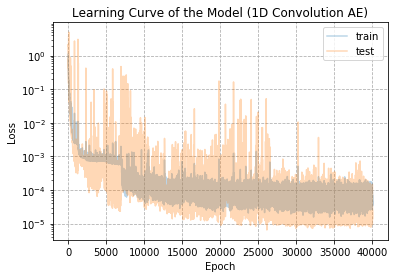

In [14]:
fig, ax = plt.subplots(1,1)
ax.plot(model.history.history['loss'], alpha = 0.3)
ax.plot(model.history.history['val_loss'], alpha = 0.3)
ax.legend(['train', 'test'], loc='upper right')
ax.set_yscale('log')
ax.grid(ls = '--')
plt.title('Learning Curve of the Model (1D Convolution AE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [40]:
from numpy import savez
def SaveModel(filepath, model, hyperparameters):
    
    # Define subfunction that saves the model architecture and weights
    def SaveModelandWeights(savepath, model_name, model):
        weight_path = os.path.join(savepath, model_name+'_weights.h5')
        architecture_path = os.path.join(savepath, model_name+'_architecture.json')
        
        model.save_weights(weight_path)
        with open(architecture_path, 'w') as f:
            f.write(model.to_json())
    
    # Define subfunction that gets the list of all files in a given directory
    def GetAllFilepaths(directory):
        filepaths = []
        
        for root, _, files in os.walk(directory): 
            for filename in files: 
                filepath = os.path.join(root, filename) 
                filepaths.append(filepath) 
   
        return filepaths         
  
    base_dir = os.path.dirname(filepath)
    filename = os.path.basename(filepath).split('.')[0]
    
    # Create and save the files into the temporary directory
    temp_dir = os.path.join(base_dir, filename)
    if os.path.exists(temp_dir):
        raise Exception('The path of the temporary directory clashes with an existing one. Change the filename and try again')
    os.makedirs(temp_dir)
    
    SaveModelandWeights(temp_dir, 'encoder', model['encoder'])
    SaveModelandWeights(temp_dir, 'decoder', model['decoder'])
    SaveModelandWeights(temp_dir, 'autoencoder', model['model'])
    
    param_path = os.path.join(temp_dir, 'hyperparameters.npz')
    savez(param_path, **hyperparameters)
    
    # Now zip all the files in the temporary directory
    filepaths = GetAllFilepaths(temp_dir)
    
    with ZipFile(filepath, 'w') as zip: 
        for file in filepaths: 
            zip.write(file, temp_dir)
    
    # Finally, delete the temporary directory and all its contents
    shutil.rmtree(temp_dir)
    
    print('Model saved successfully at %s' %(filepath))


In [43]:

savepath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Approach_VAE/Training Results/0714_results.zip'
hyperparameters = {'learning_rate': 1e-3, 'dropout_rate': 0.0, 'batch_norm': True}
SaveModel(savepath, conv1d_ae, hyperparameters)

Model saved successfully at /home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Approach_VAE/Training Results/0714_results.zip


In [26]:
import os, shutil
from zipfile import ZipFile

def SaveModel(filepath, model, hyperparameters):
    
    # Define subfunction that saves the model architecture and weights
    def SaveModelandWeights(savepath, model_name, model):
        weight_path = os.path.join(savepath, model_name+'_weights.h5')
        architecture_path = os.path.join(savepath, model_name+'_architecture.json')
        
        model.save_weights(weight_path)
        with open(architecture_path, 'w') as f:
            f.write(model.to_json())
    
    # Define subfunction that gets the list of all files in a given directory
    def GetAllFilepaths(directory):
        filepaths = []
        
        for root, directories, files in os.walk(directory): 
            for filename in files: 
                filepath = os.path.join(root, filename) 
                filepaths.append(filepath) 
   
        return filepaths         
  
    base_dir = os.path.dirname(filepath)
    filename = os.path.basename(filepath).split('.')[0]
    
    # Create and save the files into the temporary directory
    temp_dir = os.path.join(base_dir, filename)
    if os.path.exists(temp_dir):
        raise Exception('The path of the temporary directory clashes with an existing one. Change the filename and try again')
    os.makedirs(temp_dir)
    
    SaveModelandWeights(temp_dir, 'encoder', model['encoder'])
    SaveModelandWeights(temp_dir, 'decoder', model['decoder'])
    SaveModelandWeights(temp_dir, 'autoencoder', model['autoencoder'])
    
    param_path = os.path.join(temp_dir, 'hyperparameters.npz')
    np.savez(param_path, **hyperparameters)
    
    # Now zip all the files in the temporary directory
    filepaths = GetAllFilepaths(temp_dir)
    
    with ZipFile(filepath, 'w') as zip: 
        for file in filepaths: 
            zip.write(file)
    
    # Finally, delete the temporary directory and all its contents
    shutil.rmtree(temp_dir)
    
    print('Model saved successfully at %s' %(filepath))

In [15]:
result = model.predict([test[:,:,1:3], test[:,:,3:]], batch_size = batch_size)
latent = encoder.predict([test[:,:,1:3], test[:,:,3:]], batch_size = batch_size)
print(result.shape)
print(latent.shape)

(31, 54, 2)
(31, 54, 1)


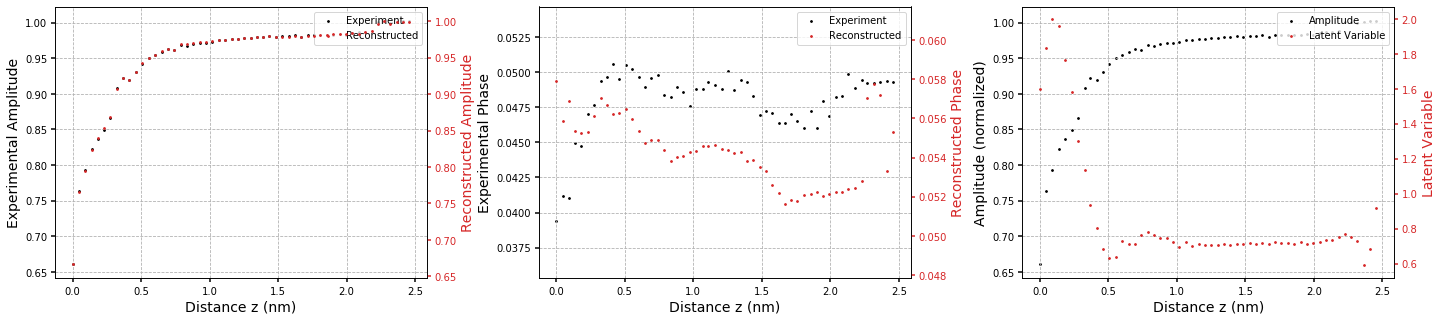

In [19]:
index_number = 20

fig = plt.figure(figsize = (24, 5))
ax_l1 = fig.add_subplot(131)
ax_m1 = fig.add_subplot(132)
ax_r1 = fig.add_subplot(133)
fig.subplots_adjust(wspace = 0.3)

ax_l2 = ax_l1.twinx()
ax_m2 = ax_m1.twinx()
ax_r2 = ax_r1.twinx()

# Plot the data
line_l1 = ax_l1.scatter(test[index_number,:,0], test[index_number,:,1], s = 3, color = 'black', label = 'Experiment')
line_l2 = ax_l2.scatter(test[index_number,:,0], result[index_number,:,0], s = 3, color = 'tab:red', label = 'Reconstructed')

line_m1 = ax_m1.scatter(test[index_number,:,0], test[index_number,:,2], s = 3, color = 'black', label = 'Experiment')
line_m2 = ax_m2.scatter(test[index_number,:,0], result[index_number,:,1], s = 3, color = 'tab:red', label = 'Reconstructed')

line_r1 = ax_r1.scatter(test[index_number,:,0], test[index_number,:,1], s = 3, color = 'black', label = 'Amplitude')
line_r2 = ax_r2.scatter(test[index_number,:,0], latent[index_number,:,0], s = 3, color = 'tab:red', label = 'Latent Variable')


# Set axis labels
fontsize = 14

ax_l1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_l1.set_ylabel('Experimental Amplitude', fontsize = fontsize)
ax_l2.set_ylabel('Reconstructed Amplitude', color = 'tab:red', fontsize = fontsize)

ax_m1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_m1.set_ylabel('Experimental Phase', fontsize = fontsize)
ax_m2.set_ylabel('Reconstructed Phase', color = 'tab:red', fontsize = fontsize)

ax_r1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_r1.set_ylabel('Amplitude (normalized)', fontsize = fontsize)
ax_r2.set_ylabel('Latent Variable', color = 'tab:red', fontsize = fontsize)

# Set axis color and size
ax_l2.yaxis.label.set_color('tab:red')
ax_m2.yaxis.label.set_color('tab:red')
ax_r2.yaxis.label.set_color('tab:red')

tkw = dict(size = 4, width = 1.5)

ax_l1.tick_params(axis='x', **tkw)
ax_l1.tick_params(axis='y', **tkw)
ax_l2.tick_params(axis='y', colors='tab:red', **tkw)

ax_m1.tick_params(axis='x', **tkw)
ax_m1.tick_params(axis='y', **tkw)
ax_m2.tick_params(axis='y', colors='tab:red', **tkw)

ax_r1.tick_params(axis='x', **tkw)
ax_r1.tick_params(axis='y', **tkw)
ax_r2.tick_params(axis='y', colors='tab:red', **tkw)

# Create unified legend for all the plots
lines_l = [line_l1, line_l2]
labels_l = [l.get_label() for l in lines_l]
ax_l1.legend(lines_l, labels_l, loc = 'upper right')

lines_m = [line_m1, line_m2]
labels_m = [l.get_label() for l in lines_m]
ax_m1.legend(lines_m, labels_m, loc = 'upper right')

lines_r = [line_r1, line_r2]
labels_r = [l.get_label() for l in lines_r]
ax_r1.legend(lines_r, labels_r, loc = 'upper right')

ax_l1.grid(ls = '--')
ax_m1.grid(ls = '--')
ax_r1.grid(ls = '--')

**Analyze the trained results**

Text(0.5, 1.0, 'Predicted latent variables for the test dataset (31 approach curve)')

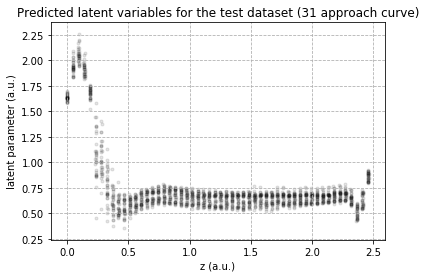

In [17]:
fig, ax = plt.subplots(1,1)
kwargs = {'c':'k', 'marker':'.', 'alpha':0.1}
for i in range(test.shape[0]):
    ax.scatter(test[i,:,0], latent[i,:,0], **kwargs) 
    
ax.grid(ls = '--')
ax.set_xlabel('z (a.u.)')
ax.set_ylabel('latent parameter (a.u.)')
ax.set_title('Predicted latent variables for the test dataset (31 approach curve)')

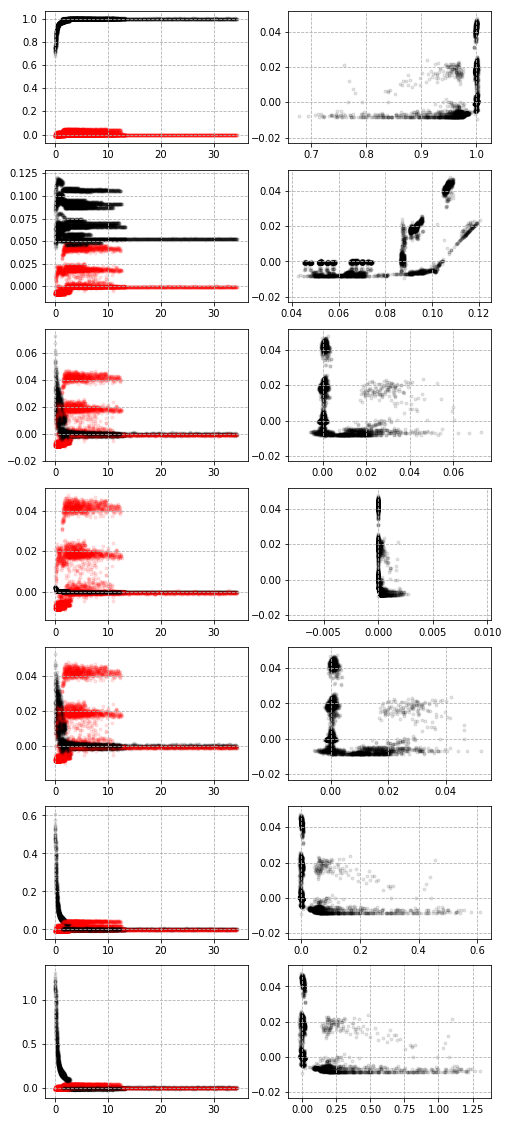

In [40]:
fig, axes = plt.subplots(7, 2, figsize = (8,20))
axes = axes.flatten()

for i in range(test_dataset['Q'].size):
    imin = test_dataset['imin'][i]
    plot_index = range(imin+1)
    
    mech = test_dataset['mech'][i][plot_index, :]
    k = test_dataset['kint'][i][plot_index]
    b = test_dataset['bint'][i][plot_index]
    E = test_dataset['E'][i][plot_index]
    Fk = test_dataset['Fk'][i][plot_index]
    Fb = test_dataset['Fb'][i][plot_index]

    ww0 = np.ones((imin+1, 1))*test_dataset['w'][i]/test_dataset['w0'][i]
    Q = np.ones((imin+1, 1))*test_dataset['Q'][i]
    
    latent = encoder.predict(mech[:, 1:], batch_size = batch_size)
    #latent = encoder.predict(np.c_[mech[:, 1:], ww0, Q], batch_size = batch_size)
    
    axes[0].scatter(mech[:,0], mech[:,1], c = 'k', marker = '.', alpha = 0.1) # plot amplitude
    axes[0].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[1].scatter(mech[:,1], latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[1].plot(latent[0], latent[0], '--r')
    
    
    axes[2].scatter(mech[:,0], mech[:,2], c = 'k', marker = '.', alpha = 0.1) # plot phase
    axes[2].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[3].scatter(mech[:,2], latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[3].plot(latent[0], latent[0], '--r')
    
    
    axes[4].scatter(mech[:,0], 10000*k, c = 'k', marker = '.', alpha = 0.1) # plot k
    axes[4].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[5].scatter(10000*k, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[5].plot(latent[0], latent[0], '--r')
    
    
    axes[6].scatter(mech[:,0], 1000000*b, c = 'k', marker = '.', alpha = 0.1) # plot b
    axes[6].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[7].scatter(1000000*b, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[7].plot(latent[0], latent[0], '--r')
    
    
    axes[8].scatter(mech[:,0], 10000*Fk, c = 'k', marker = '.', alpha = 0.1) # plot Fk
    axes[8].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[9].scatter(10000*Fk, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[9].plot(latent[0], latent[0], '--r')
    
    
    axes[10].scatter(mech[:,0], 10000*Fb, c = 'k', marker = '.', alpha = 0.1) # plot Fb
    axes[10].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[11].scatter(10000*Fb, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[11].plot(latent[0], latent[0], '--r')
    
    
    axes[12].scatter(mech[:,0], 10000*E, c = 'k', marker = '.', alpha = 0.1) # plot E
    axes[12].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[13].scatter(10000*E, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[13].plot(latent[0], latent[0], '--r')
    
for ax in axes:
    ax.grid(ls = '--')

31


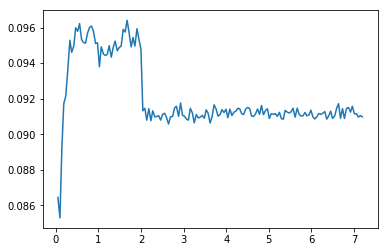

In [42]:
# Select particular approach curve
print(test_dataset['Q'].size)
trial_index = 5 # for anomaly, try 458
mech = test_dataset['mech'][trial_index]
imin = test_dataset['imin'][trial_index]
plot_index = range(imin)
plt.plot(mech[plot_index, 0], mech[plot_index, 2])
plt.show()

In [43]:
# calculate normalized k_int and b_int

k_i = test_dataset['kint'][trial_index][plot_index]
b_i = test_dataset['bint'][trial_index][plot_index]
E_i = test_dataset['E'][trial_index][plot_index]
Fk_i = test_dataset['Fk'][trial_index][plot_index]
Fb_i = test_dataset['Fb'][trial_index][plot_index]

ww0_i = np.ones((imin, 1))*test_dataset['w'][trial_index]/test_dataset['w0'][trial_index]
Q_i = np.ones((imin, 1))*test_dataset['Q'][trial_index]
#
#latent = encoder.predict(np.c_[mech[plot_index, 1:], ww0_i, Q_i], batch_size = batch_size)
latent = encoder.predict(mech[plot_index, 1:], batch_size = batch_size)

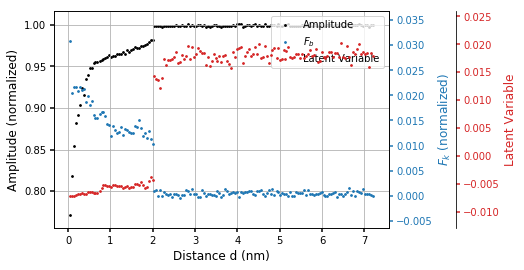

In [44]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# Offset the right spine of par2.  The ticks and label have already been placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, ax3 has its frame off, so the line of its detached spine is invisible.  
#First, activate the frame but make the patch and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)


# Plot the data
line1 = ax1.scatter(mech[plot_index, 0], mech[plot_index, 1], s = 3, color = 'black', label = 'Amplitude')
line2 = ax2.scatter(mech[plot_index, 0], 10000*Fk_i, s = 3, color = 'tab:blue', label = '$F_b$')
line3 = ax3.scatter(mech[plot_index, 0], latent[0], s = 3, color = 'tab:red', label = 'Latent Variable')

# Set axis labels
ax1.set_xlabel('Distance d (nm)', fontsize = 12)
ax1.set_ylabel('Amplitude (normalized)', fontsize = 12)
ax2.set_ylabel('$F_k$ (normalized)', color = 'tab:blue', fontsize = 12)
ax3.set_ylabel('Latent Variable', color = 'tab:red', fontsize = 12)

# Set axis color and size
ax2.yaxis.label.set_color('tab:blue')
ax3.yaxis.label.set_color('tab:red')

tkw = dict(size = 4, width = 1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='y', colors='tab:blue', **tkw)
ax3.tick_params(axis='y', colors='tab:red', **tkw)

# Create unified legend for all the plots
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc = 'upper right')

#ax1.axvline(trial[np.argmax(latent),0], color = 'red', alpha = 0.8)
#ax1.axvline(trial[np.argmax(E_i),0], color = 'blue', alpha = 0.8)
ax1.grid(True)


In [45]:
from scipy.stats.stats import pearsonr
amp = np.reshape(mech[plot_index, 1], mech[plot_index, 2].size)
phas = np.reshape(mech[plot_index, 2], mech[plot_index, 2].size)
latent_var = np.reshape(latent[0], mech[plot_index, 2].size)

pearsonr(amp, latent_var)
pearsonr(phas, latent_var)

(-0.7497092130818291, 3.160508236025604e-29)